In [280]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns=None
pd.options.display.max_rows=None
plt.style.use('fivethirtyeight')

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder


from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [281]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [282]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [283]:
print('Shape of train dataset: ',train.shape)
print('Shape of test dataset: ',test.shape)

Shape of train dataset:  (1460, 81)
Shape of test dataset:  (1459, 80)


In [284]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

In [312]:
#Function to plot count of categorical features

def cat_plot(column):
    plt.figure(figsize=(25,8))
    sns.countplot(train[column])
    plt.title(column)
    plt.xticks(rotation=90)
    plt.show()
    

#Function to plot distribution of numerical features

def num_plot(nume):
    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    plt.title(nume)
    #sns.distplot(train[nume],ax=ax1,color='red')
    sns.distplot(train[nume],color='red')
    #sns.distplot(np.log(train[nume]),ax=ax2,color='blue')
    plt.show()
 
#Function for boxplots with respect to SalePrice
def box_plot(column):
    plt.figure(figsize=(25,8))
    sns.boxplot(y=train.SalePrice,x=train[column])
    plt.title(column)
    plt.xticks(rotation=90)
    plt.show()

#Function for scatterplot with respect to SalePrice
def scat_plot(column):
    plt.figure(figsize=(25,8))
    sns.scatterplot(y=train.SalePrice,x=train[column])
    plt.title(column)
    plt.xticks(rotation=90)
    plt.show()
    
#Function for scatterplot to plot with normalized values
def normal_scat_plot(column):
    plt.figure(figsize=(25,8))
    sns.scatterplot(y=train.SalePrice,x=np.log(train[column]))
    plt.title(column)
    plt.xticks(rotation=90)
    plt.show()

#Function of probplot to plot log values of numerical features
def prob_plot(column):
    plt.figure(figsize=(12,8))
    stats.probplot(np.log(train[column]),plot=plt)
    plt.title(column)
    plt.show()

#Function to find missing values of a dataframe   
def missing(df):
    missing_values=pd.DataFrame(df.isnull().sum()/len(df)*100).reset_index().rename(columns={'index':'col',0:'value'}).sort_values(by='value',ascending=False)
    plt.figure(figsize=(10,20))
    sns.barplot(y='col',x='value',data=missing_values)
    plt.title('Missing values')
    plt.show()

In [286]:
#Identifying categorical features
cat=[]
num=[]
for col in train.columns[:]:
    if train[col].dtype=='O':
        cat.append(col)
    else:
        num.append(col)

In [287]:
len(cat),len(num)

(43, 38)

In [288]:
#Identifying categorical features which have numerical datatype
new_cat=['KitchenAbvGr','Fireplaces','YearBuilt','YearRemodAdd','BsmtFullBath','BsmtHalfBath','FullBath',
         'HalfBath','BedroomAbvGr','TotRmsAbvGrd','GarageYrBlt','GarageCars','MoSold','YrSold']
for i in cat:
    new_cat.append(i)
    
print('Categorical features list: ',new_cat)

Categorical features list:  ['KitchenAbvGr', 'Fireplaces', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [389]:
only_num=[]
for n in num:
    if n not in new_cat:
        only_num.append(n)

print('Numerical Features list: ',only_num)

Numerical Features list:  ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']


In [388]:
print('Number of categorical features: ',len(new_cat))
print('Percentage of categorical features: ',len(new_cat)/train.shape[1],'%')
print('Number of numerical features: ',len(only_num))
print('Percentage of numerical features: ',(len(only_num))/train.shape[1],'%')

Number of categorical features:  57
Percentage of categorical features:  0.13539192399049882 %
Number of numerical features:  24
Percentage of numerical features:  0.057007125890736345 %


Count plot of categorical features


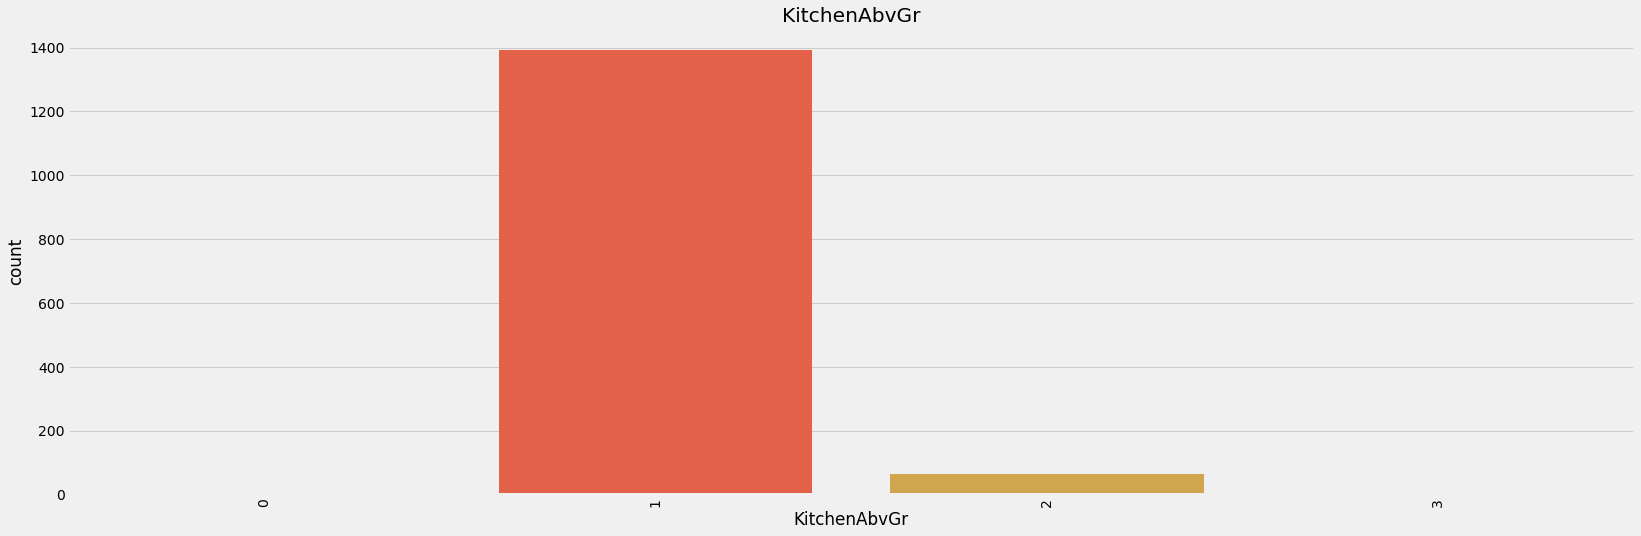

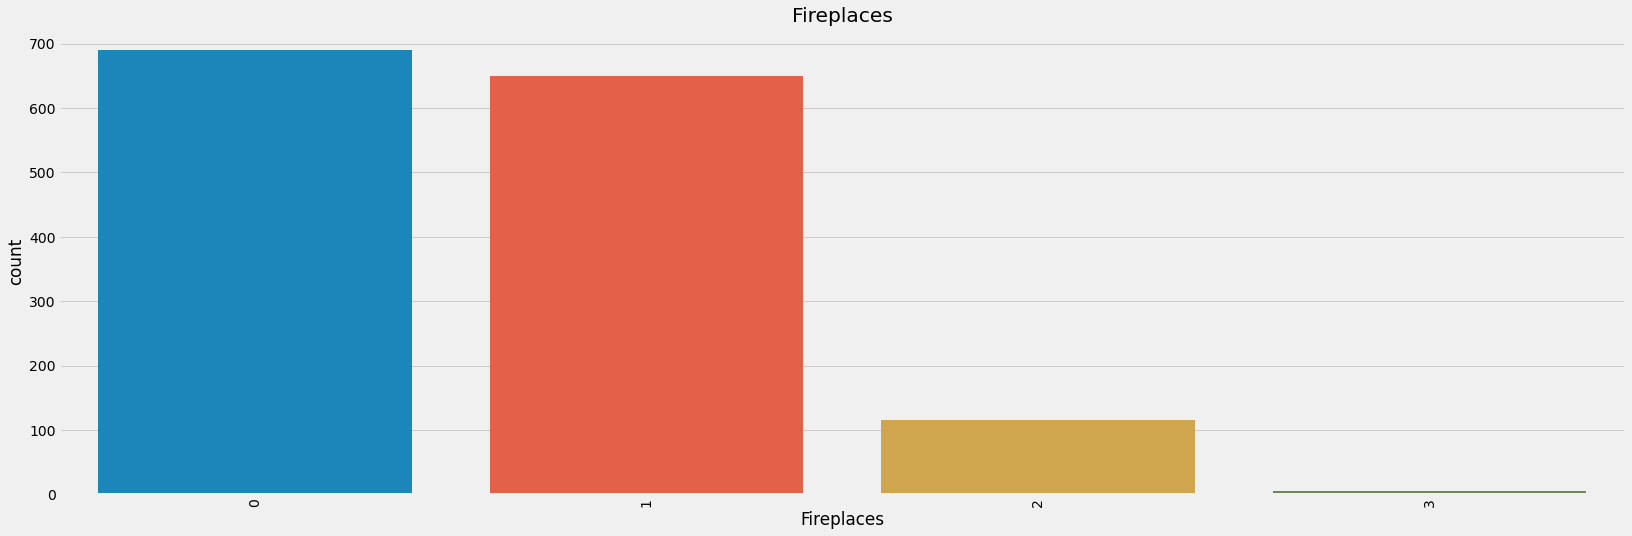

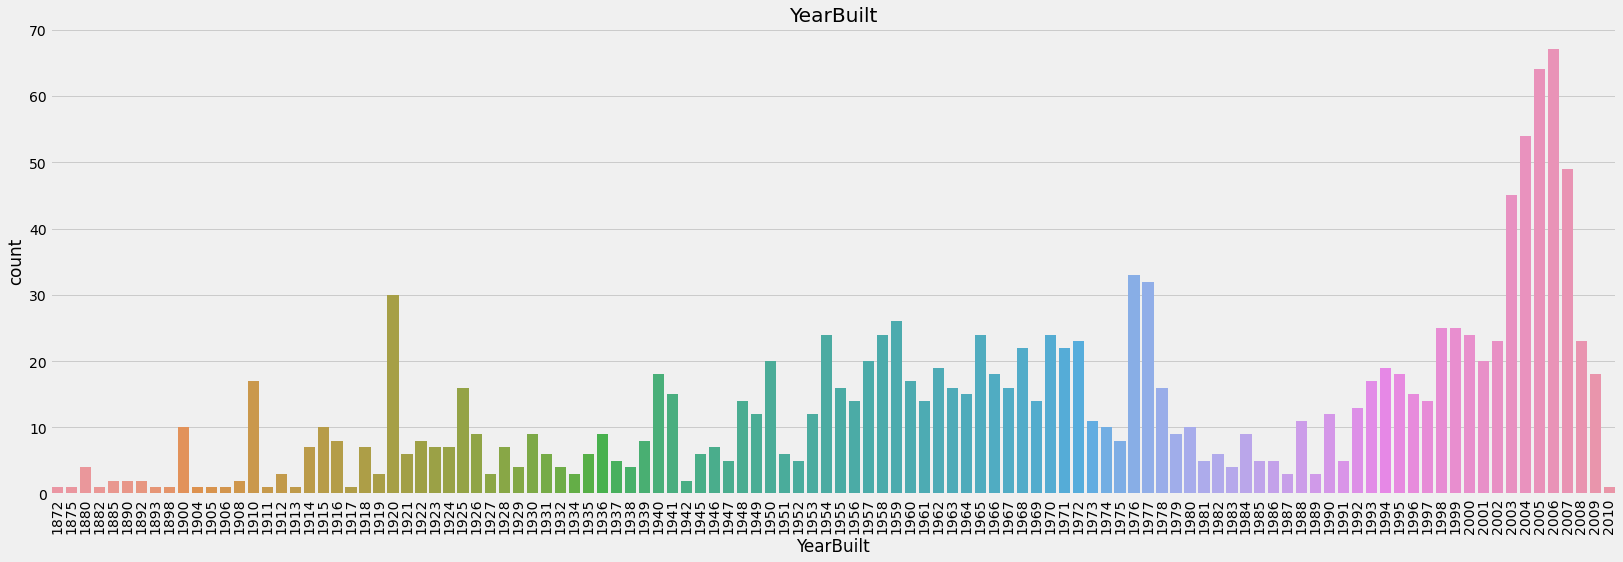

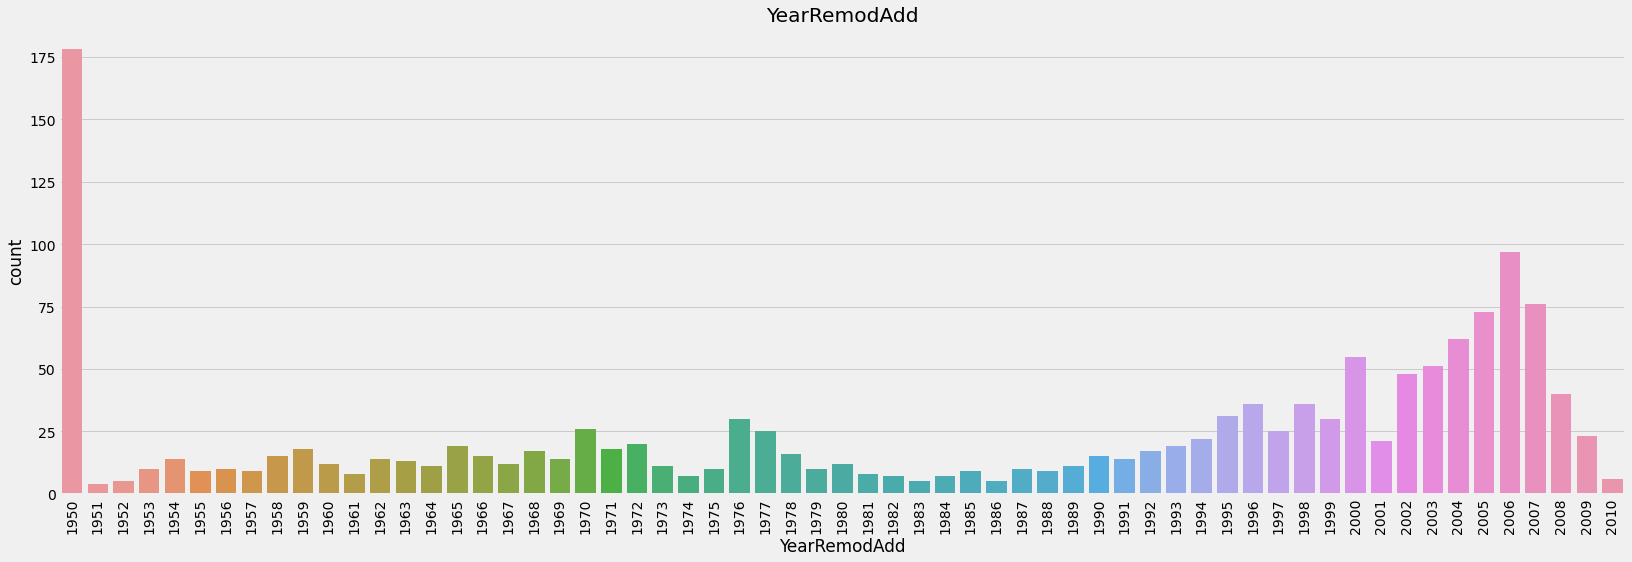

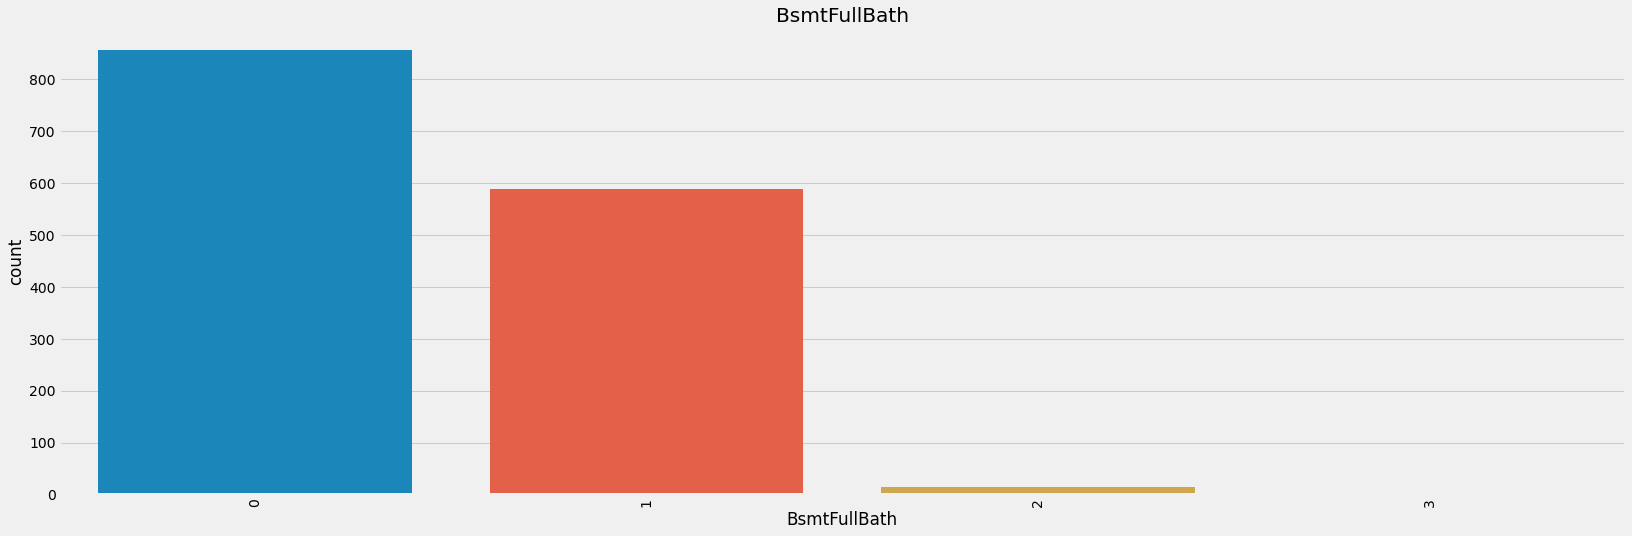

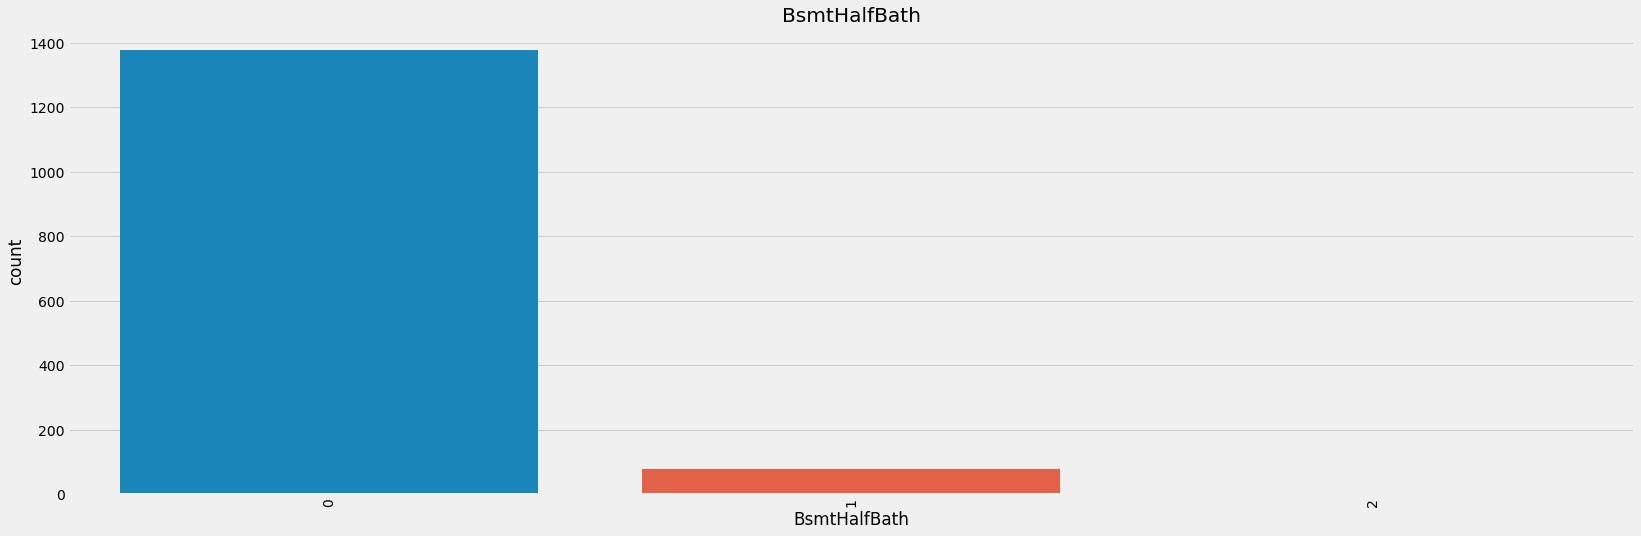

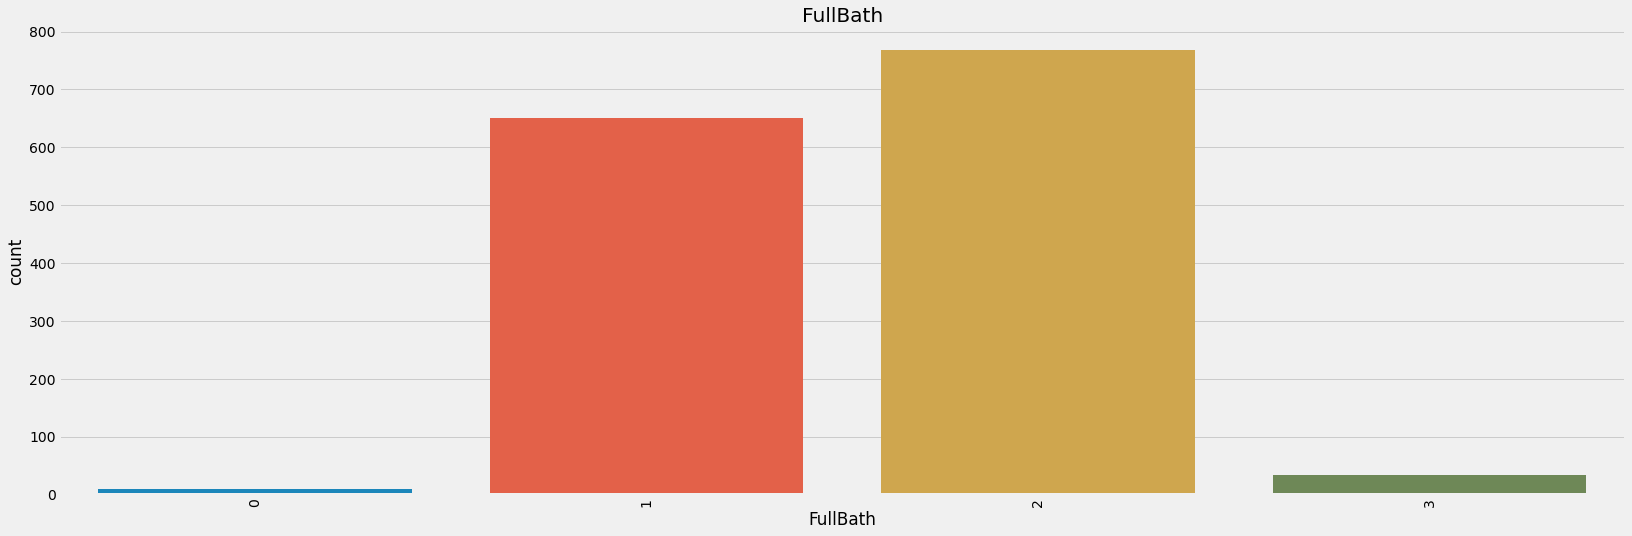

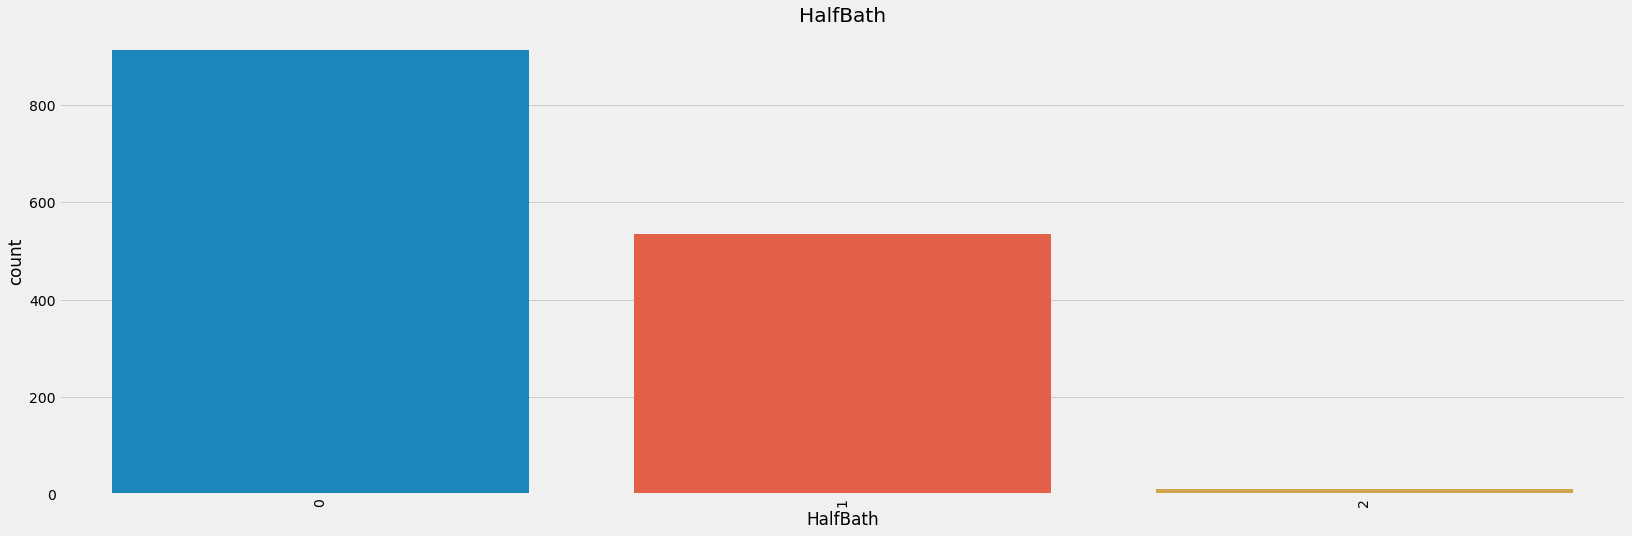

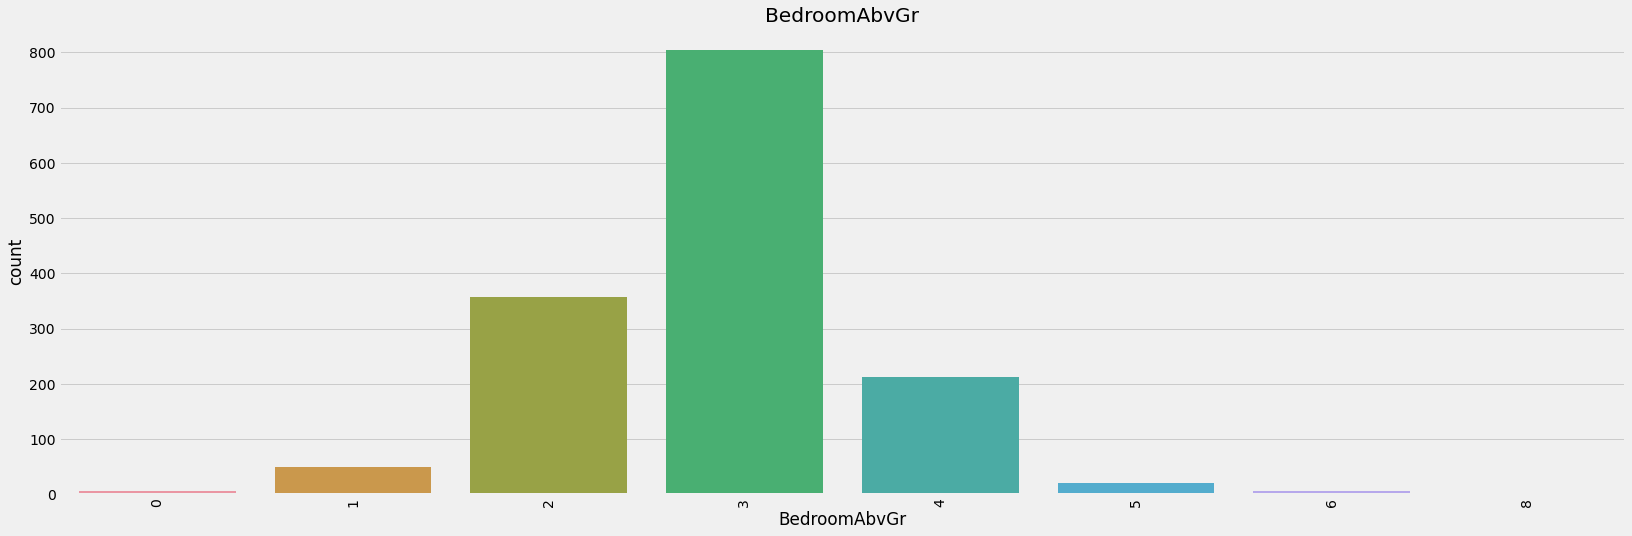

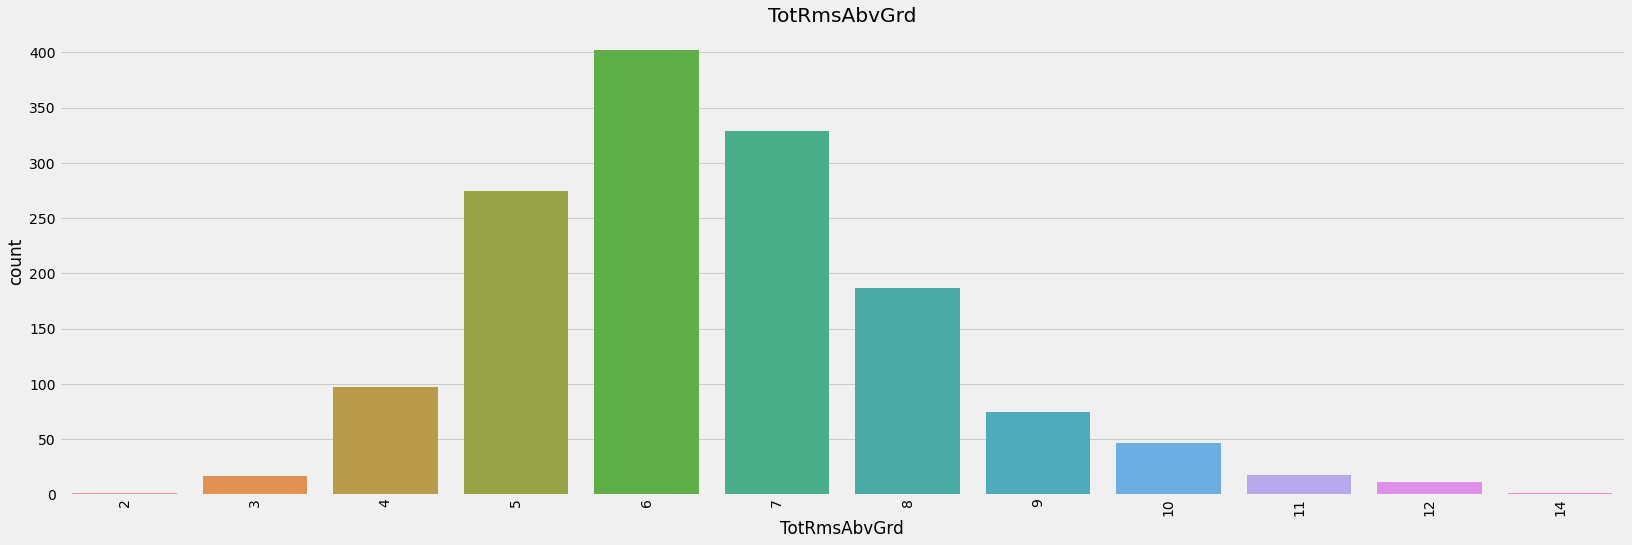

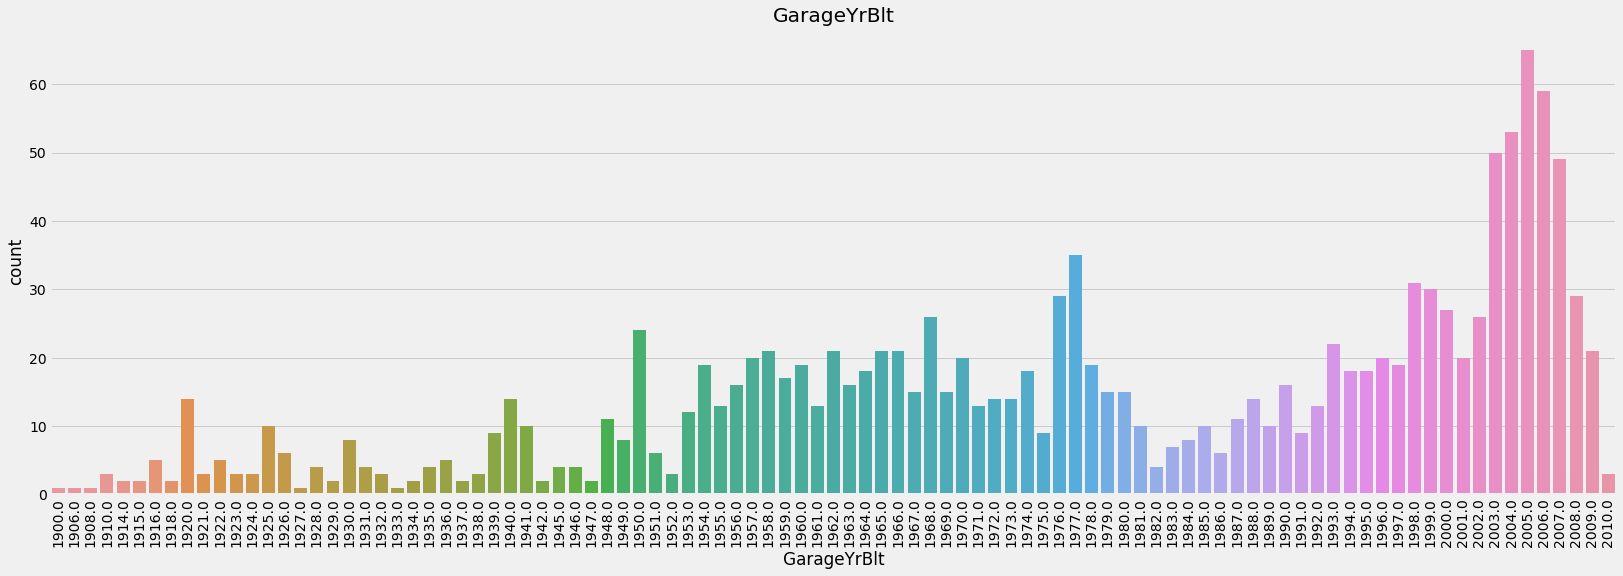

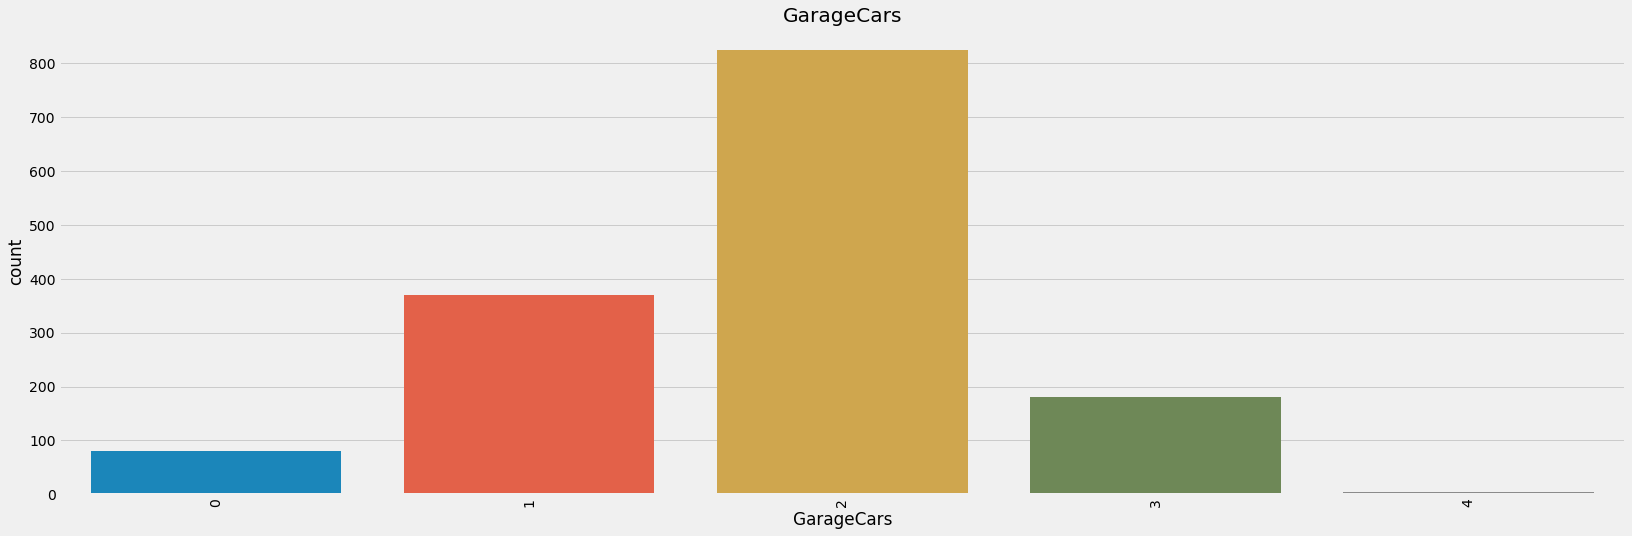

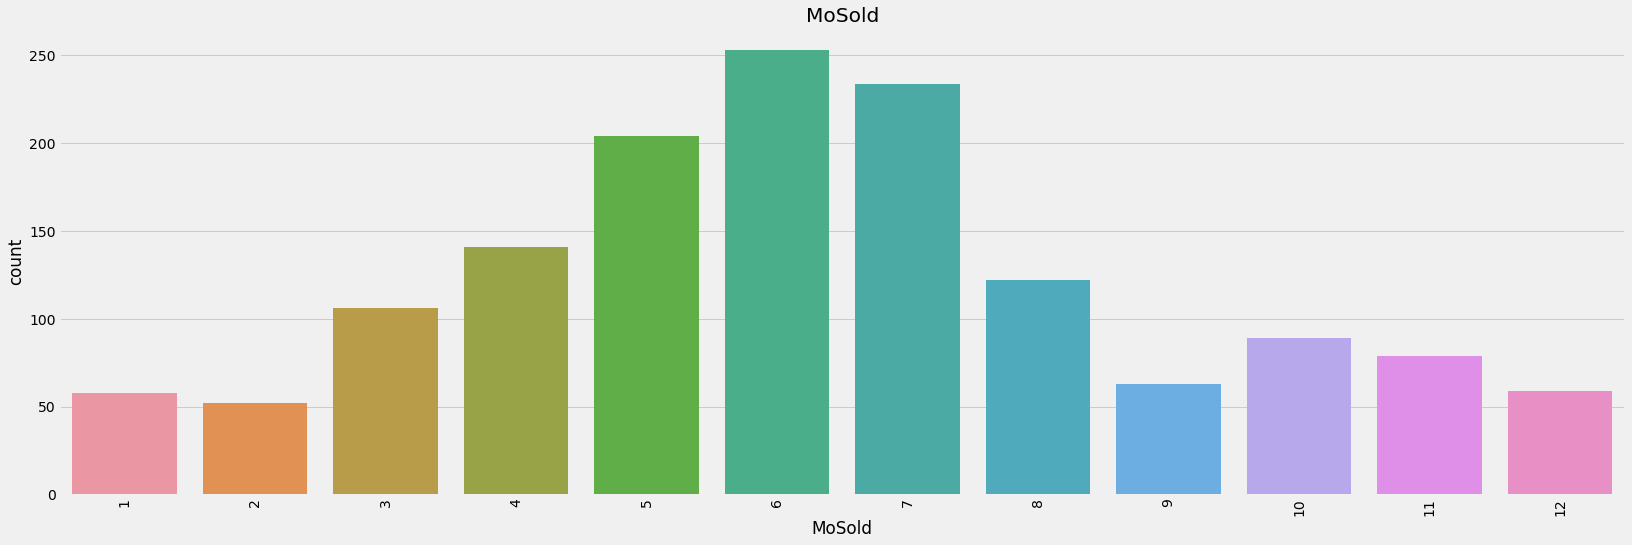

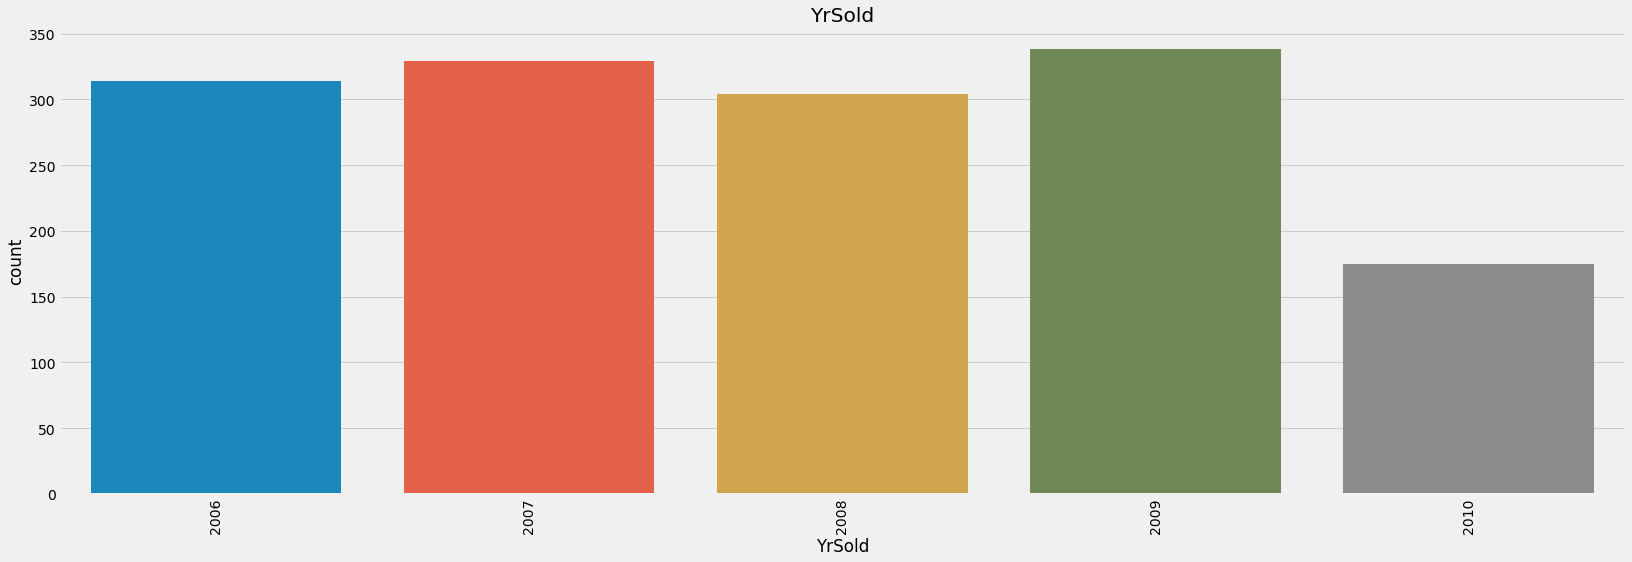

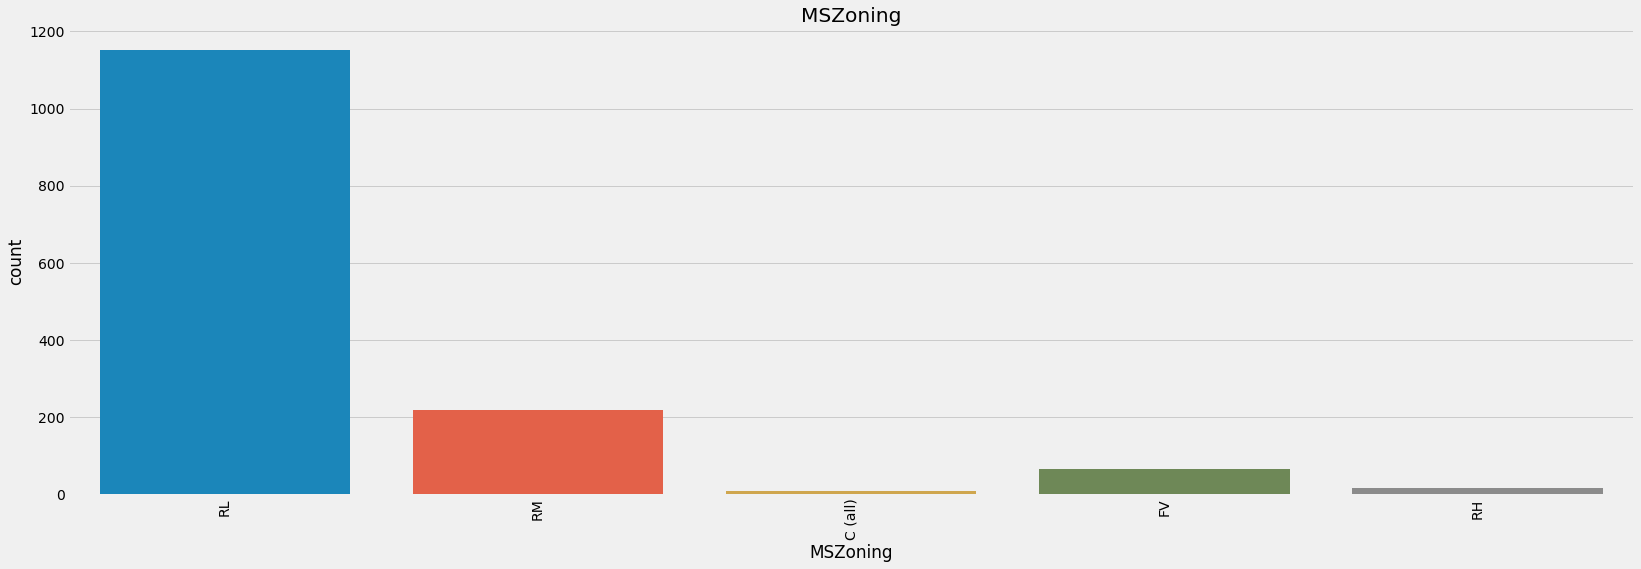

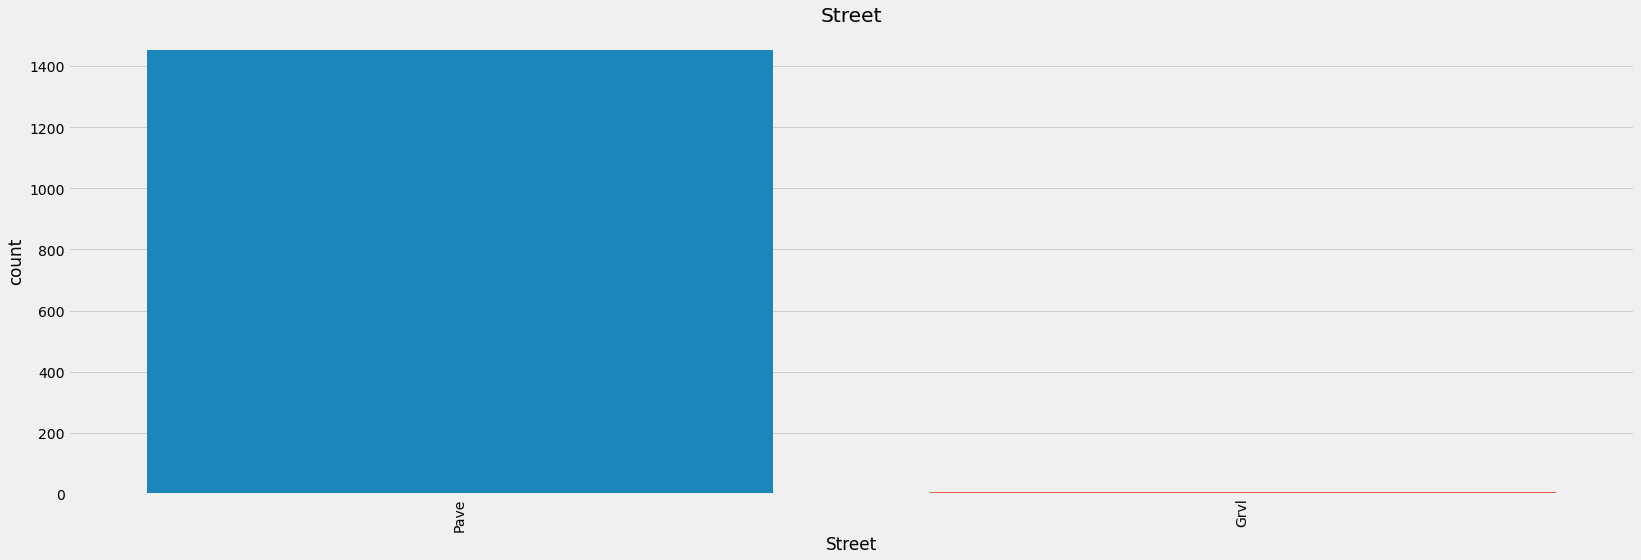

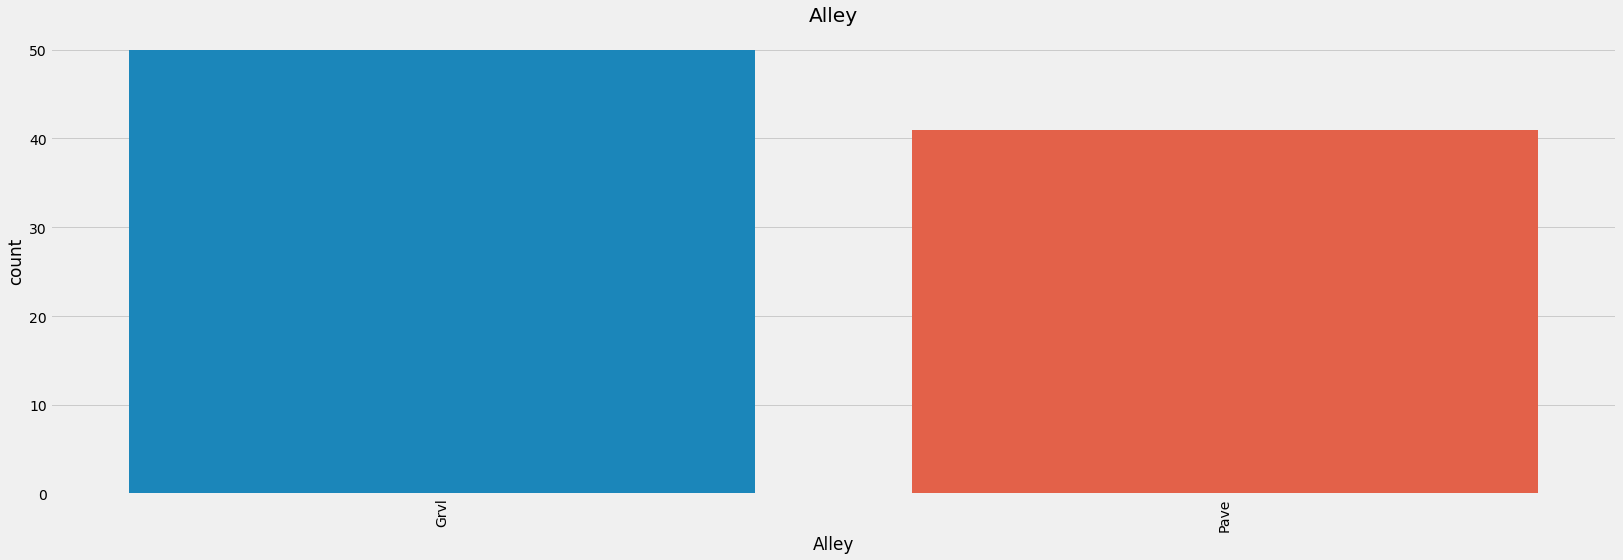

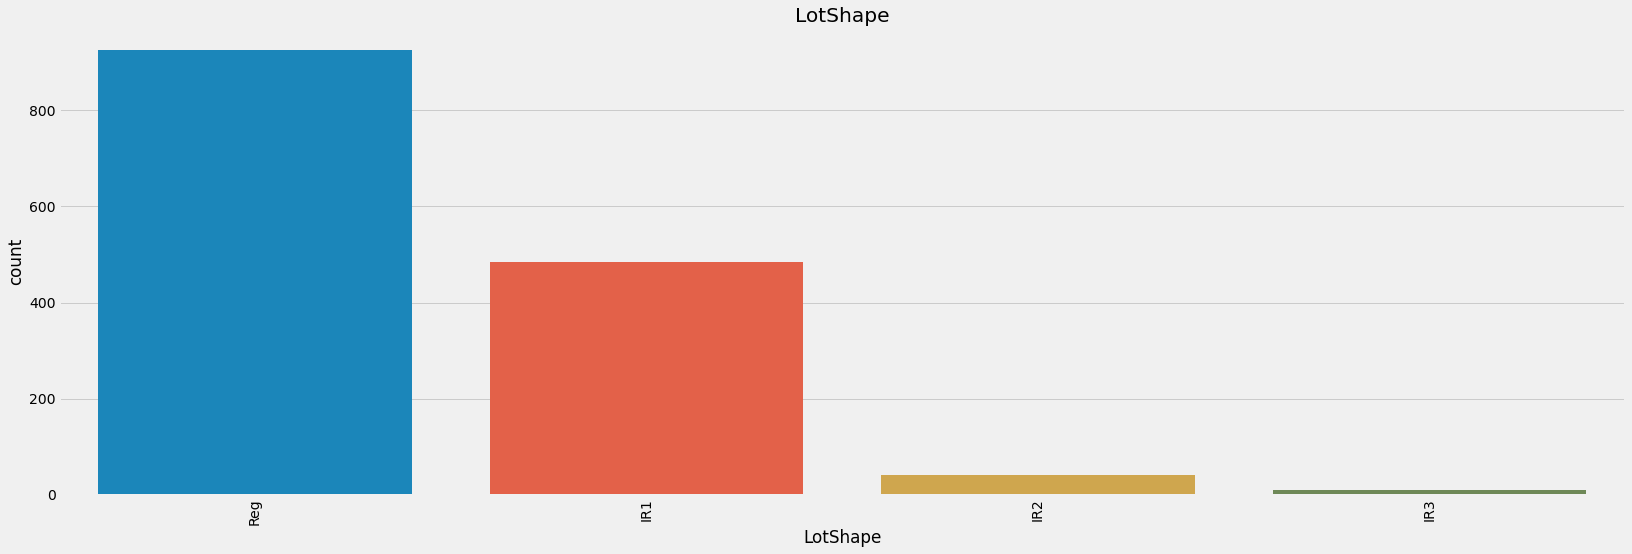

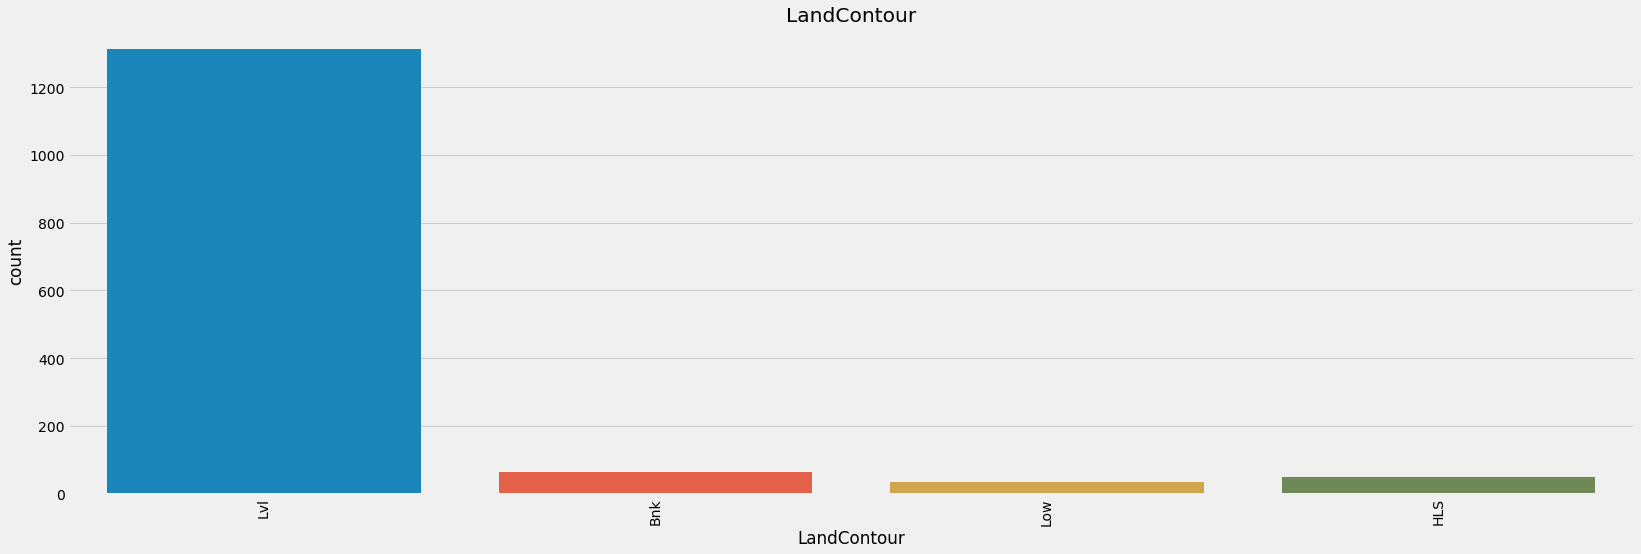

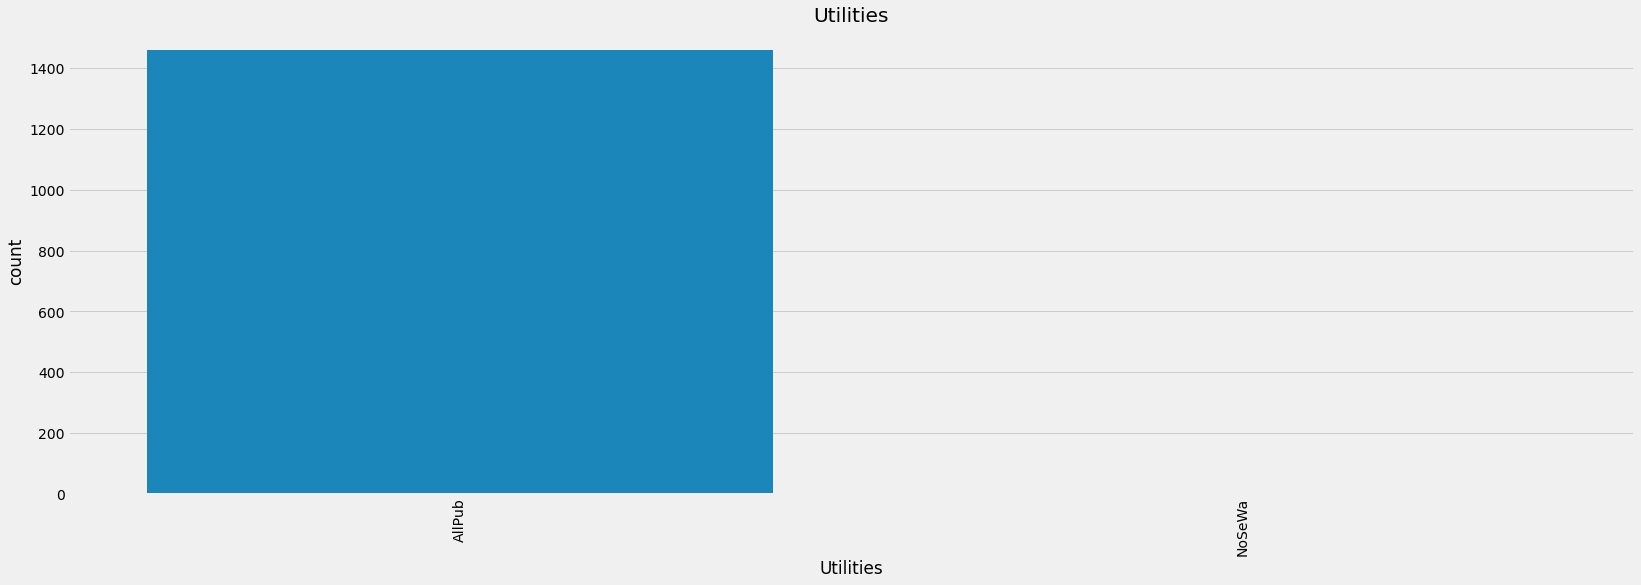

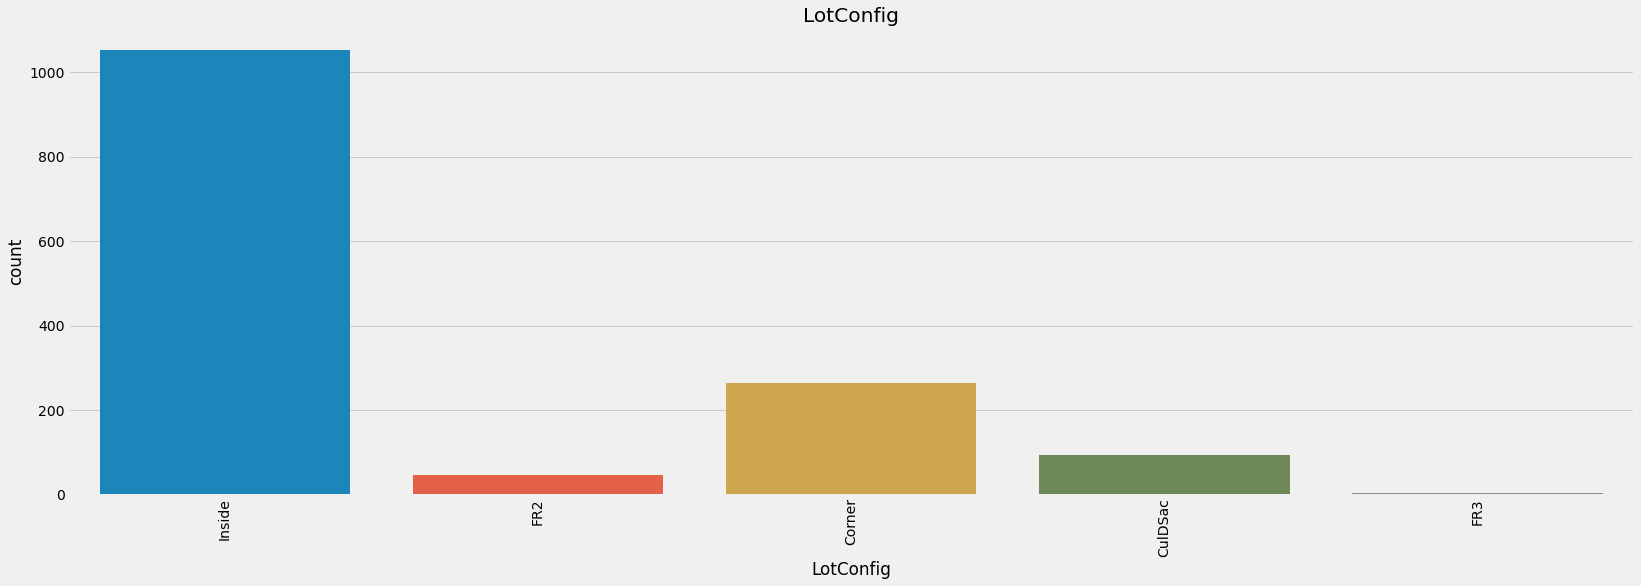

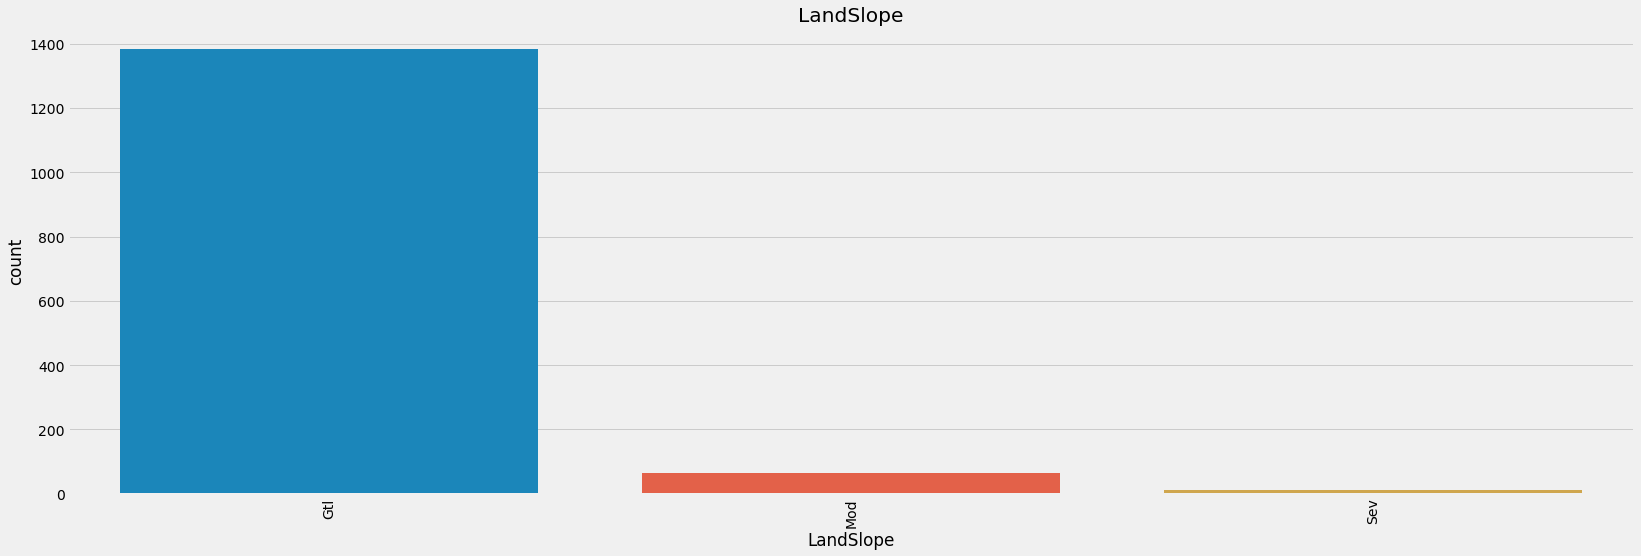

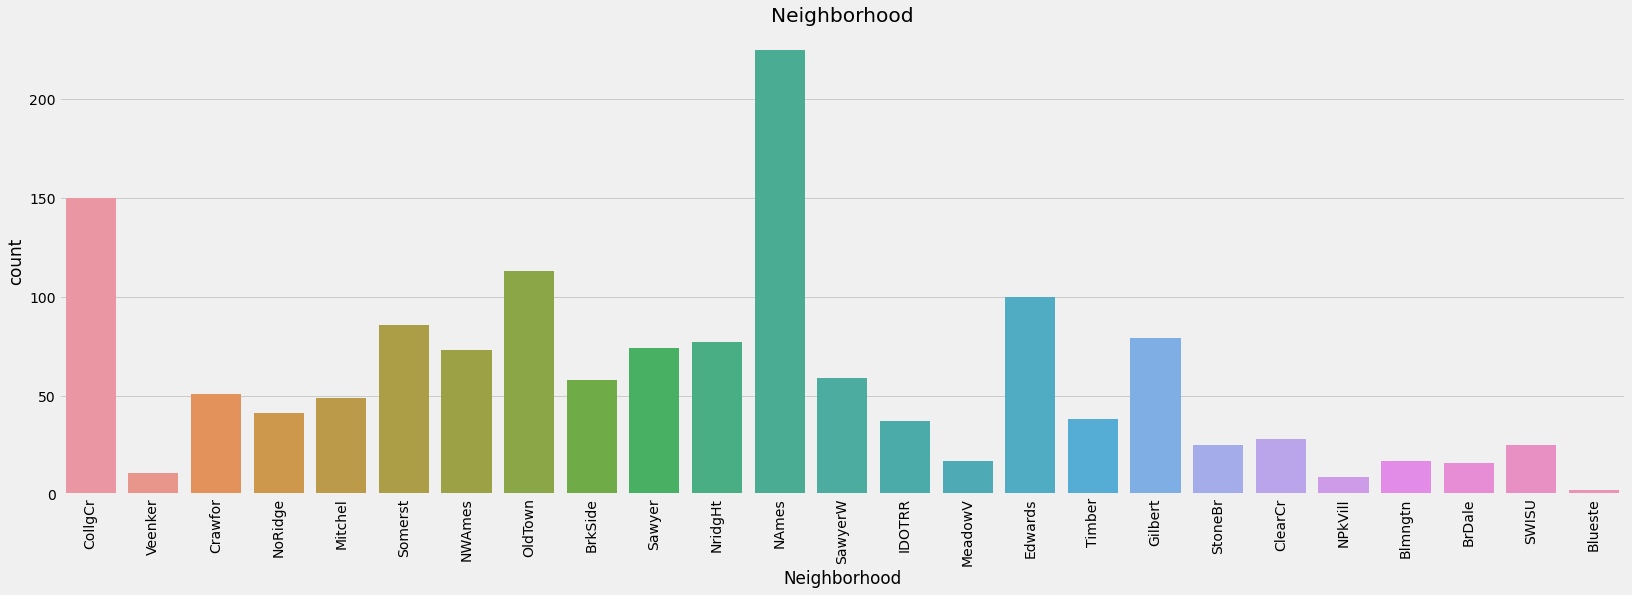

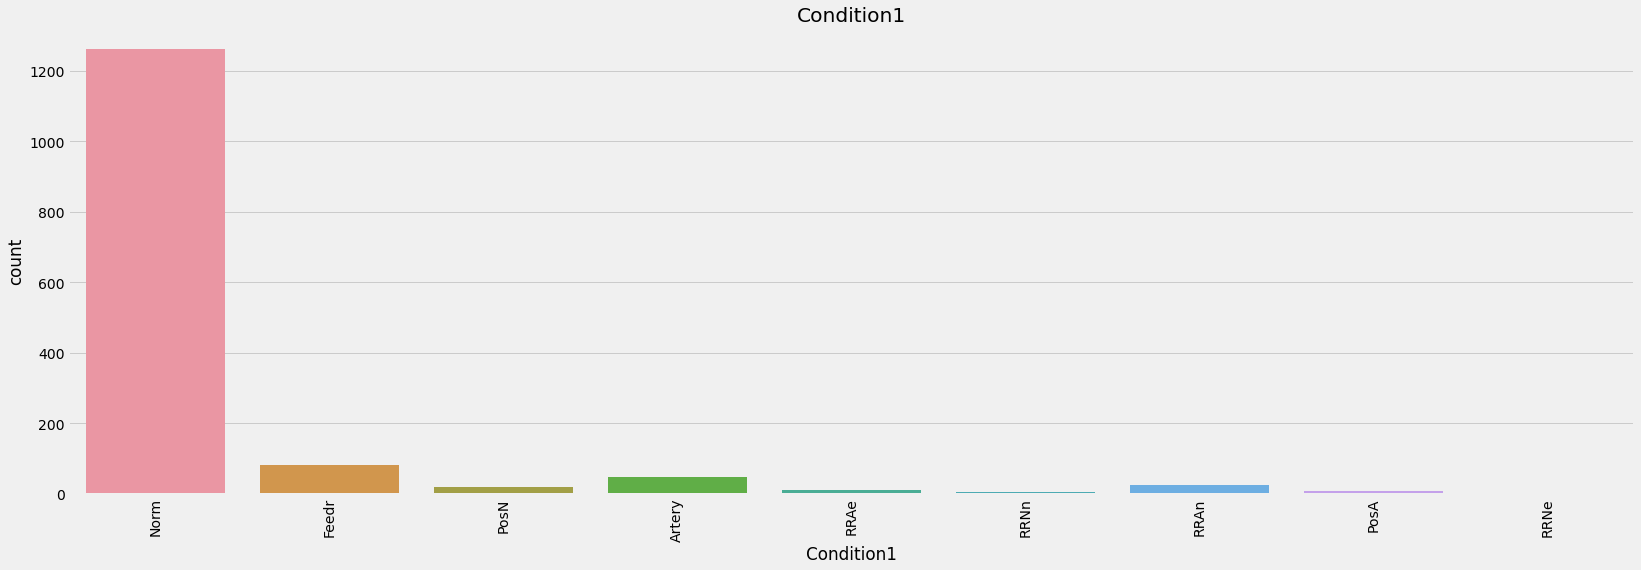

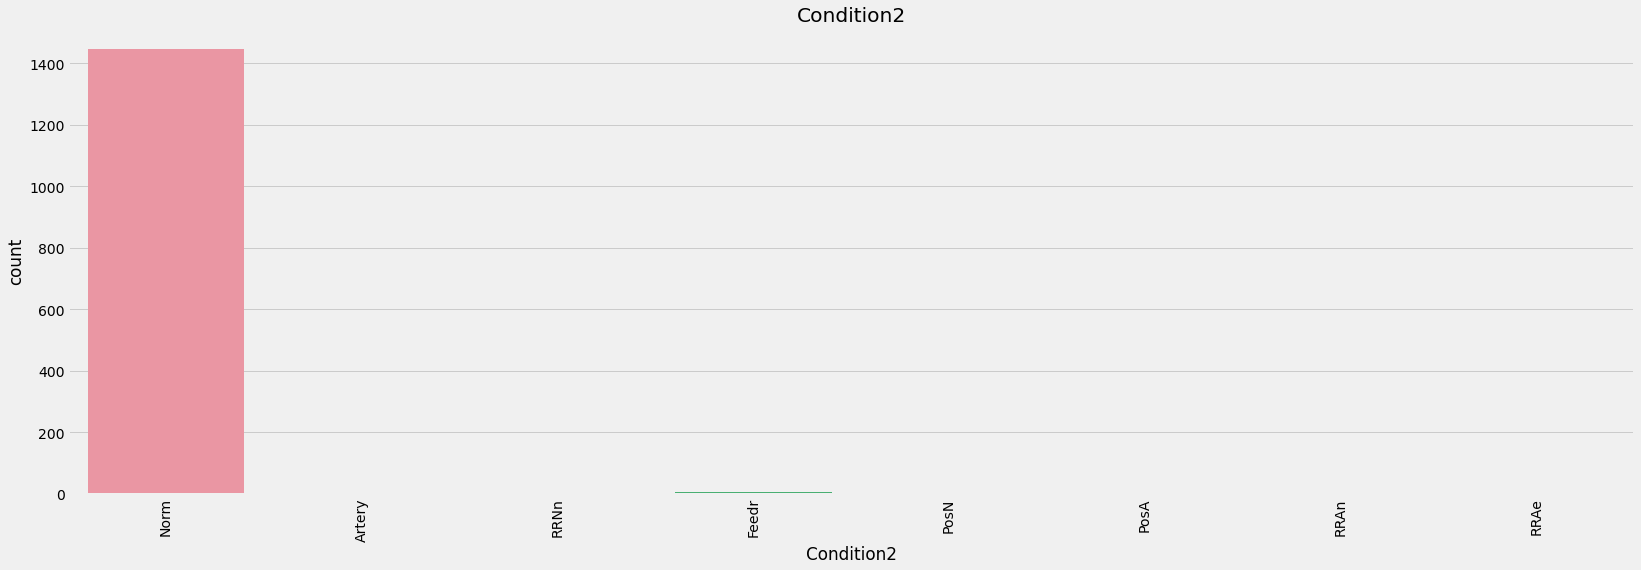

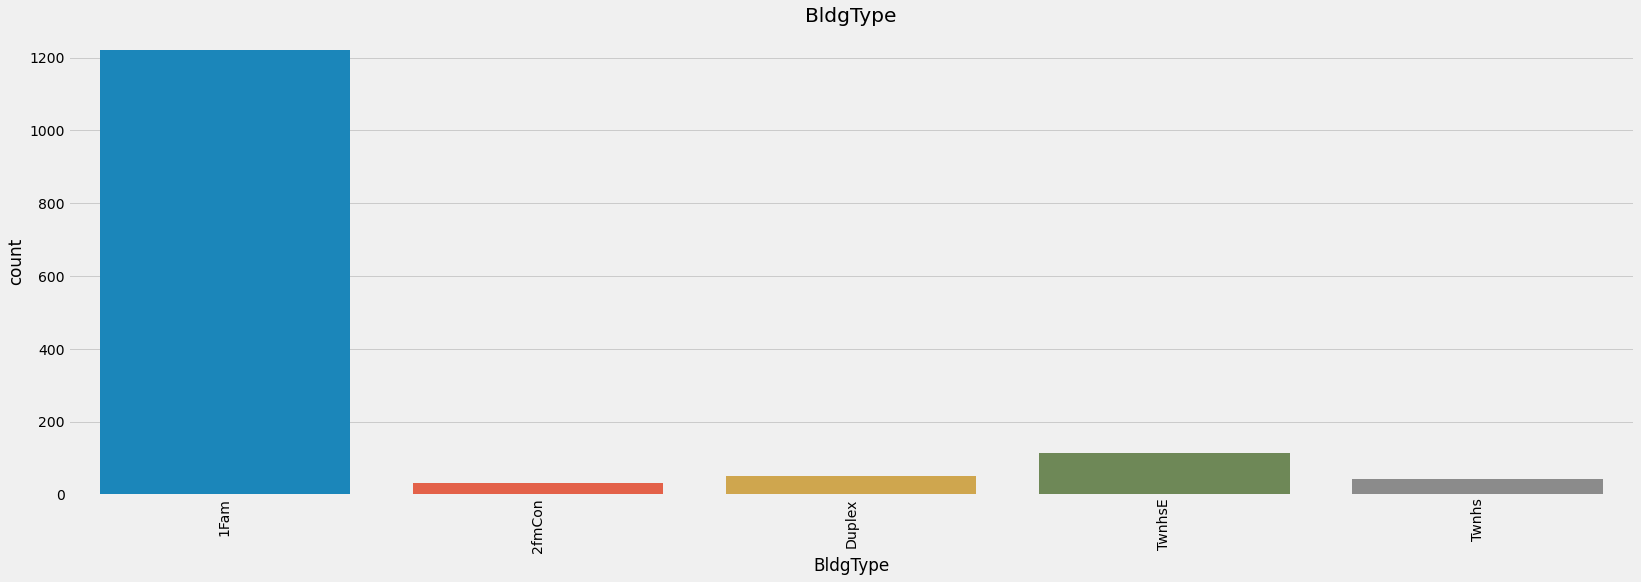

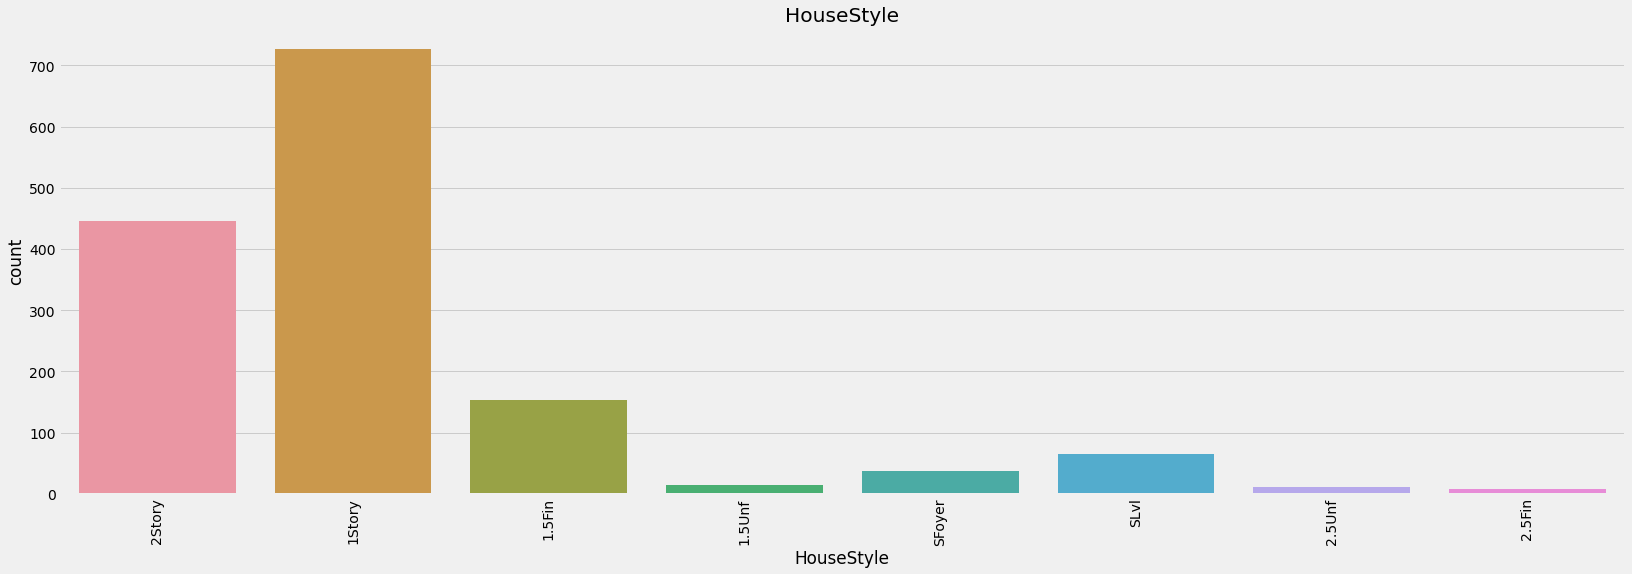

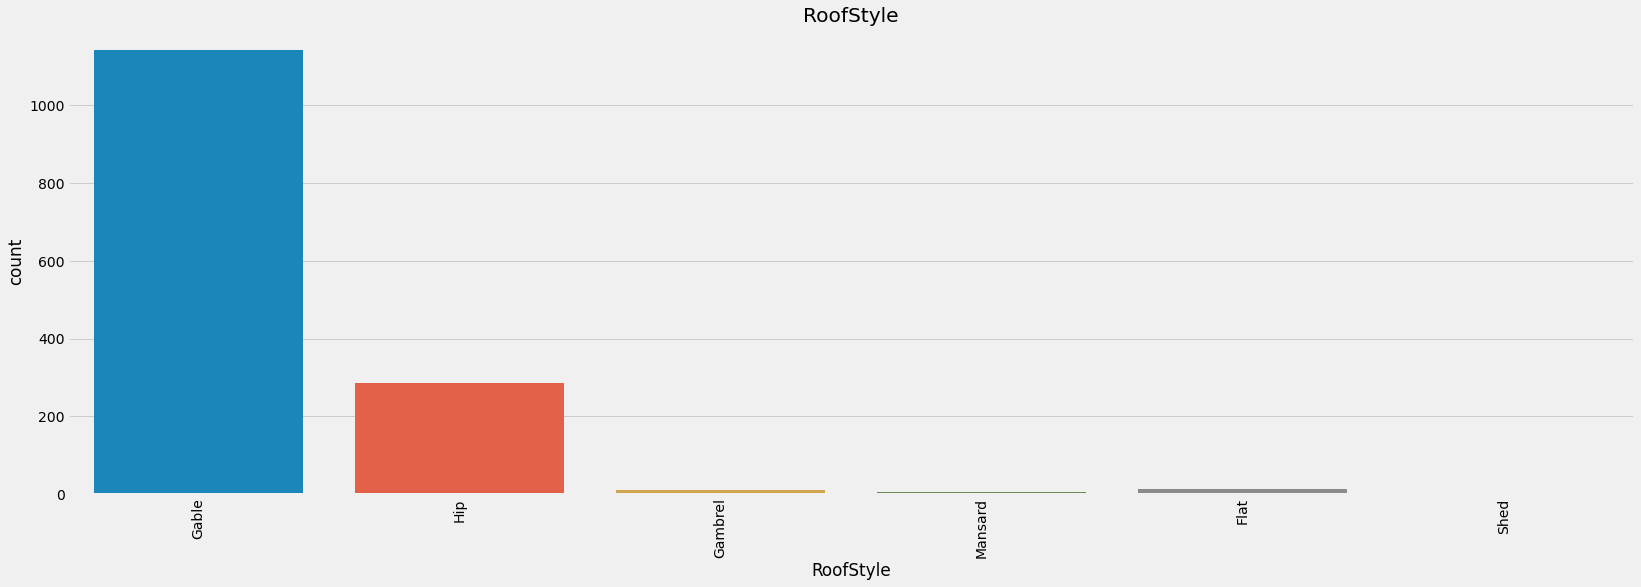

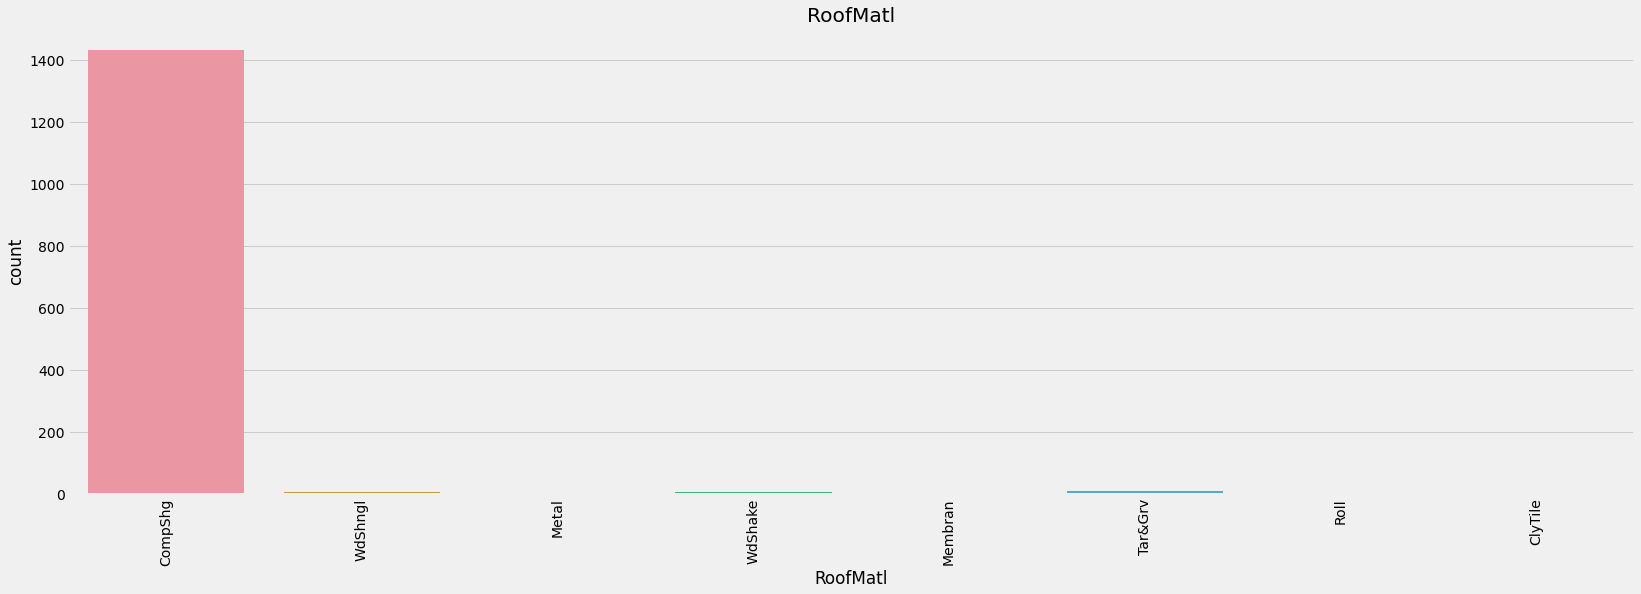

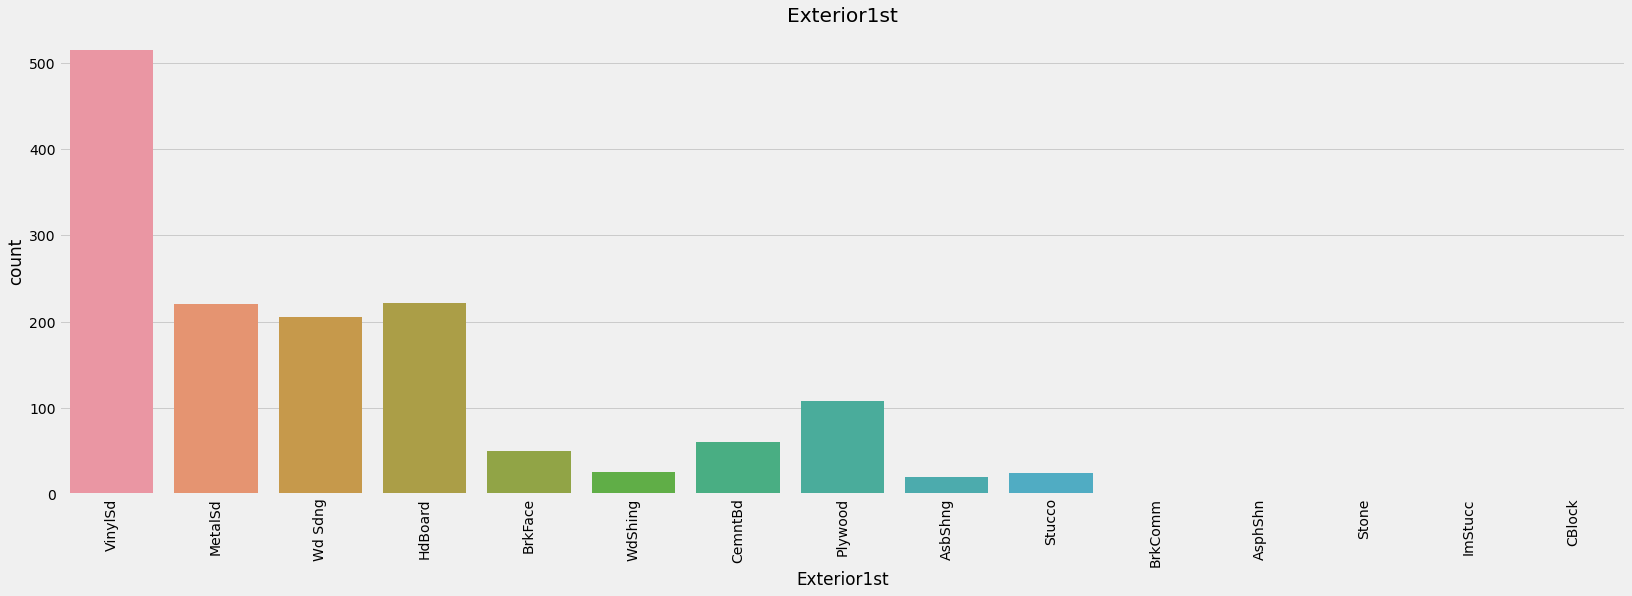

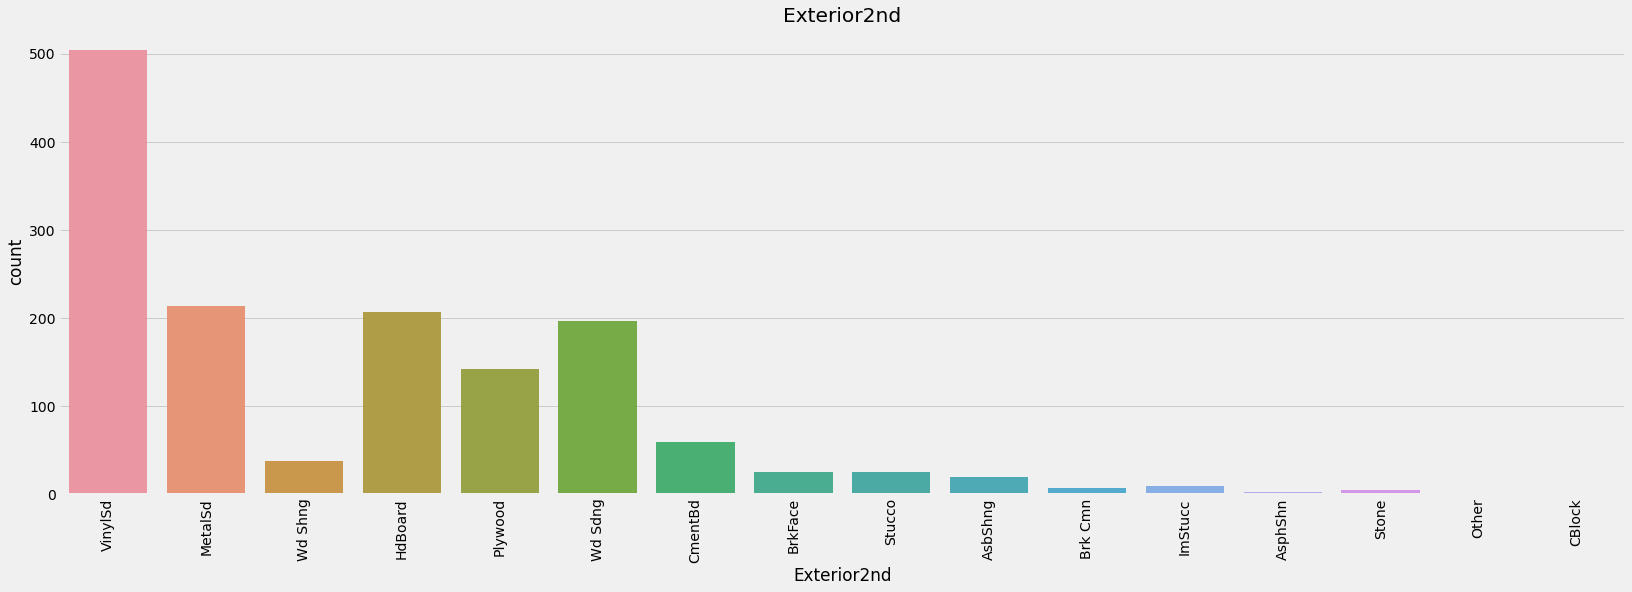

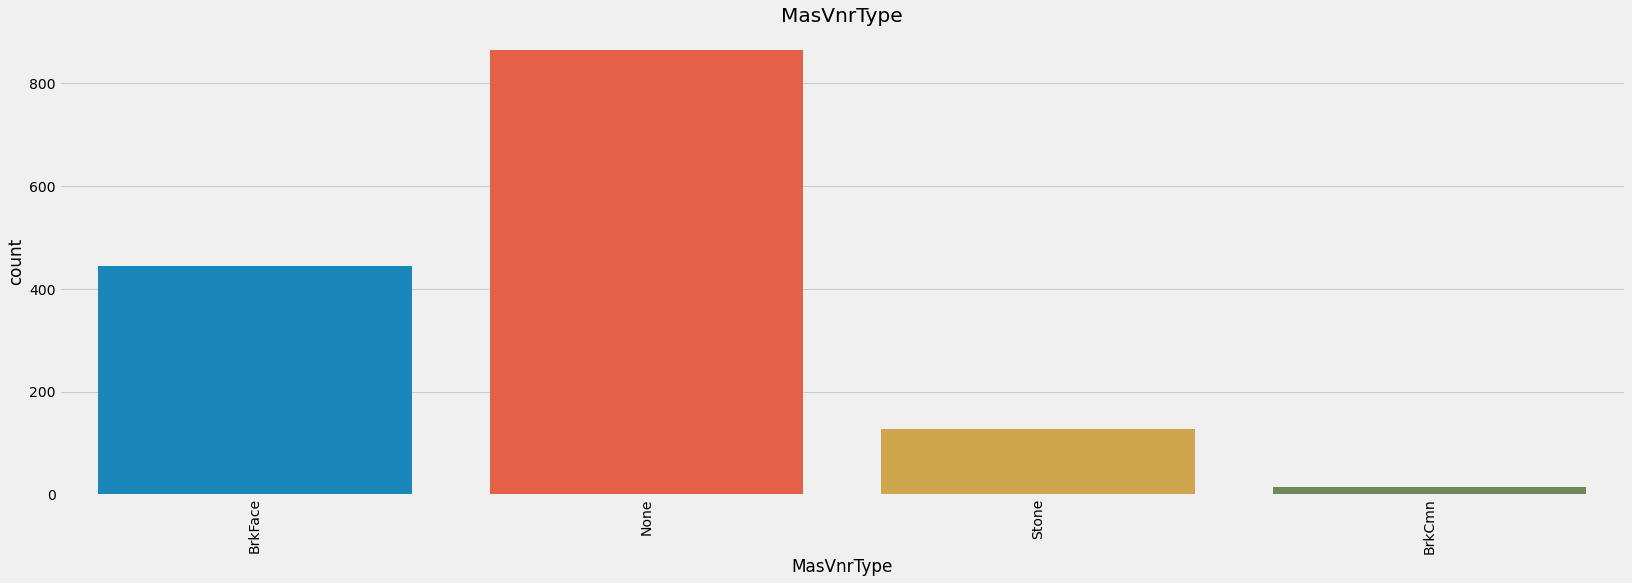

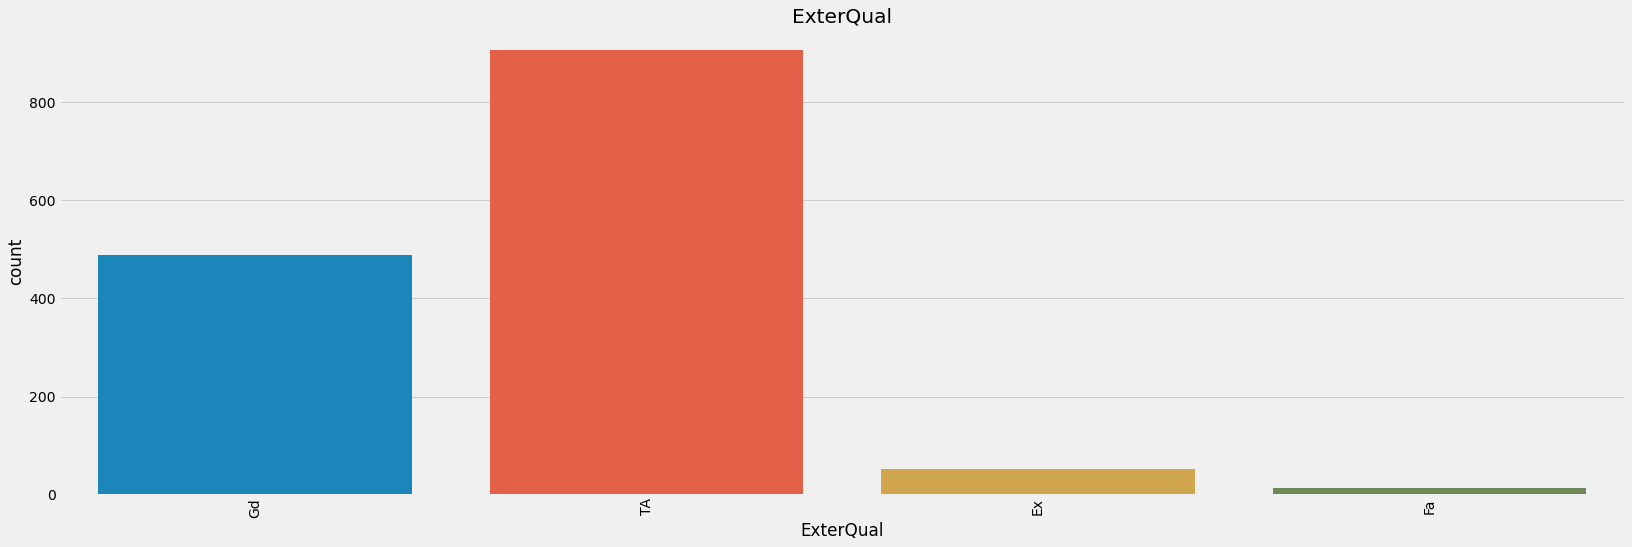

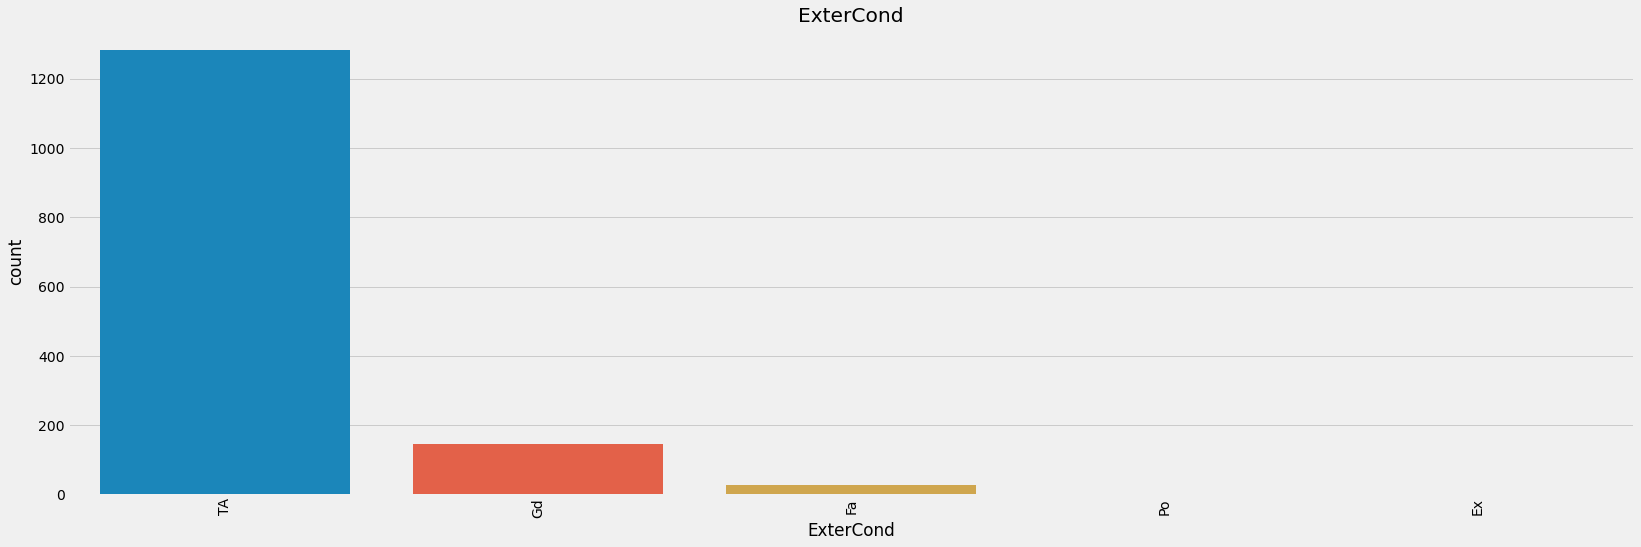

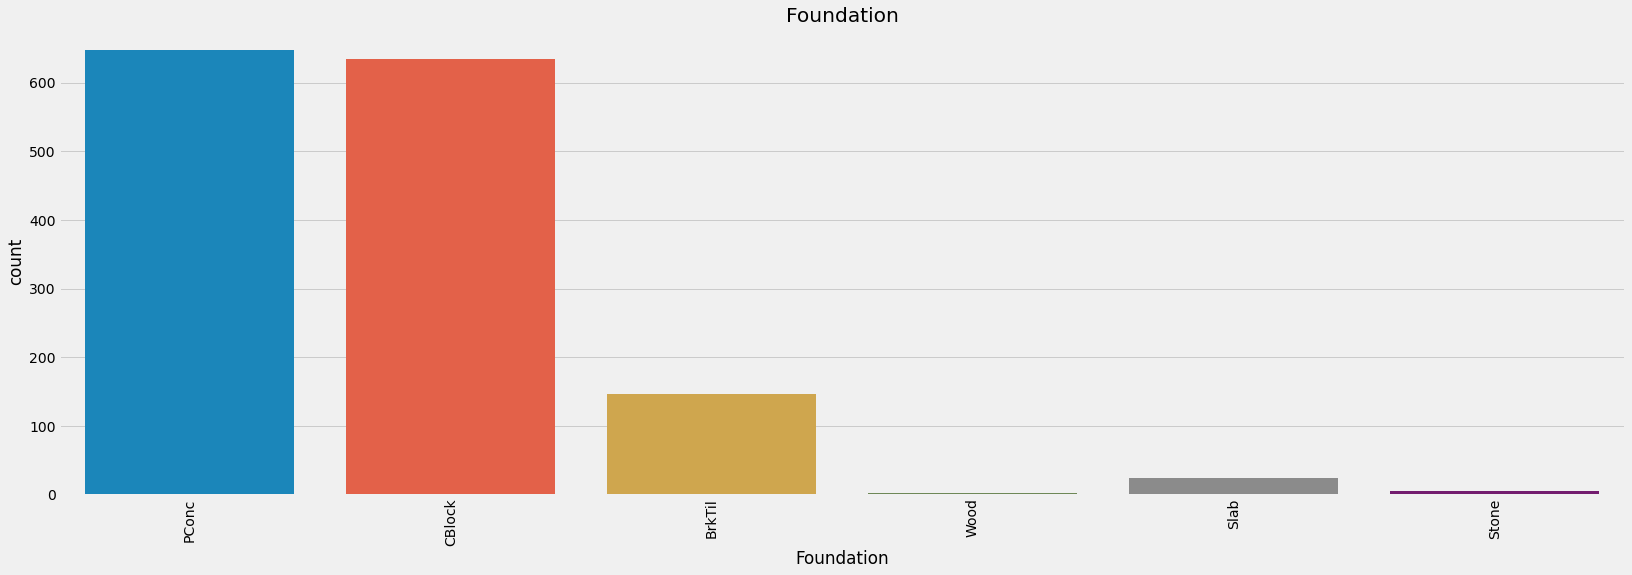

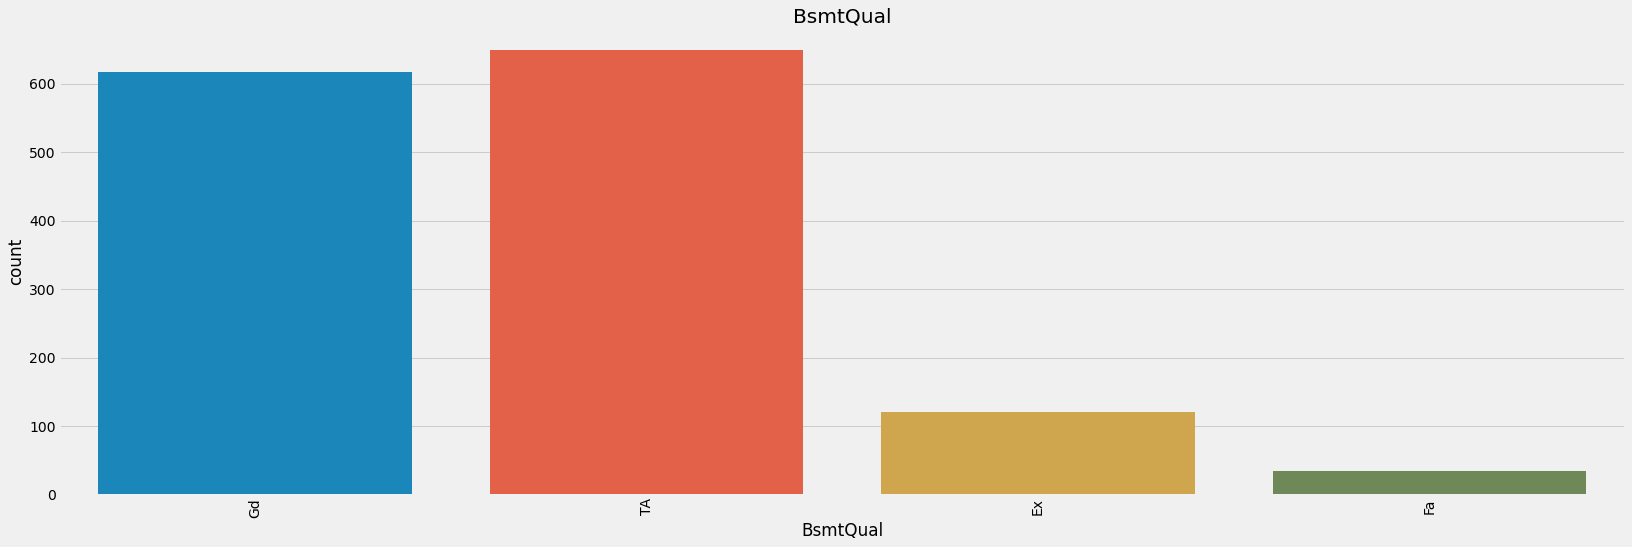

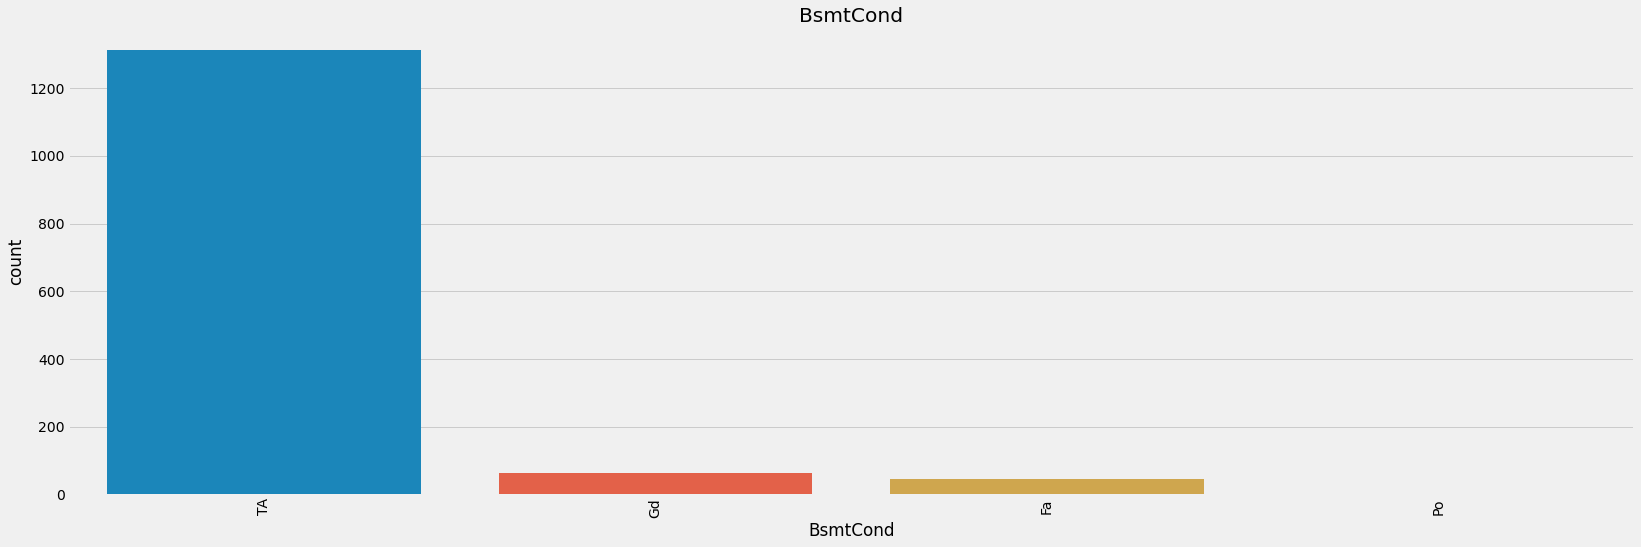

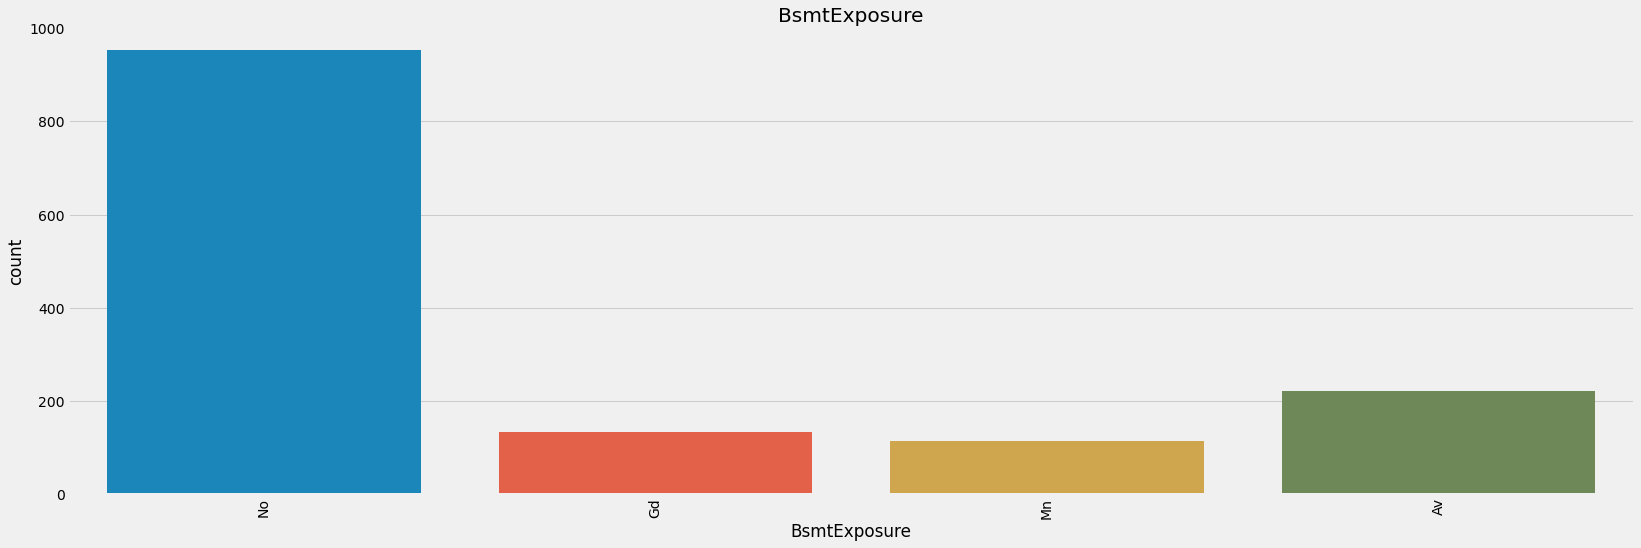

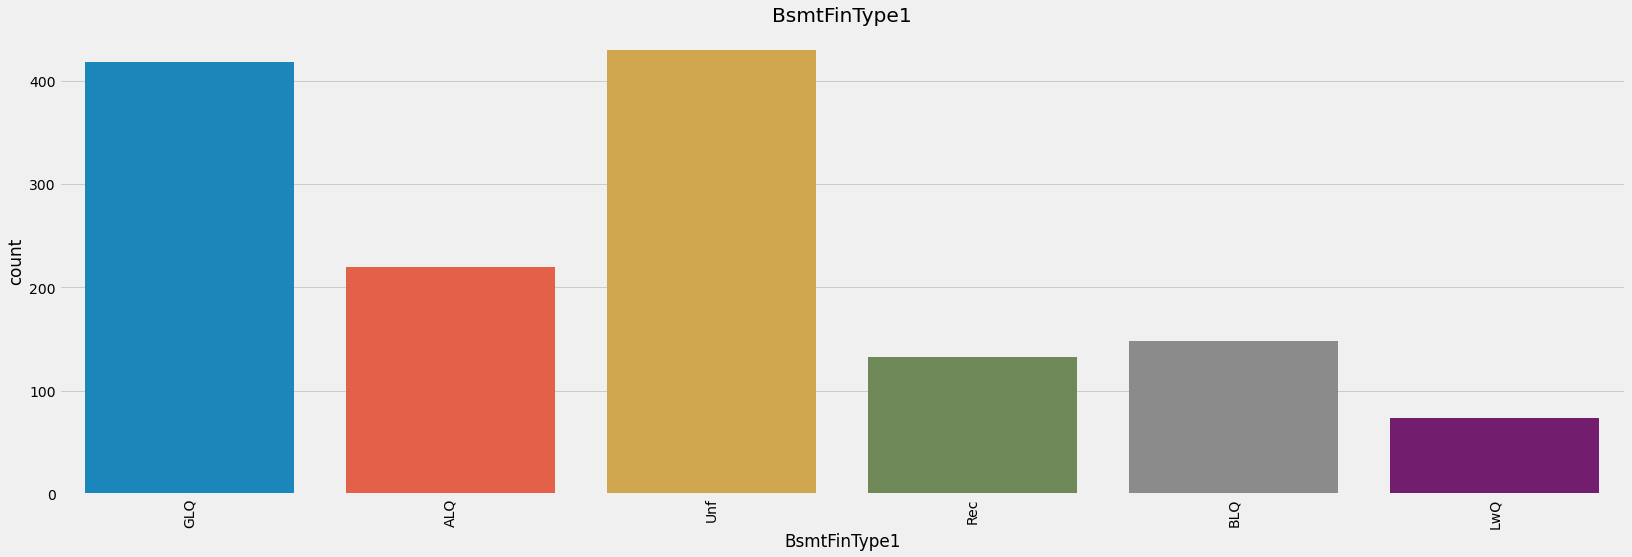

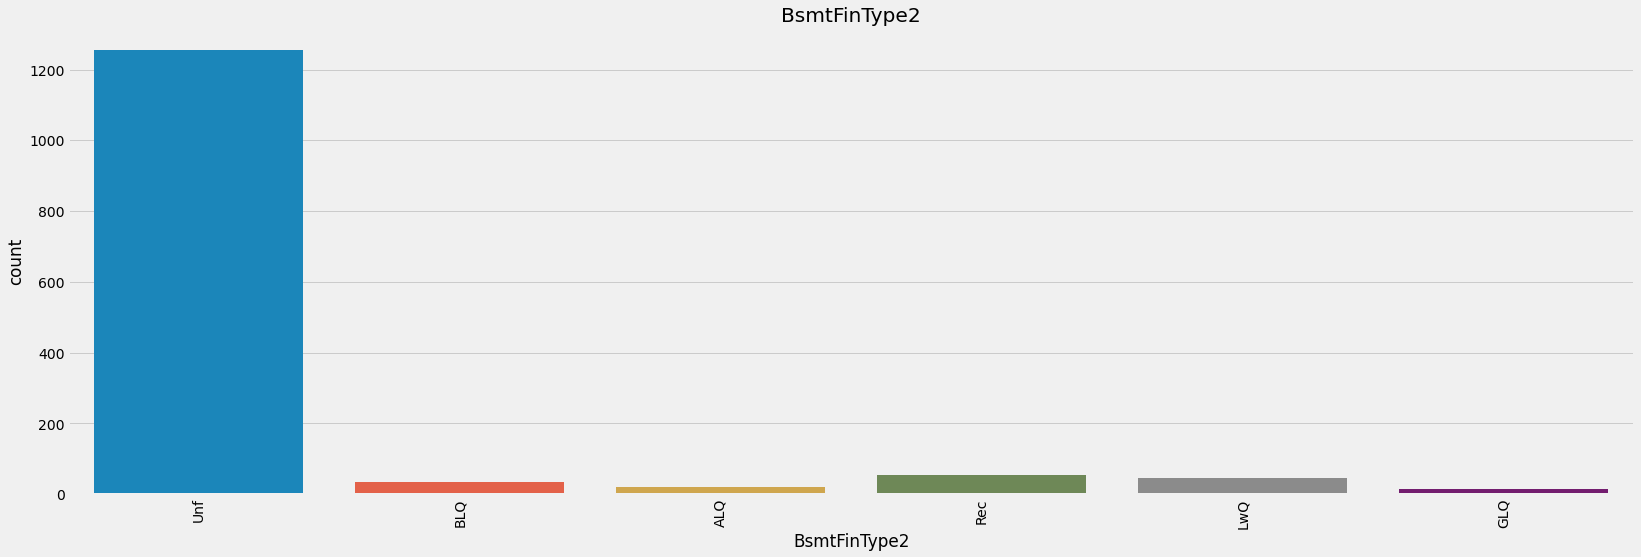

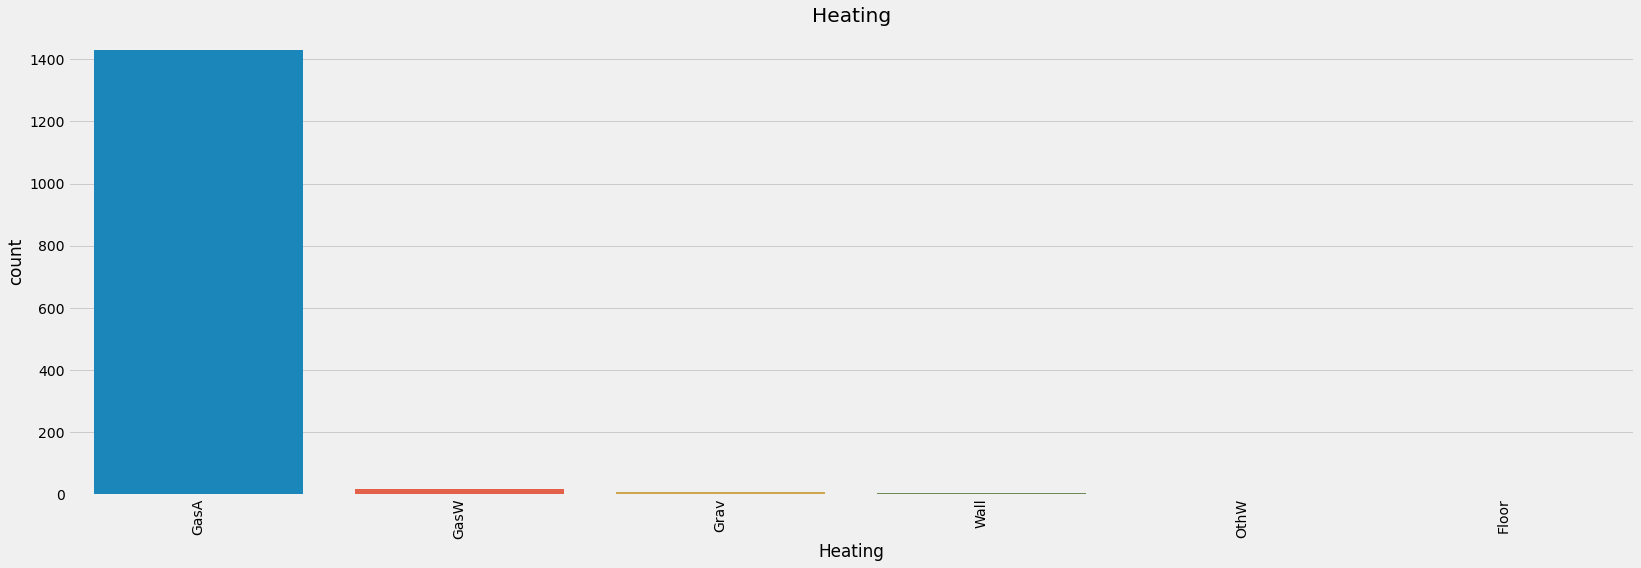

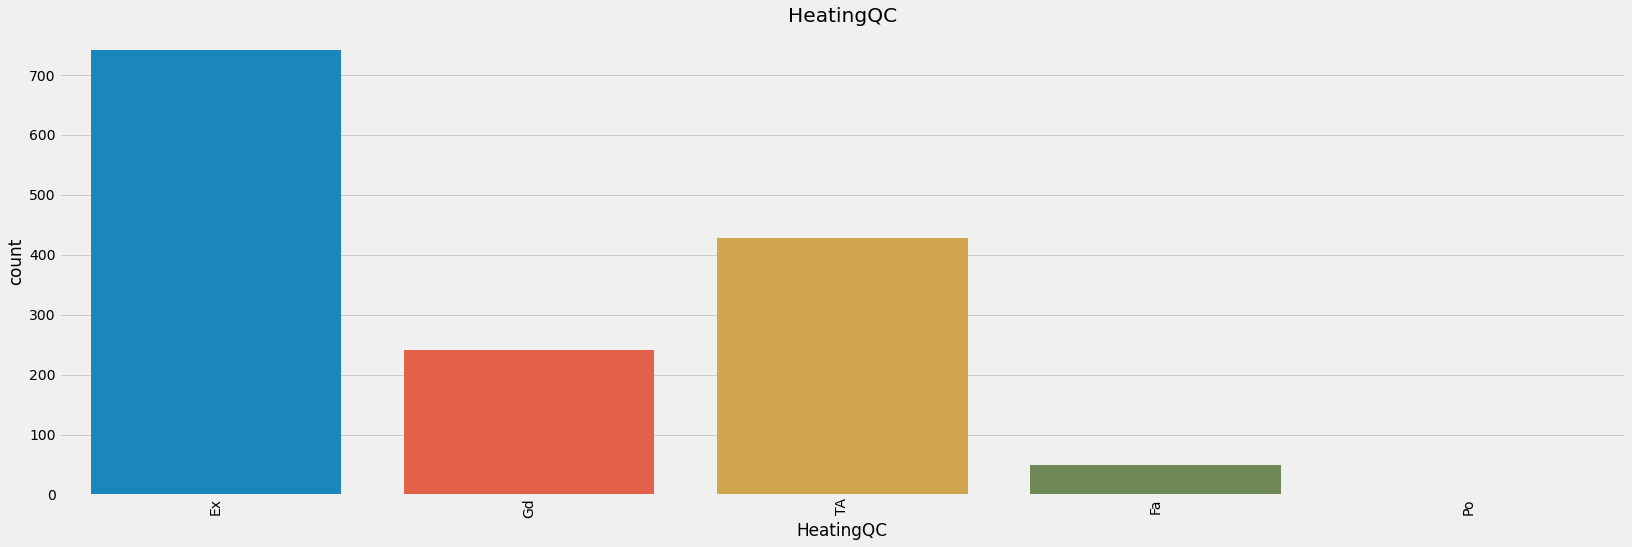

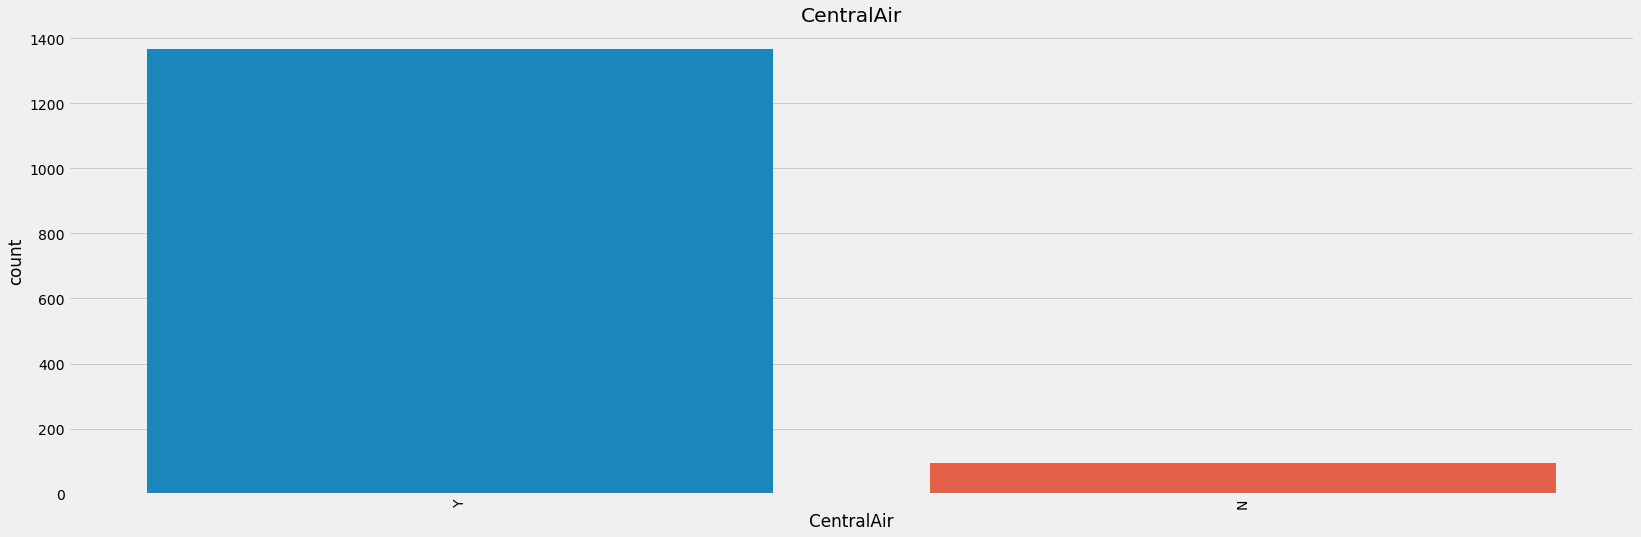

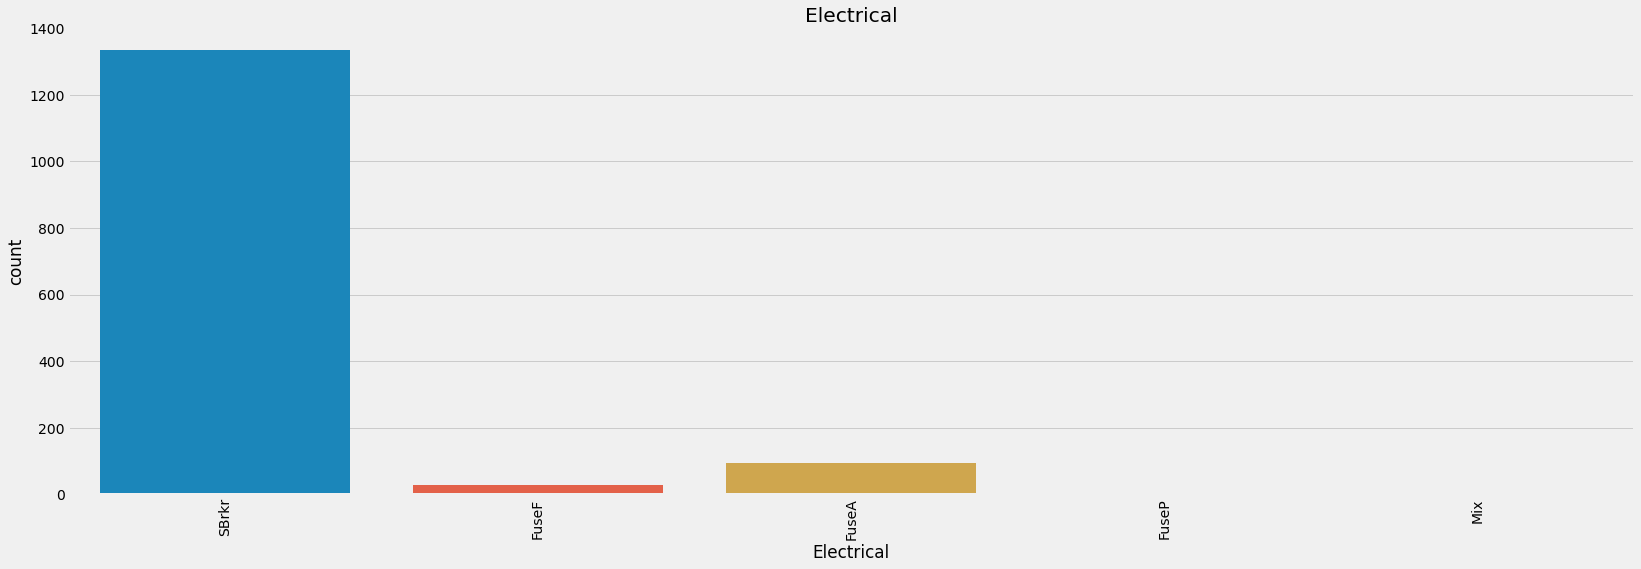

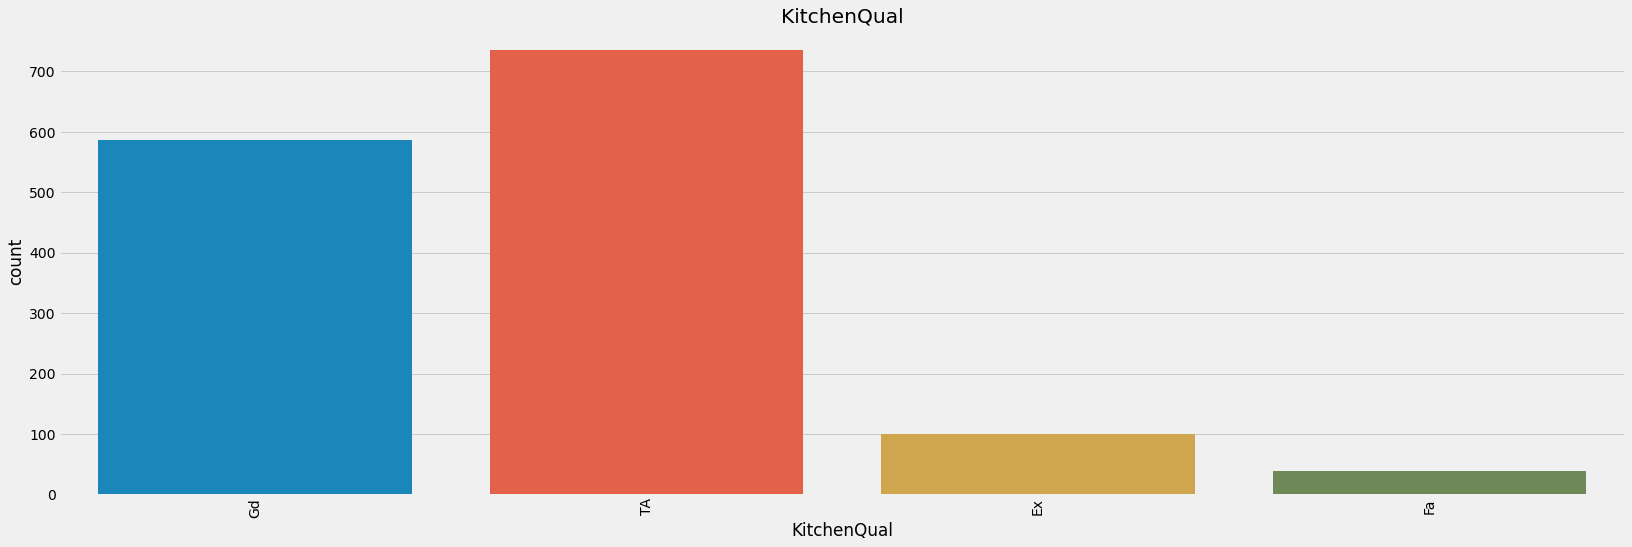

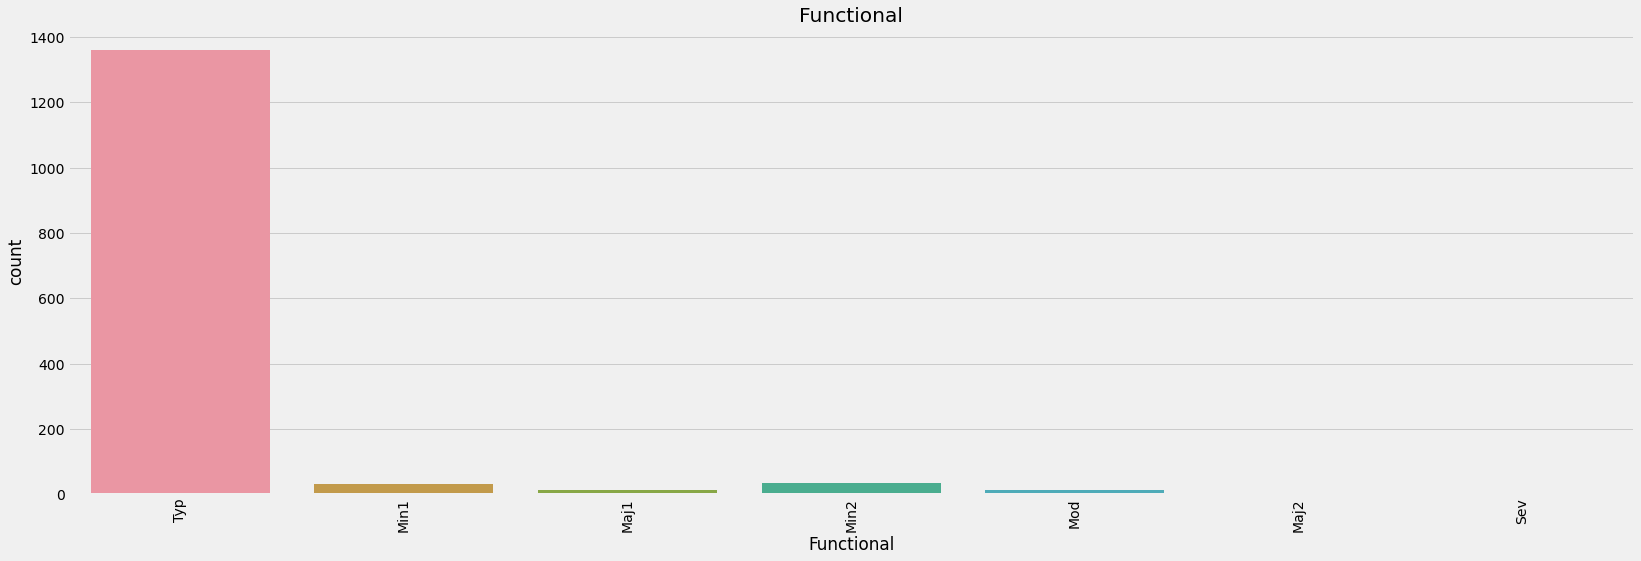

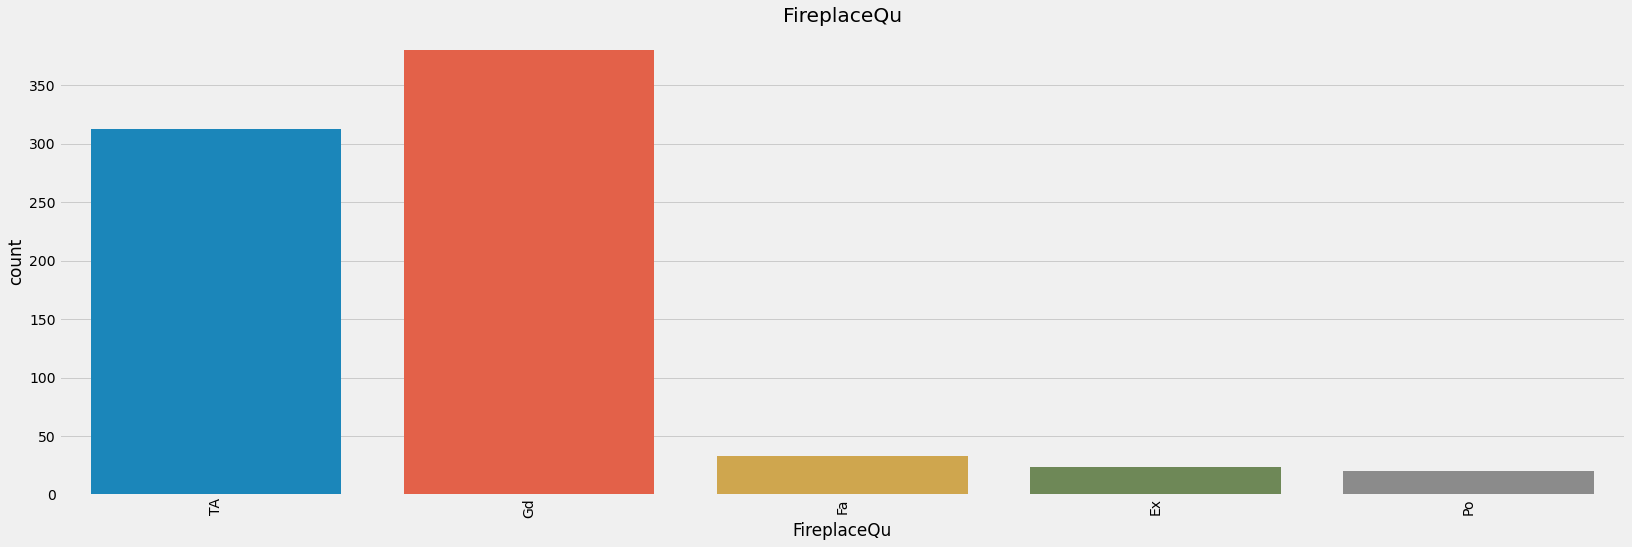

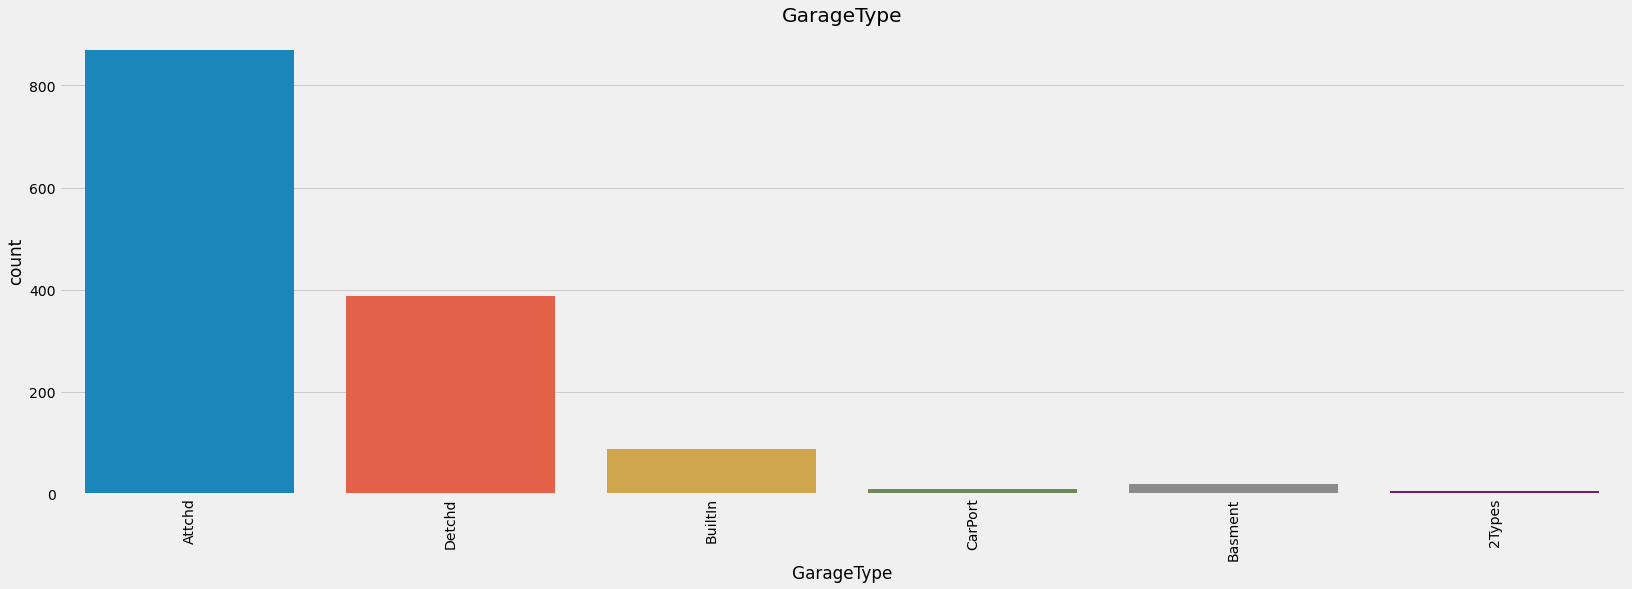

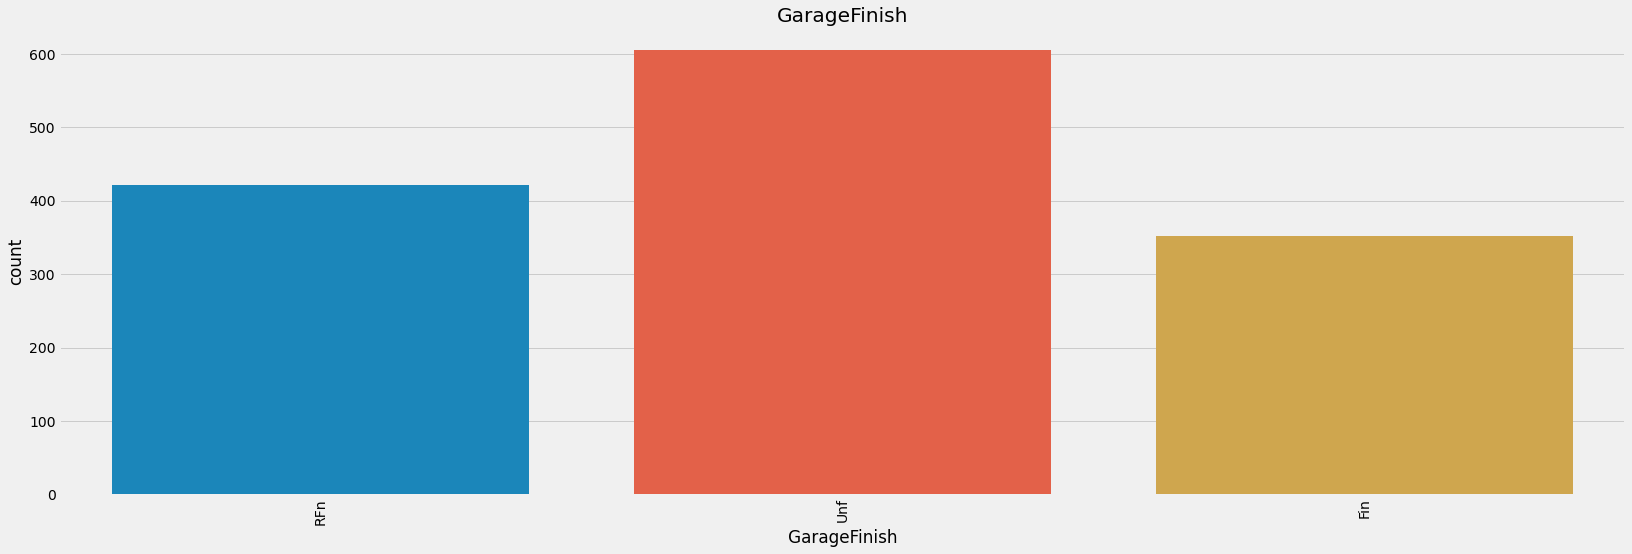

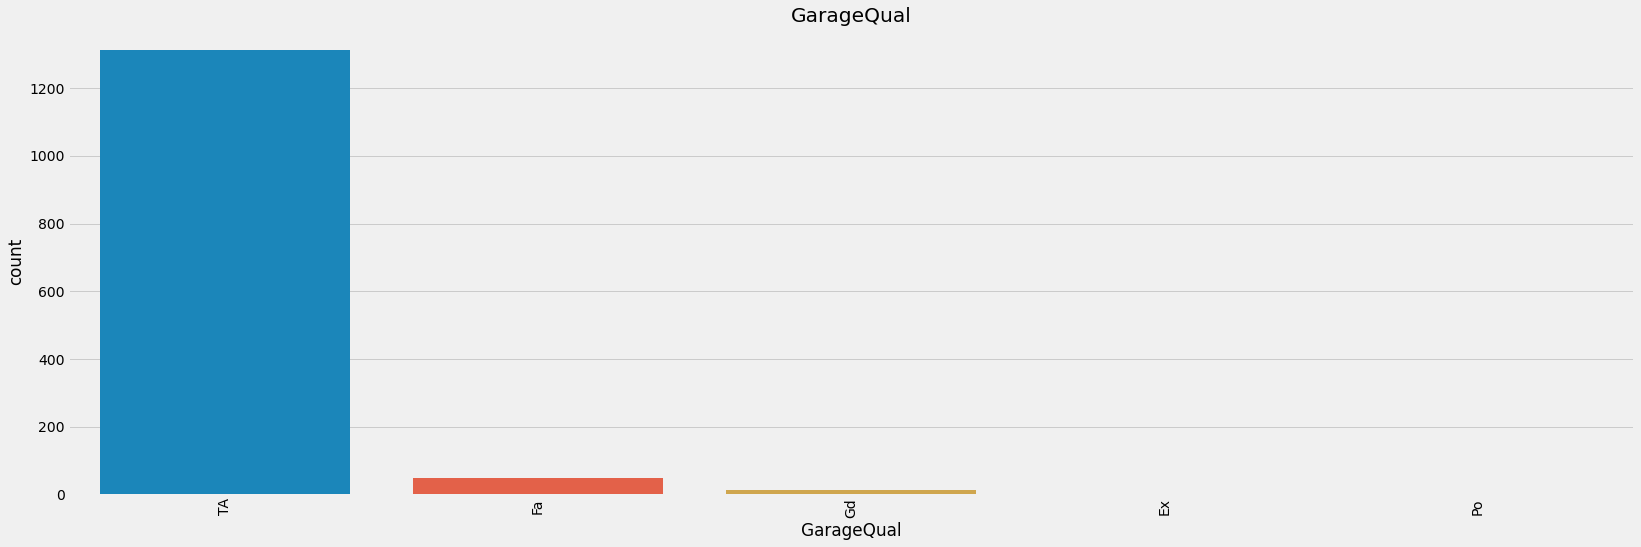

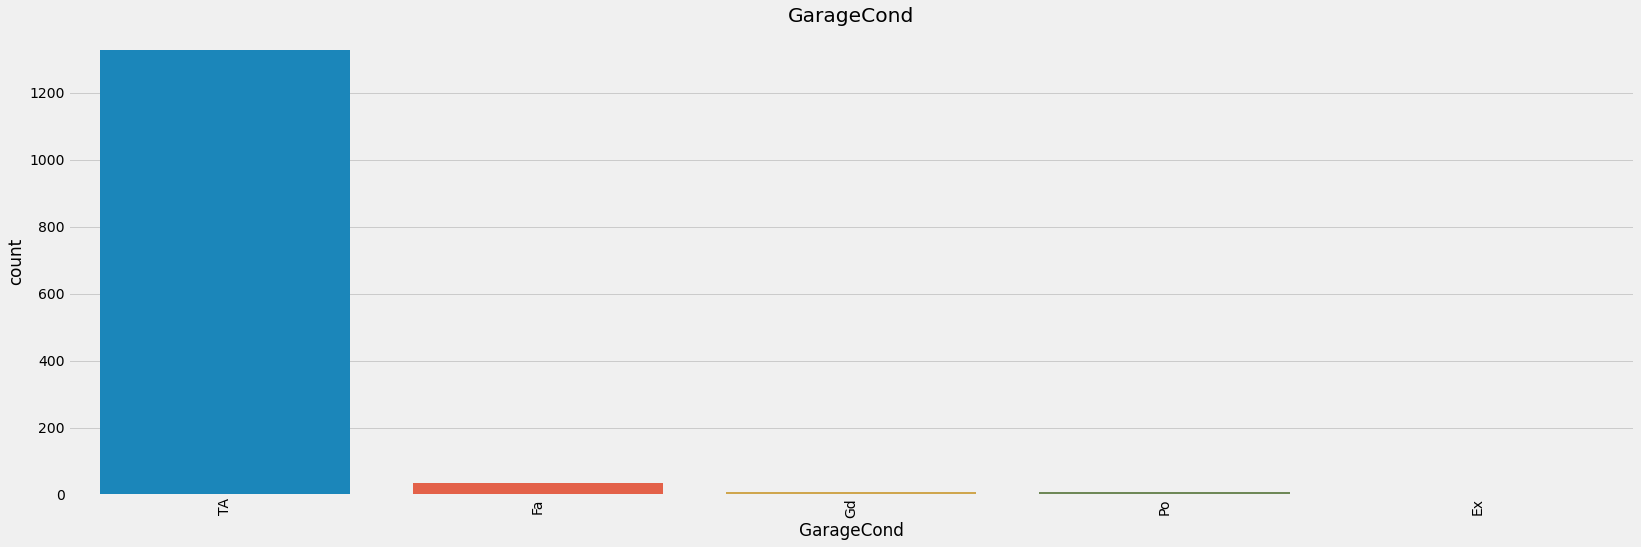

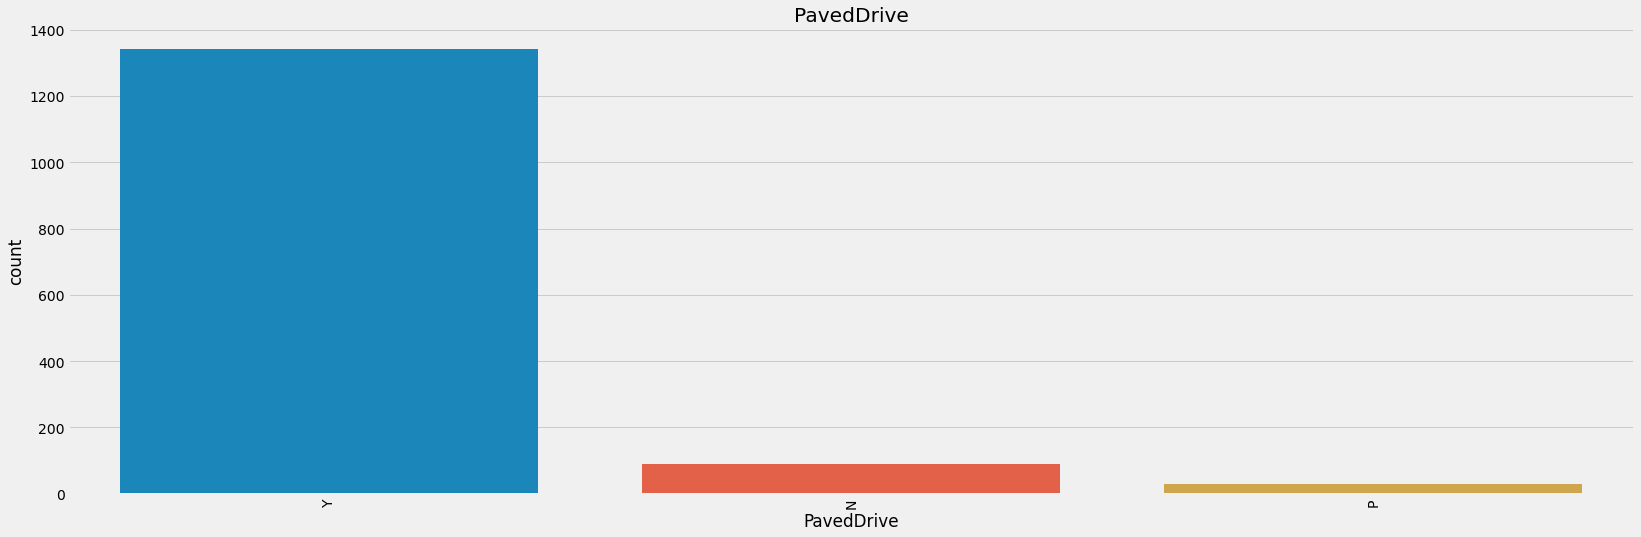

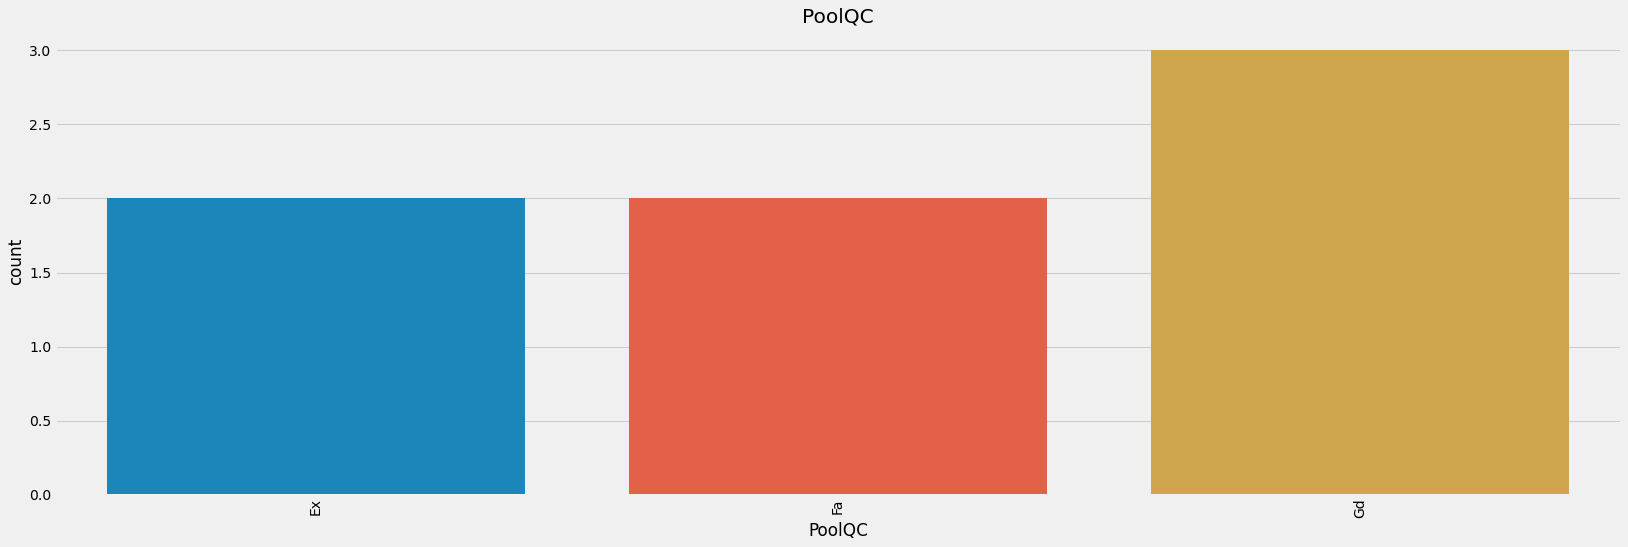

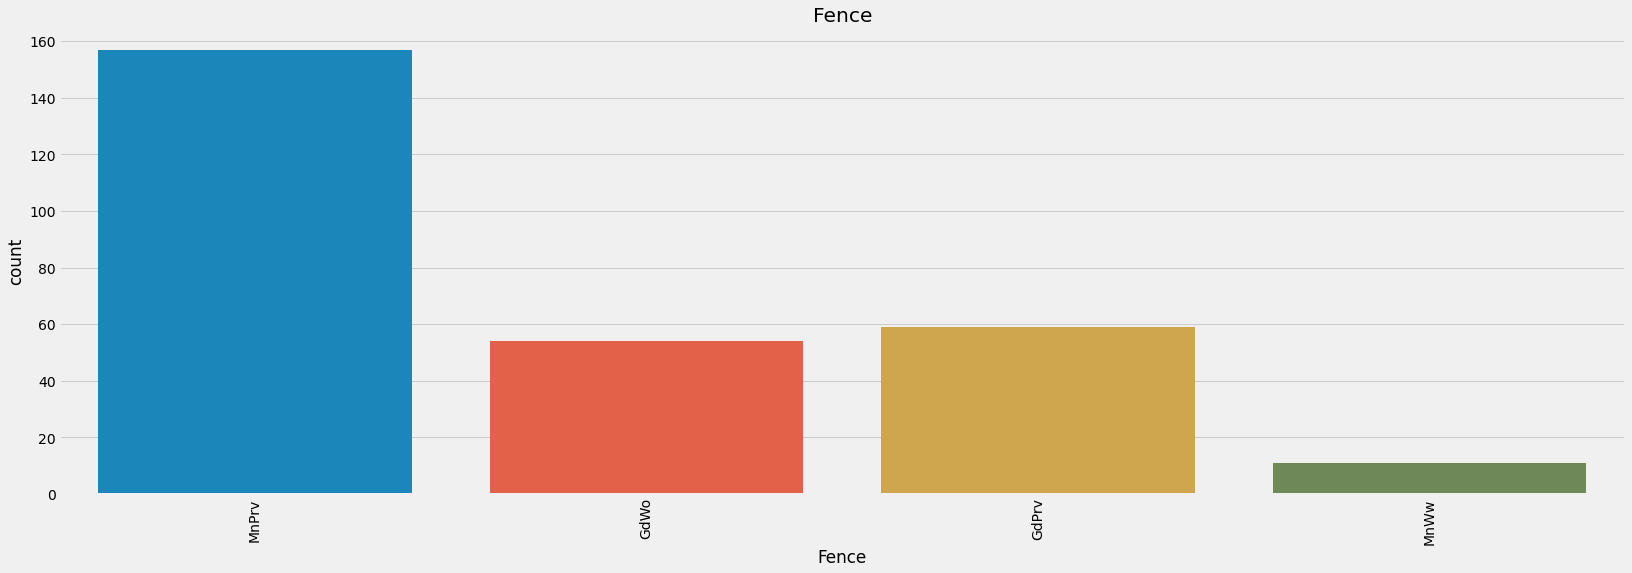

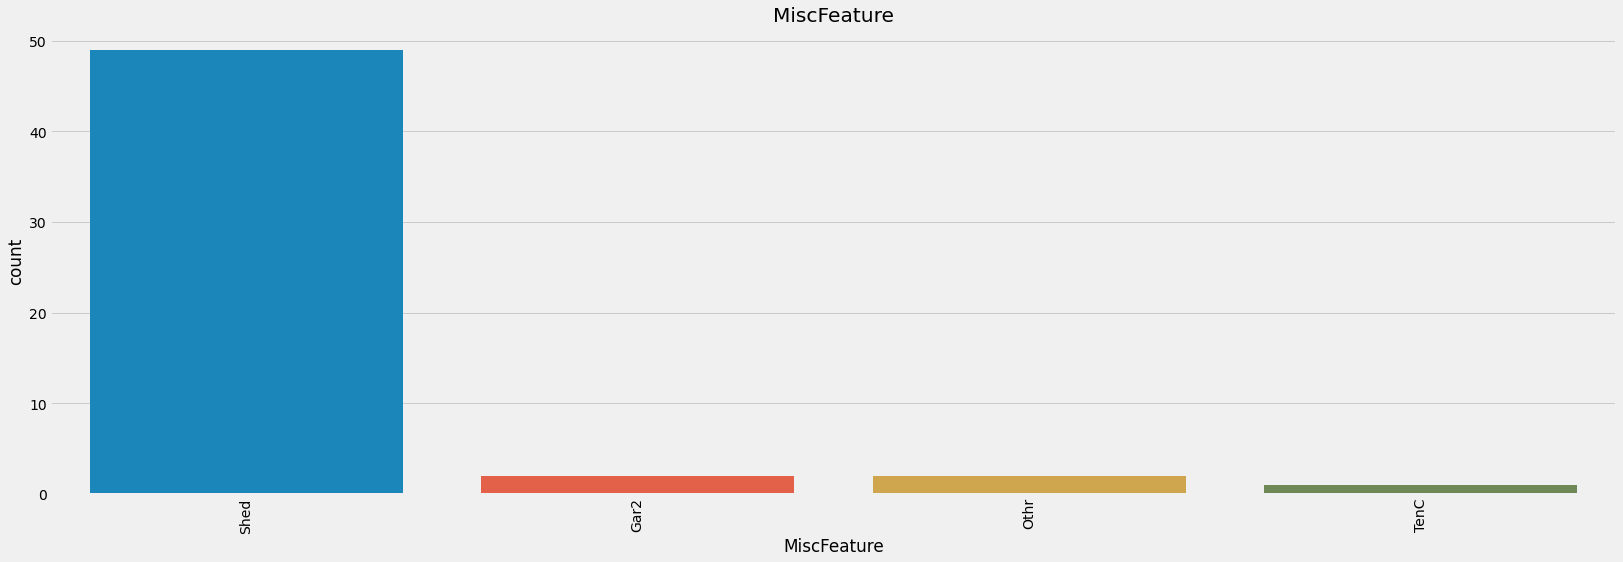

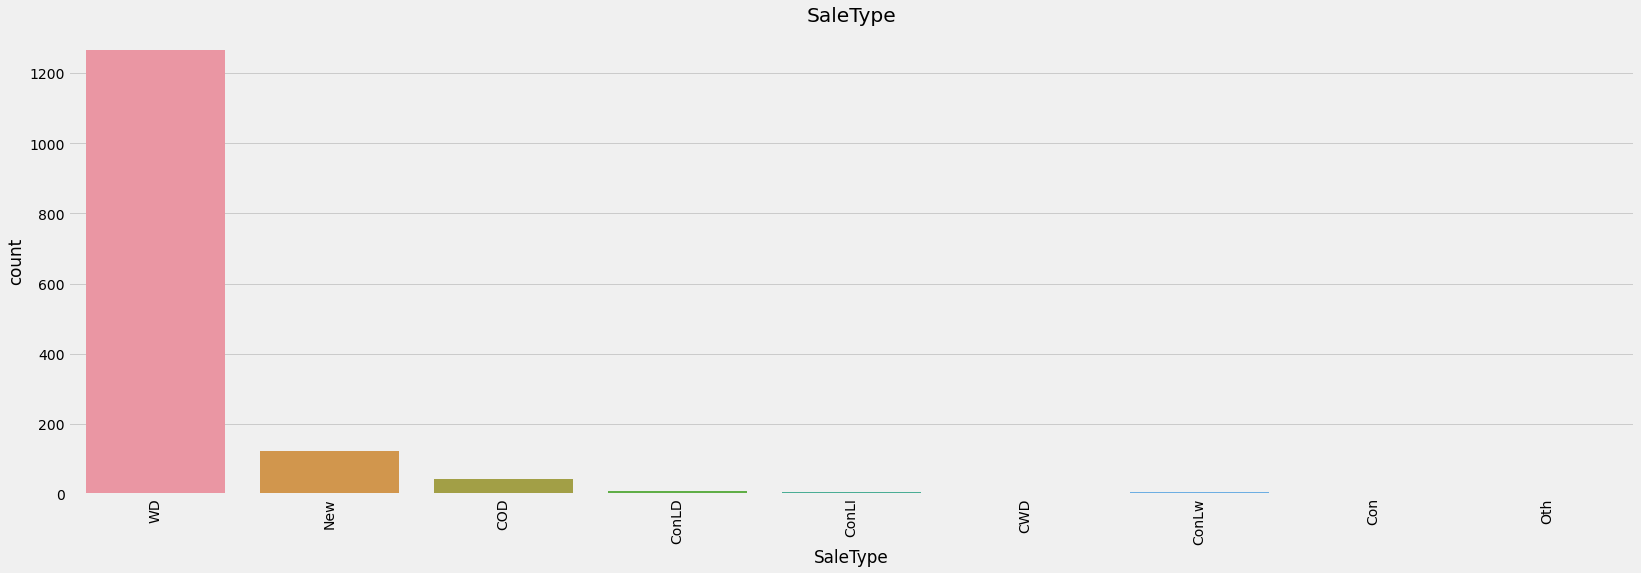

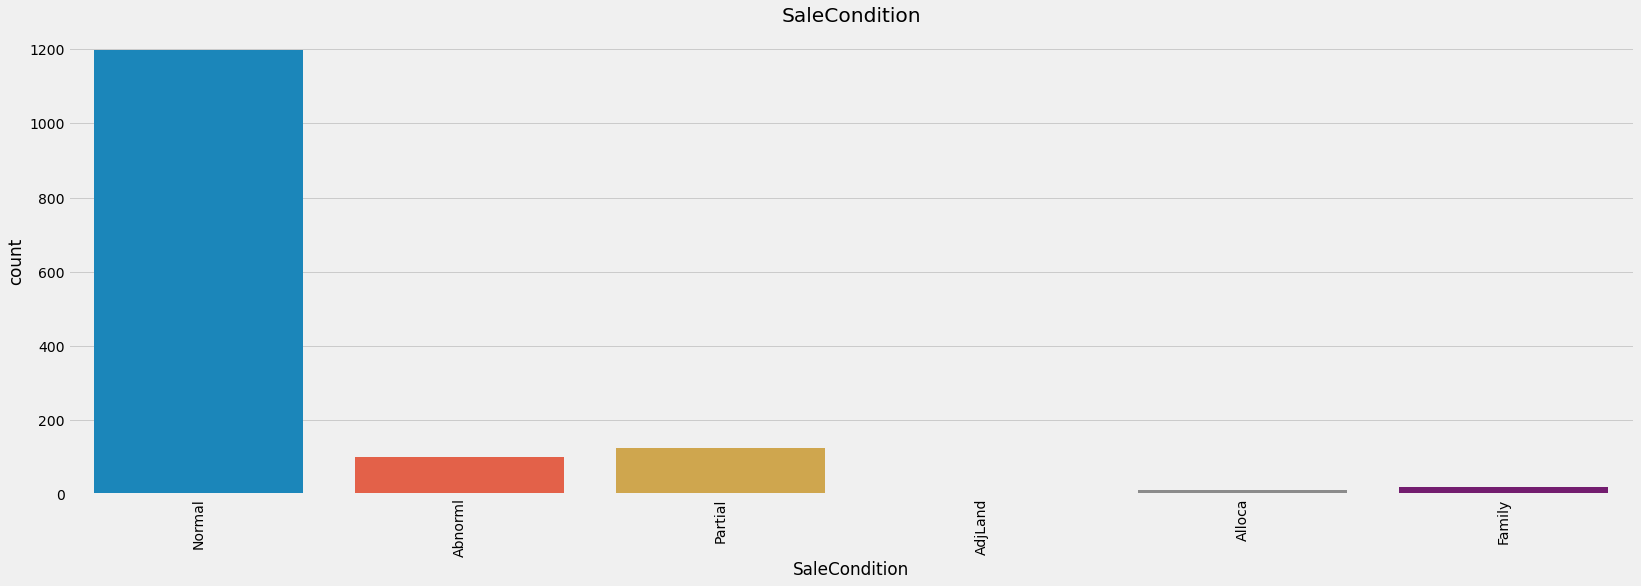

In [291]:
print('Count plot of categorical features')
for n in new_cat:
    cat_plot(n)

Distribution of SalePrice according to classes of categorical features


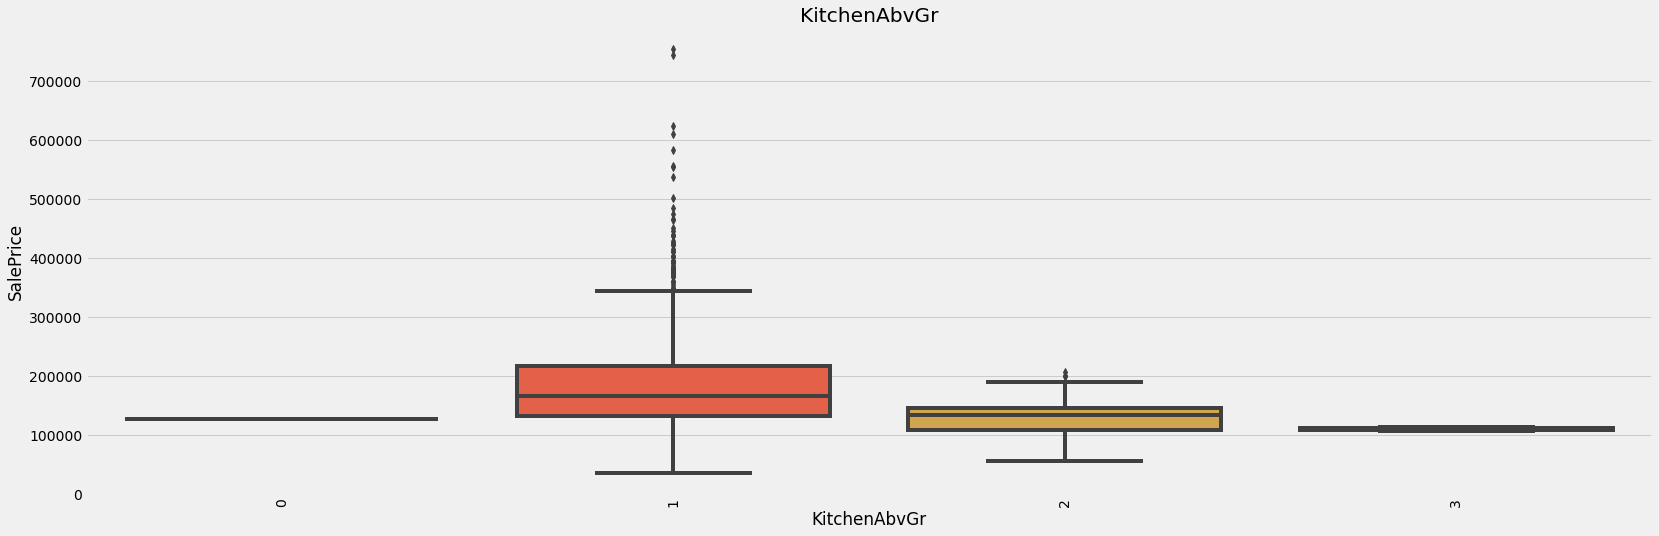

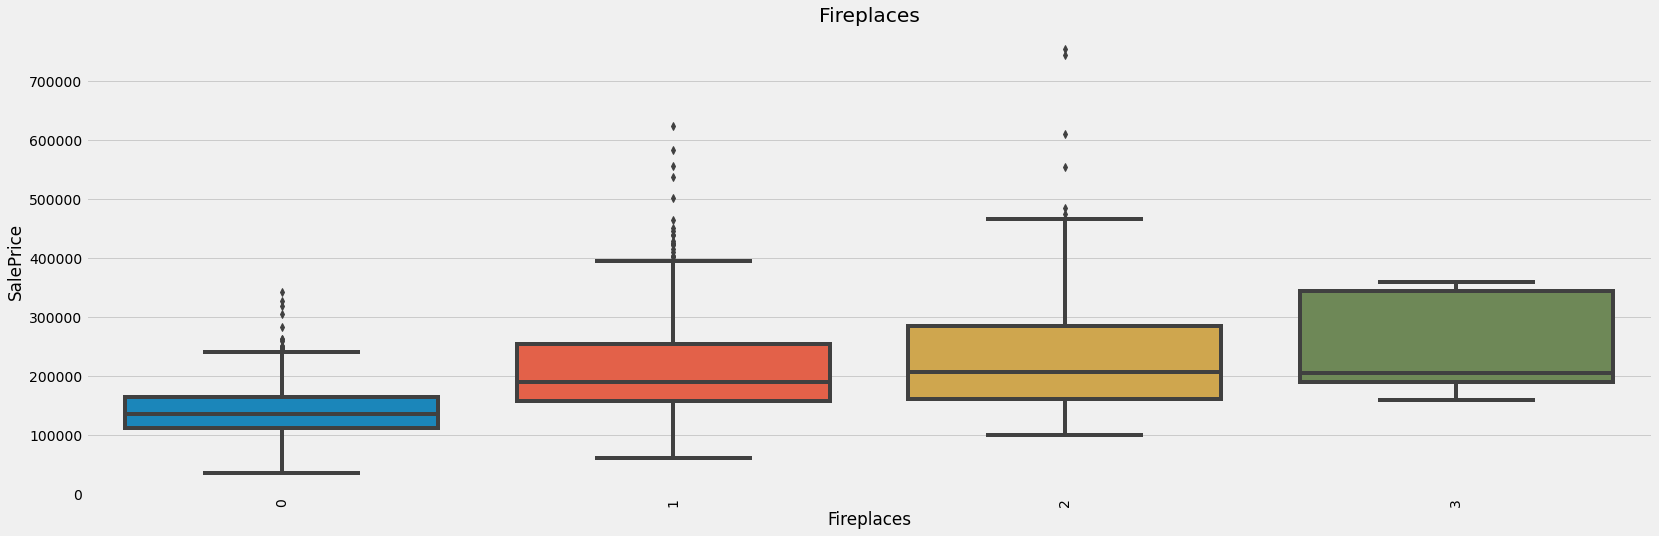

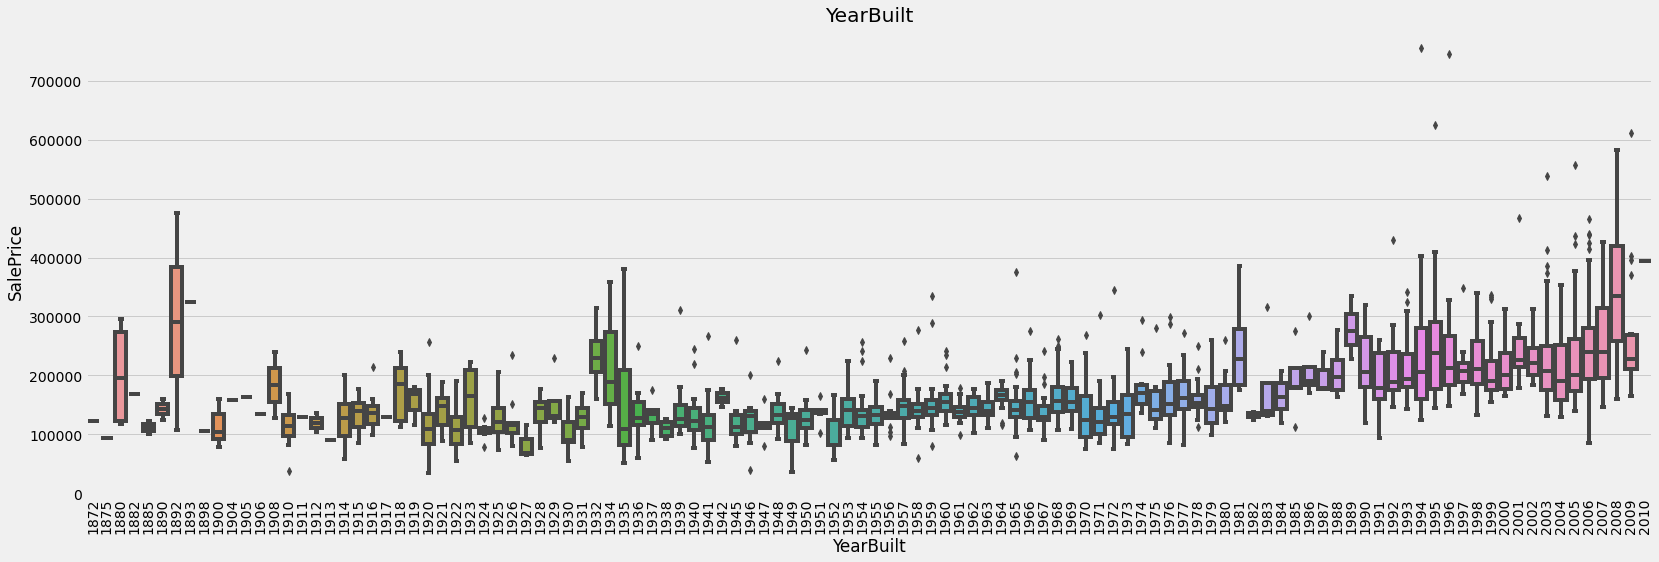

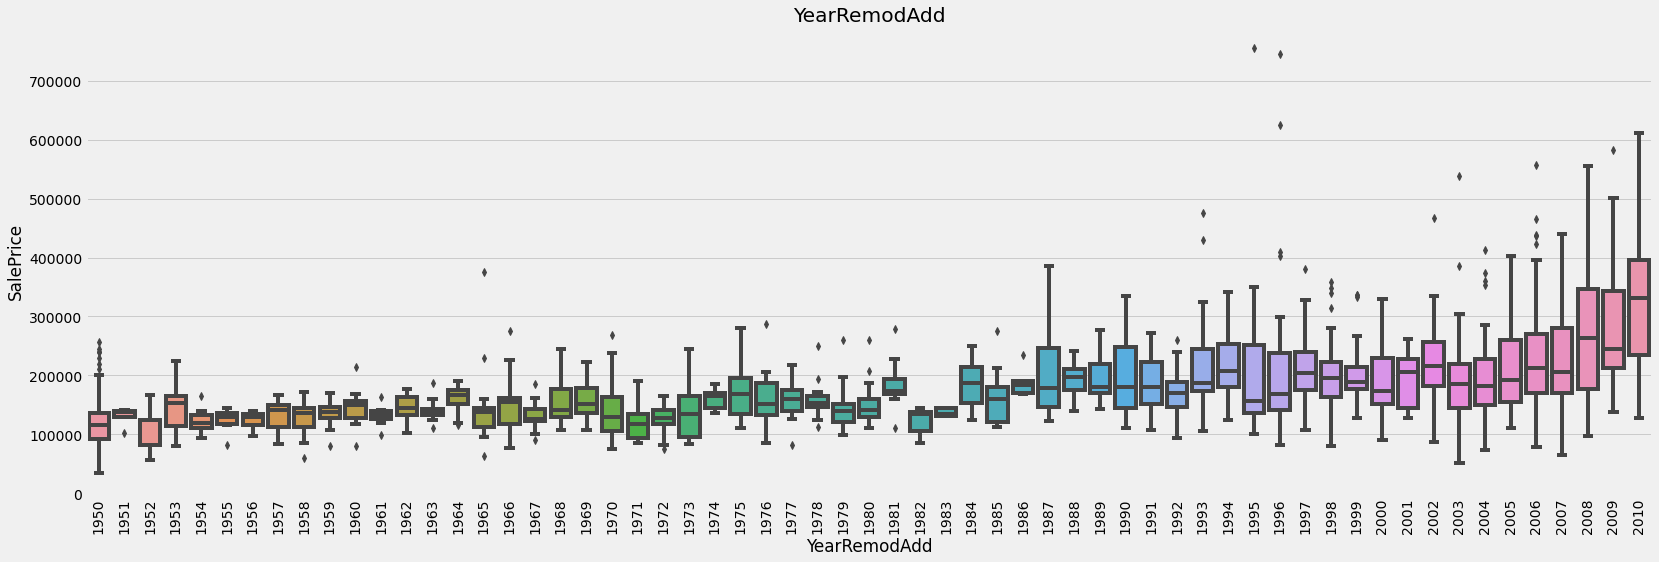

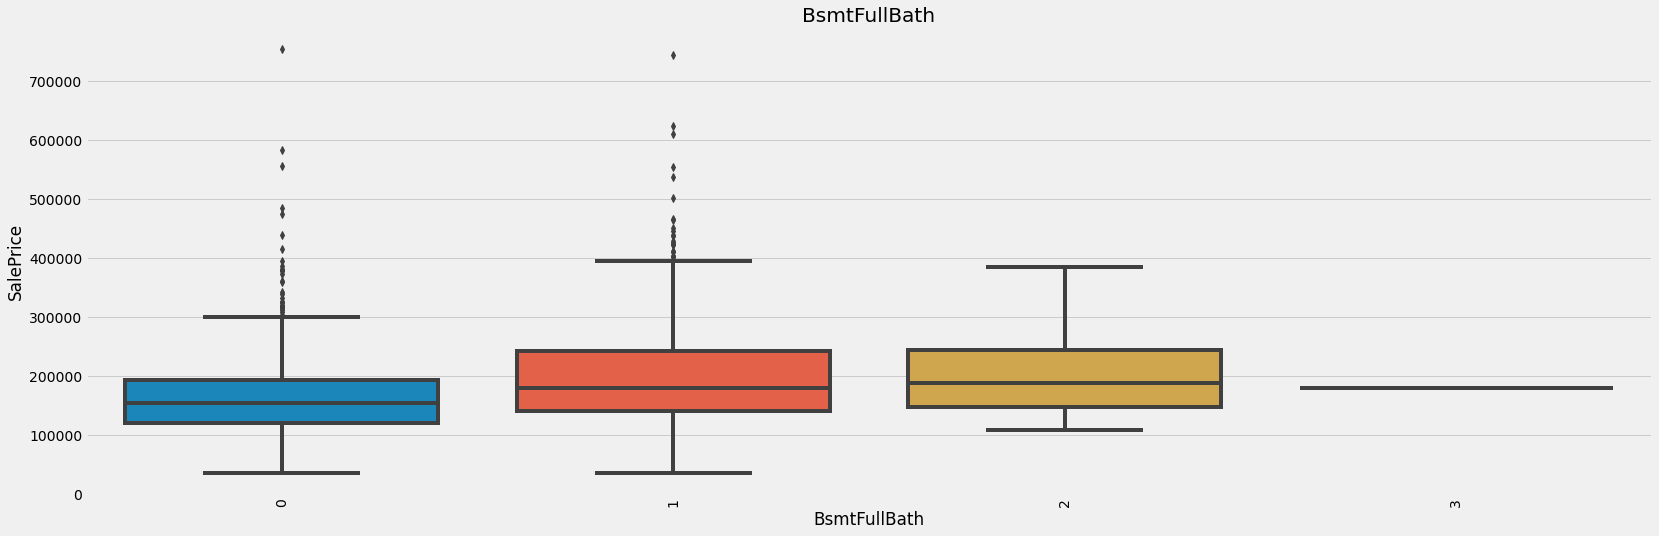

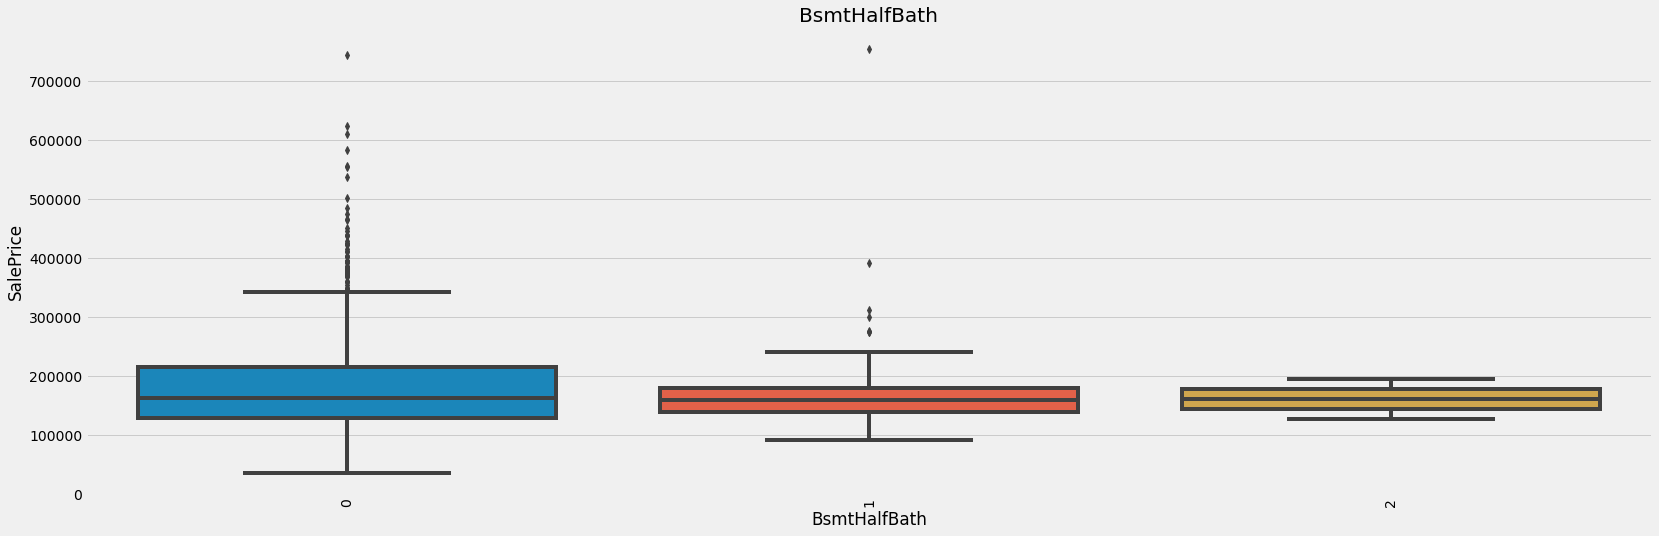

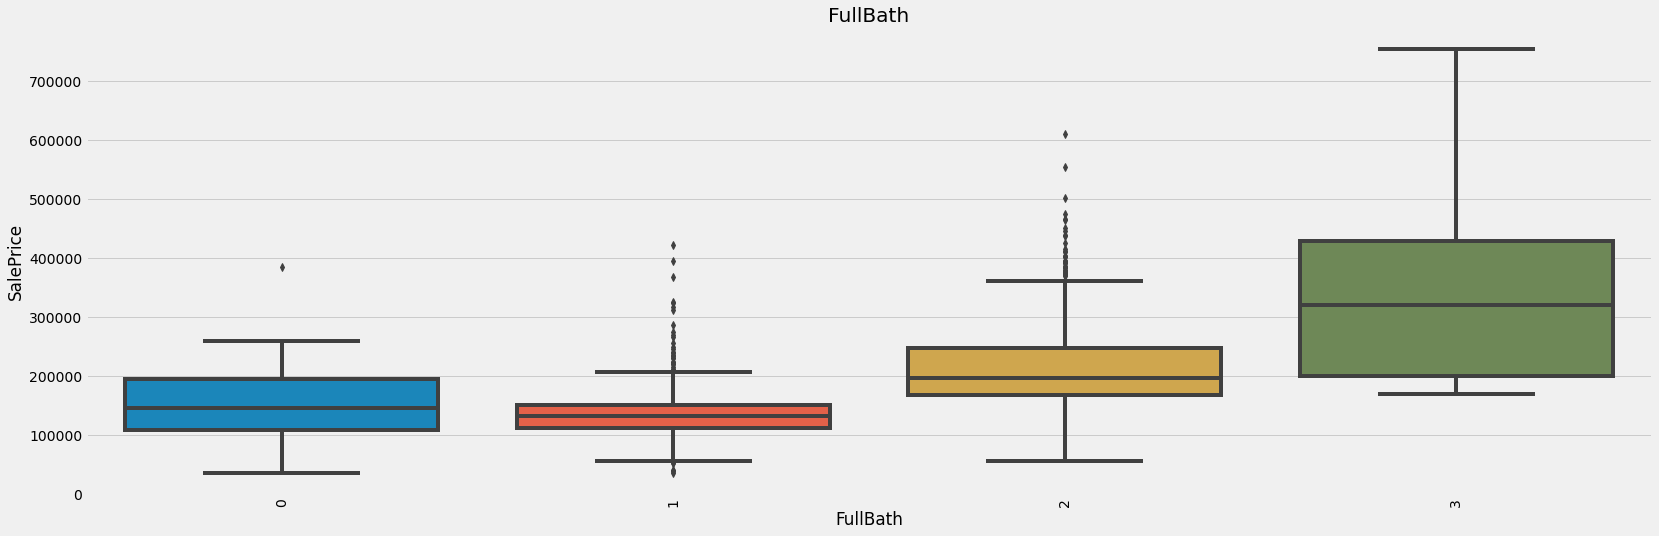

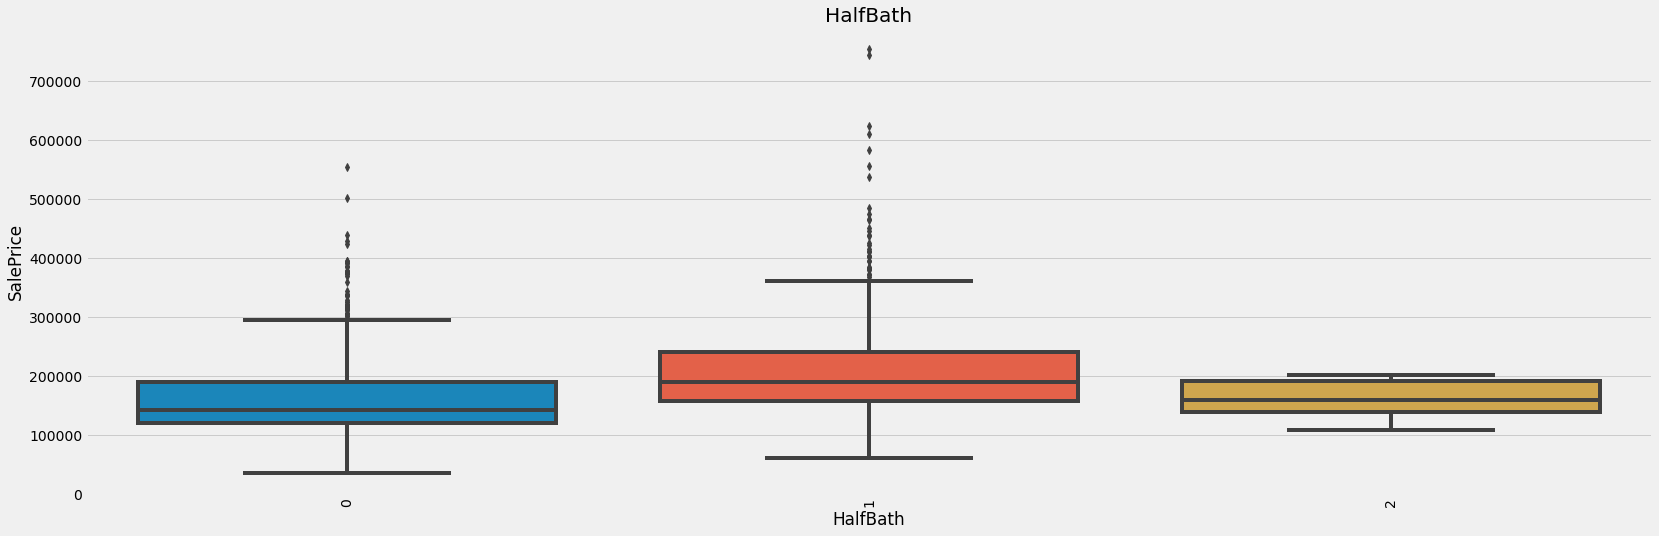

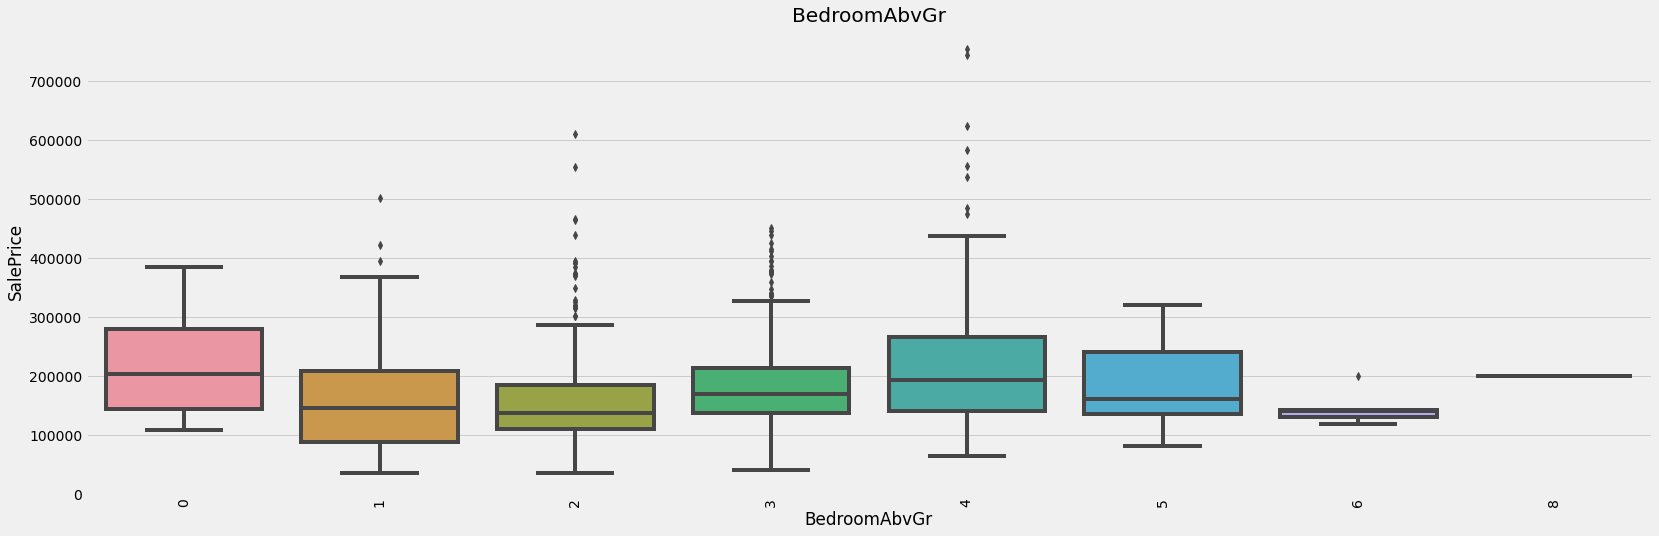

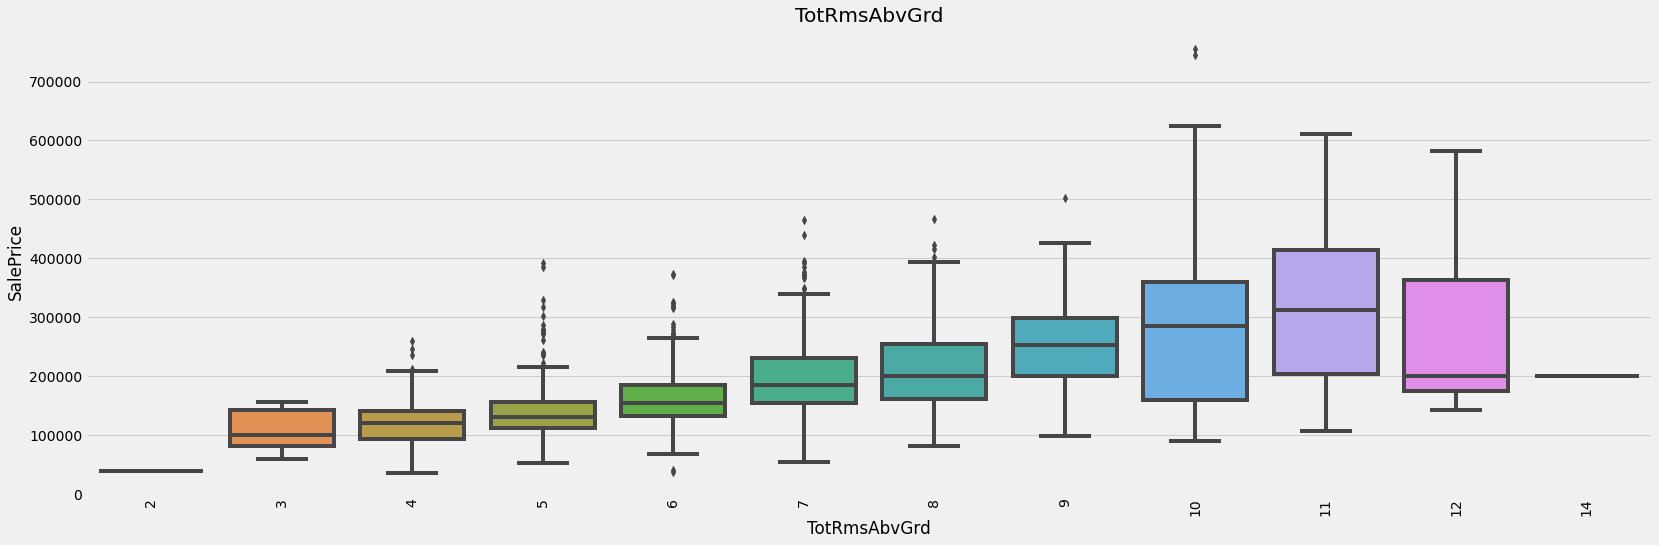

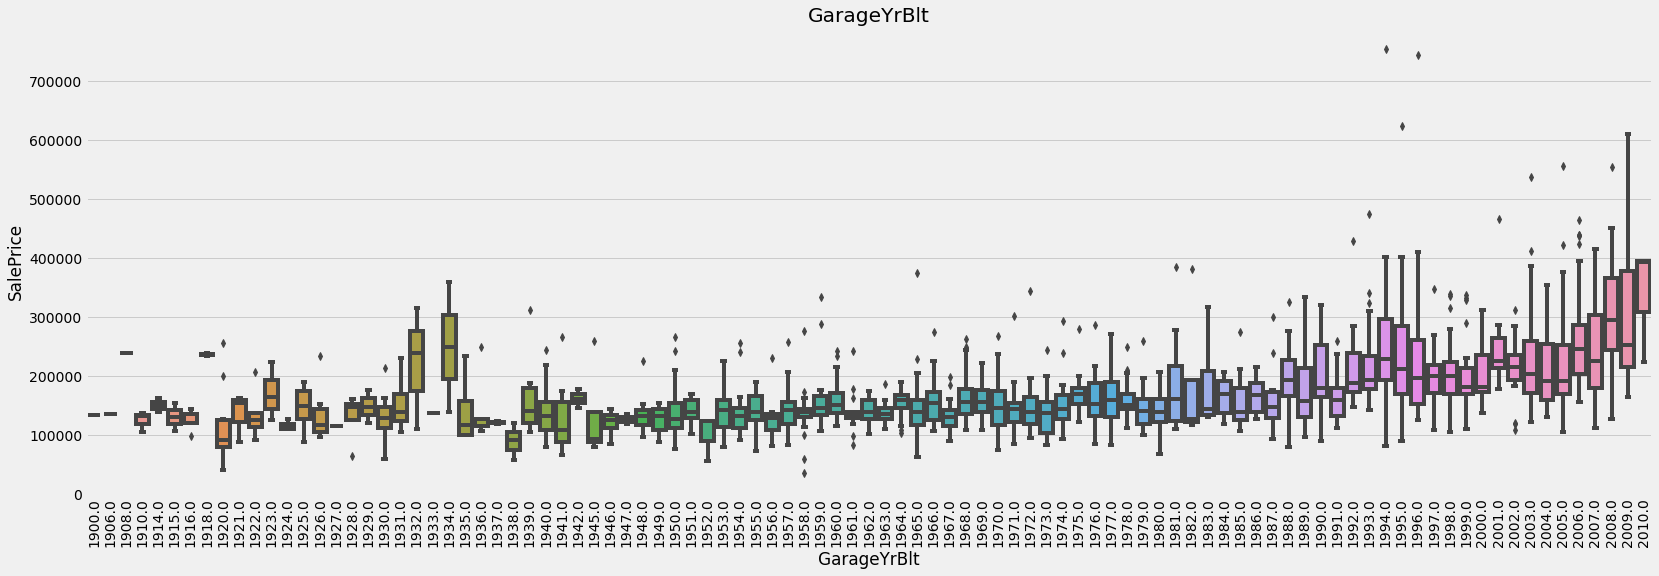

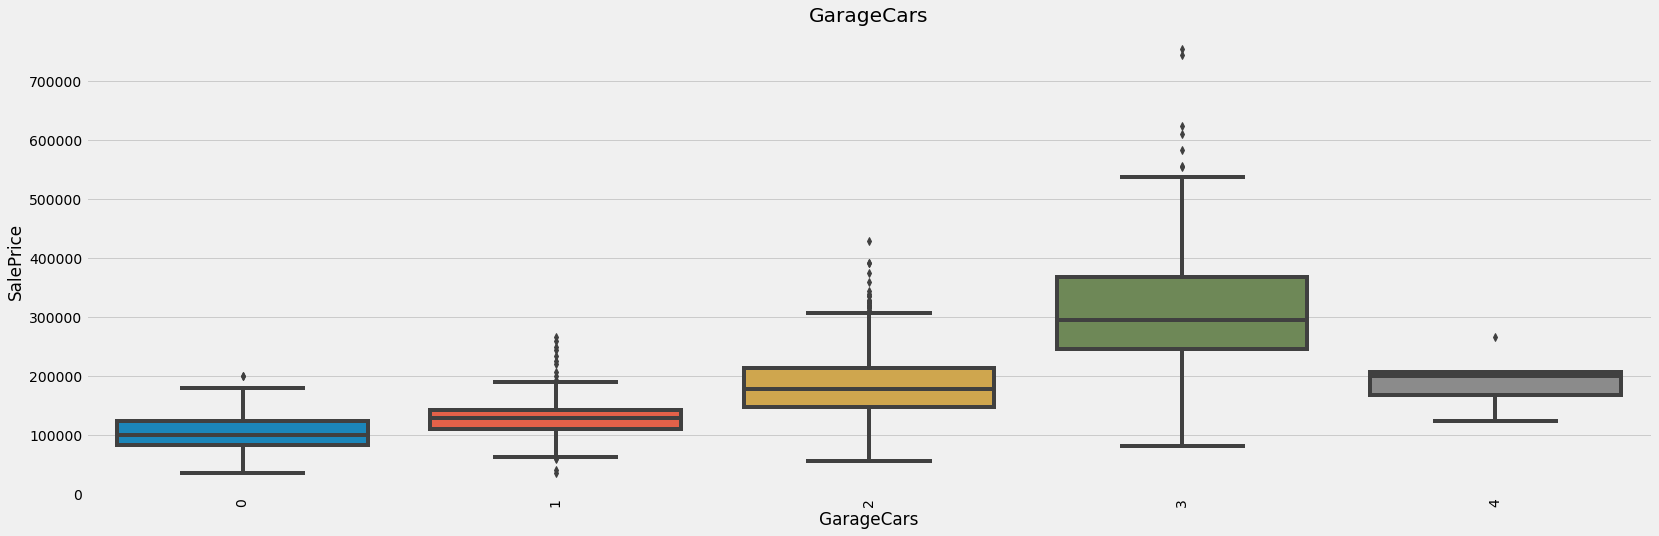

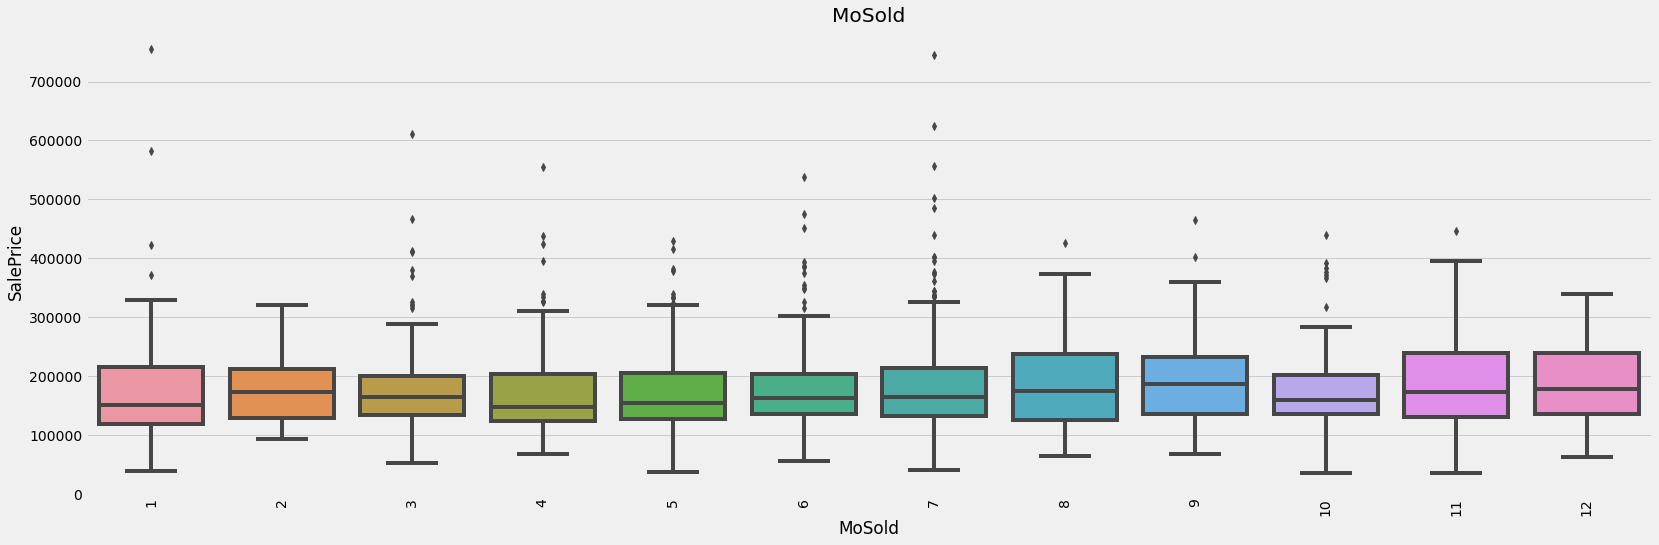

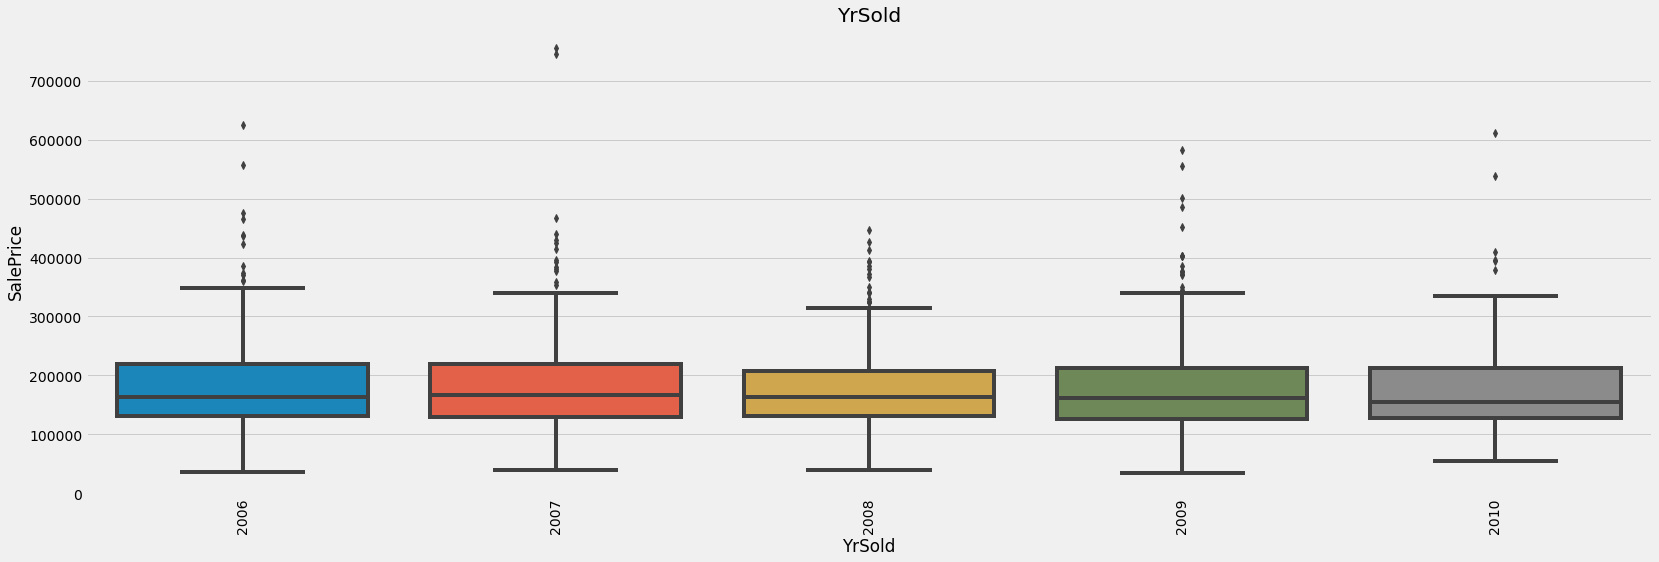

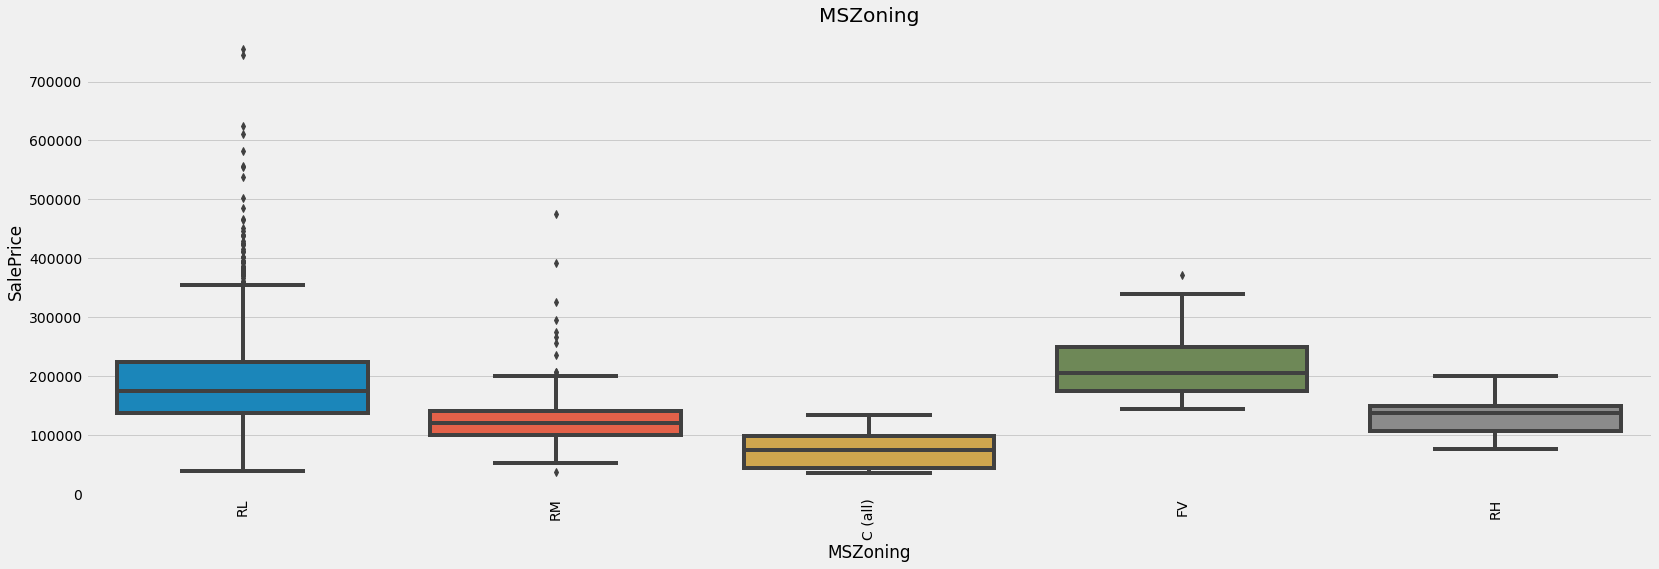

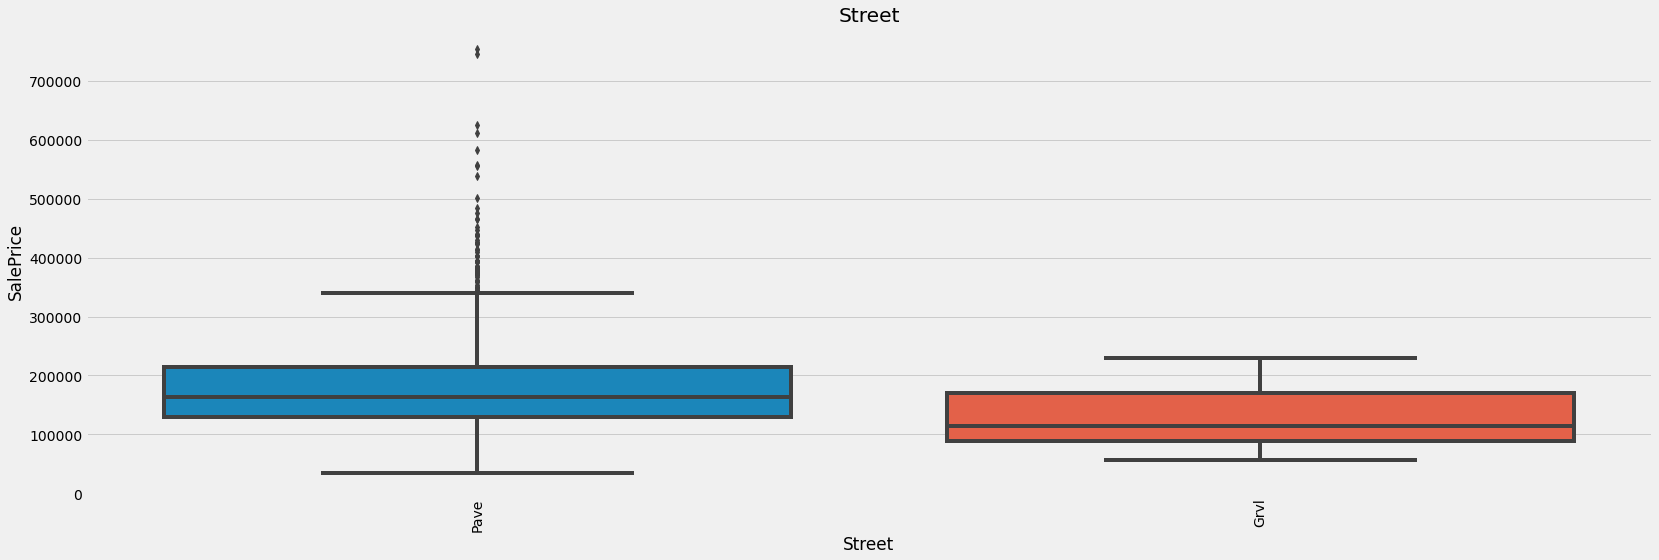

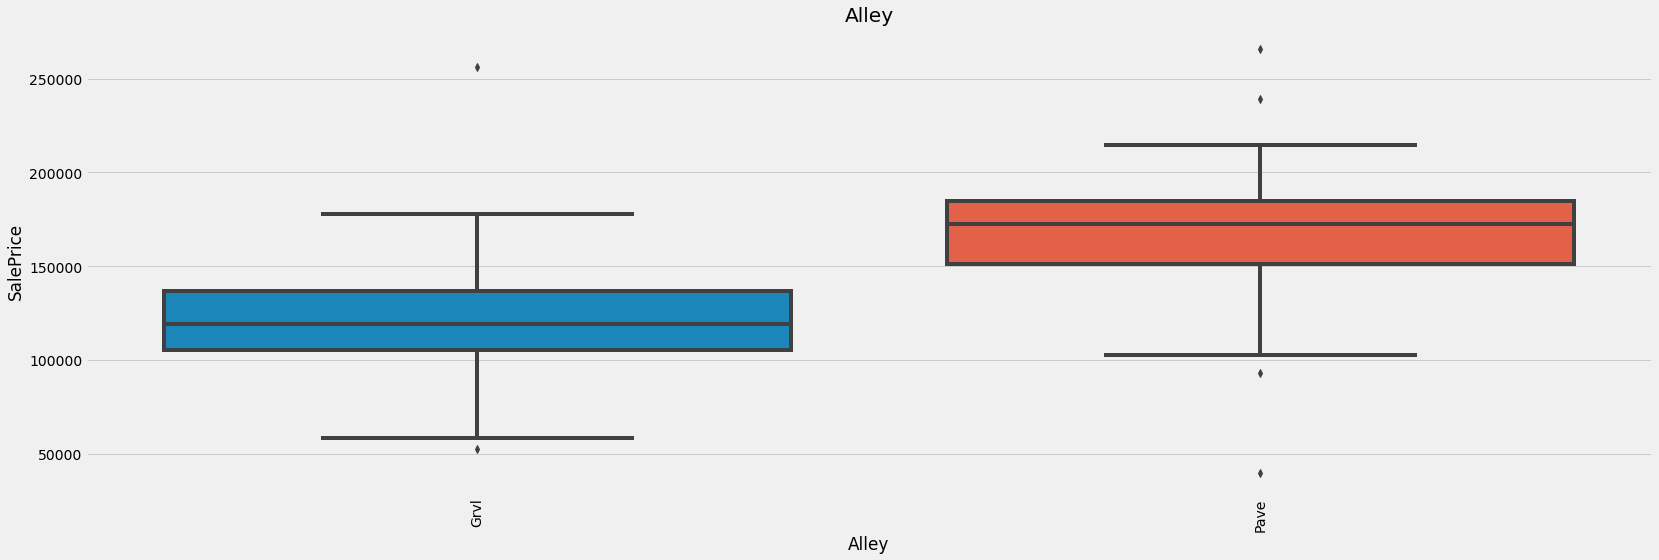

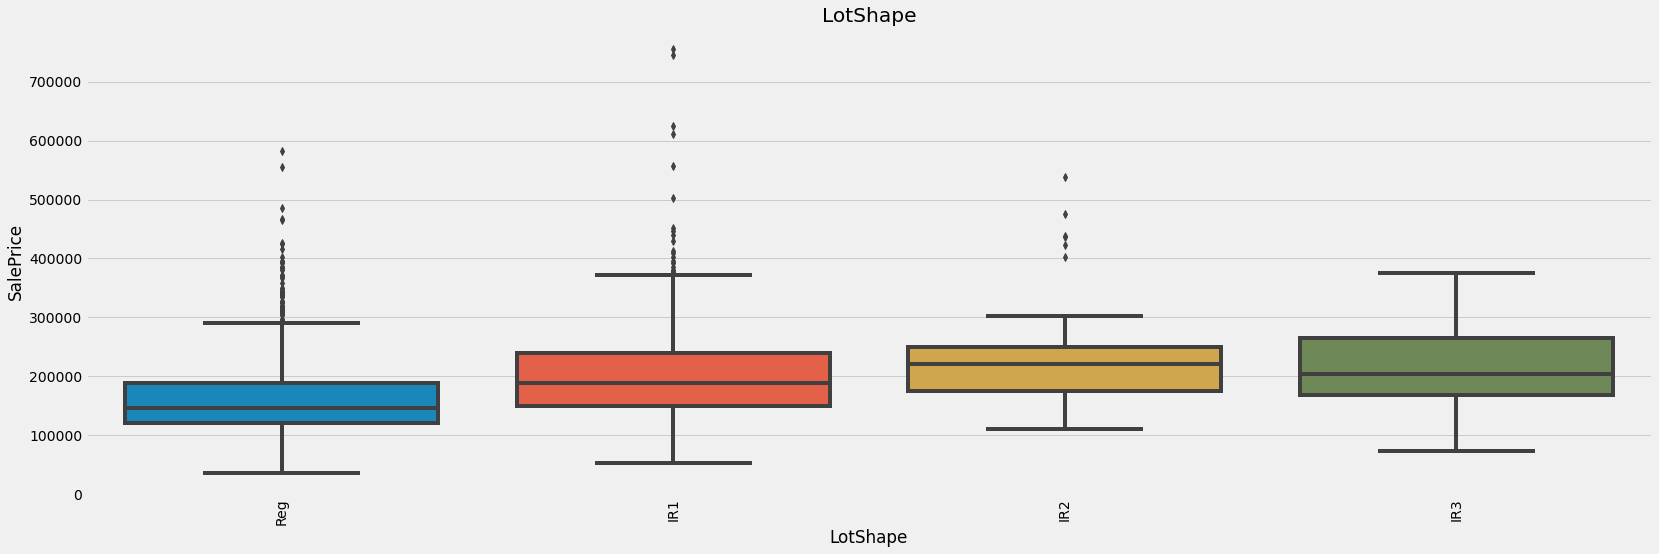

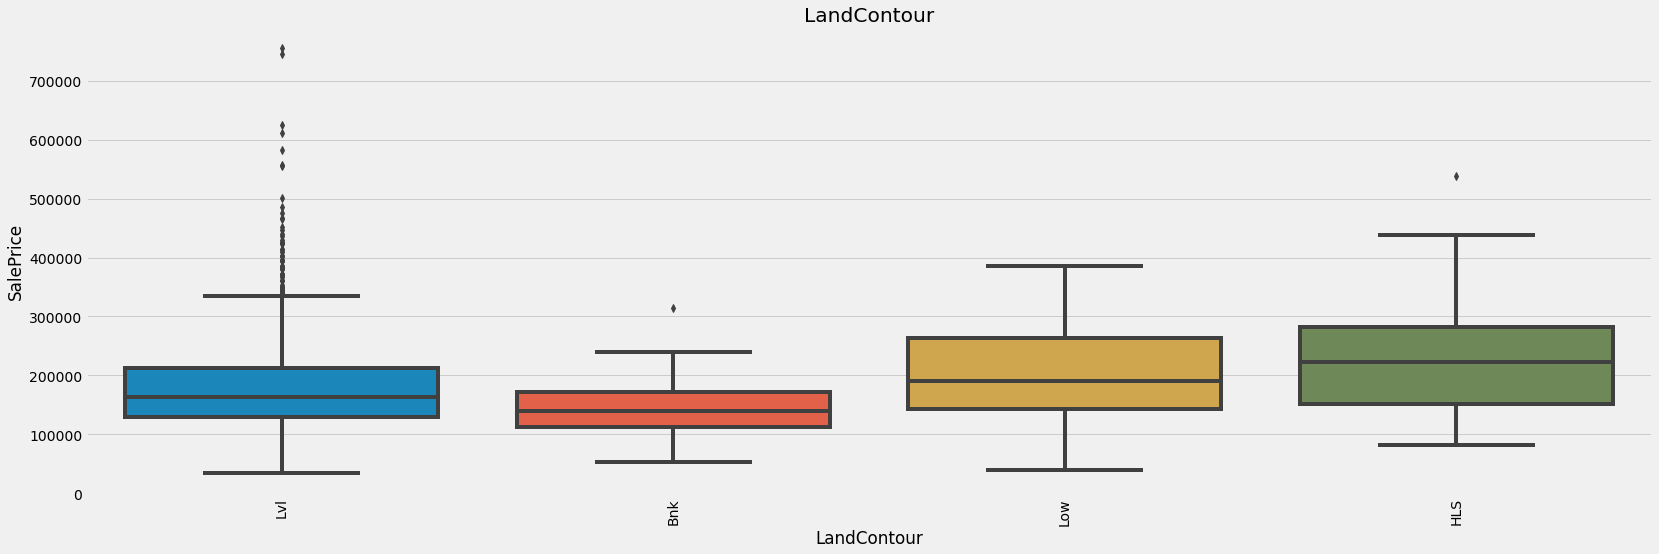

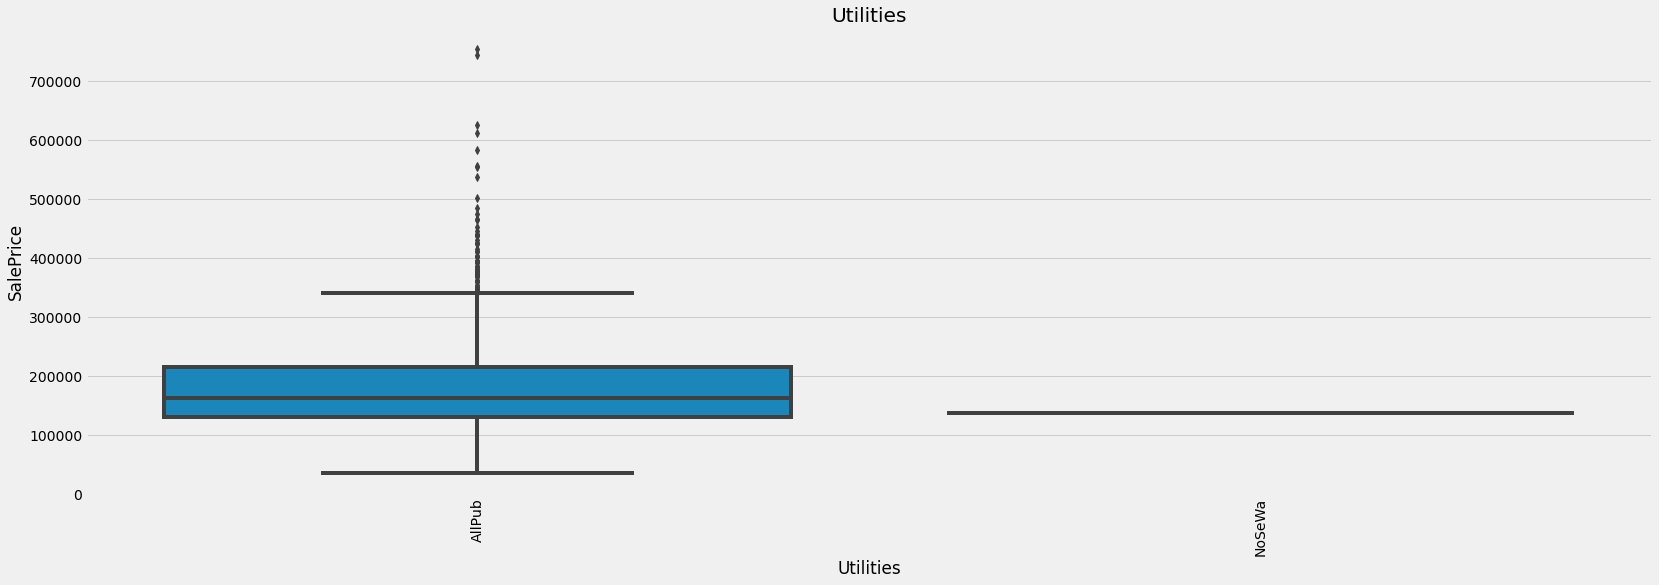

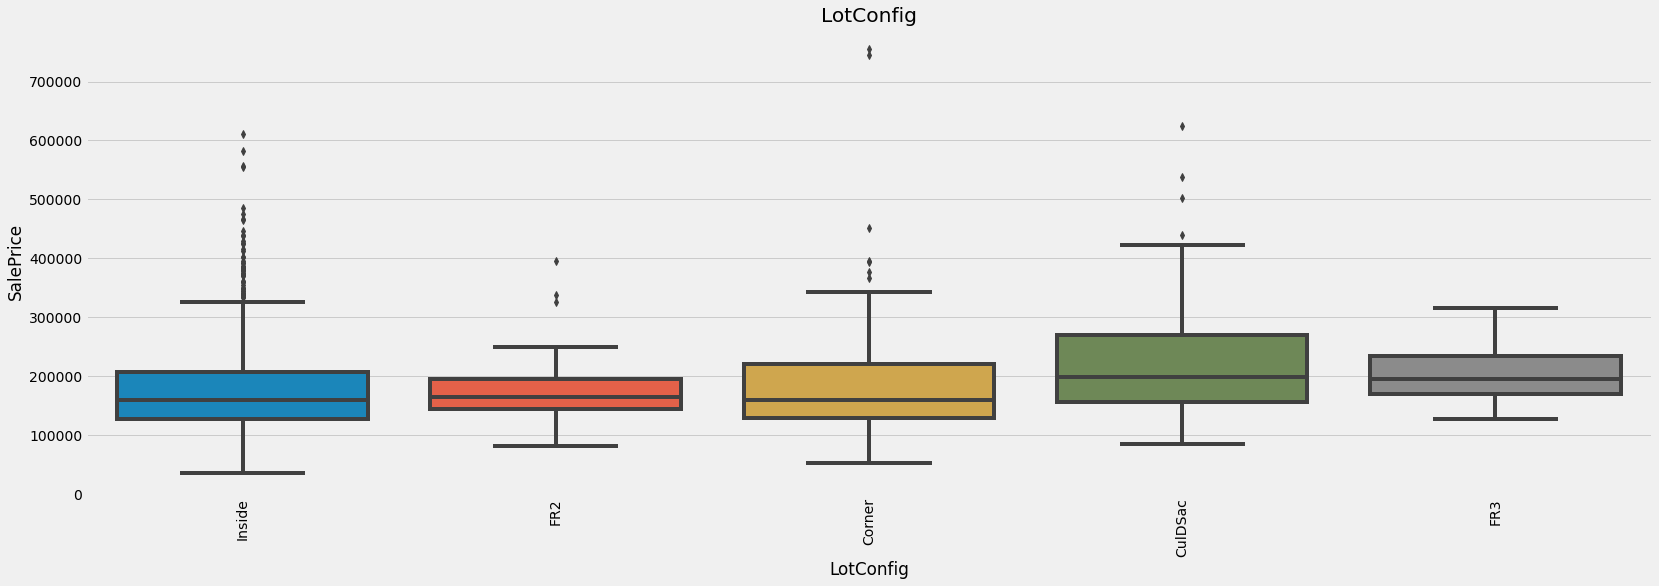

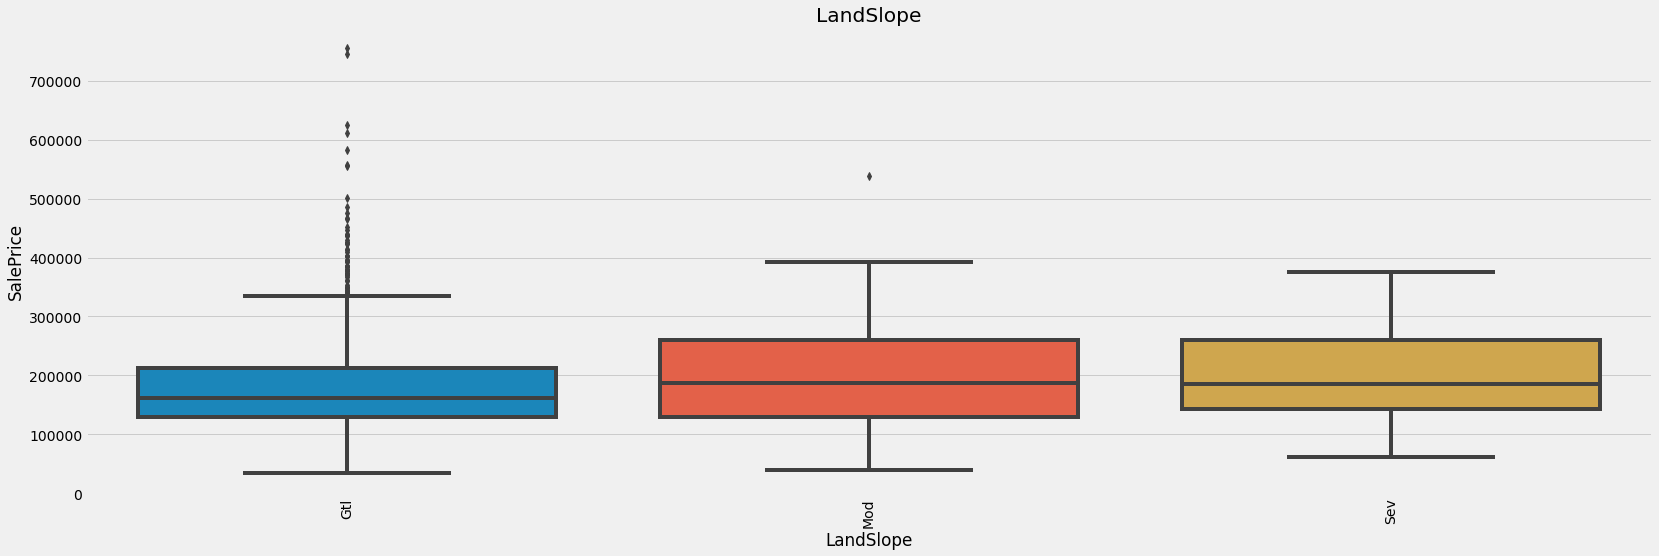

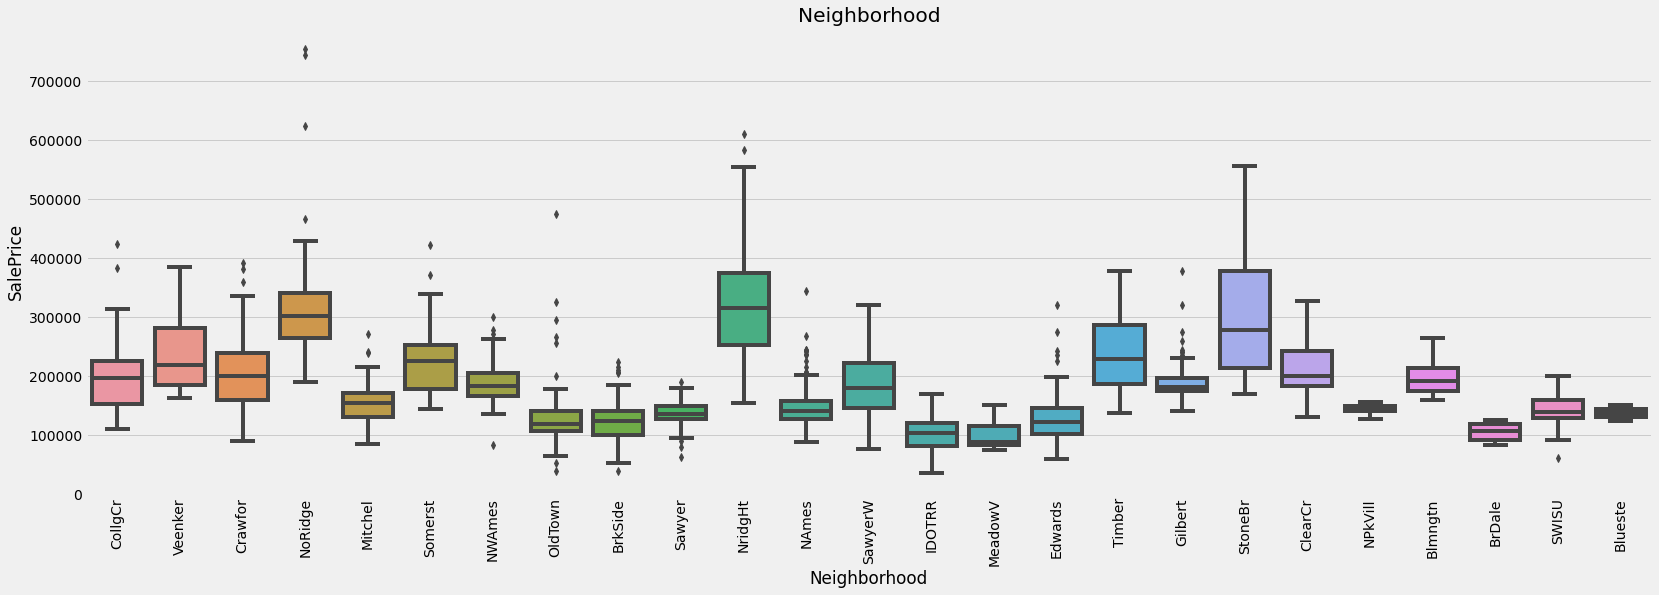

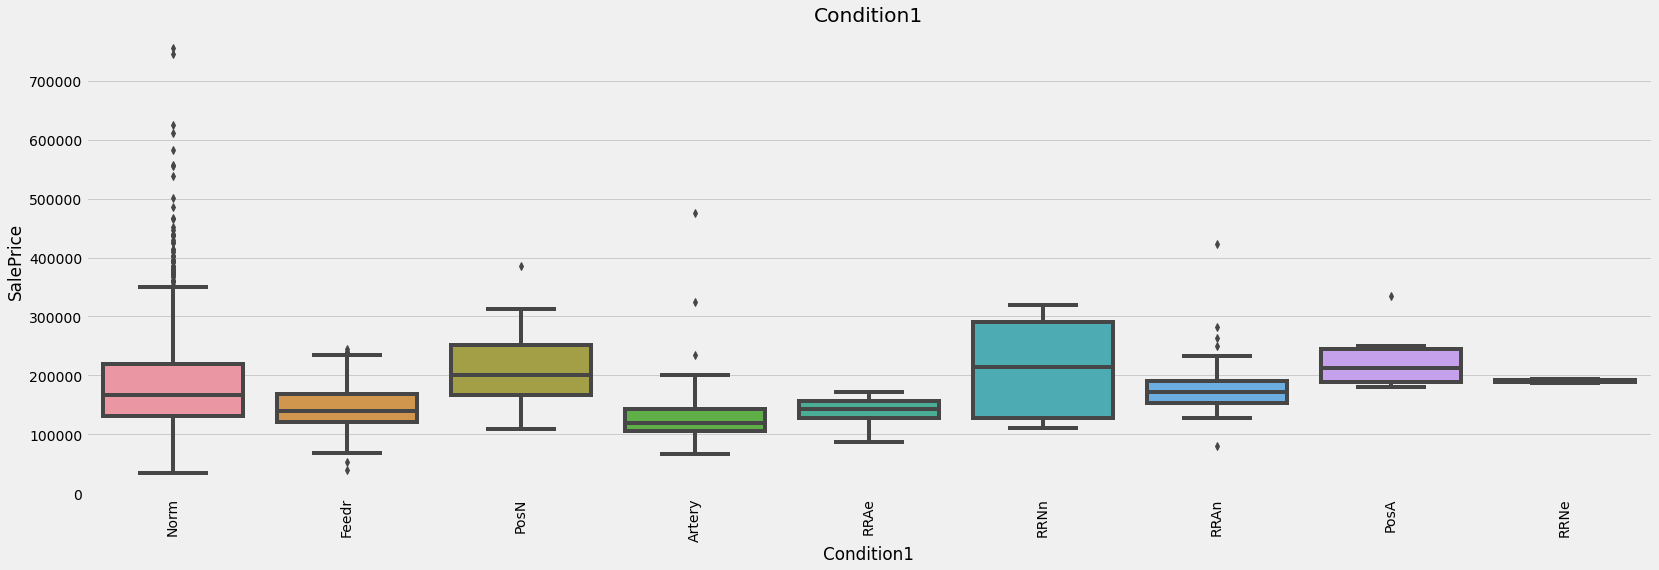

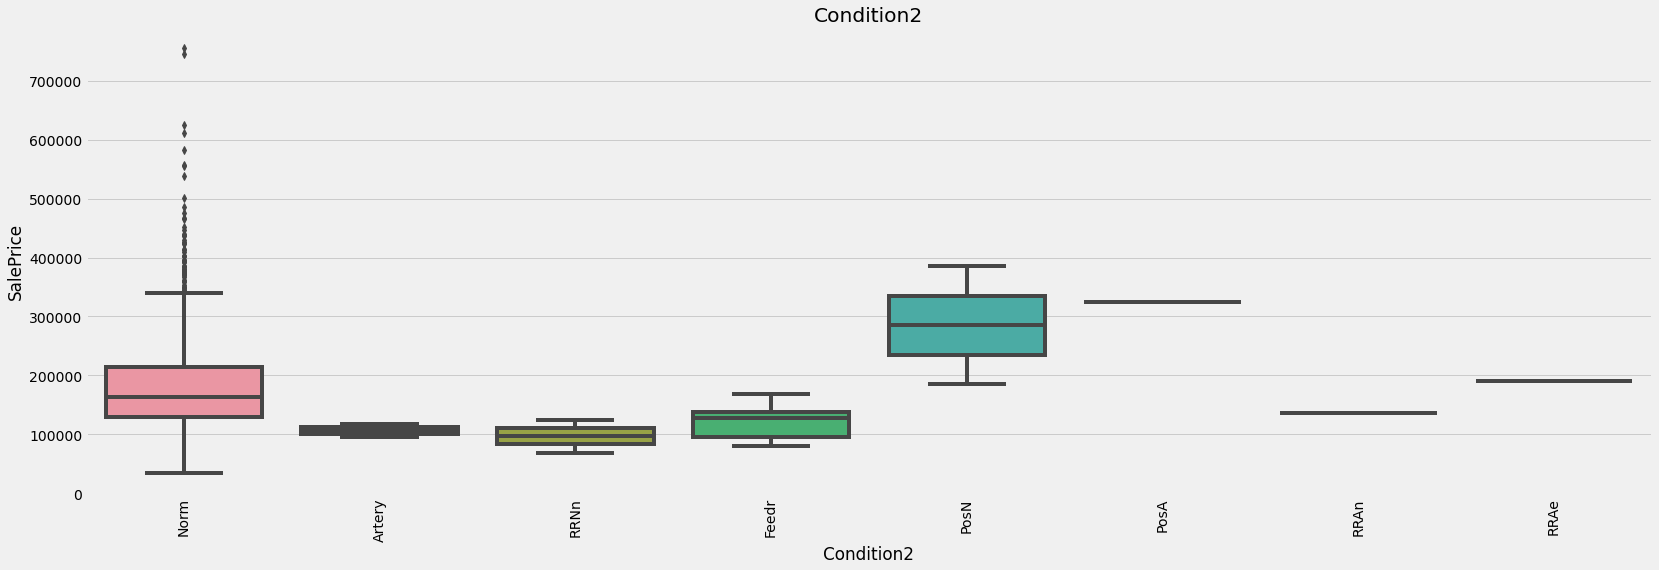

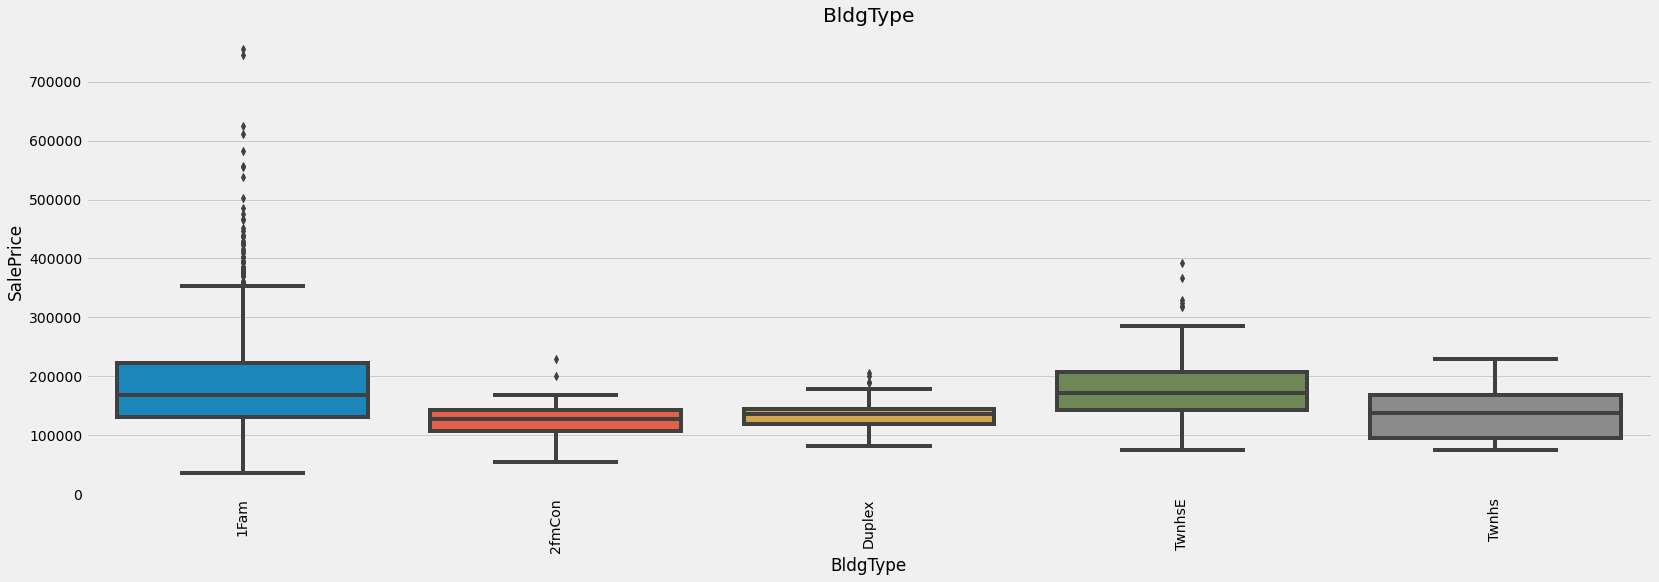

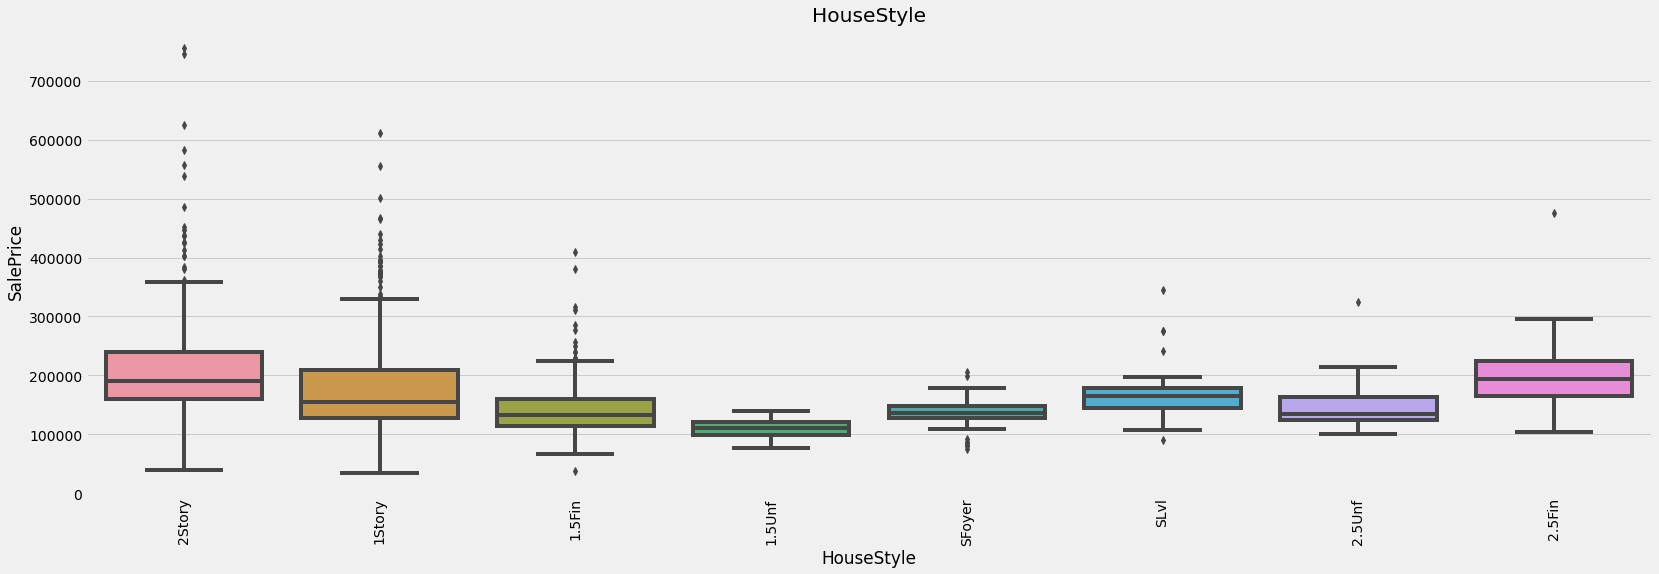

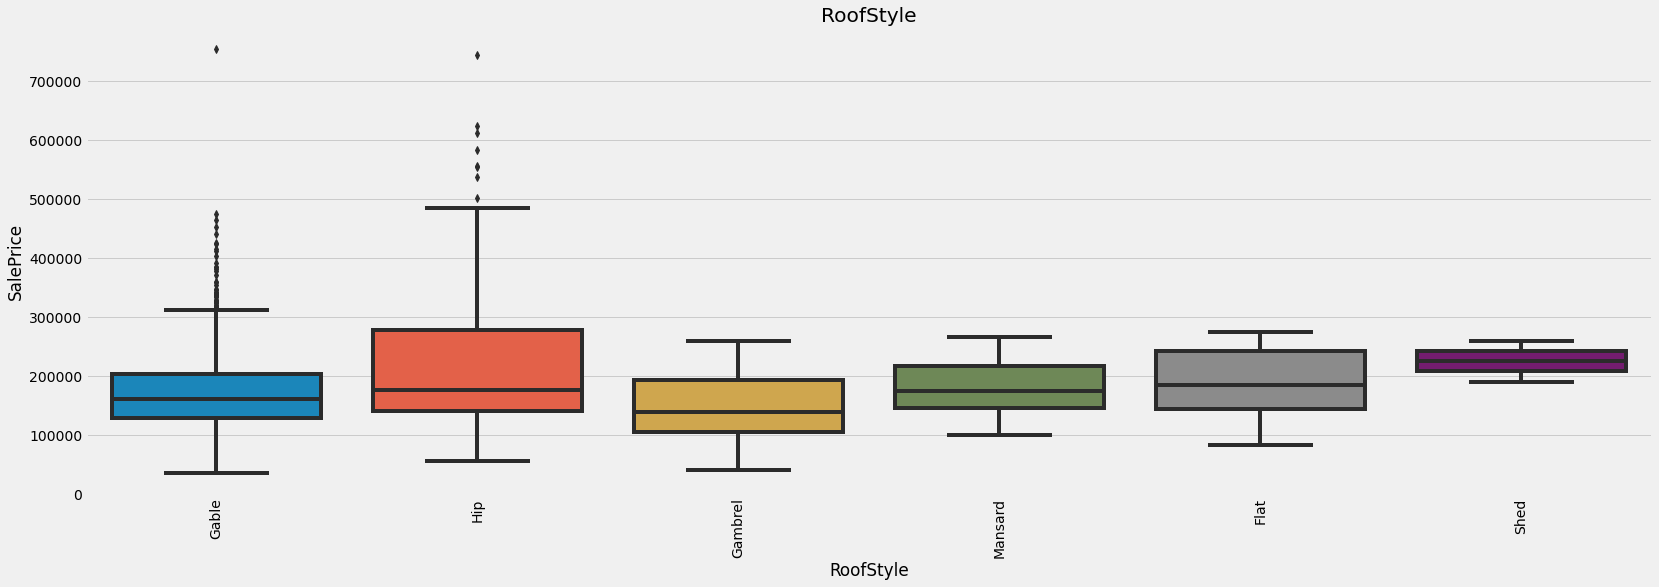

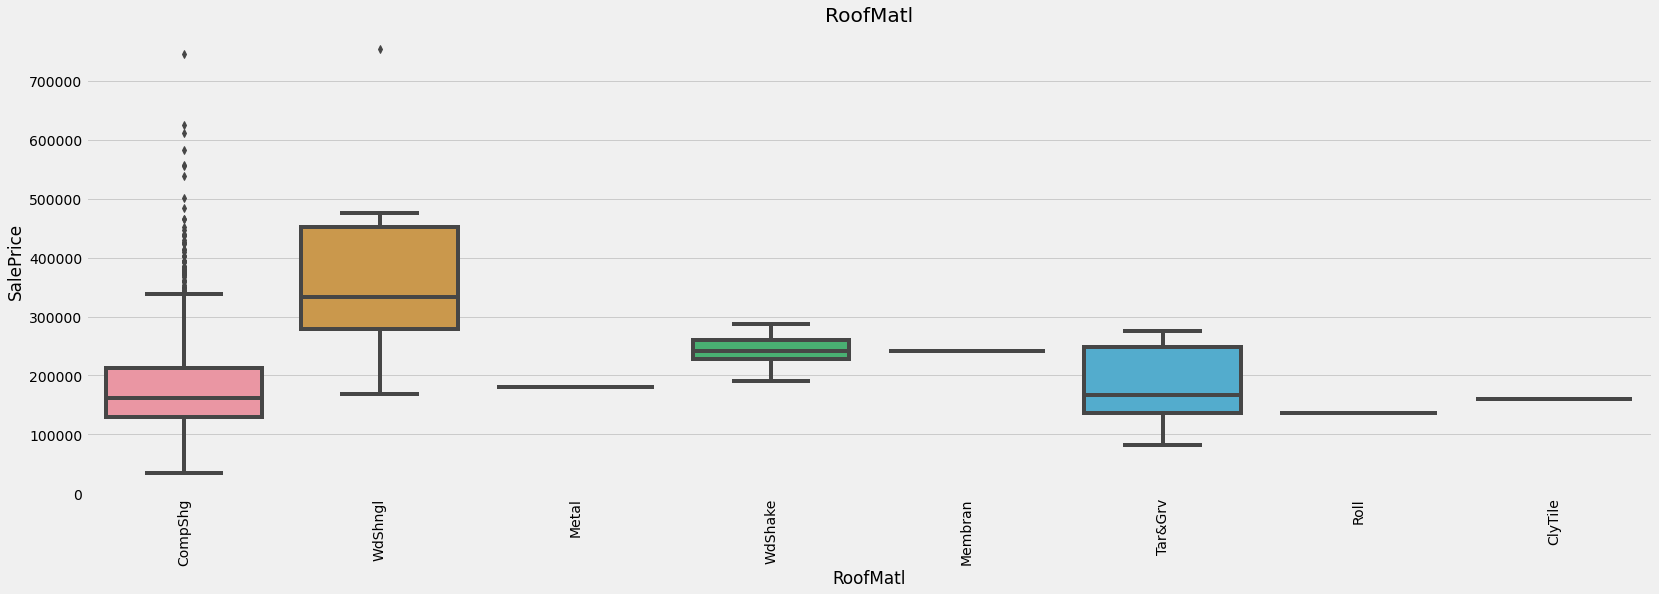

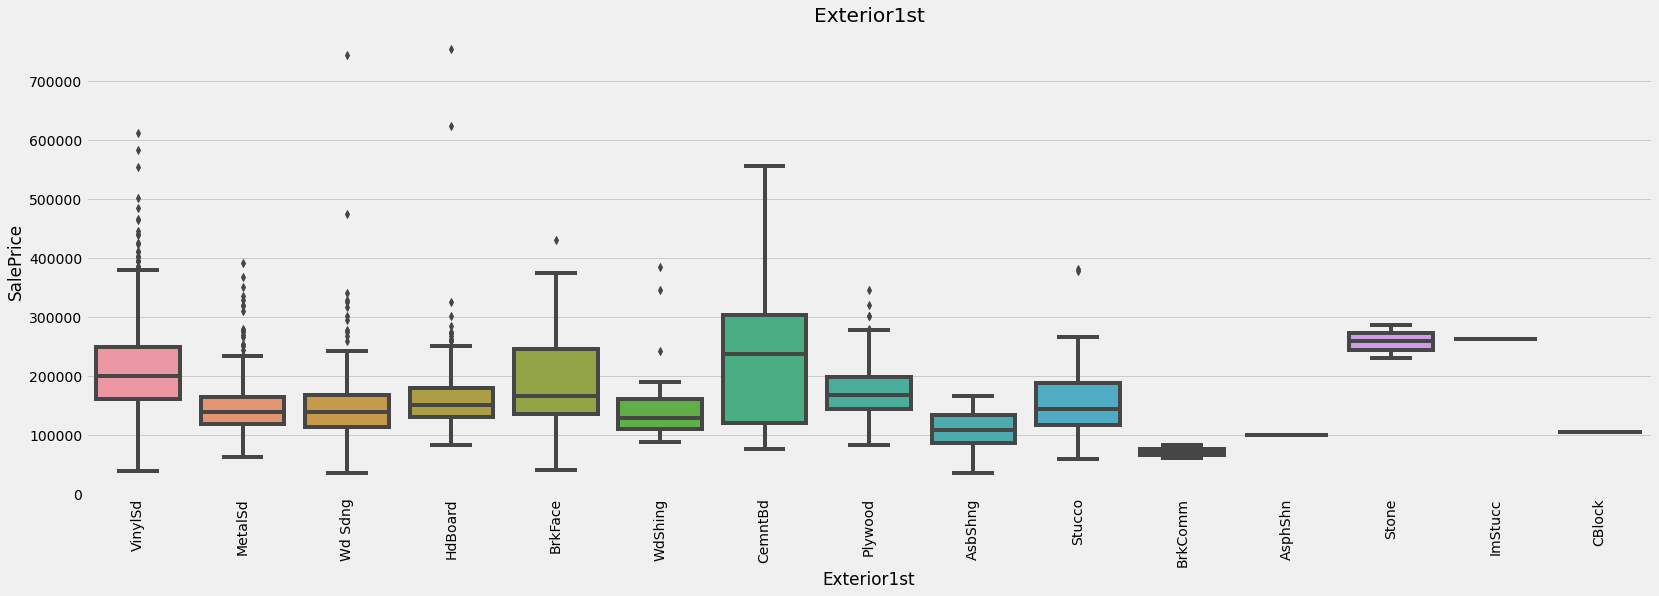

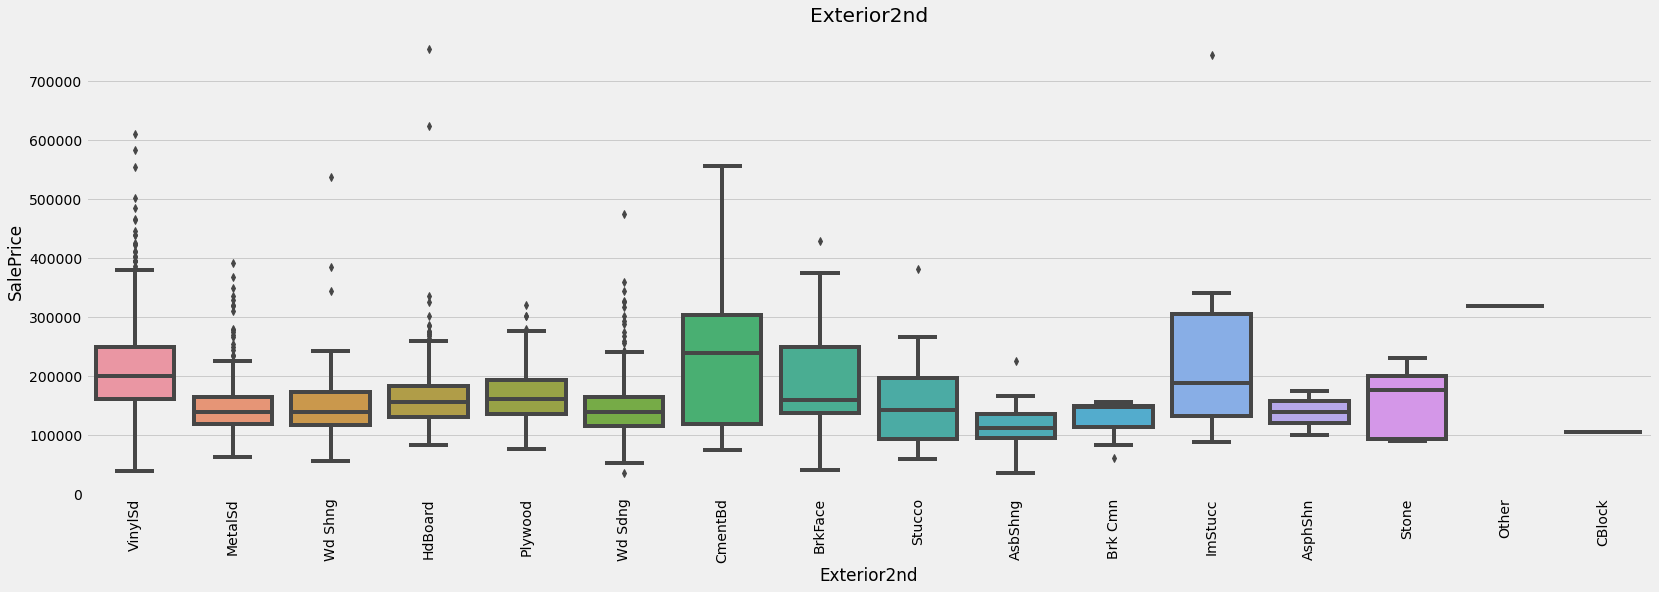

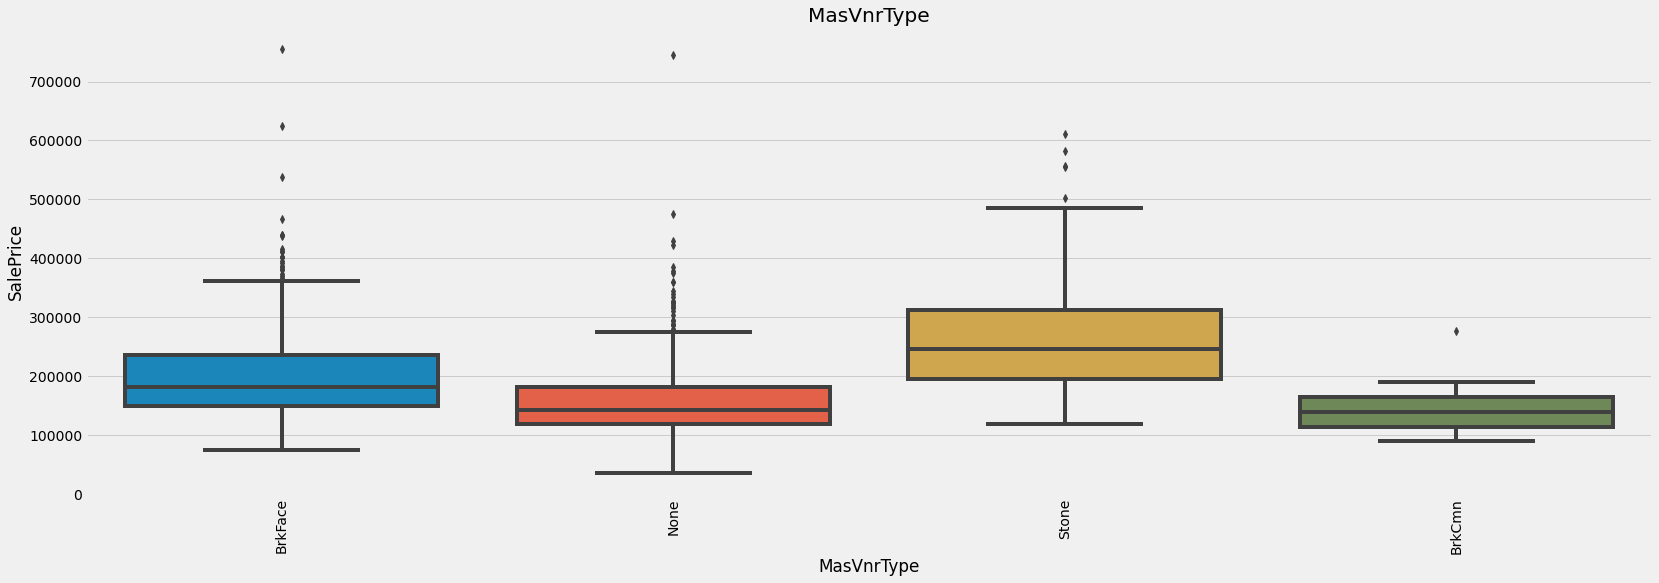

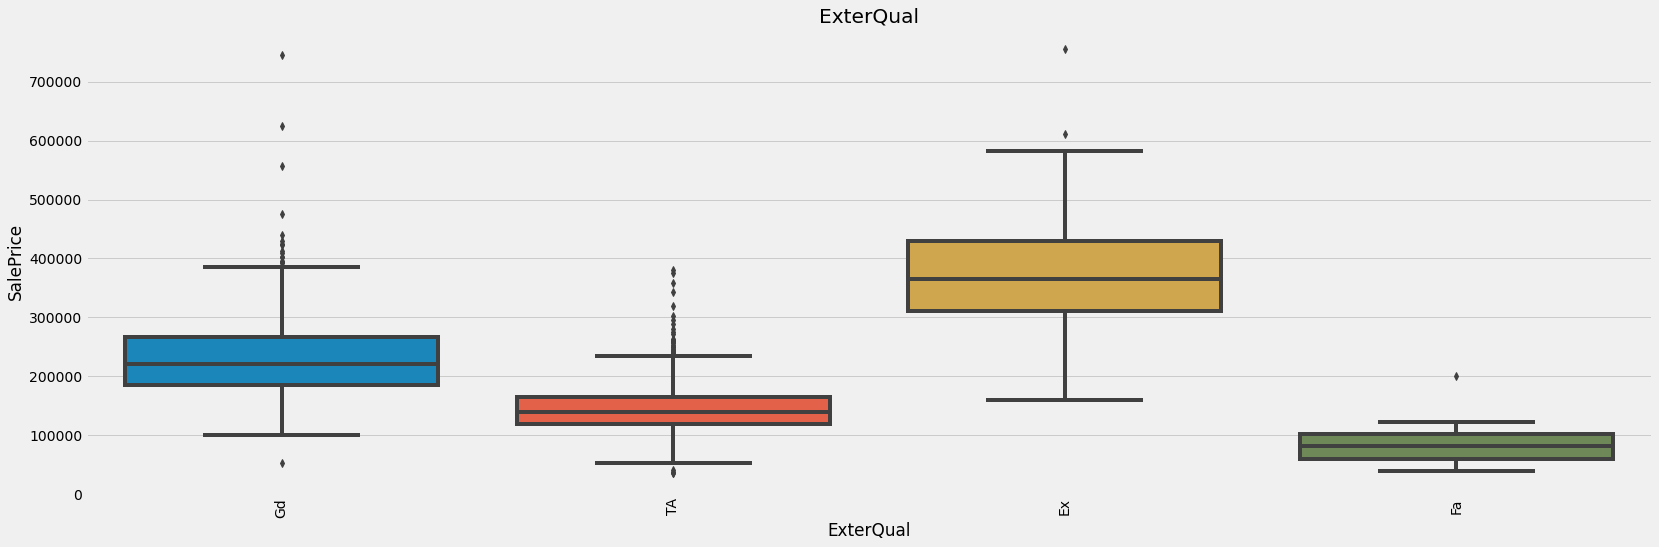

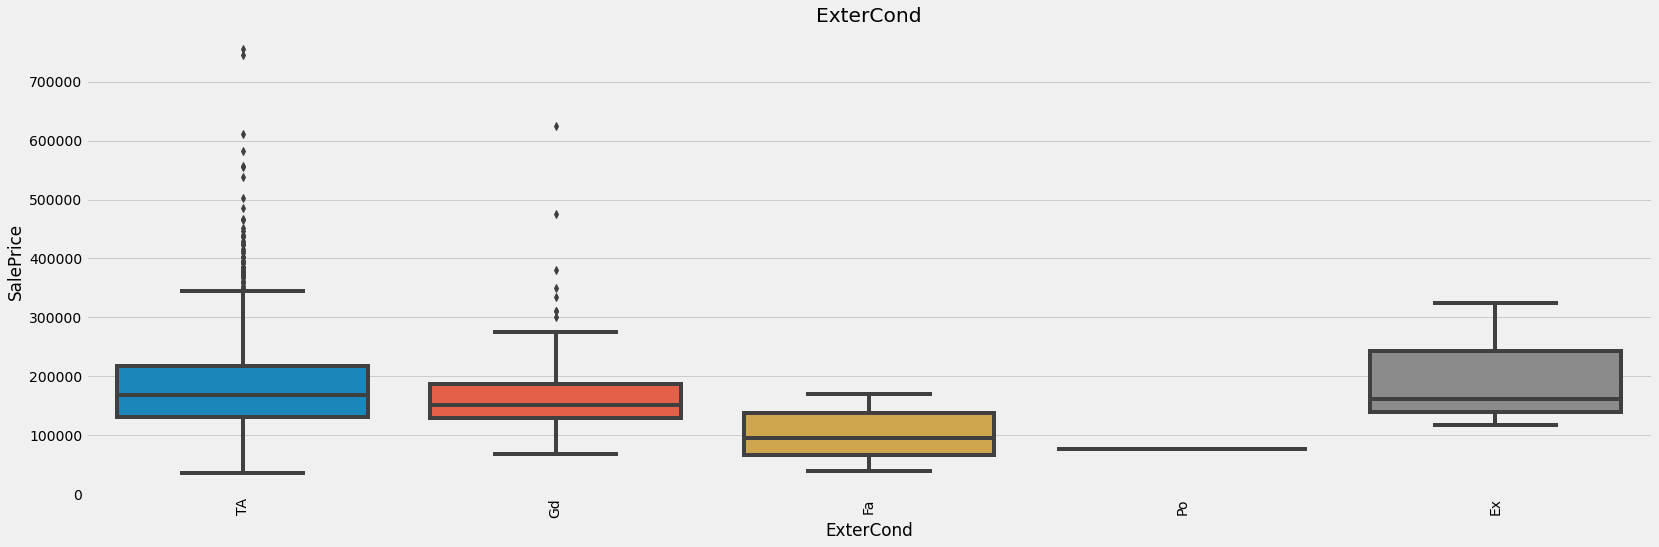

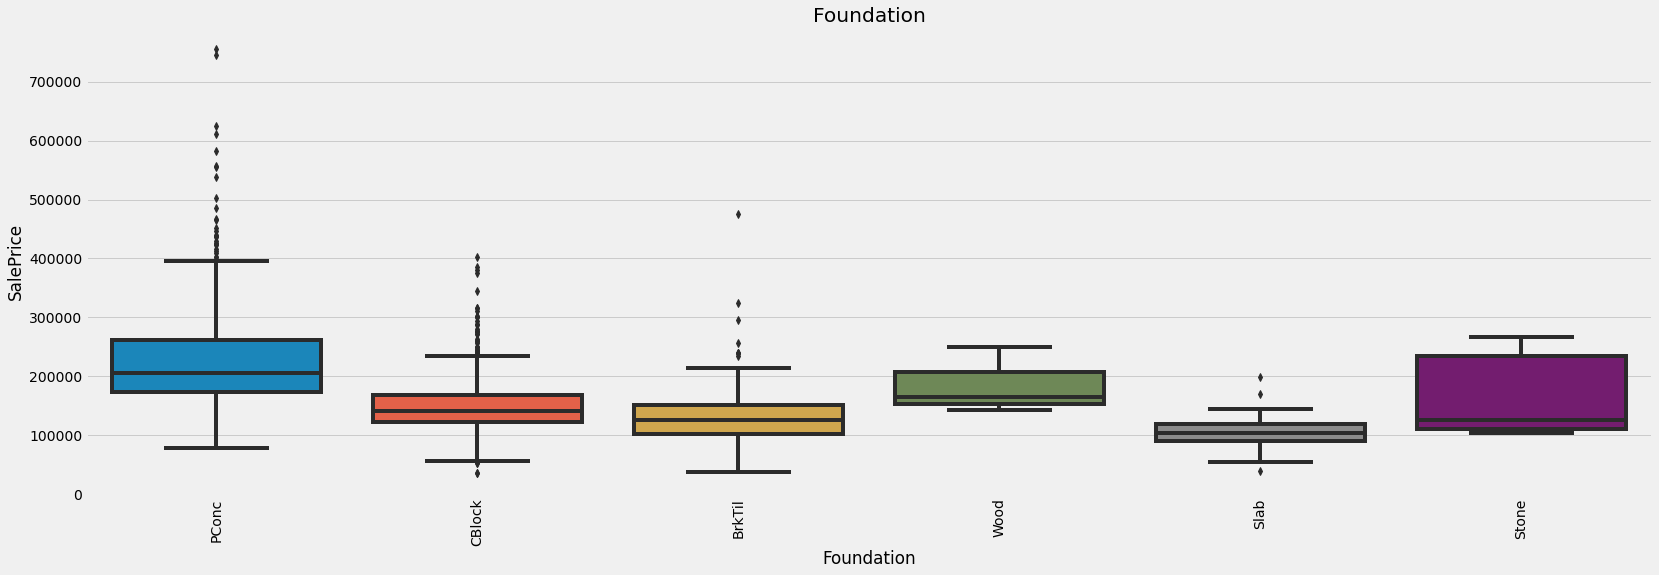

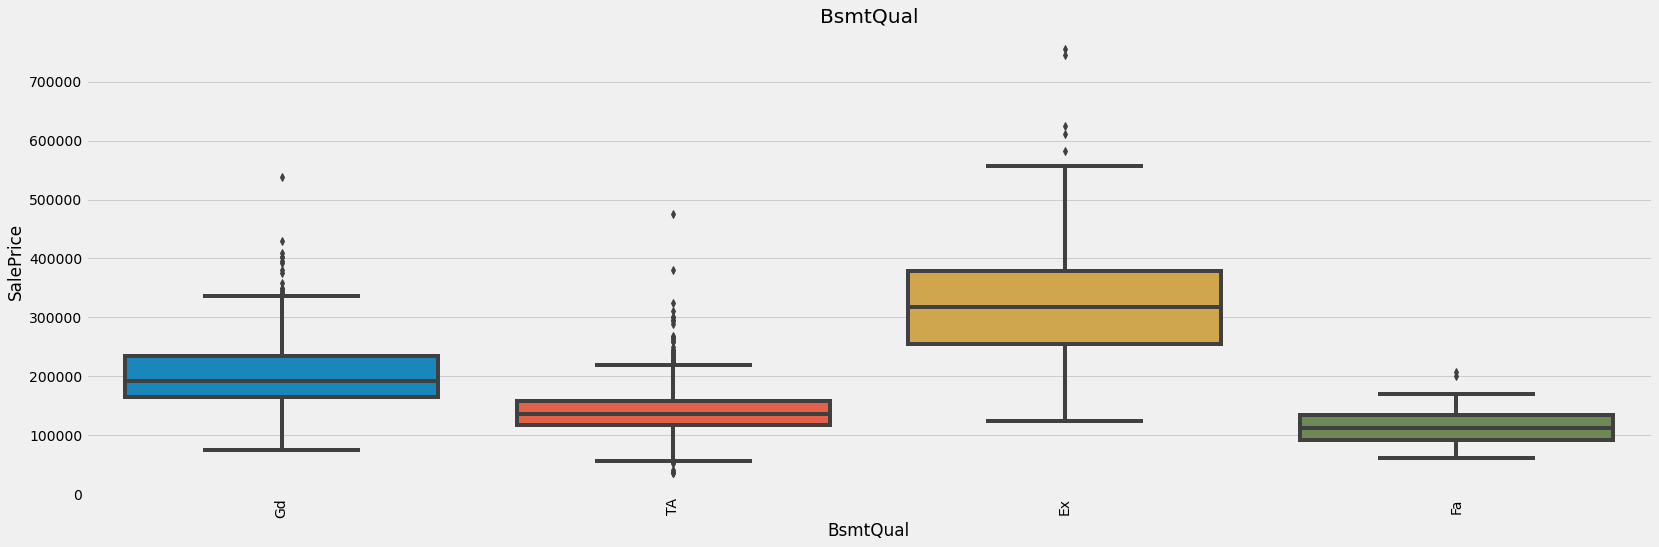

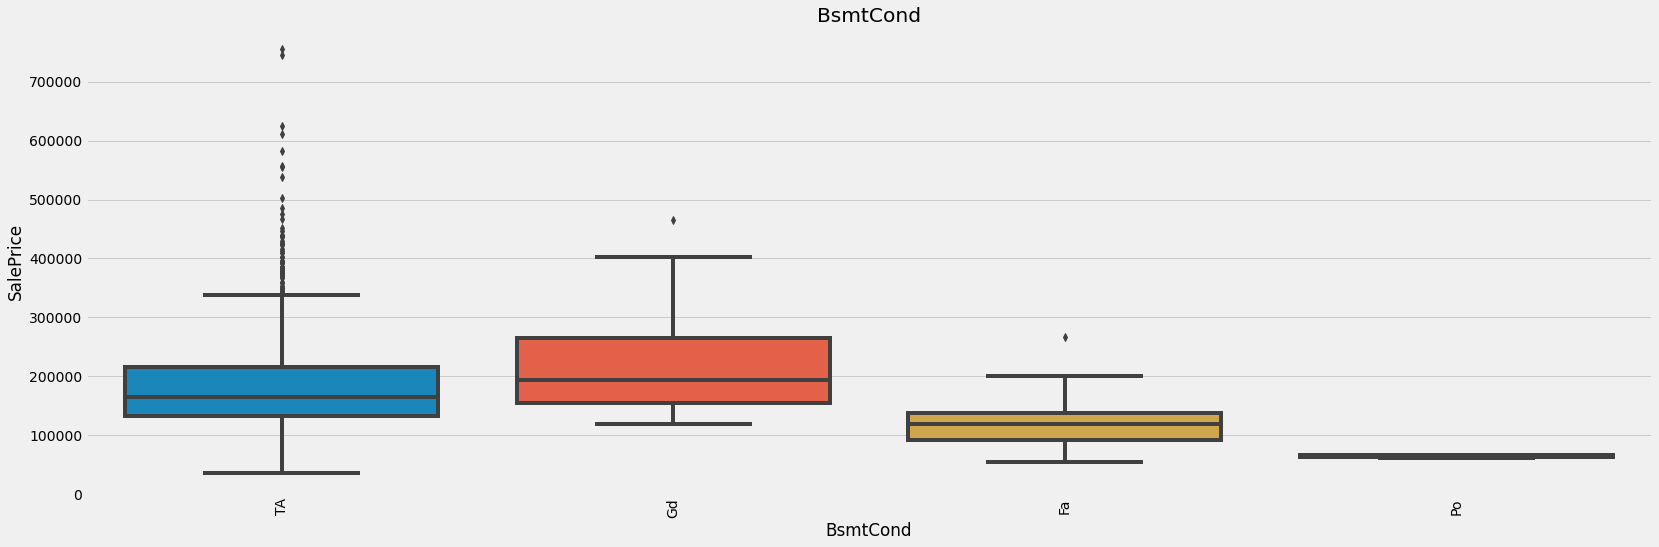

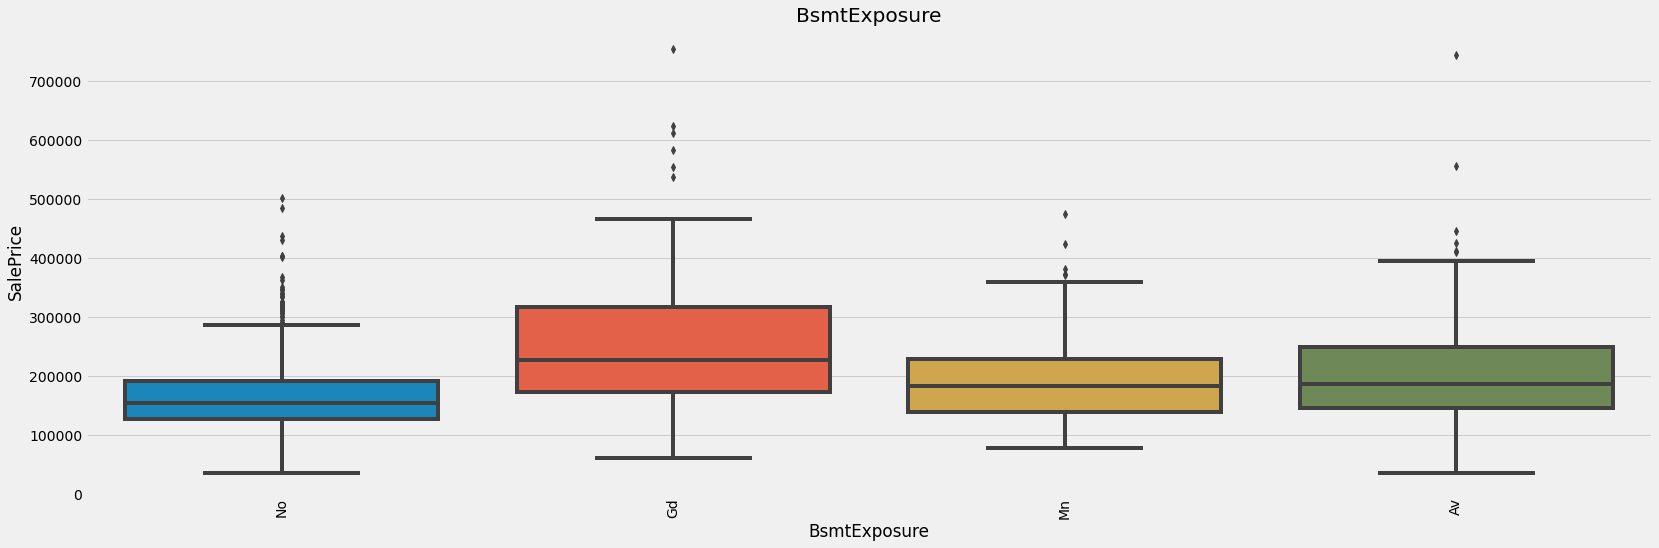

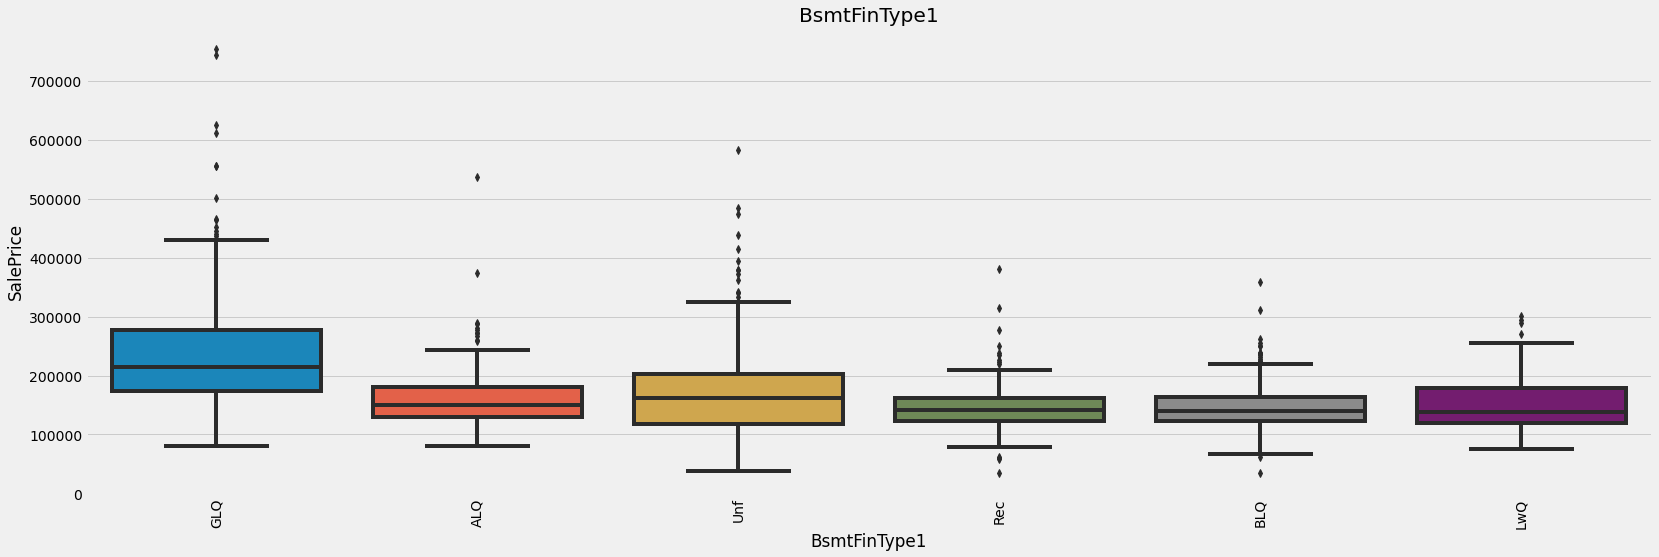

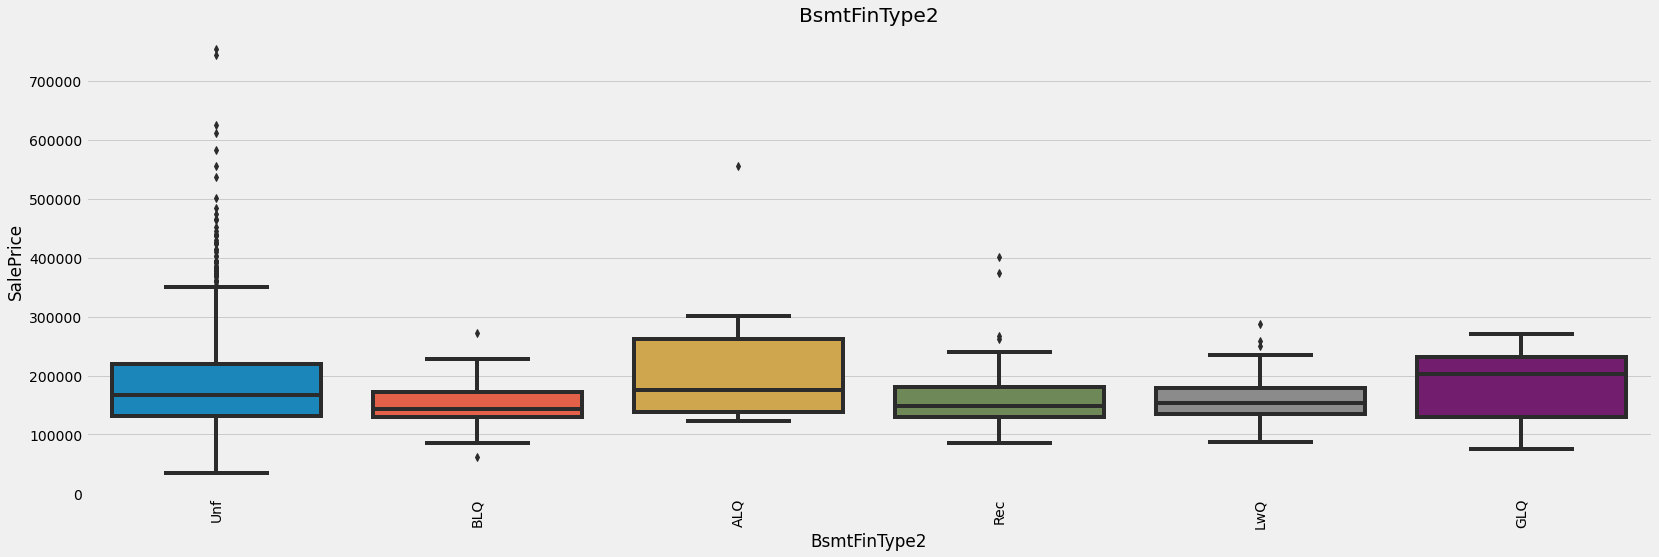

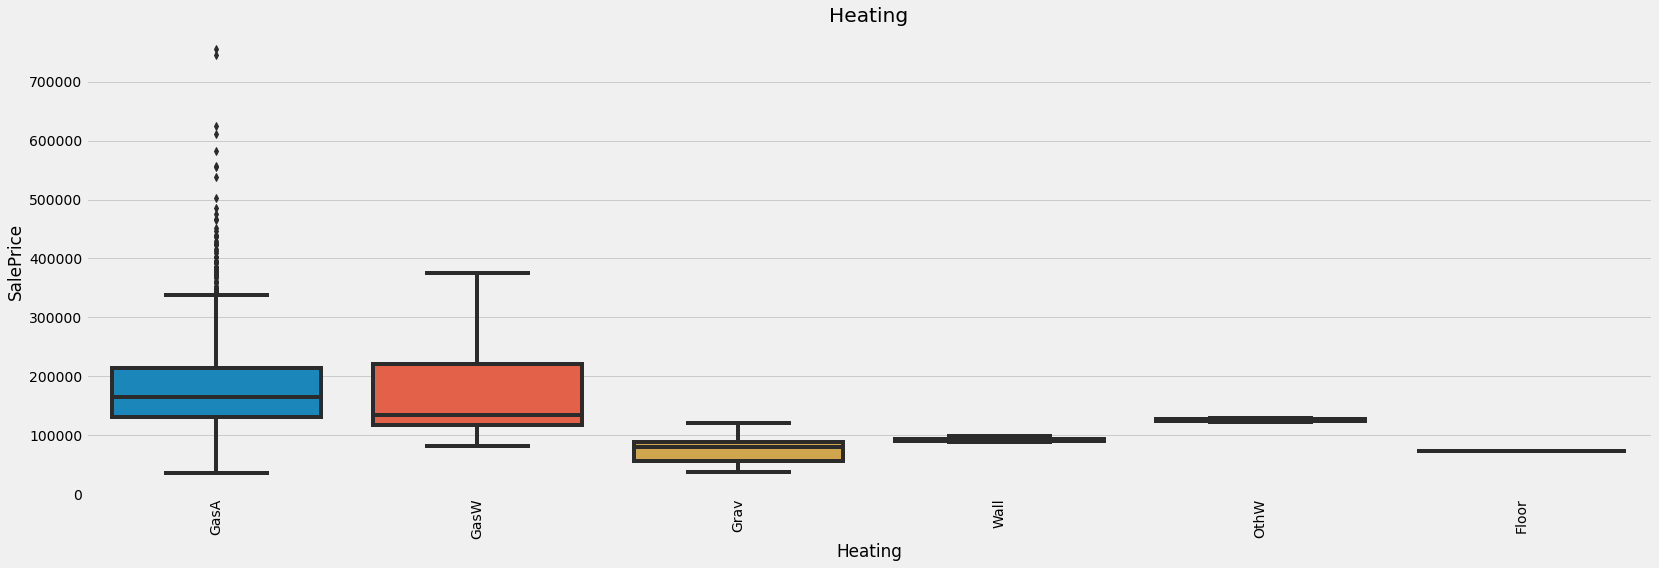

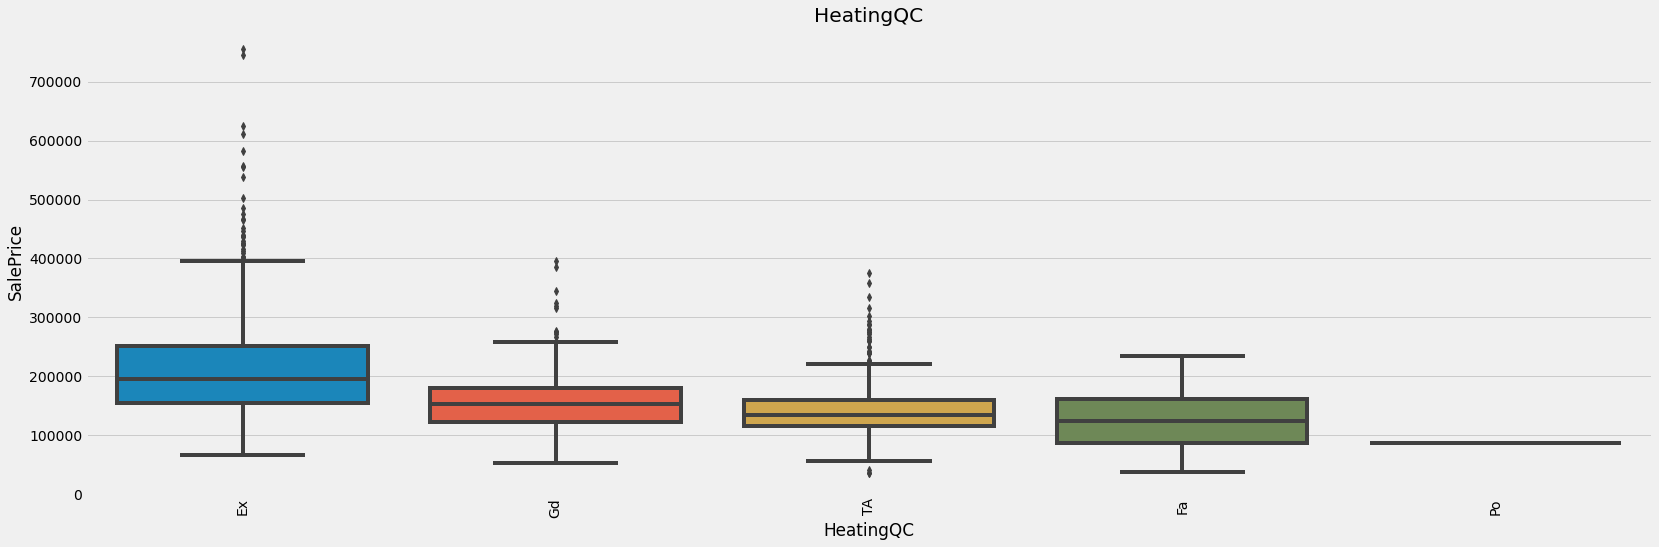

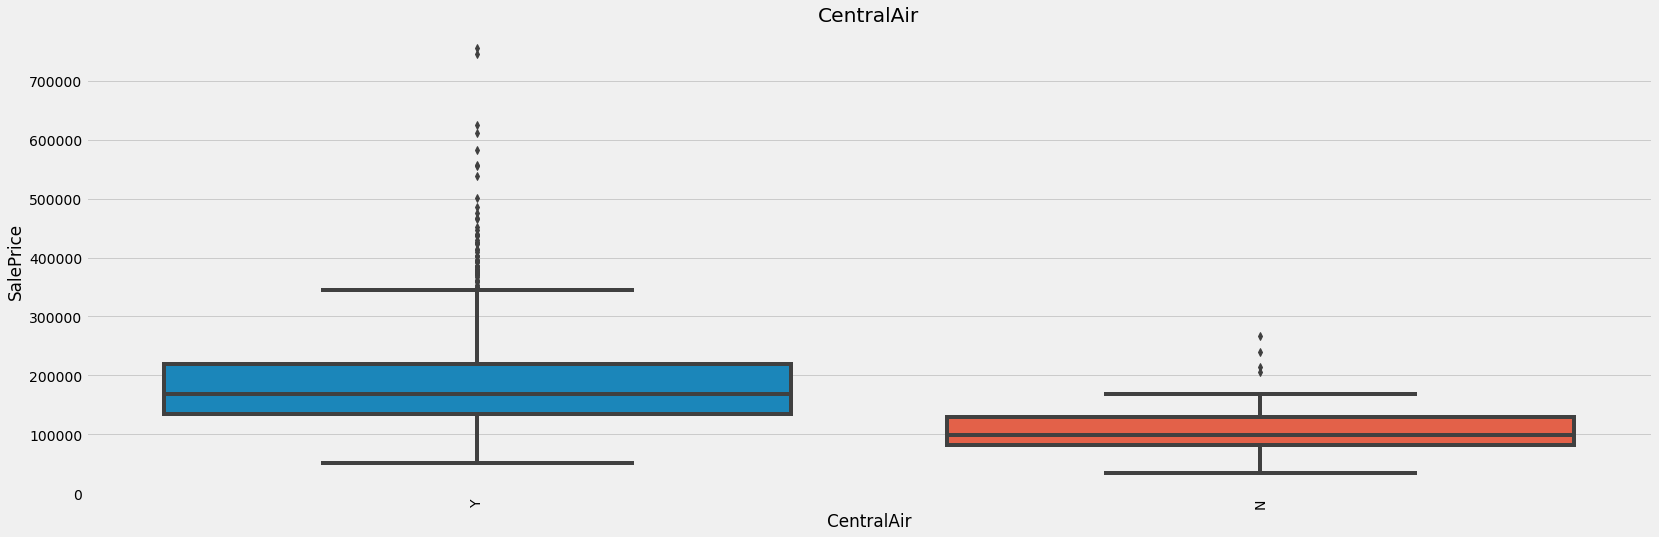

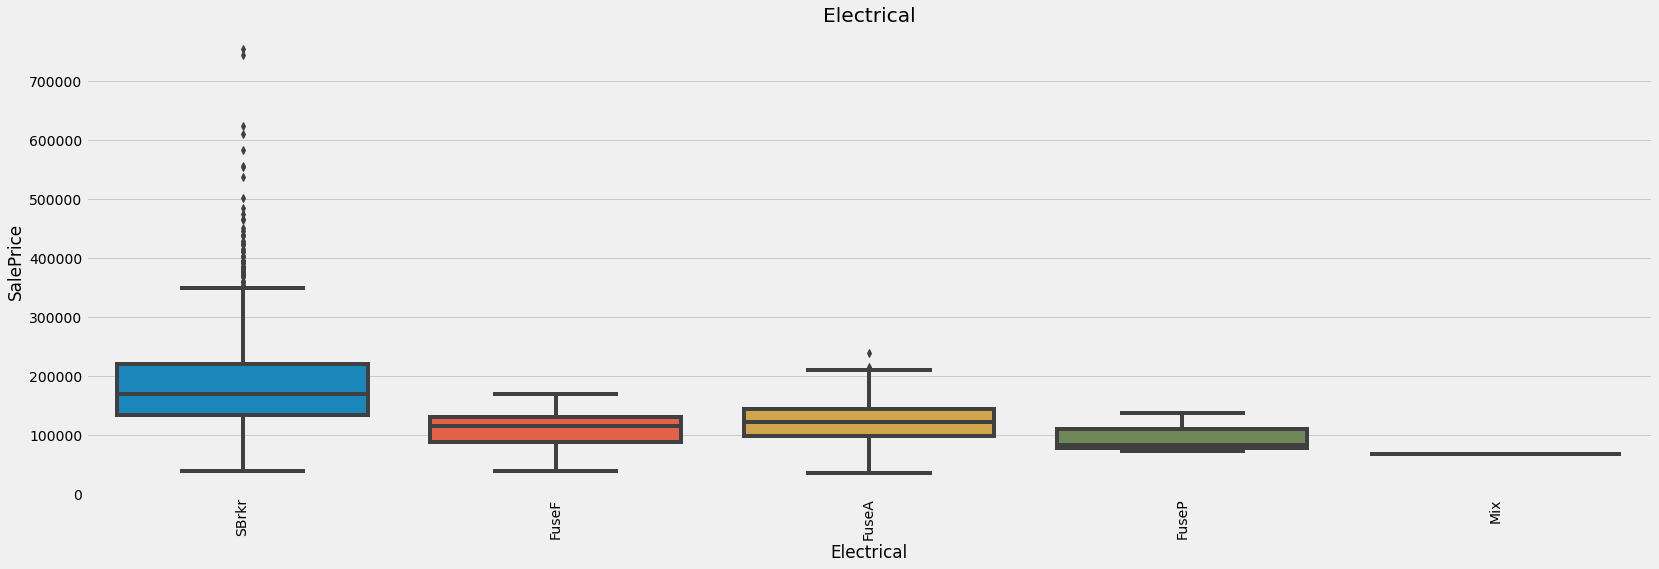

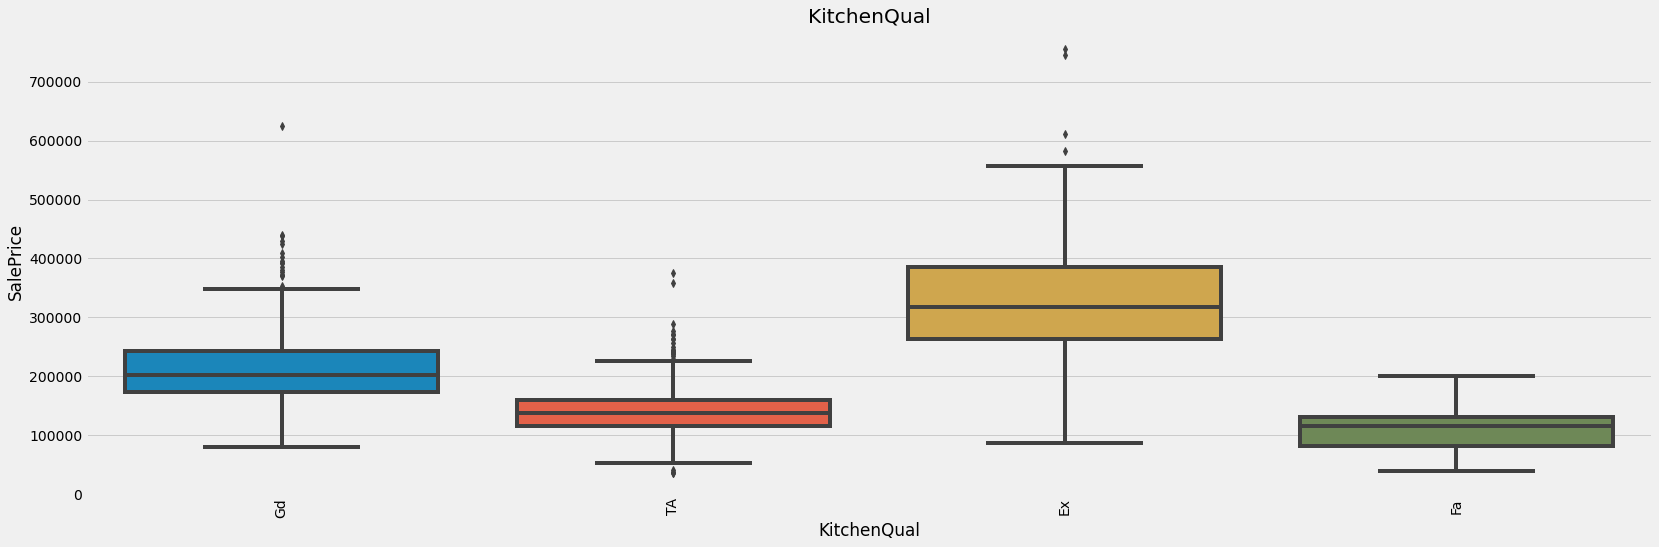

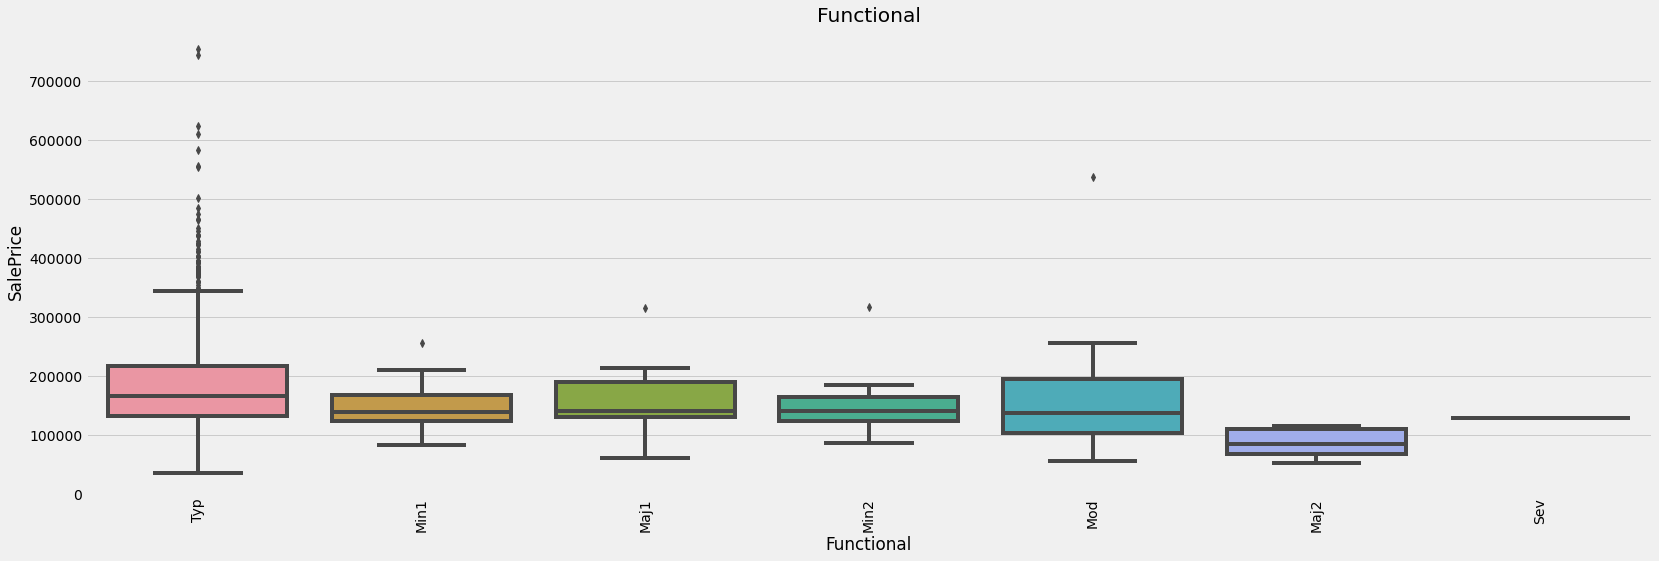

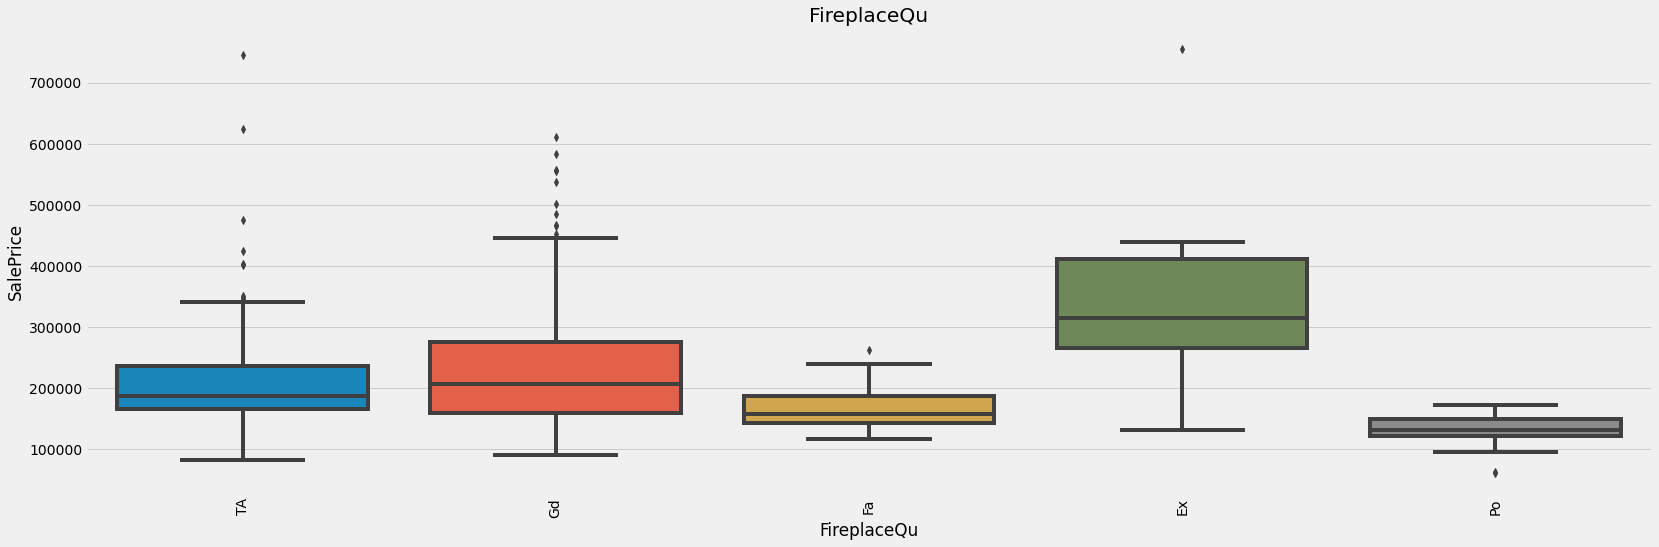

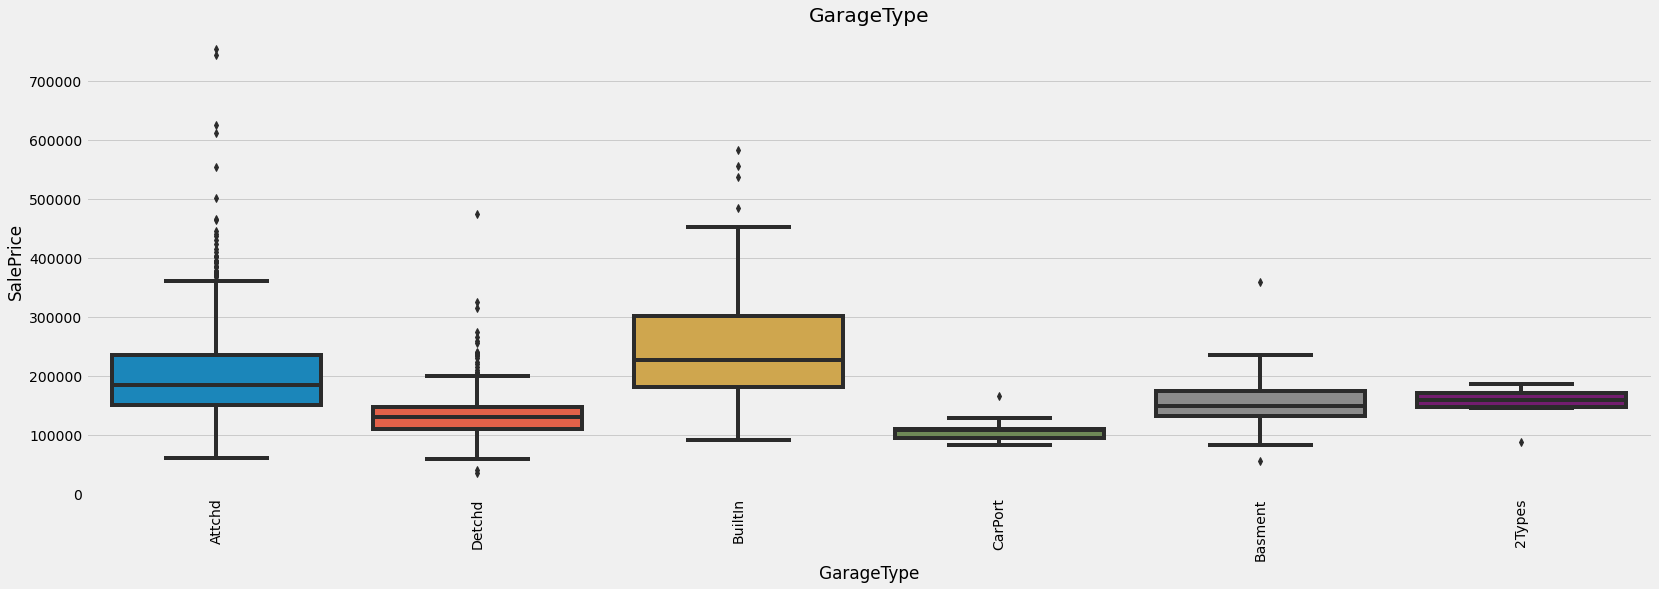

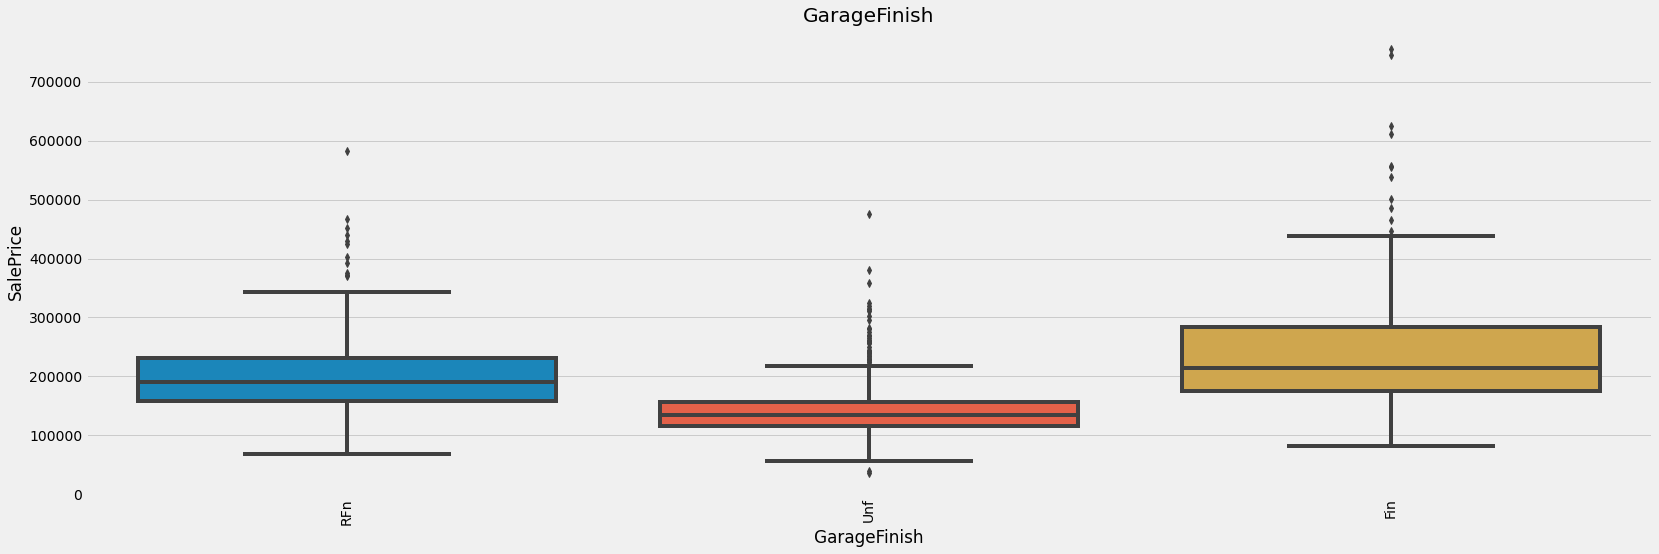

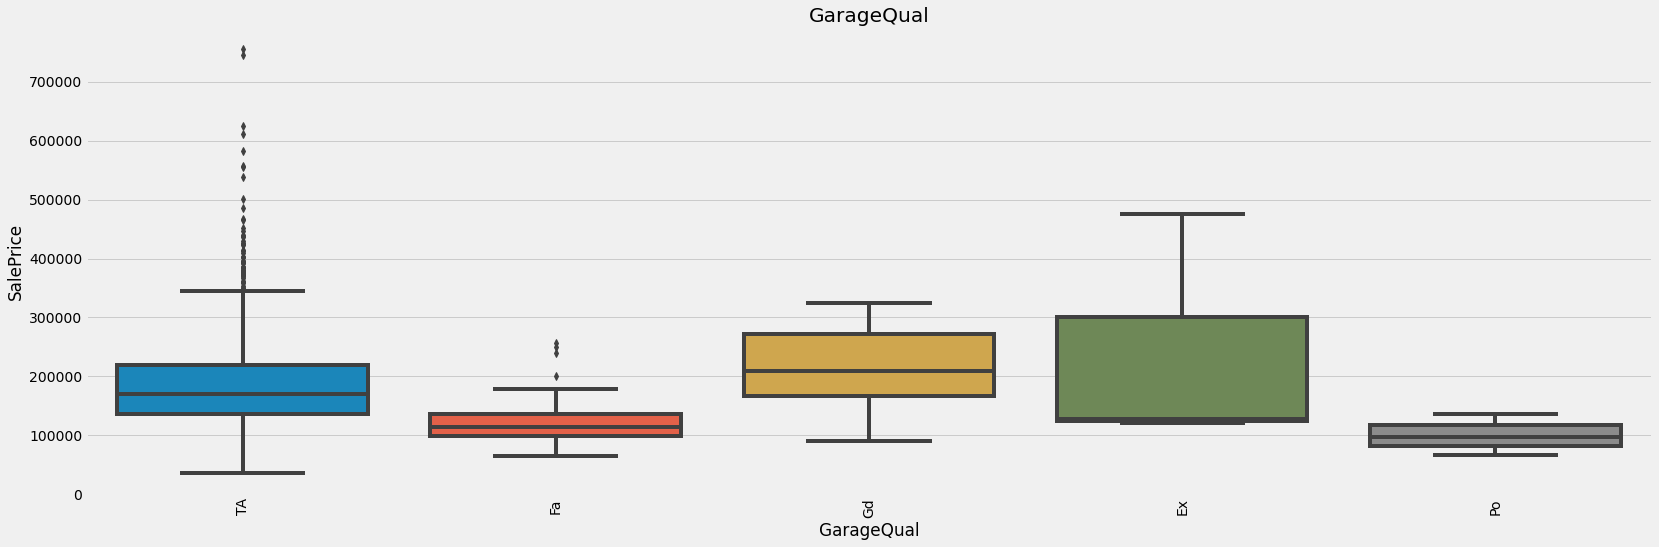

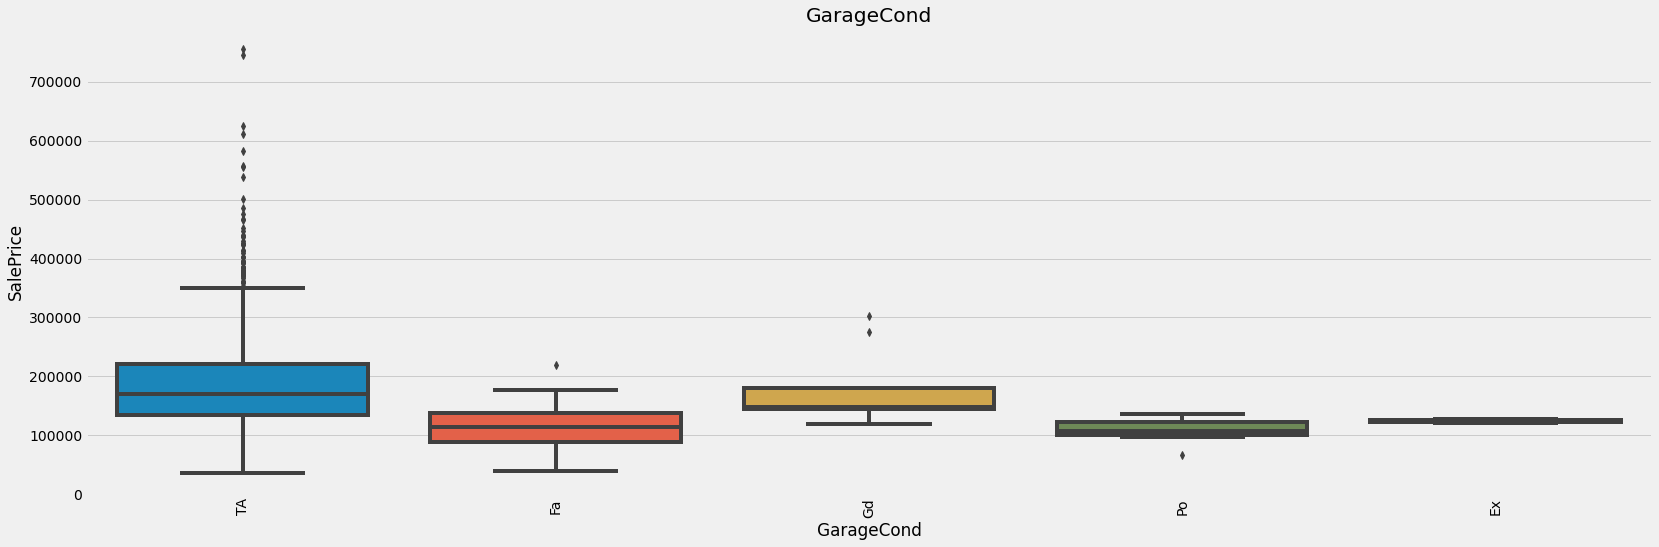

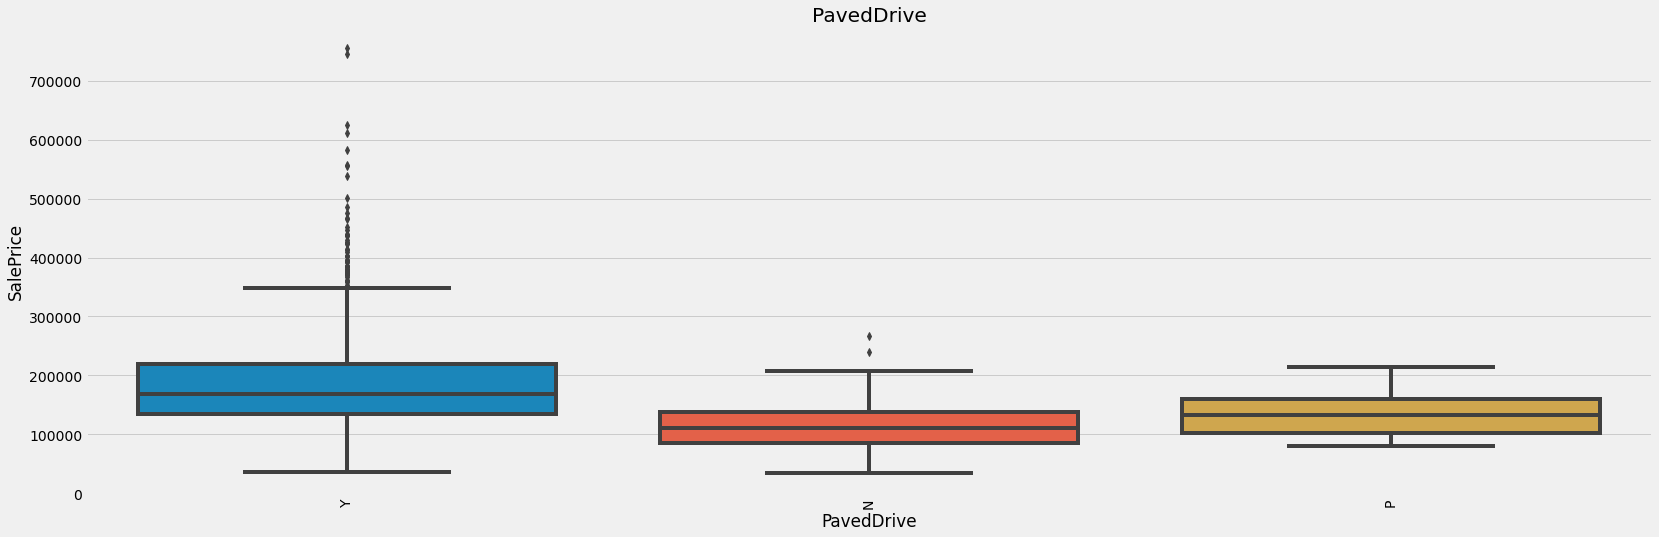

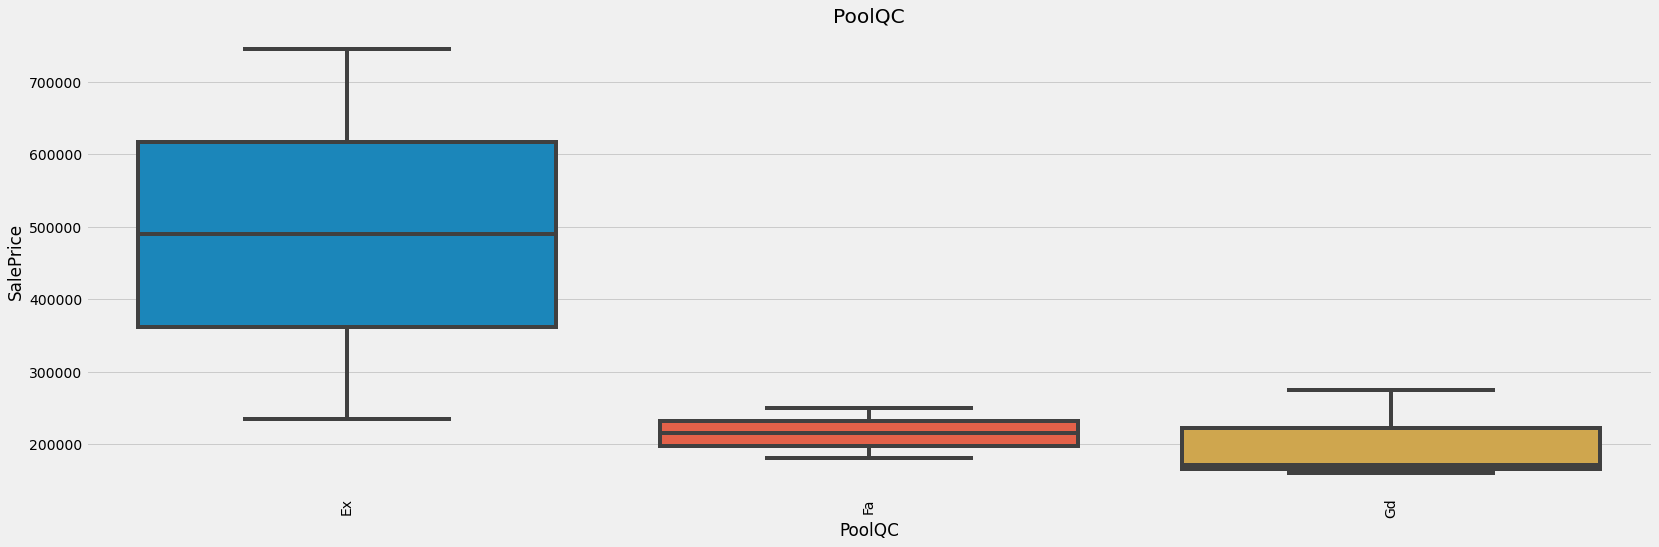

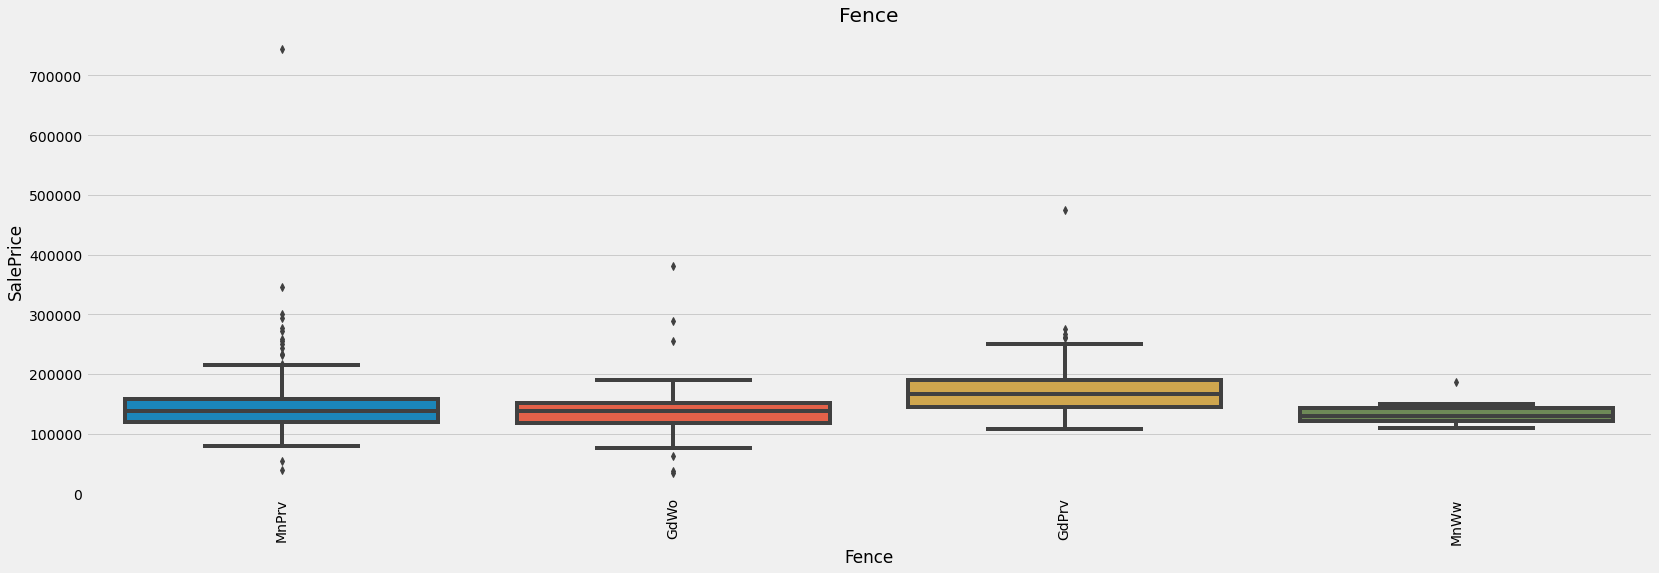

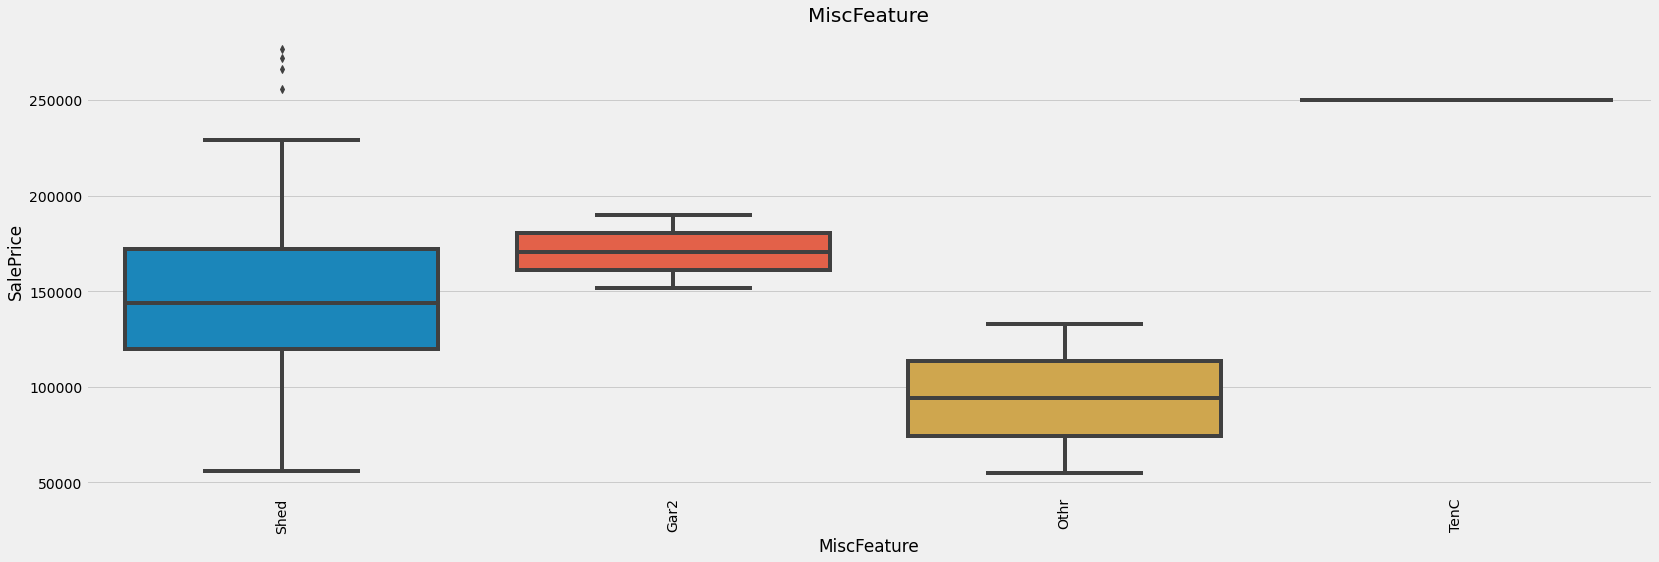

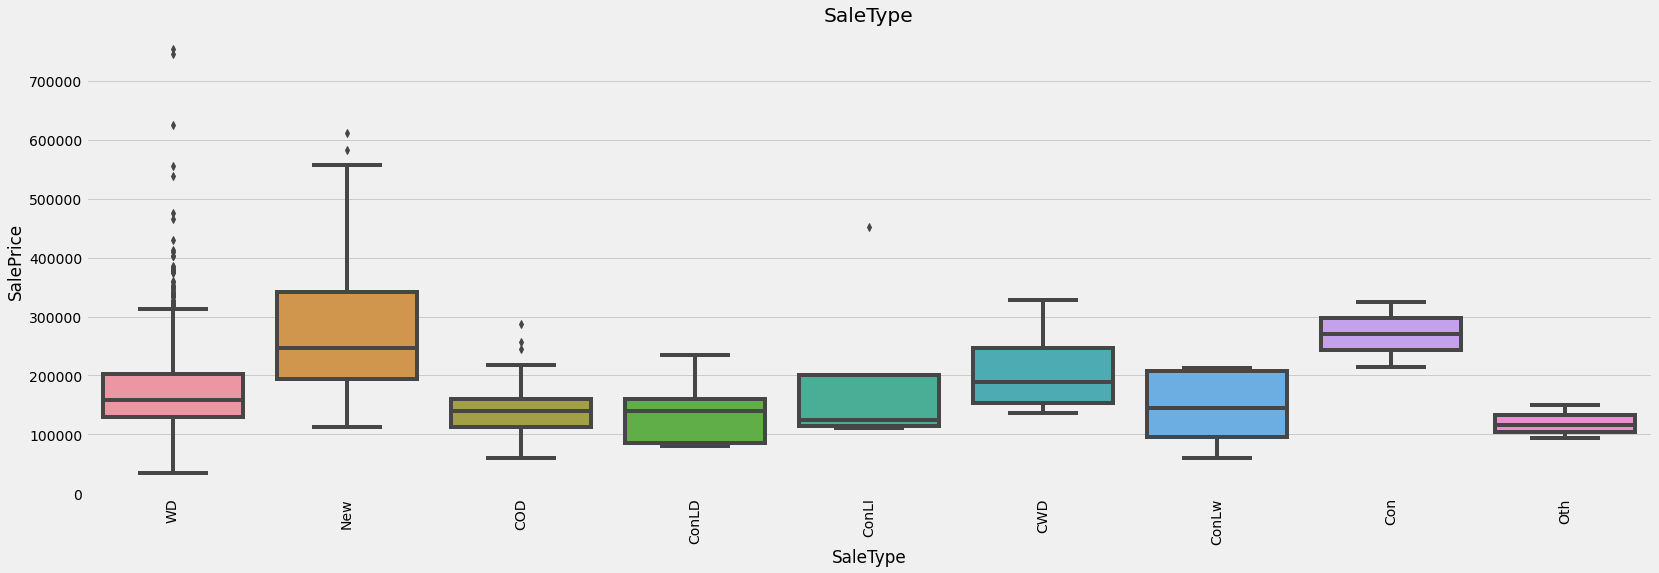

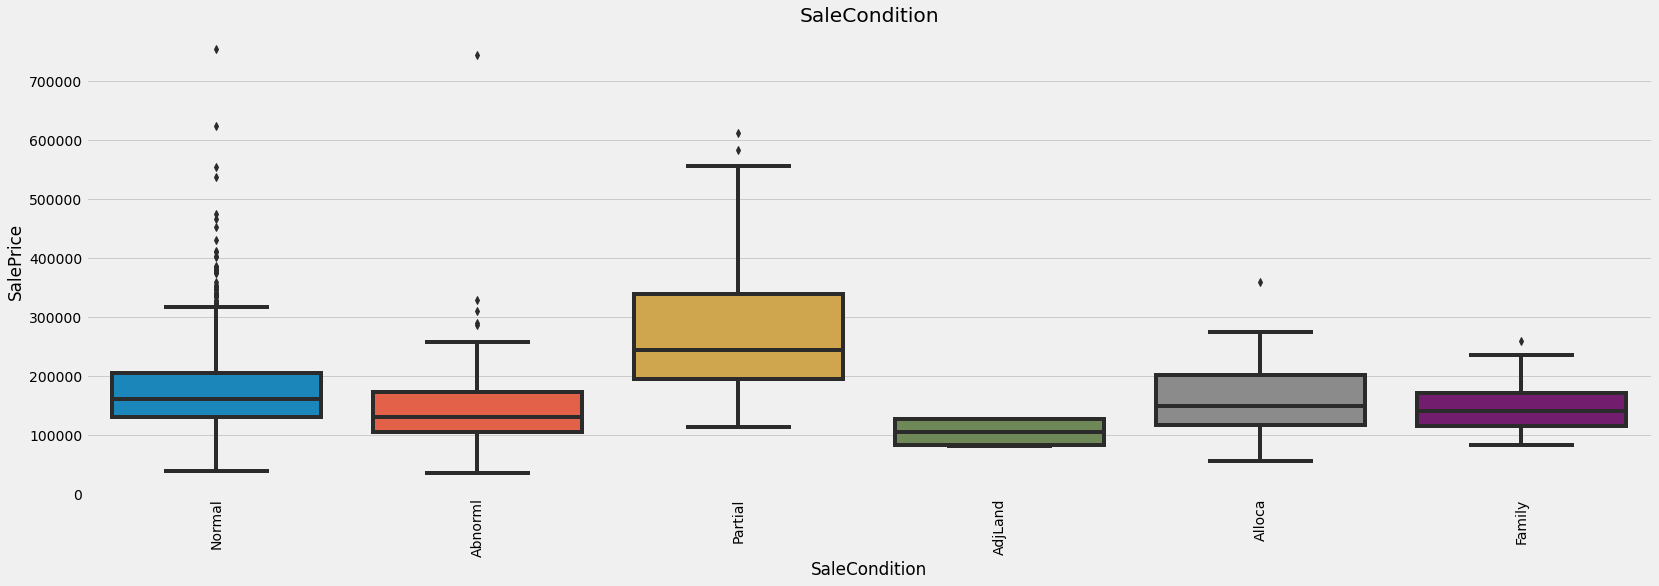

In [293]:
print("Distribution of SalePrice according to classes of categorical features")
for n in new_cat:
    box_plot(n)

Distribution of numerical features


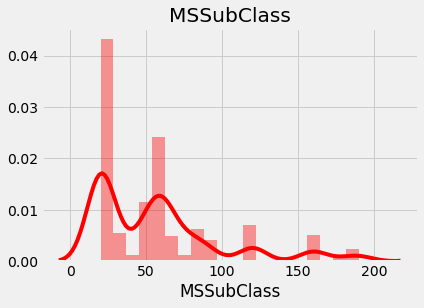

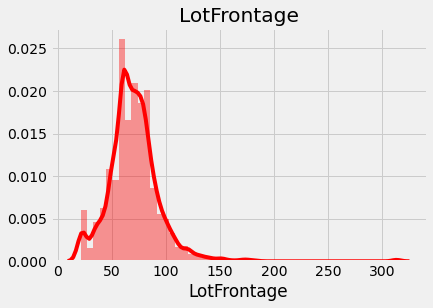

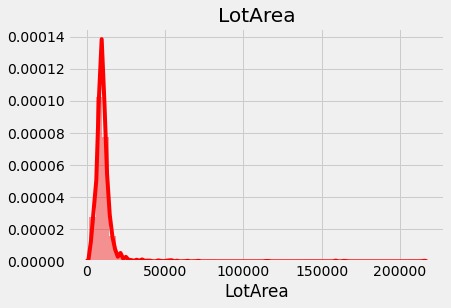

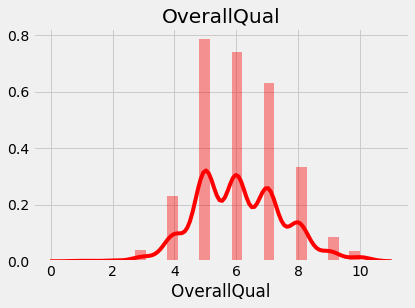

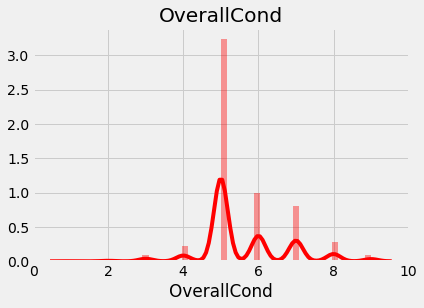

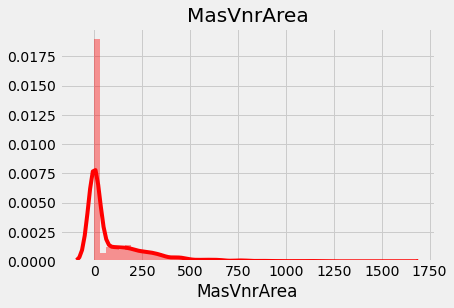

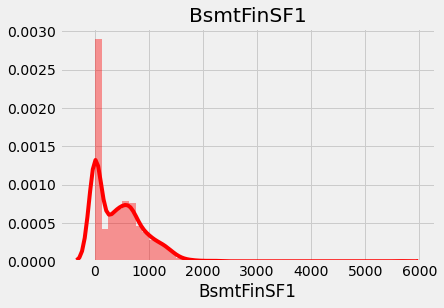

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


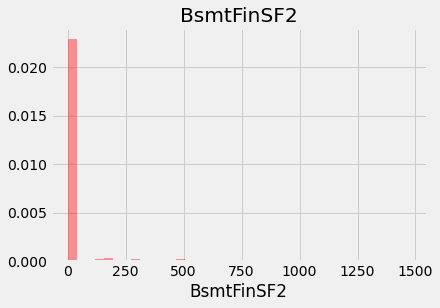

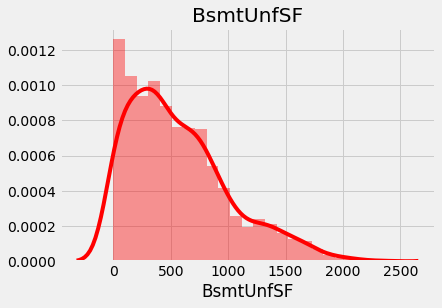

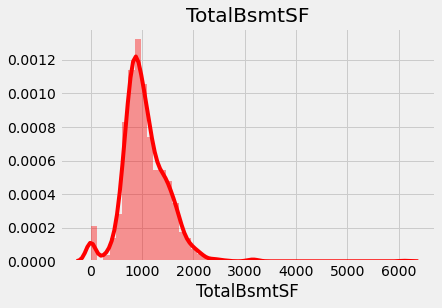

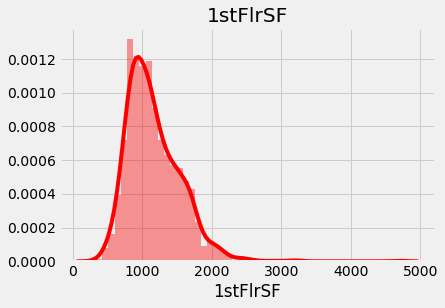

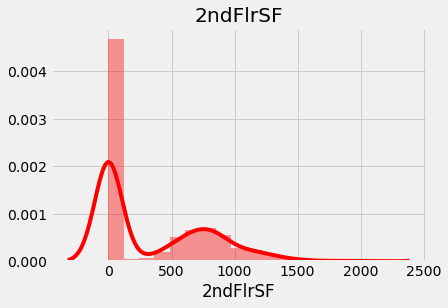

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


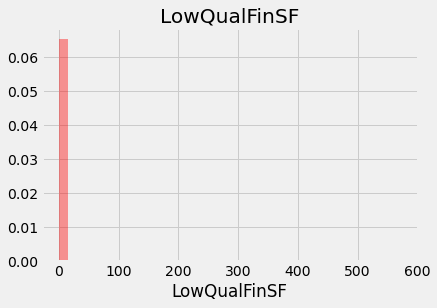

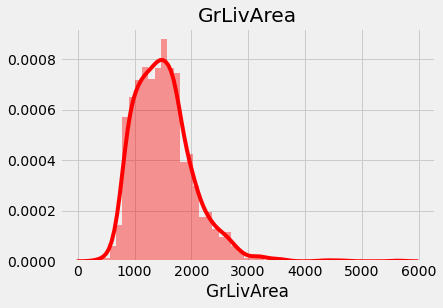

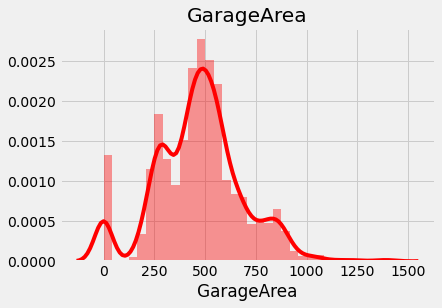

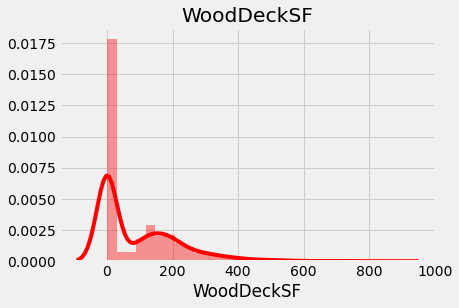

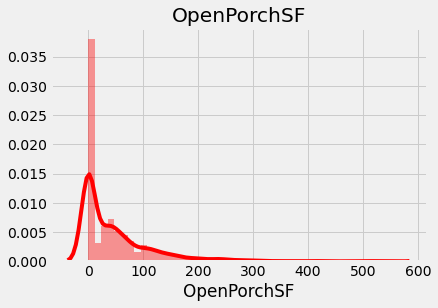

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


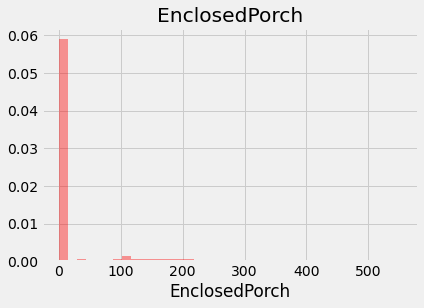

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


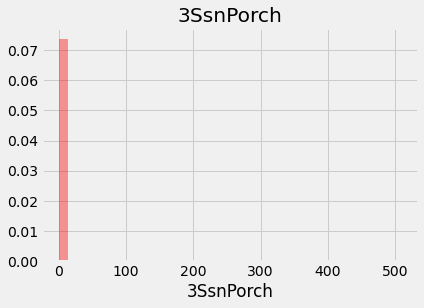

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


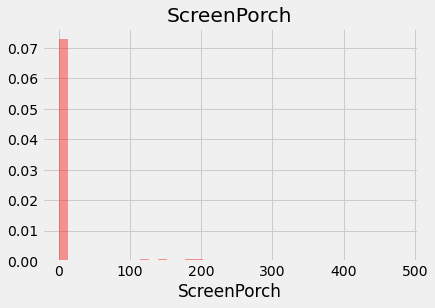

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


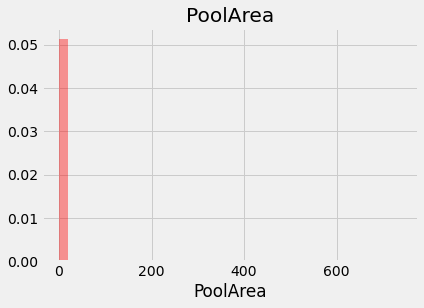

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


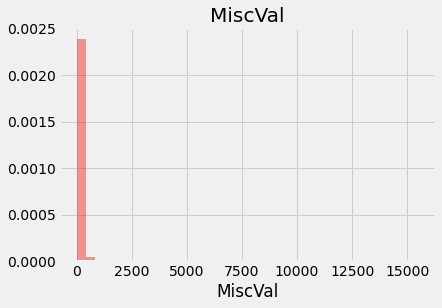

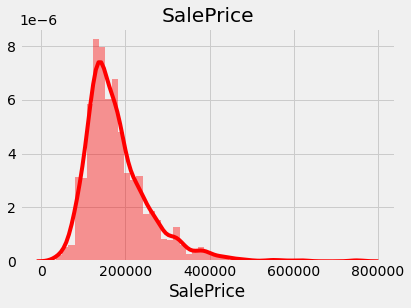

In [294]:
print('Distribution of numerical features')

for n in only_num[1:]:
    num_plot(n)

Distribution of SalePrice vs Numerical features


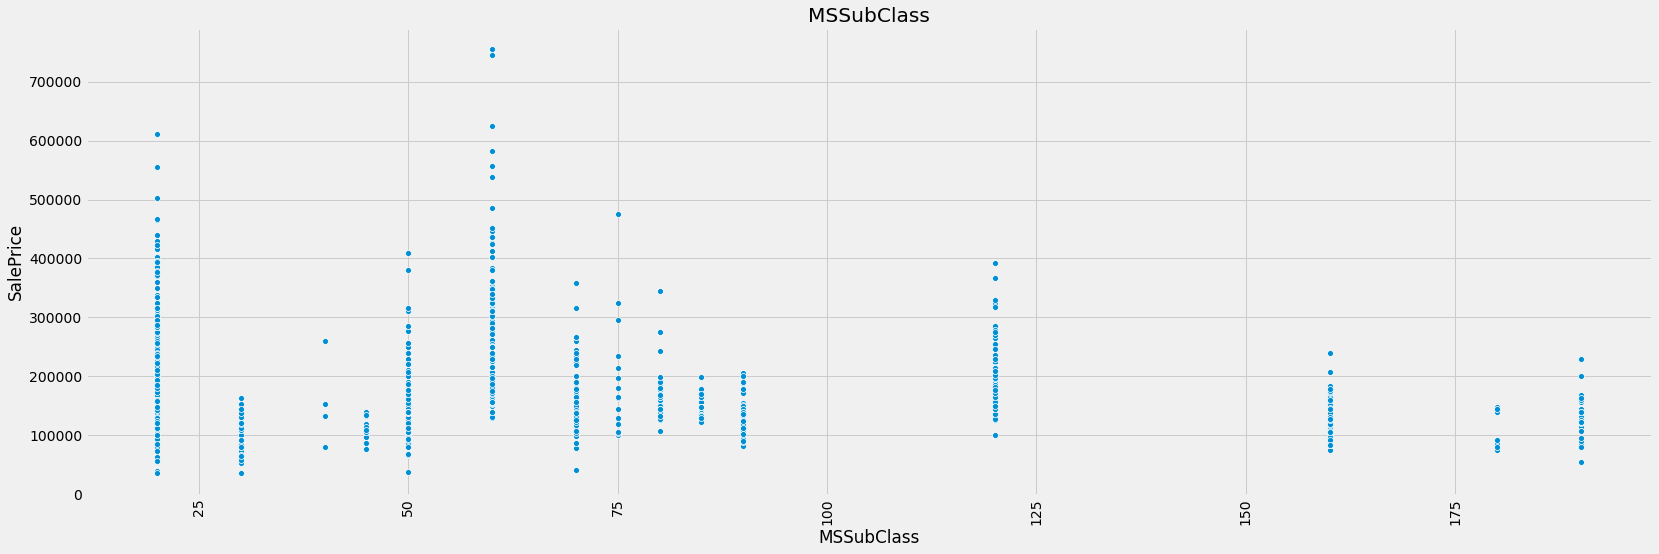

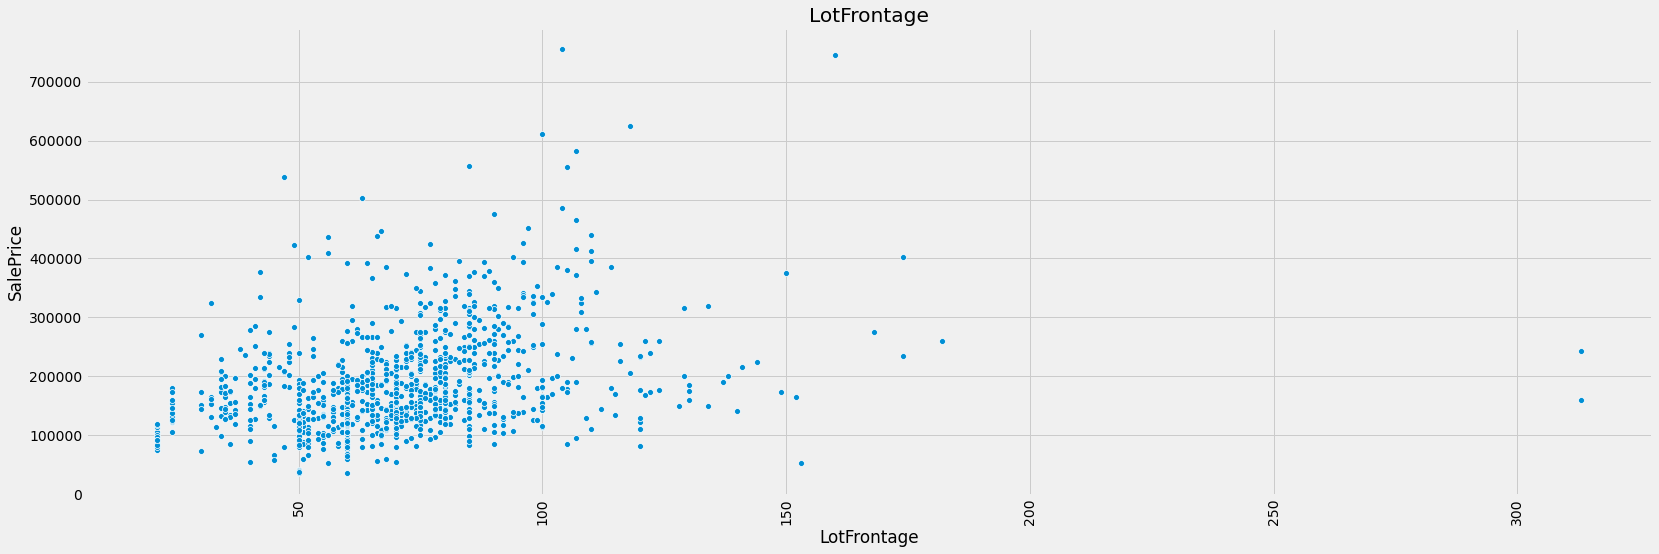

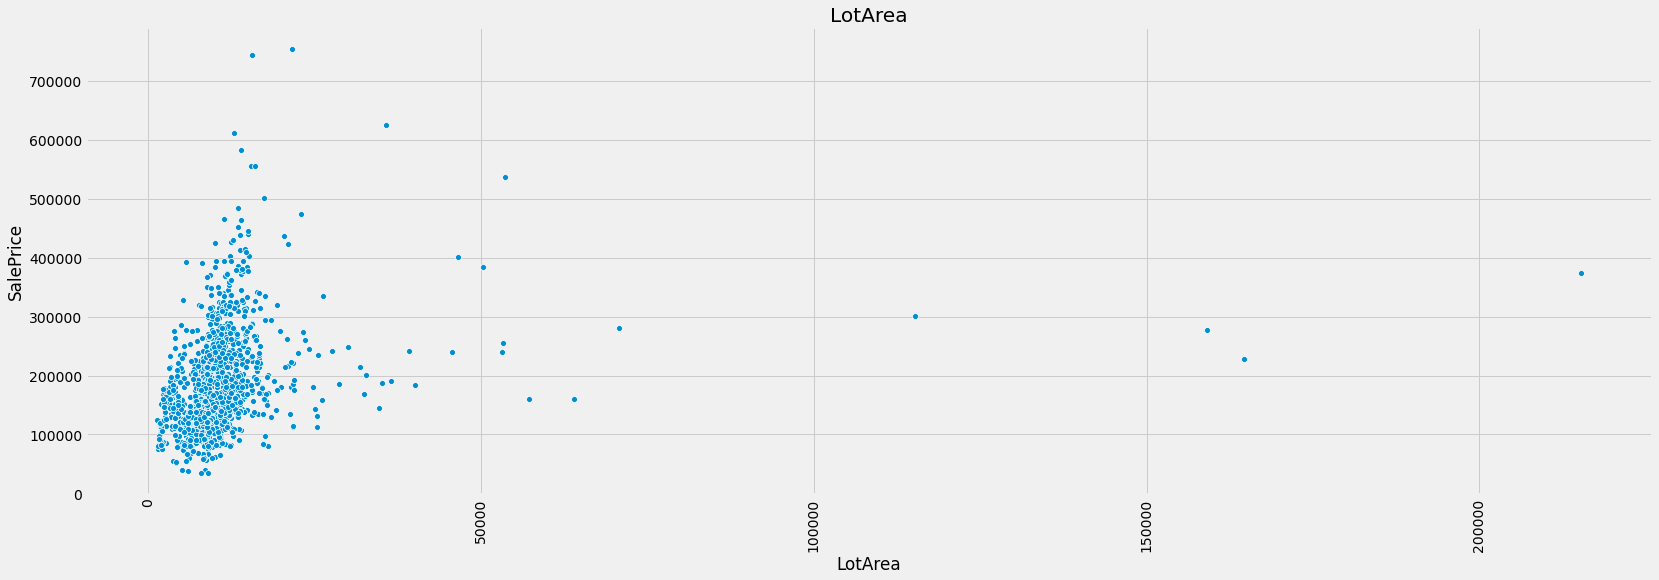

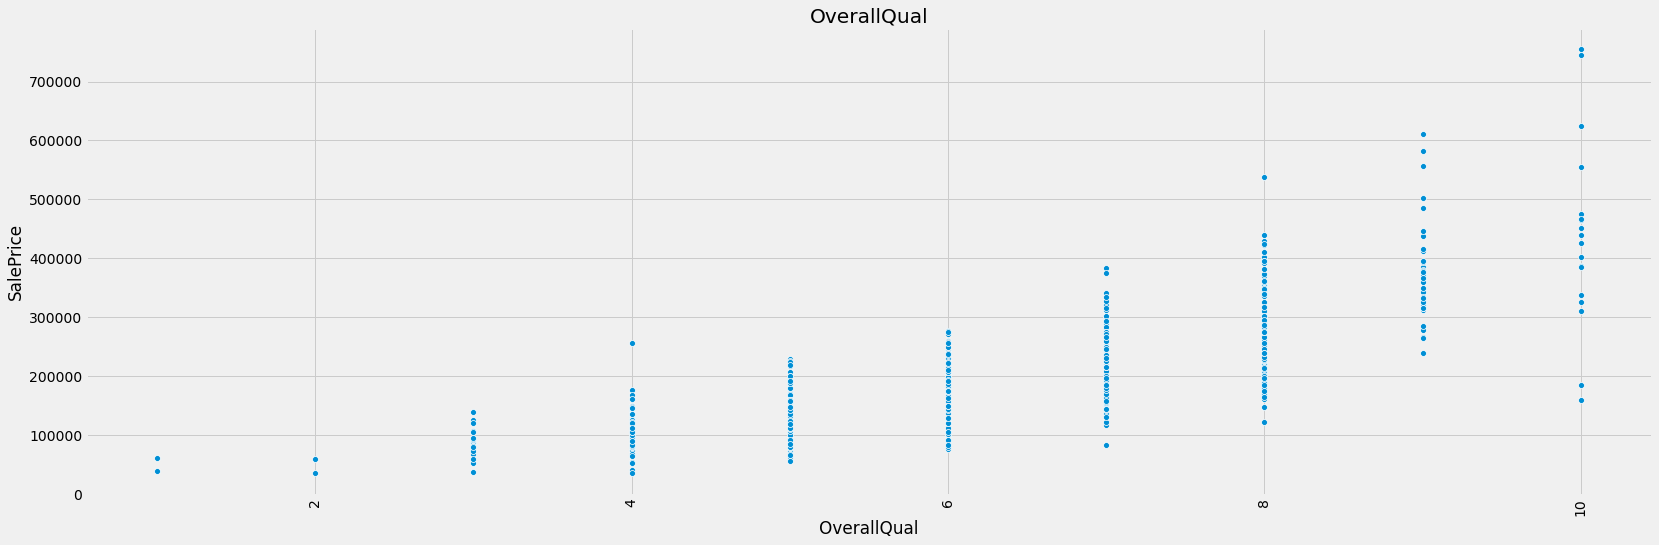

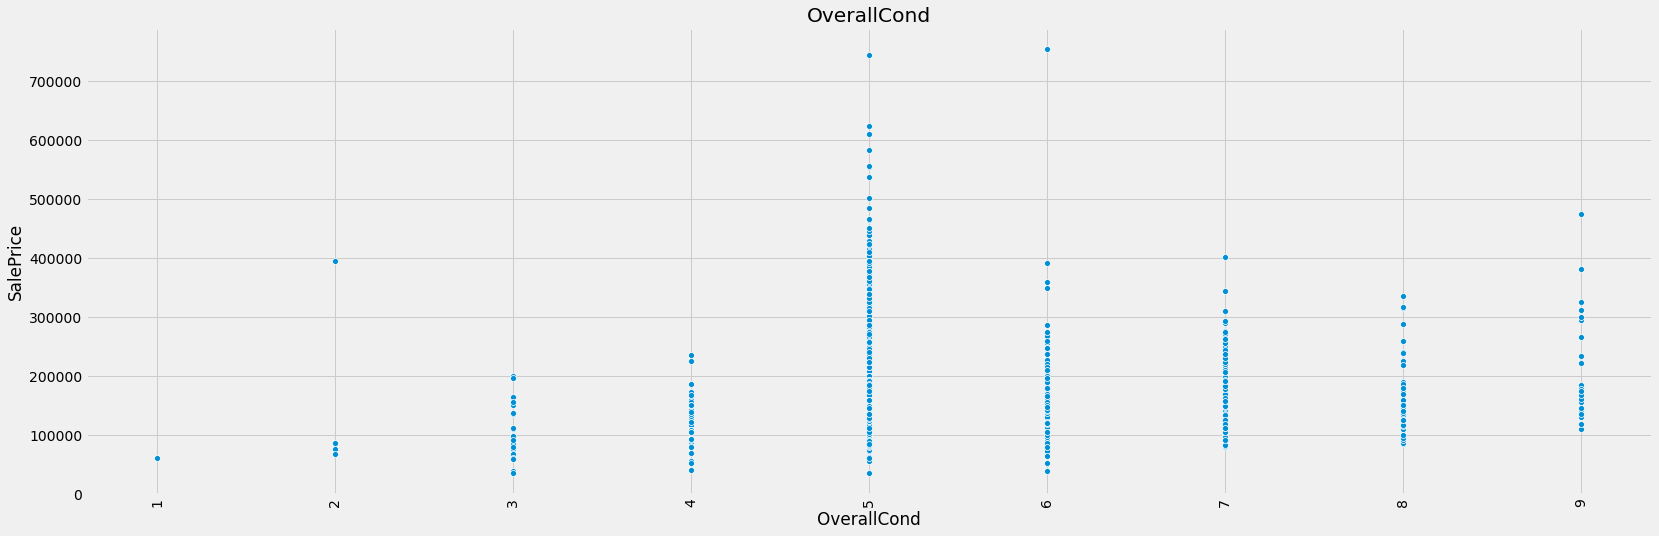

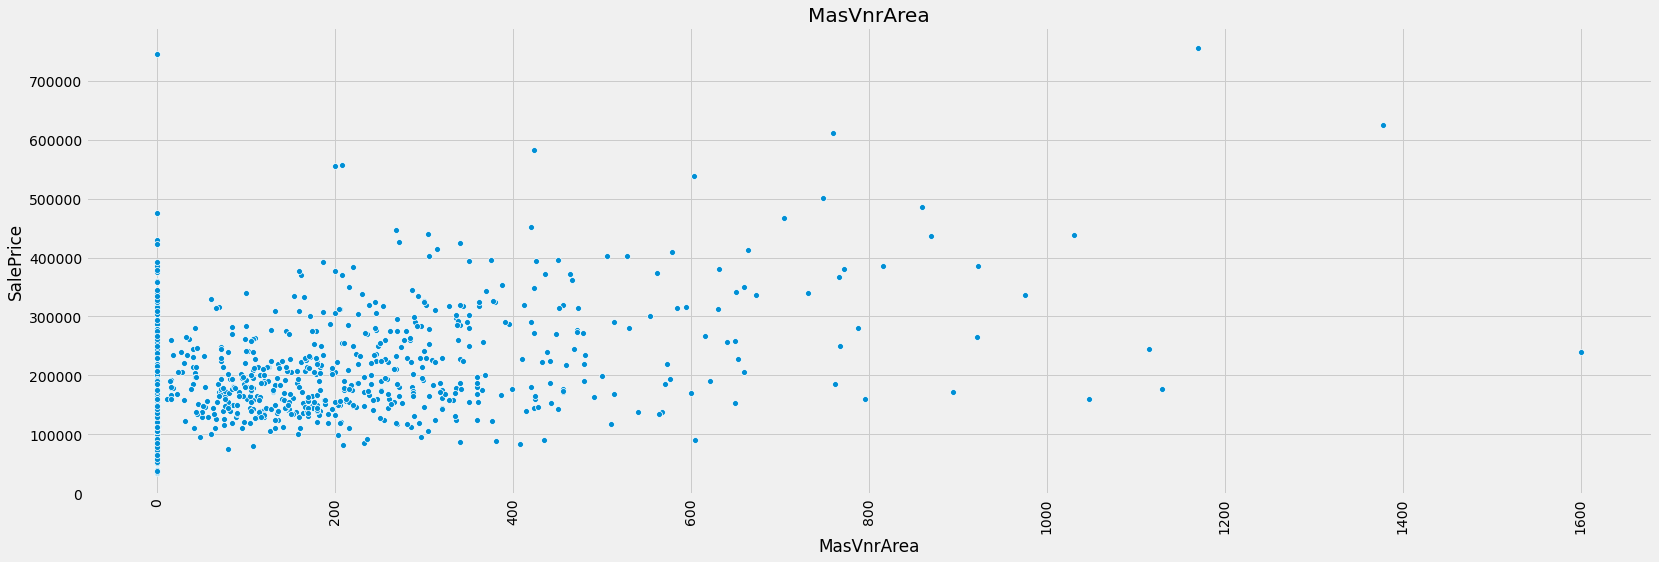

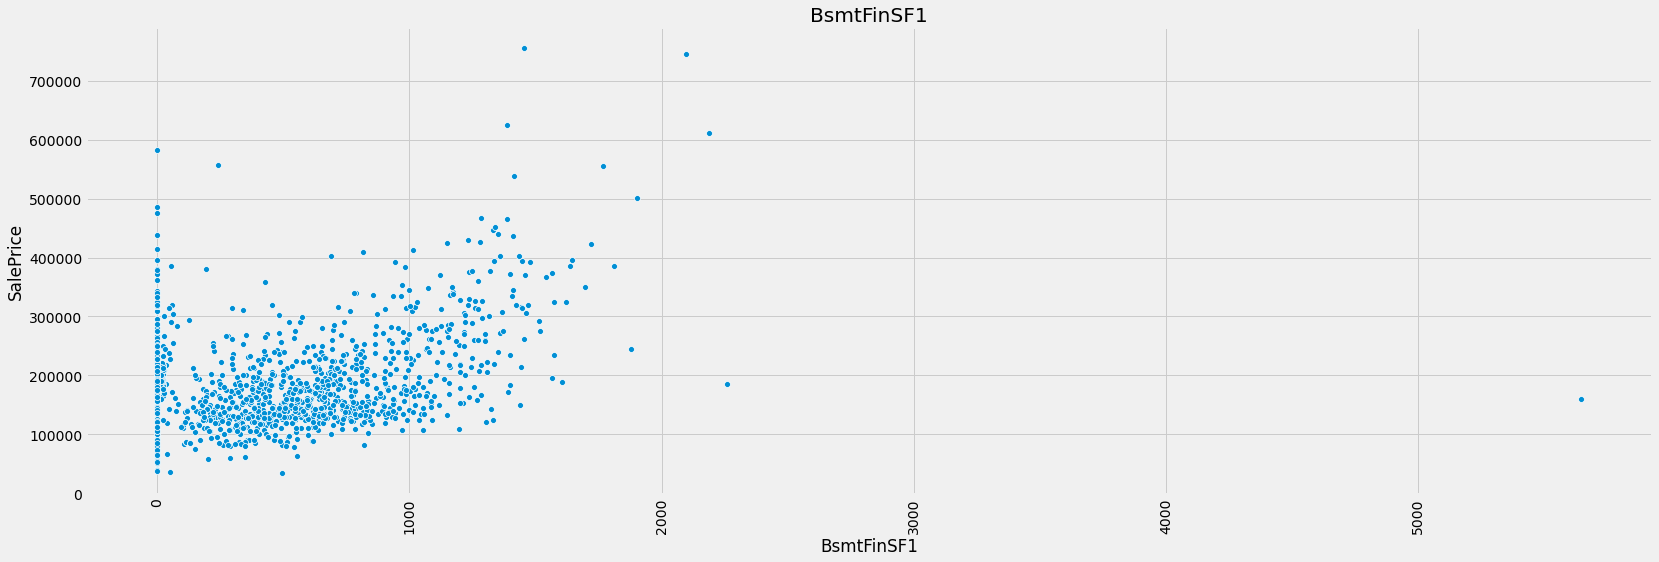

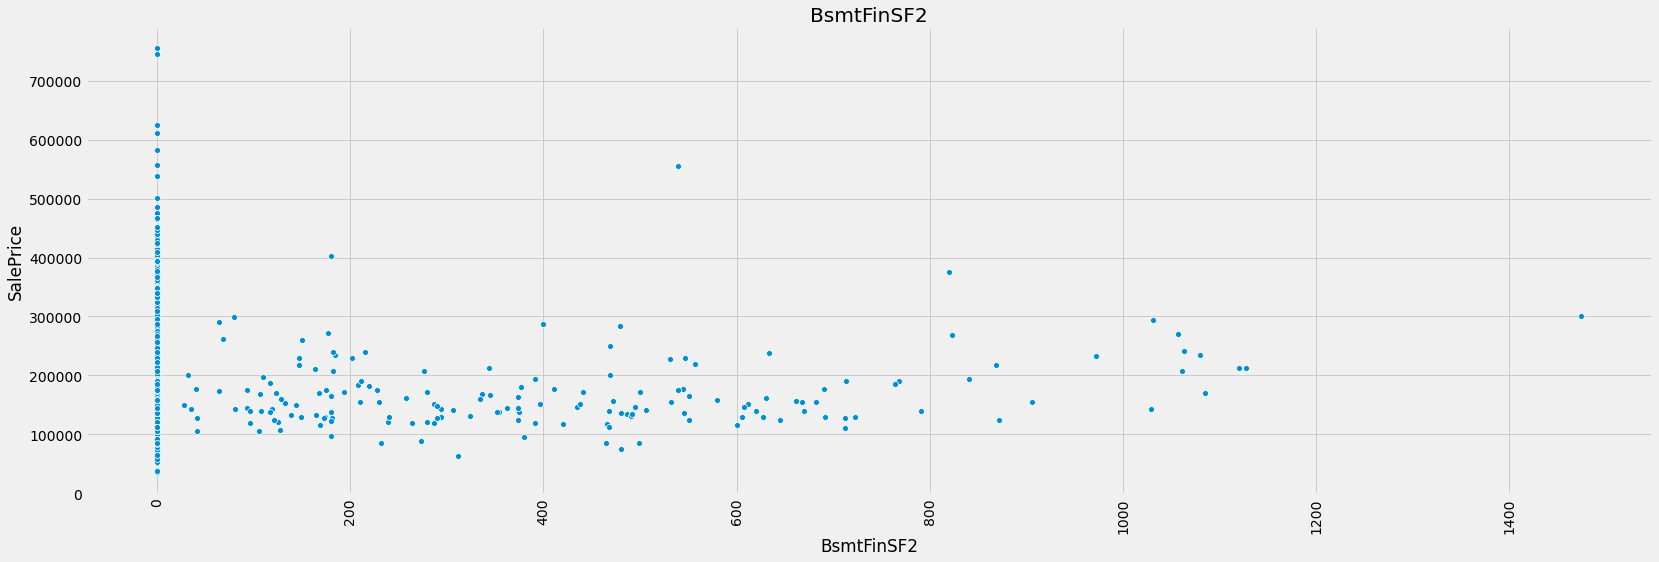

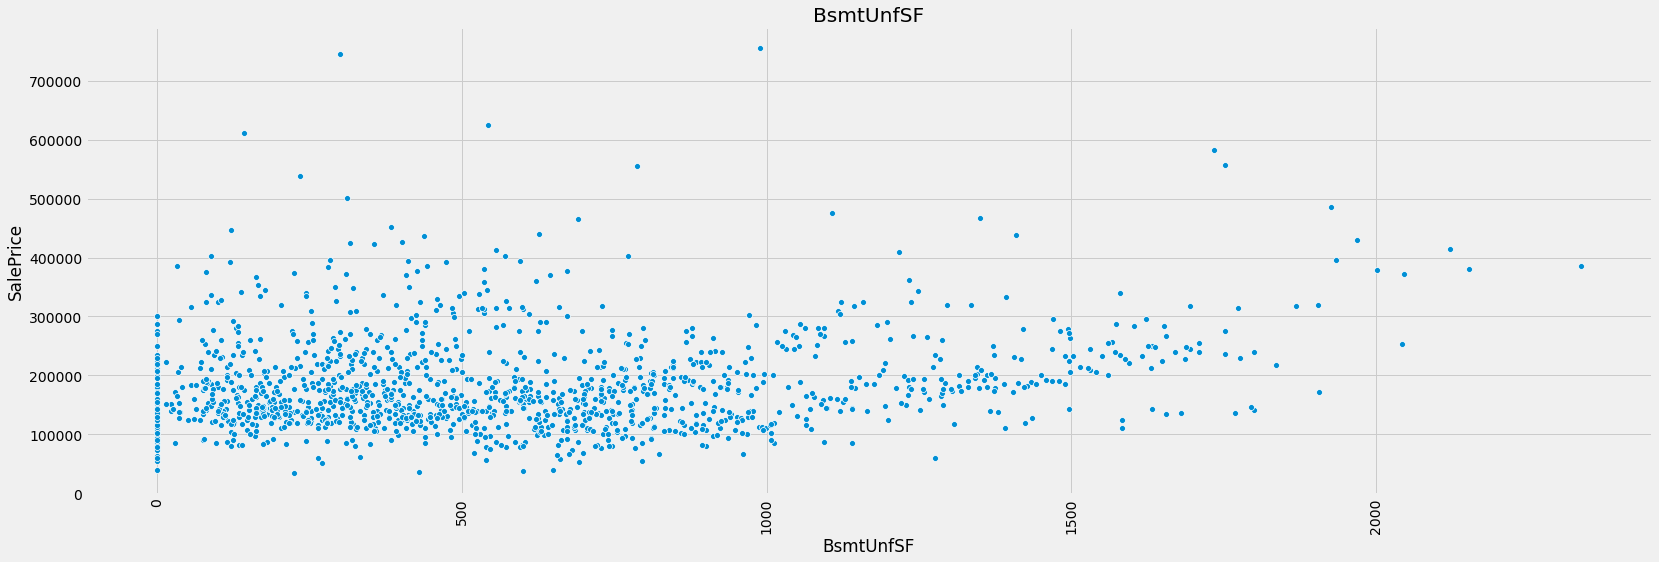

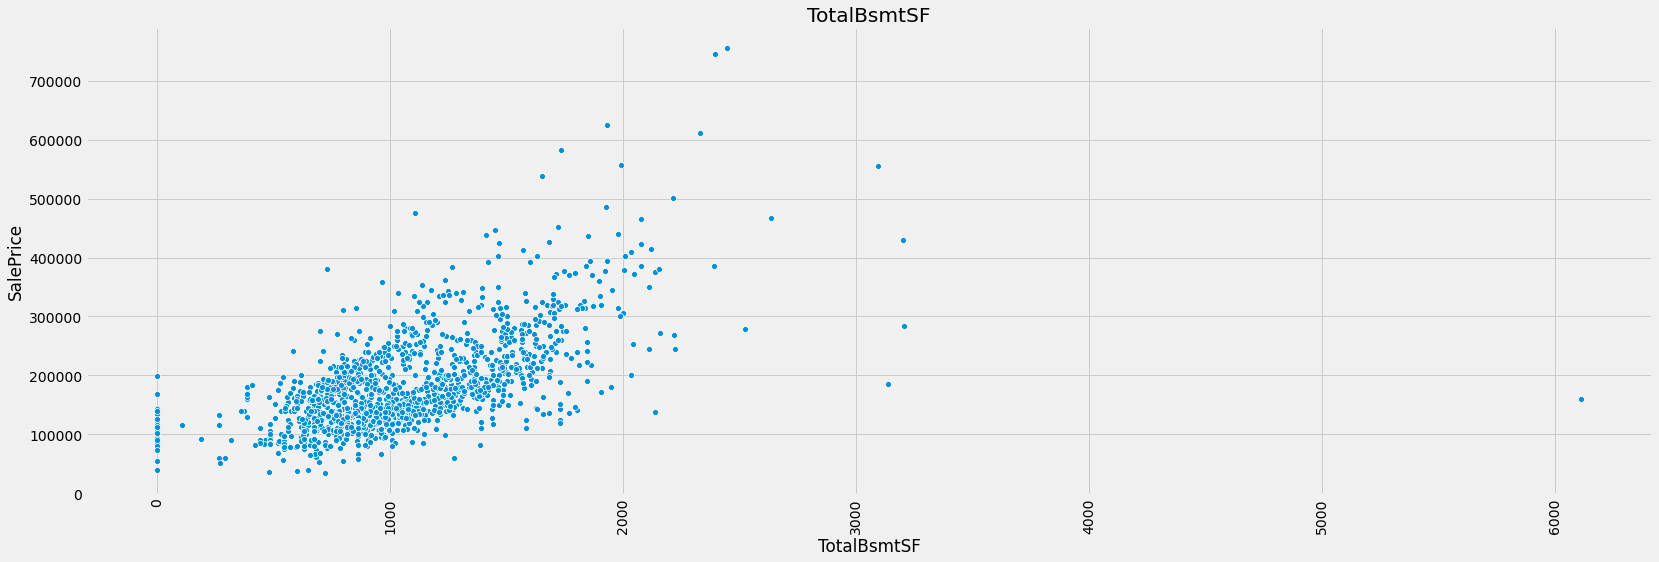

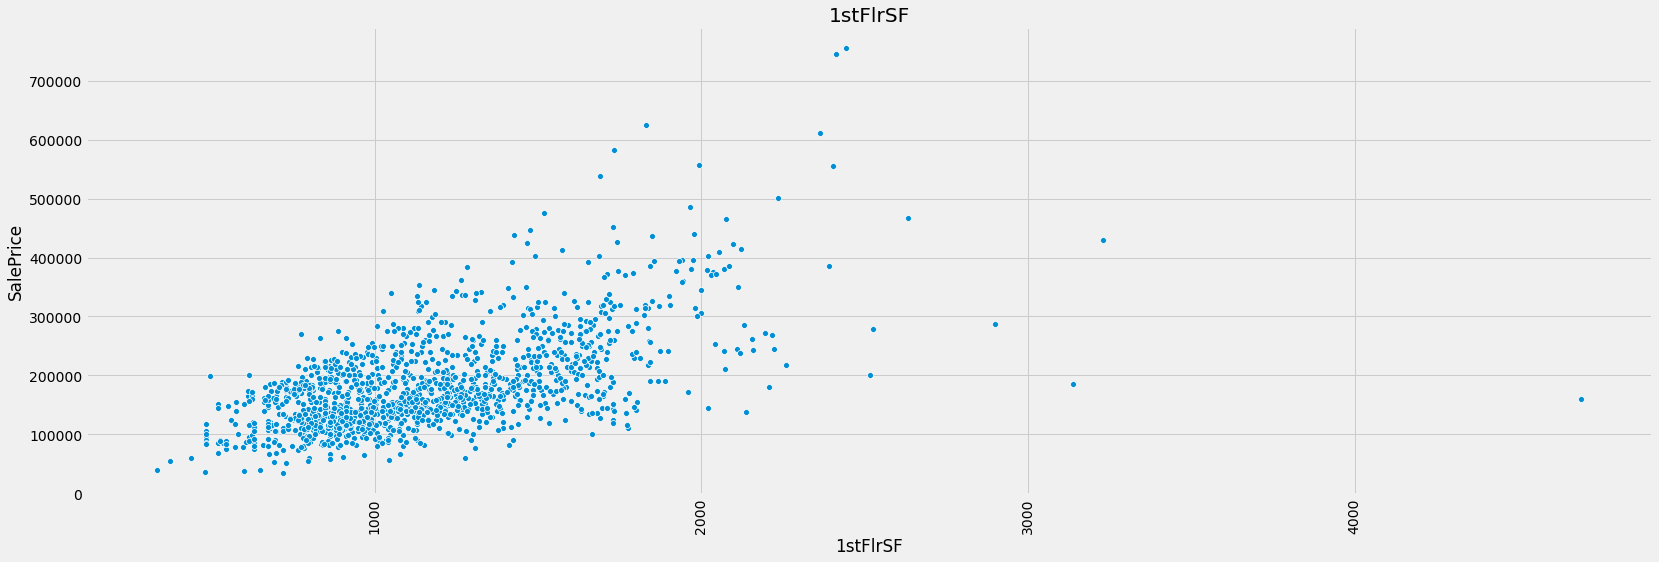

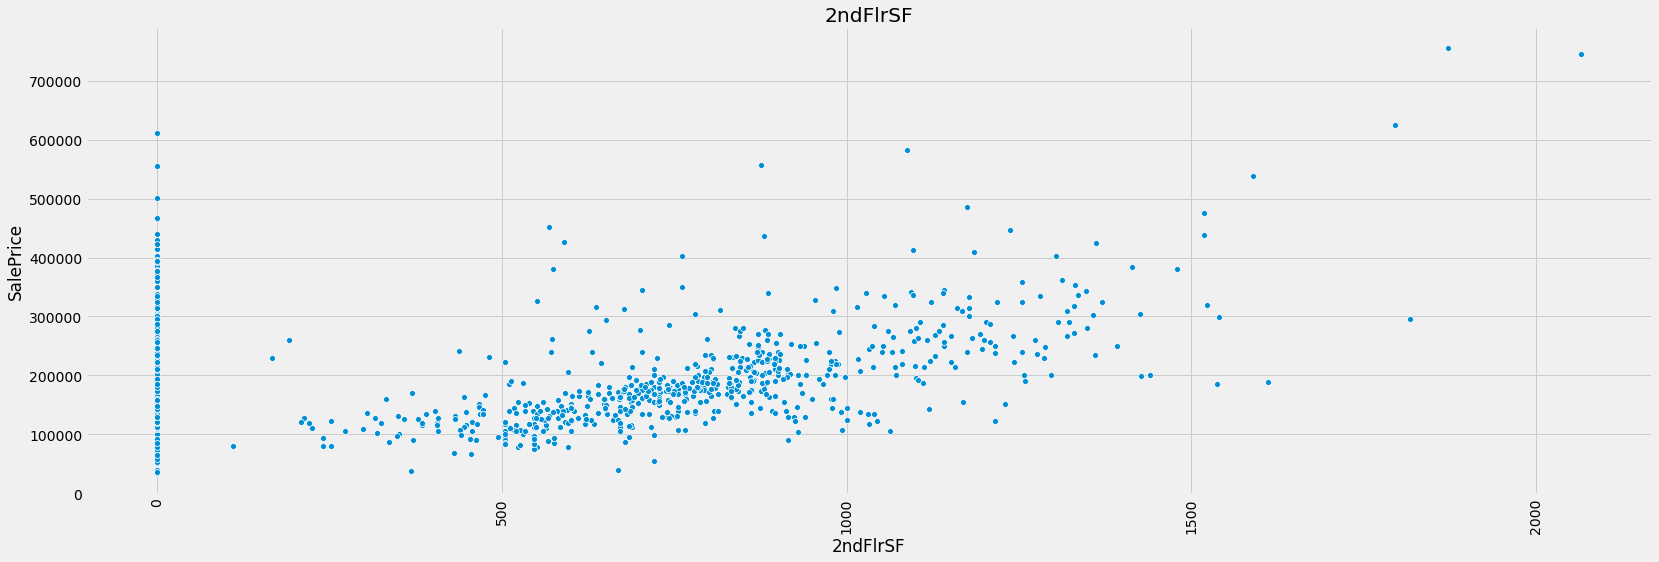

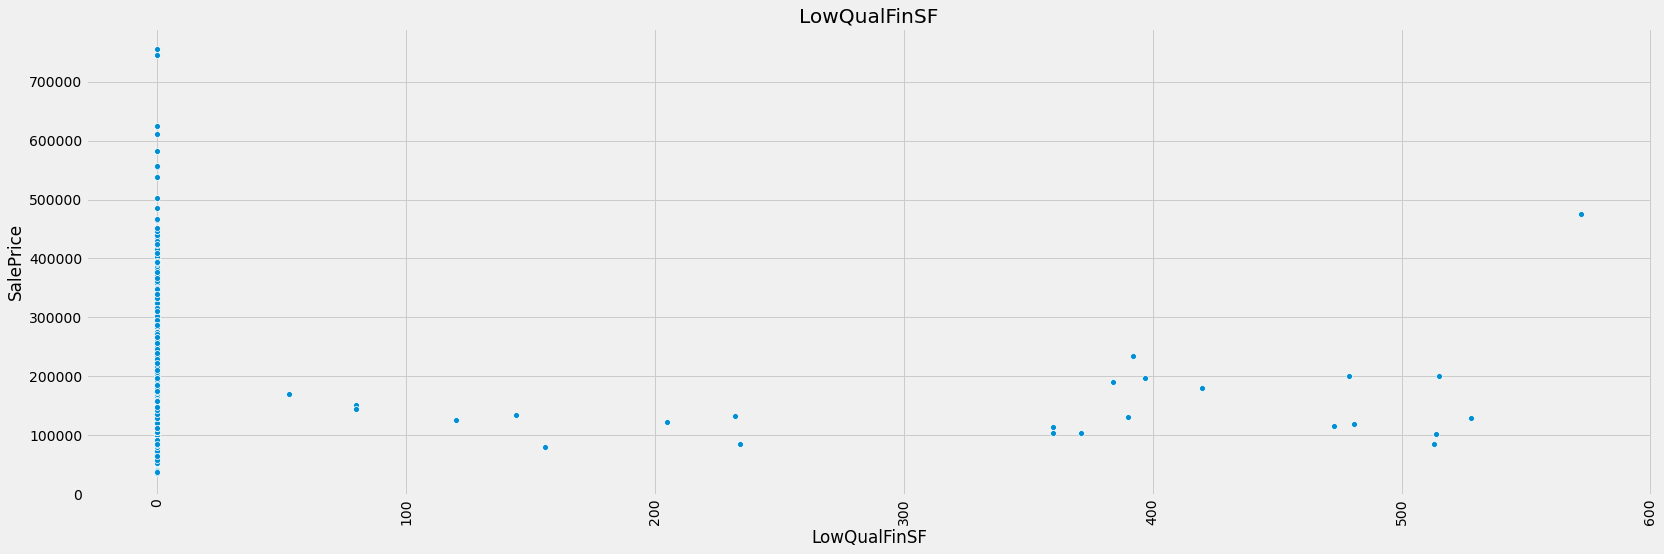

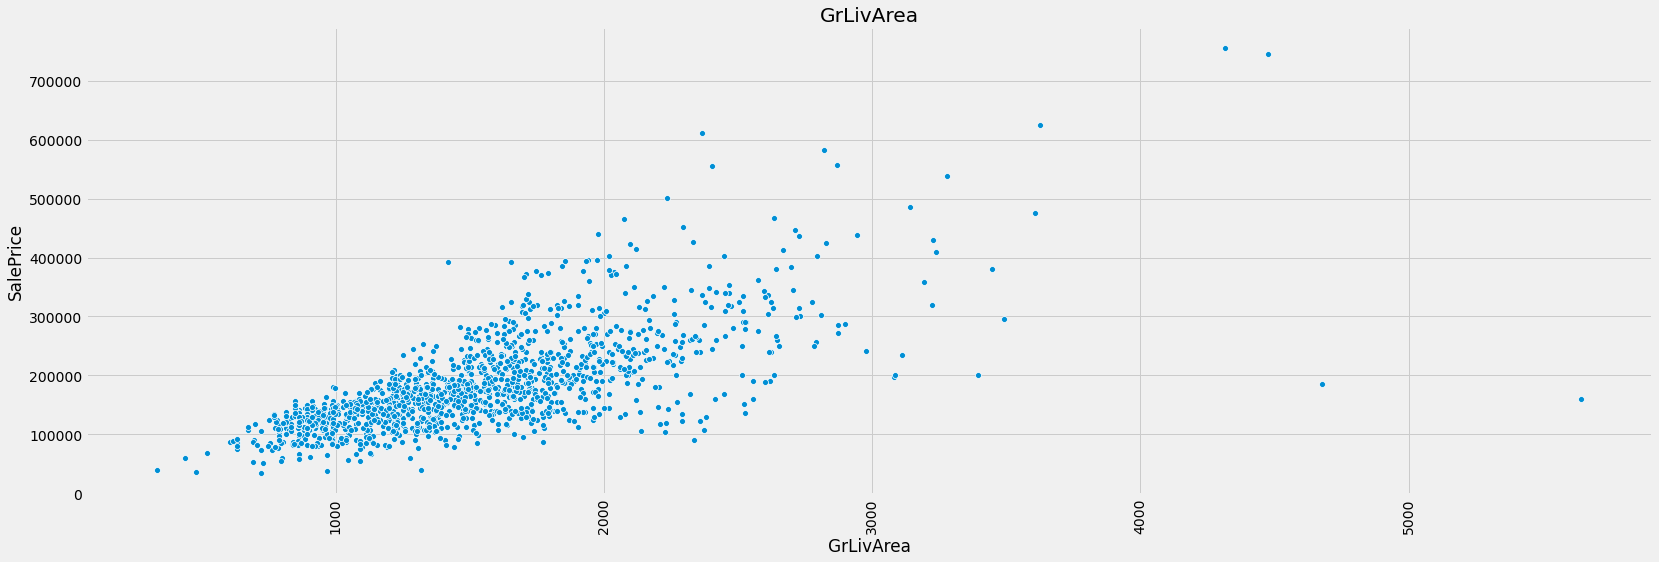

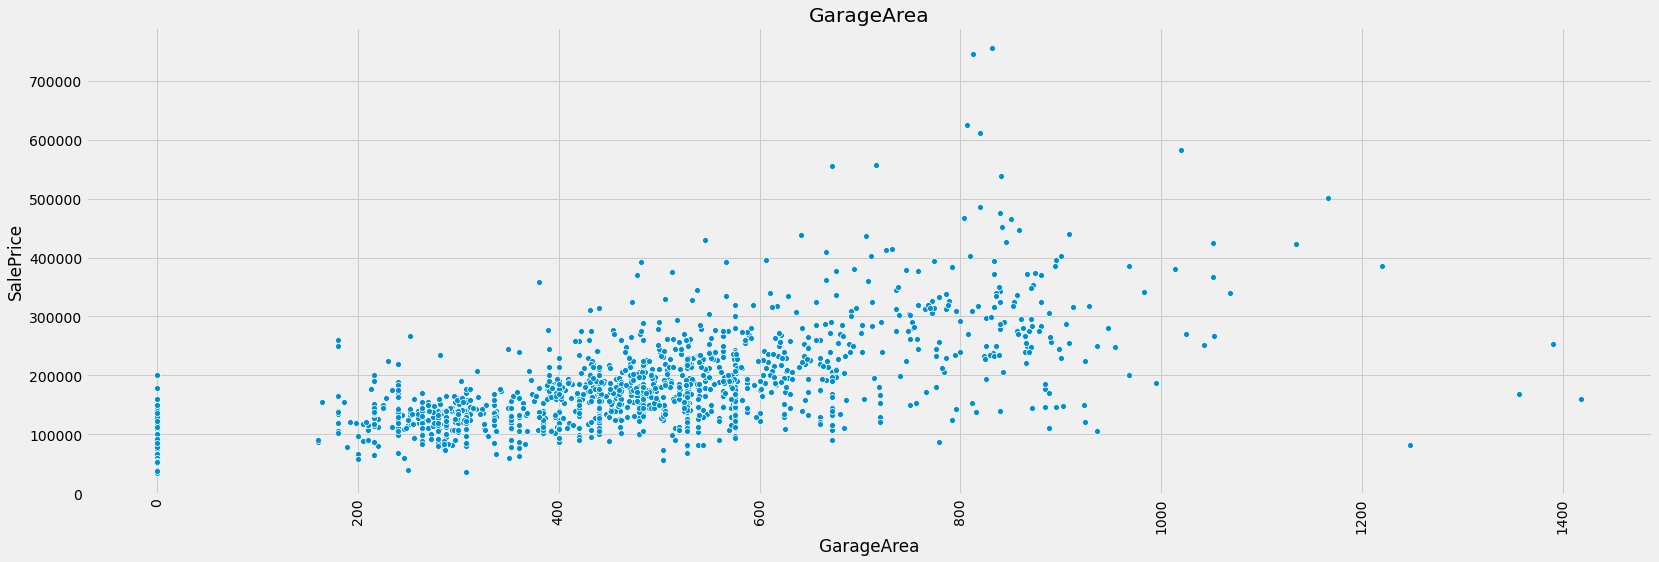

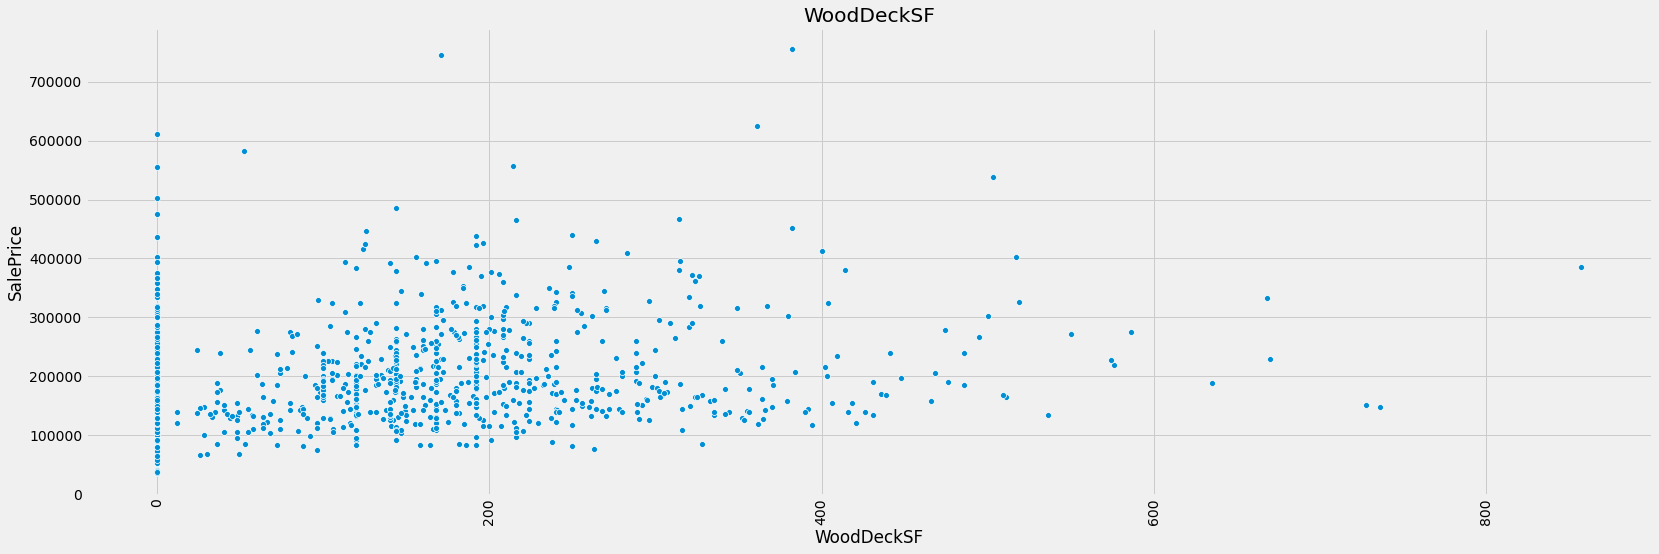

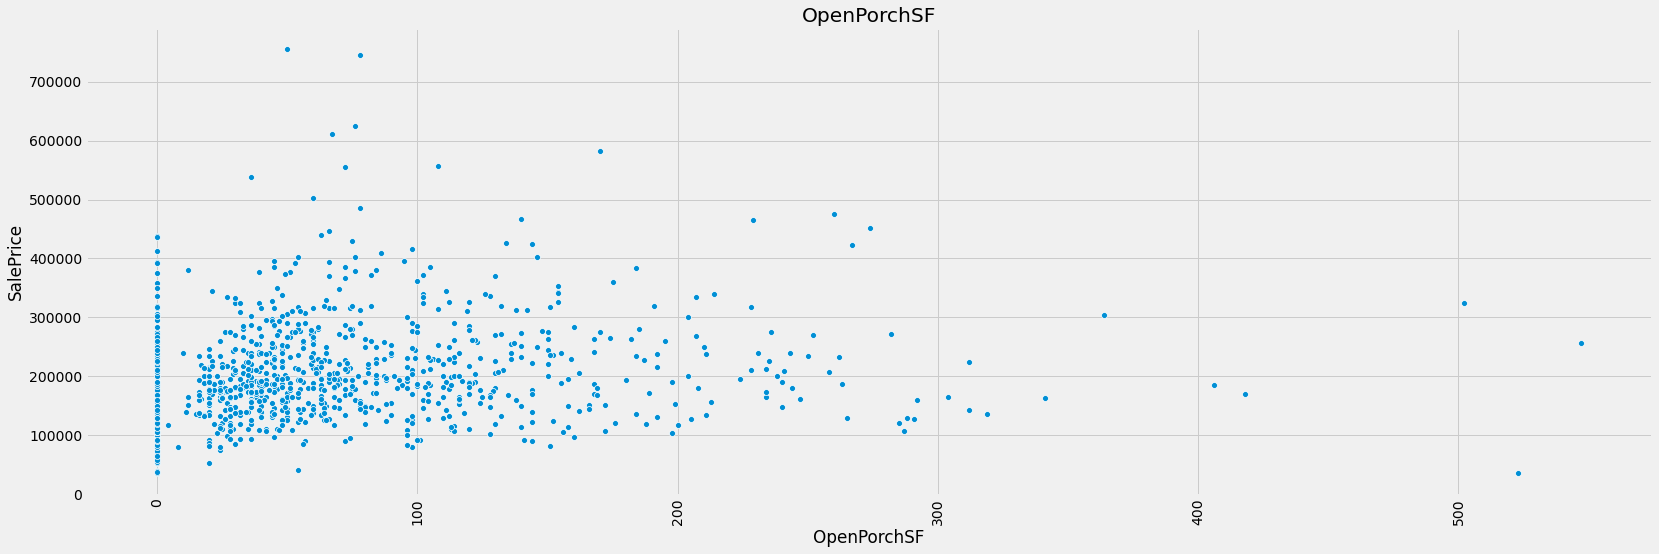

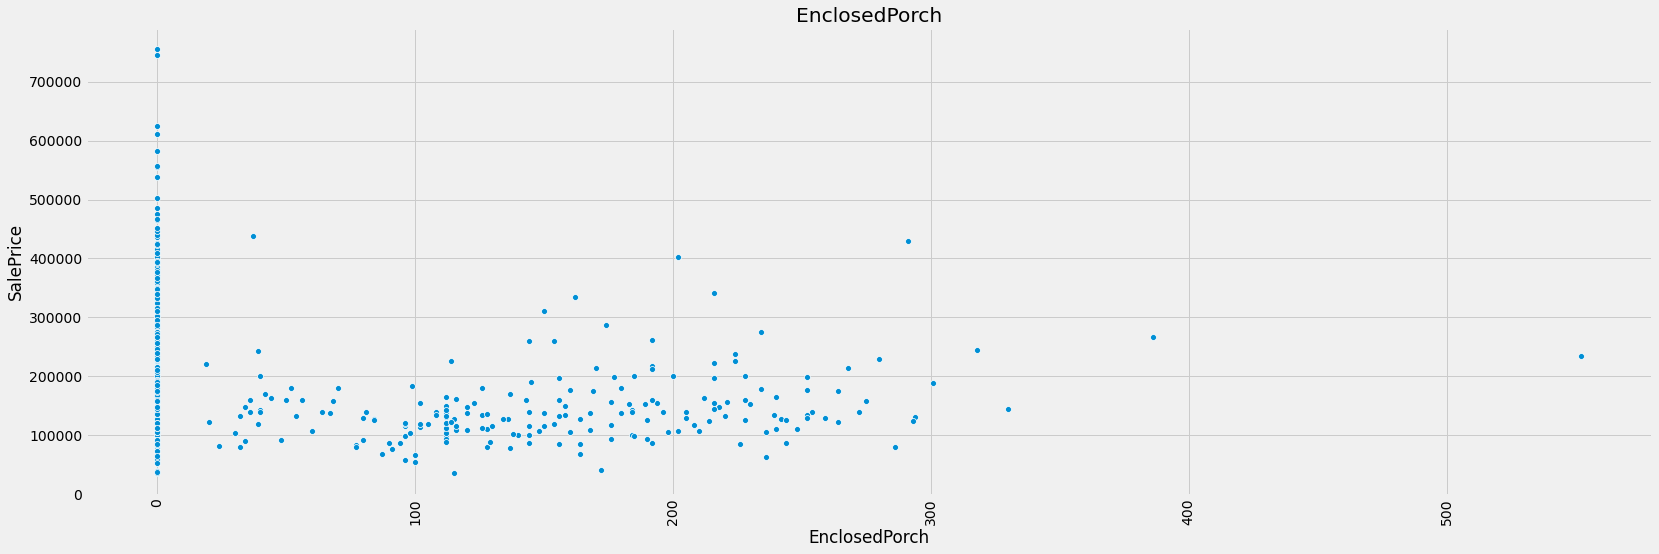

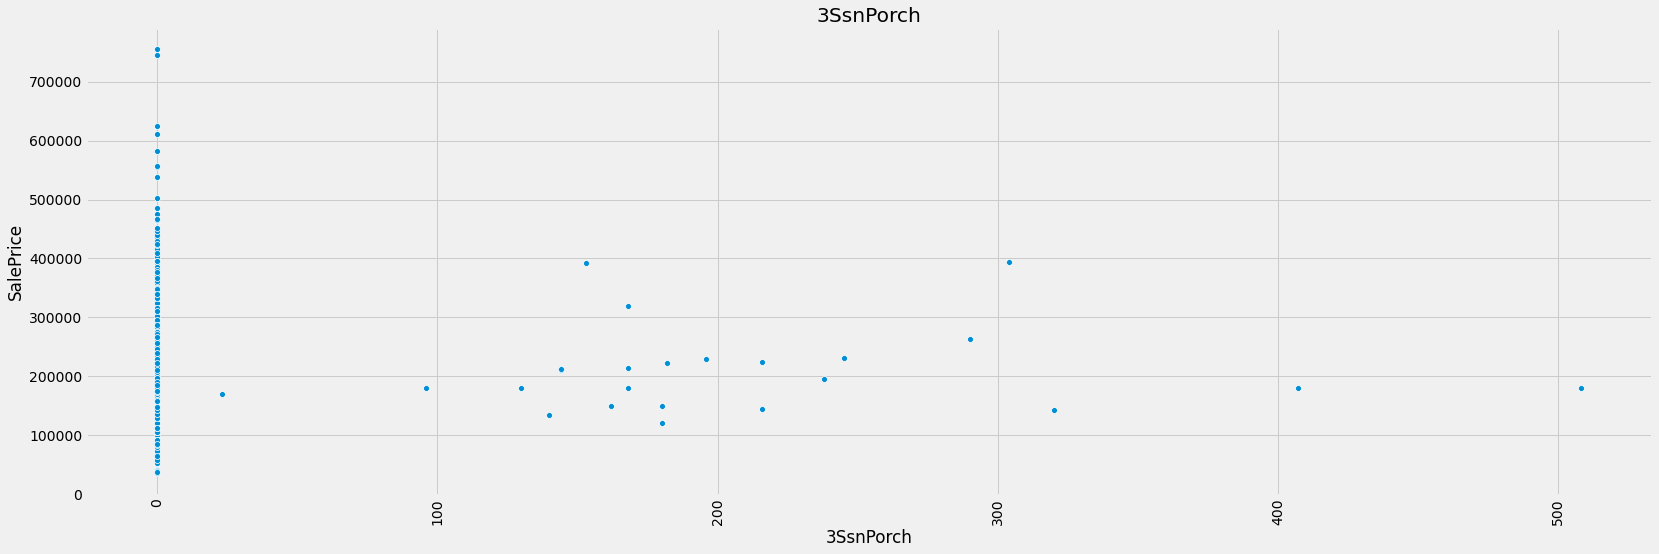

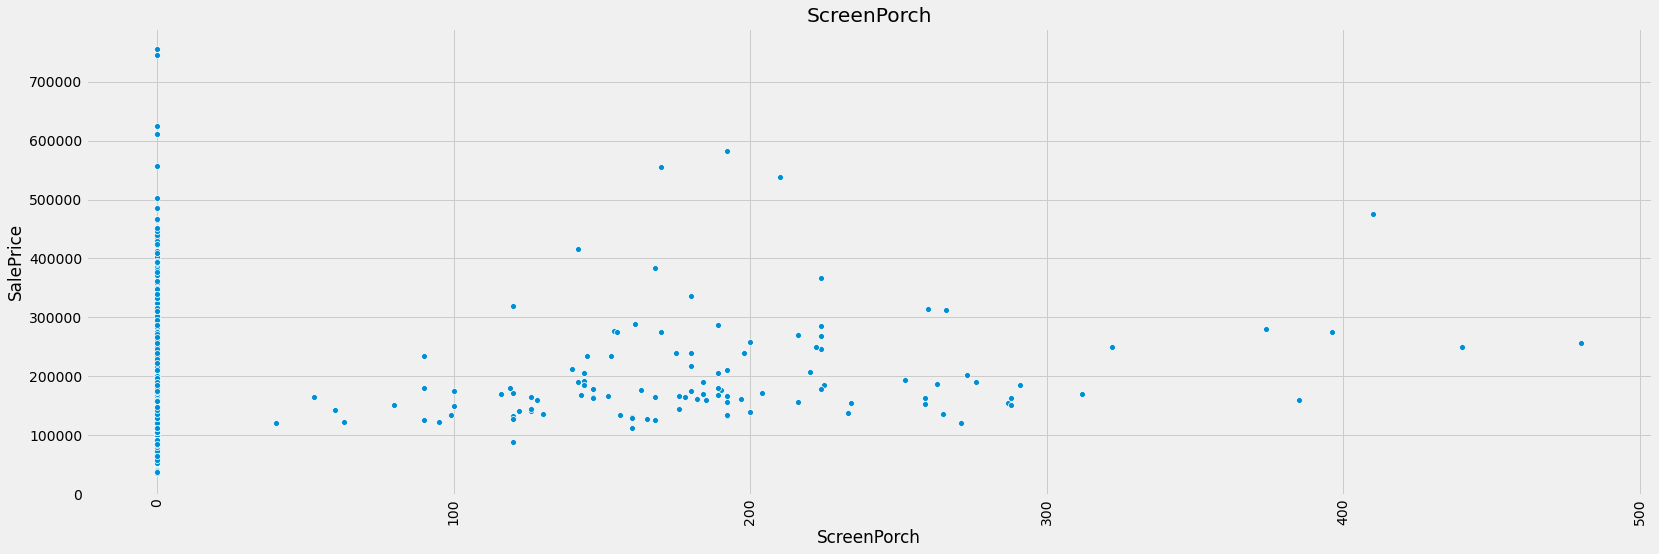

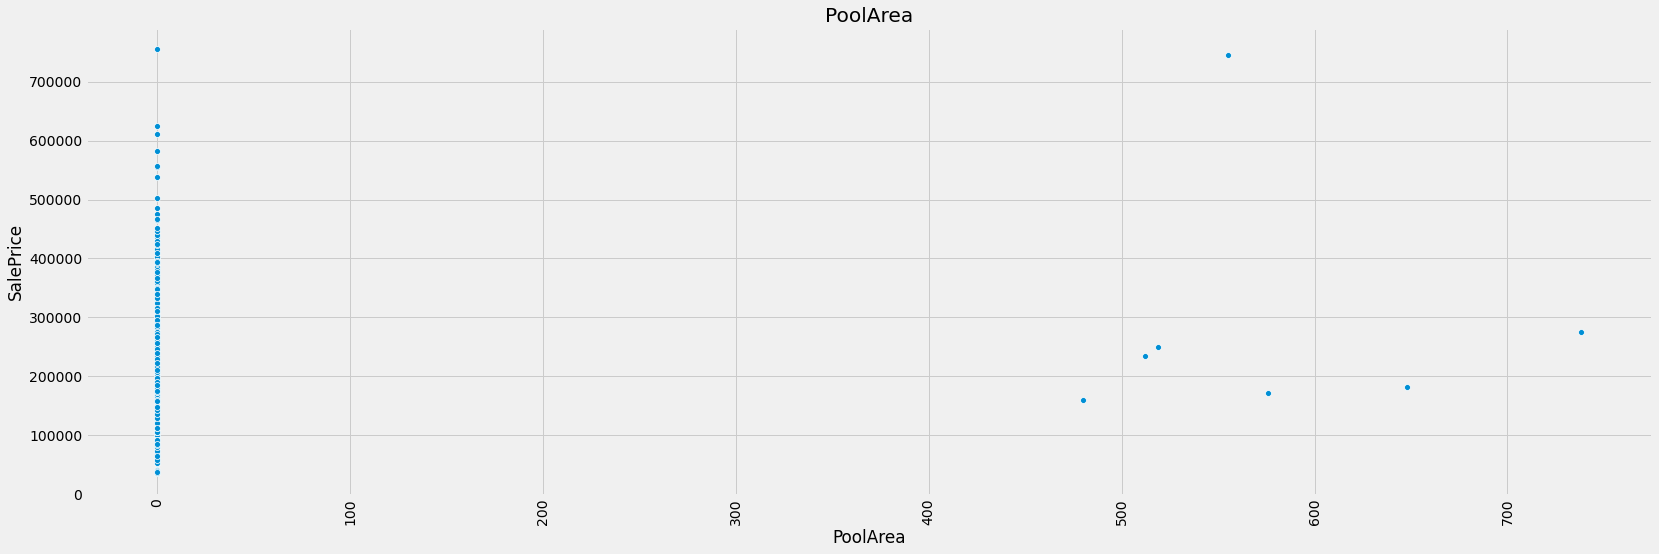

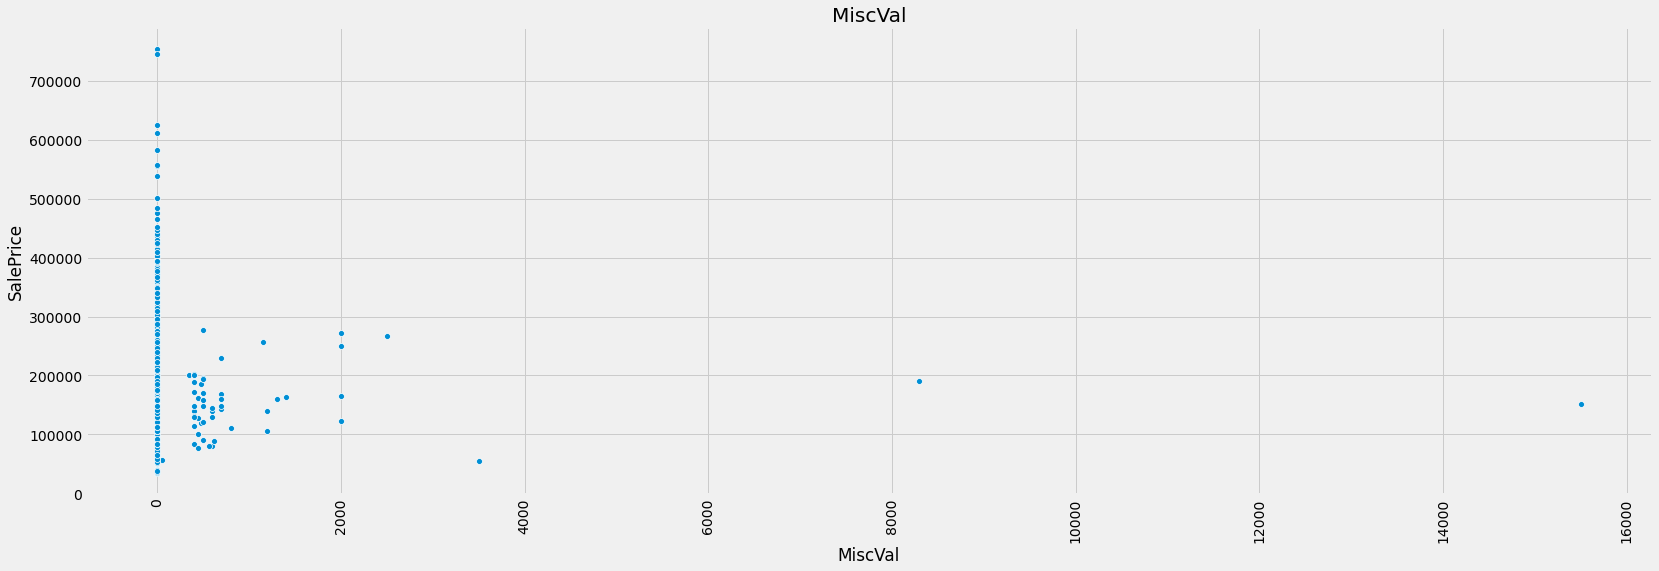

In [295]:
print("Distribution of SalePrice vs Numerical features")
for n in only_num[1:-1]:
    scat_plot(n)

In [310]:
#Observations:
#to determine outlier elimination for:
#1. GrLivArea
#2. OverallQual

Probplot of SalePrice


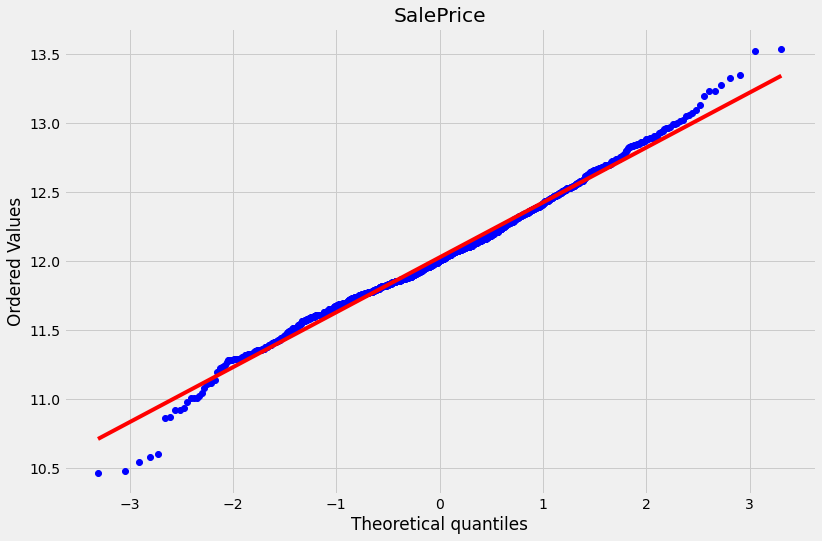

In [302]:
print('Probplot of SalePrice')
prob_plot('SalePrice')

# SalePrice normalization

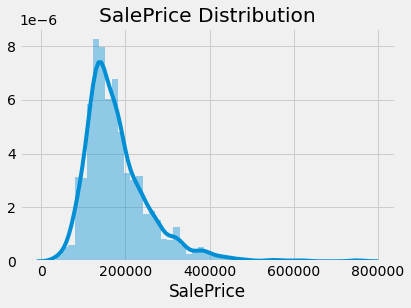

In [304]:
plt.title('SalePrice Distribution')
sns.distplot(train.SalePrice)

In [305]:
train.SalePrice=np.log1p(train.SalePrice)

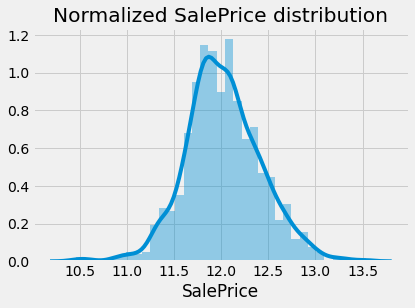

In [306]:
plt.title('Normalized SalePrice distribution')
sns.distplot(train.SalePrice)

# OUTLIER ELIMINATION

In [307]:
train.drop(train[(train.GrLivArea>4500) & (train.SalePrice<200000)].index,inplace=True)
train.drop(train[(train.OverallQual<5) & (train.SalePrice>200000)].index, inplace=True)

train.reset_index(inplace=True)

In [308]:
train.drop('index',axis=1,inplace=True)

In [309]:
train.shape,test.shape

((1458, 81), (1459, 80))

# MISSING VALUES

In [311]:
train_label=train['SalePrice']
train=train.drop(['SalePrice'],axis=1)
test_id=test.Id
total=pd.concat([train,test],axis=0)
total.shape

(2917, 80)

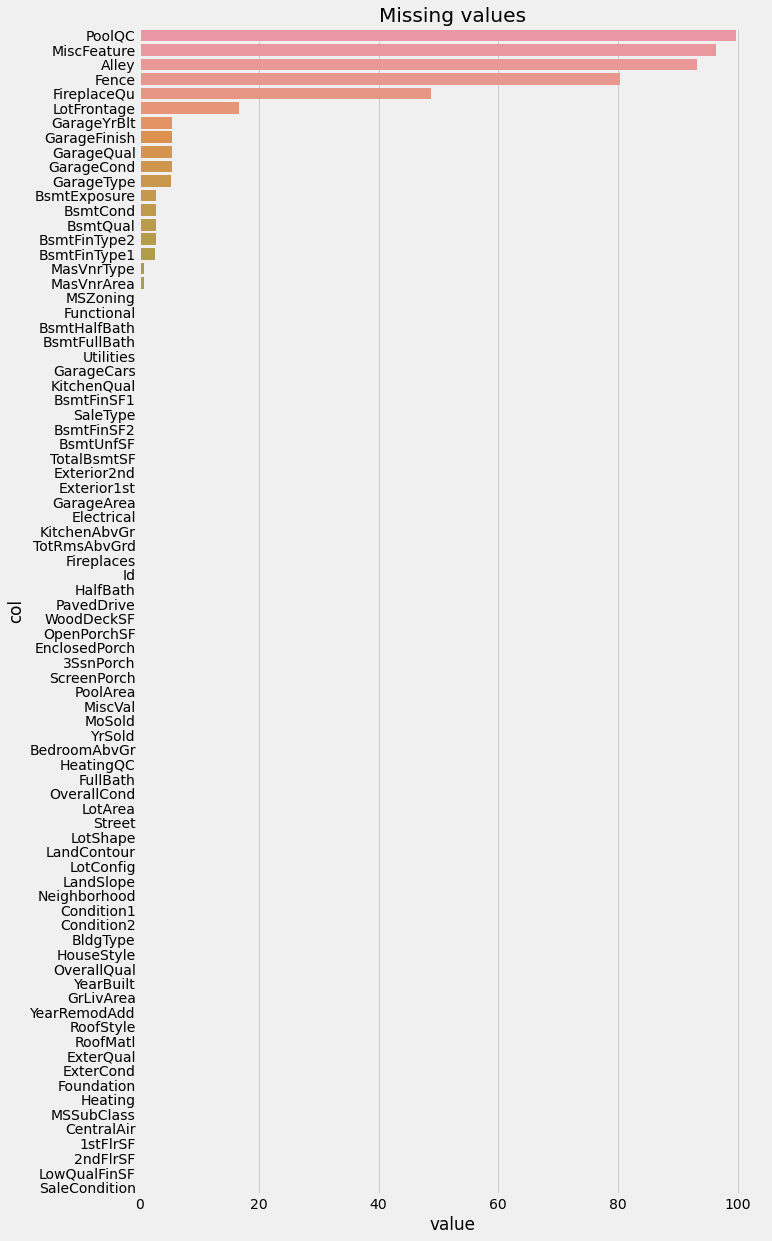

In [313]:
missing(total)

Missing value imputation

In [314]:
#PoolQC
#In PoolQC the NaN values represent the unavailability of pools in the property. So, we will replace NaN with NA 
total.PoolQC.fillna('NA',inplace=True)

In [315]:
#MiscFeature
#In MiscFeature the NaN values represent that there are no more extra features for the property. 
#So, we will replace NaN with NA
total.MiscFeature.fillna('NA',inplace=True)

In [316]:
#In Alley the NaN values represent the unavailability of alleys in the property. So, we will replace NaN with NA
total.Alley.fillna('NA',inplace=True)

In [317]:
#In Fence the NaN values represent the unavailability of fence in the property. So, we will replace NaN representing quality with NA
total.Fence.fillna('NA',inplace=True)

In [318]:
#In FireplaceQu the NaN values represent the unavailability of fireplaces in the property. So, we will replace NaN with NA
total.FireplaceQu.fillna('NA',inplace=True)

In [319]:
#In LotFrontage the NaN values represent the unavailability of linear space connected to the property. So, we will replace NaN with 0
total.LotFrontage.fillna(0,inplace=True)

In [320]:
#In GarageYrBlt the NaN values represent the unavailability of garages in the property. So, we will replace NaN representing year with 0
total.GarageYrBlt.fillna(0,inplace=True)

In [321]:
#In GarageType,GarageFinish,GarageQual,GarageCond the NaN values represent the unavailability of garages in the property. So, we will replace NaN with NA
for col in ['GarageType','GarageFinish','GarageQual','GarageCond']:
    total[col].fillna('NA',inplace=True)

In [322]:
#In BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtQual,BsmtCond the NaN values represent the unavailability of basement in the property. So, we will replace NaN with NA
for col in ['BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtQual','BsmtCond']:
    total[col].fillna('NA',inplace=True)

In [323]:
#In MasVnrType the NaN values represent the unavailability of veneer in the property. So, we will replace NaN with None
total.MasVnrType.fillna('None',inplace=True)

In [324]:
#In MasVnrArea the NaN values represent the unavailability of veneer in the property. So, we will replace NaN with 0
total.MasVnrArea.fillna(0,inplace=True)

In [325]:
#In Electrical the NaN values represent the unavailability of electrical system in the property. So, we will replace NaN with None
total.Electrical.fillna('None',inplace=True)

In [326]:
total.MSZoning.fillna('None',inplace=True)

In [327]:
total.BsmtFullBath.fillna(0,inplace=True)

In [328]:
total.BsmtHalfBath.fillna(0,inplace=True)

In [329]:
total.Functional.fillna('None',inplace=True)

In [330]:
total.drop('Utilities',axis=1,inplace=True)
#Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA .
#Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. 
#We can then safely remove it.

In [331]:
total.PoolQC.fillna('NA',inplace=True)

In [332]:
total.Exterior2nd.fillna('None',inplace=True)

In [333]:
total.KitchenQual.fillna('None',inplace=True)

In [334]:
total['SaleType'].fillna(total.SaleType.mode()[0],inplace=True)
total['Exterior1st'].fillna(total.Exterior1st.mode()[0],inplace=True)

In [335]:
for i in ['GarageCars','GarageArea','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']:
    total[i].fillna(0,inplace=True)

# Skewed Features

In [349]:
skewed=total[only_num[1:-1]].apply(lambda x:skew(x)).sort_values(ascending=False)
skewed=pd.DataFrame(skewed).reset_index().rename(columns={'index':'col',0:'skew'})

In [350]:
print('Skewed features with skewness %')
print(skewed)

Skewed features with skewness %
              col       skew
0         MiscVal  21.939672
1        PoolArea  17.688664
2         LotArea  13.109495
3    LowQualFinSF  12.084539
4       3SsnPorch  11.372080
5      BsmtFinSF2   4.144503
6   EnclosedPorch   4.002344
7     ScreenPorch   3.945101
8      MasVnrArea   2.621719
9     OpenPorchSF   2.529358
10     WoodDeckSF   1.844792
11     MSSubClass   1.375131
12       1stFlrSF   1.257286
13      GrLivArea   1.068750
14     BsmtFinSF1   0.980645
15      BsmtUnfSF   0.919688
16       2ndFlrSF   0.861556
17    TotalBsmtSF   0.671751
18    OverallCond   0.569314
19     GarageArea   0.216857
20    OverallQual   0.189591
21    LotFrontage  -0.127474


Distribution of features with skewness above 0.75


C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


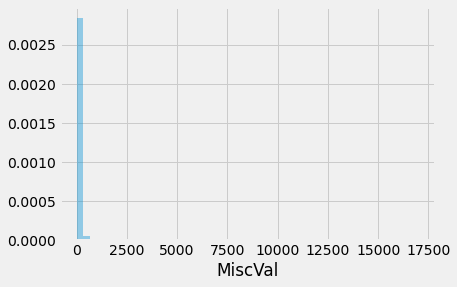

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


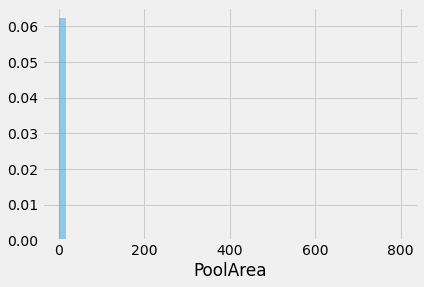

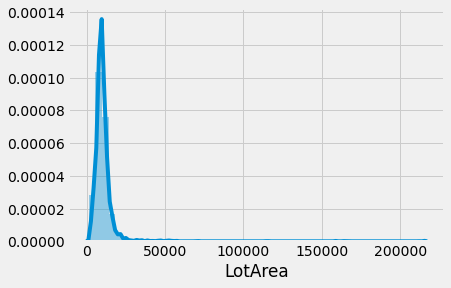

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


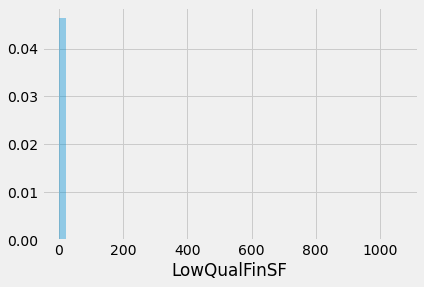

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


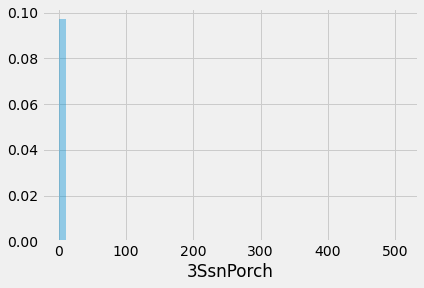

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


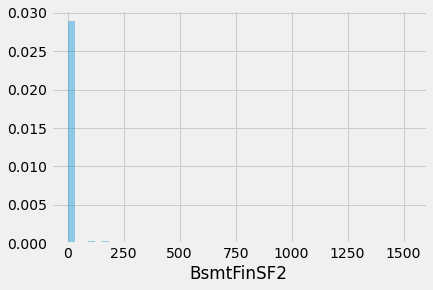

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


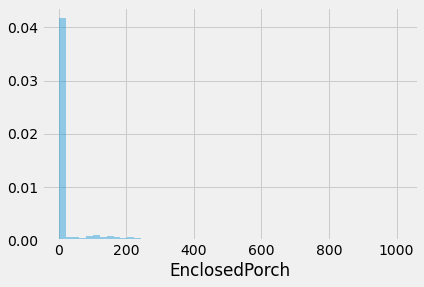

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


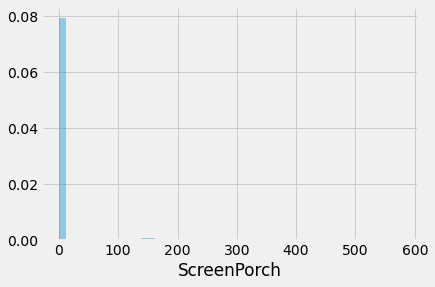

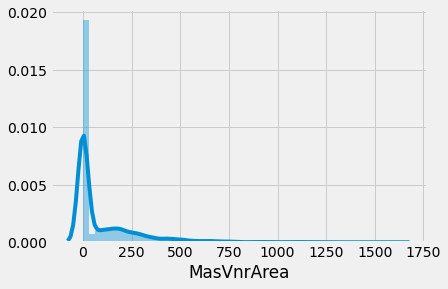

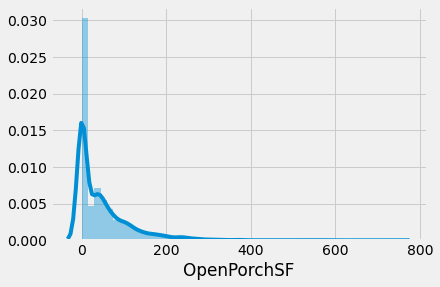

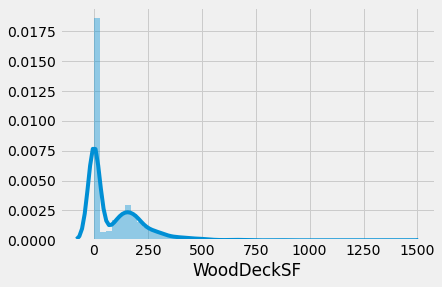

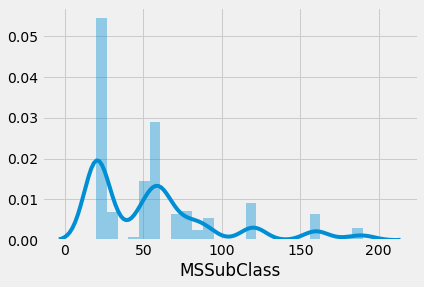

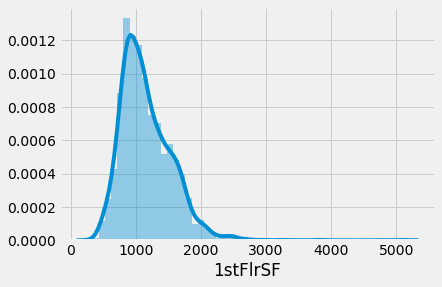

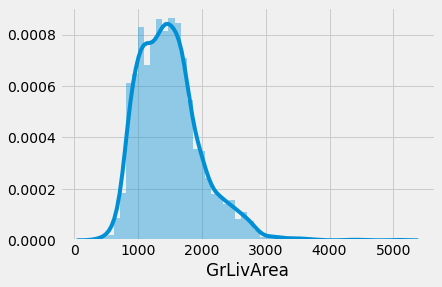

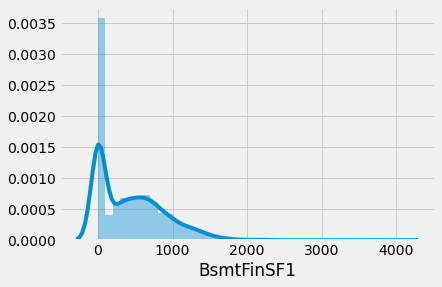

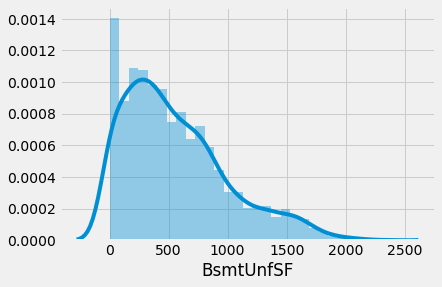

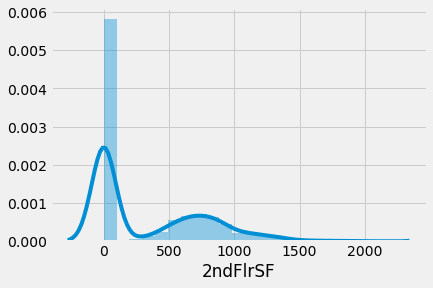

In [353]:
print('Distribution of features with skewness above 0.75')
for i in skewed.col[:17]:
    sns.distplot(total[i])
    plt.show()

In [354]:
for s in skewed.col[:17]:
    total[s]=boxcox1p(total[s],0.15)

Distribution of features which had skewness above 0.75 after box-cox transformation


C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


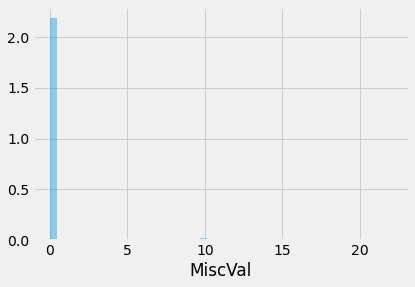

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


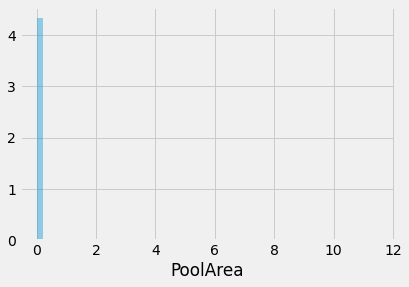

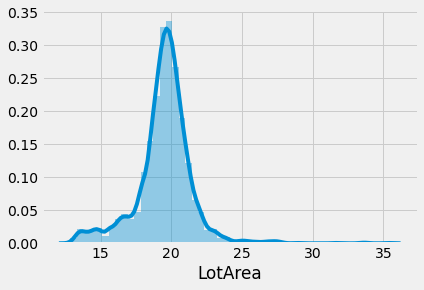

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


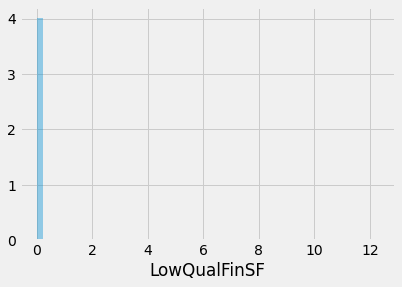

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


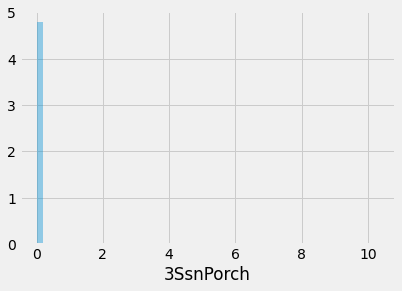

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


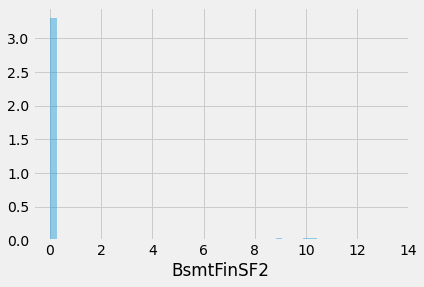

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


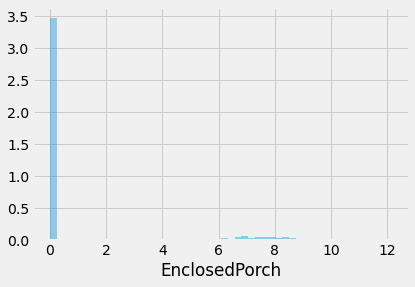

C:\Users\sayee\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


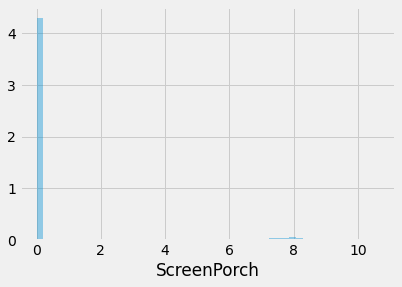

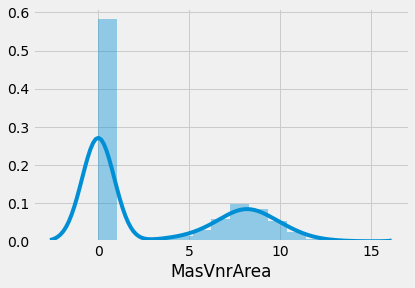

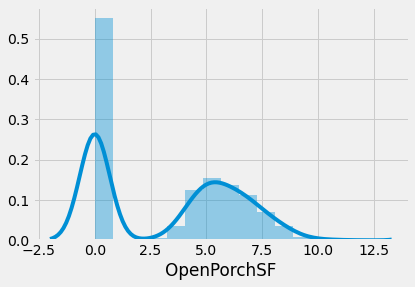

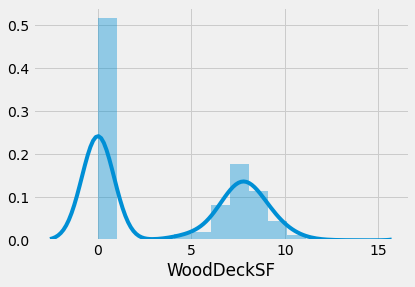

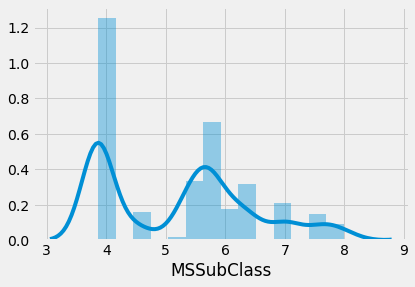

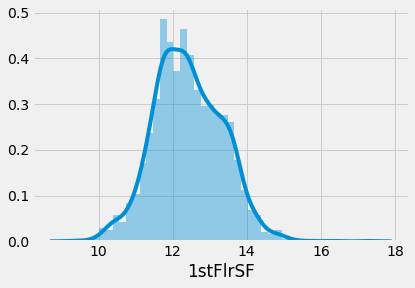

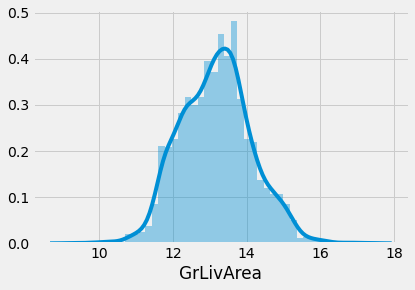

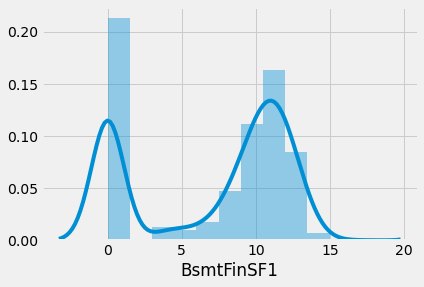

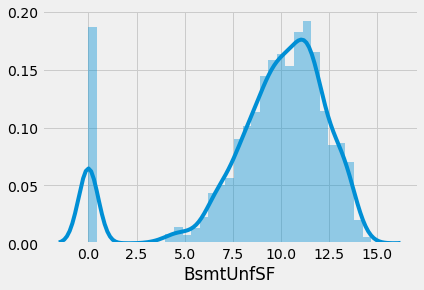

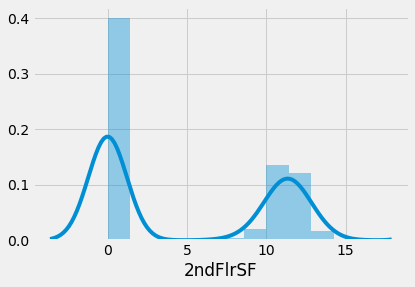

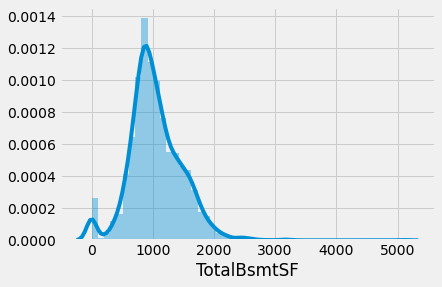

In [356]:
print('Distribution of features which had skewness above 0.75 after box-cox transformation')
for i in skewed.col[:18]:
    sns.distplot(total[i])
    plt.show()

# Feature Engineering

In [357]:
total['ExterQual']=total['ExterQual'].map({ 'Ex':100,'Gd':90,'TA':80,'Fa':70,'Po':30,'None':0})
total['ExterCond']=total['ExterCond'].map({ 'Ex':100,'Gd':90,'TA':80,'Fa':70,'Po':30,'None':0})
total['BsmtQual']=total['BsmtQual'].map({ 'Ex':100,'Gd':90,'TA':80,'Fa':70,'Po':30,'NA':0,'None':0})
total['BsmtCond']=total['BsmtCond'].map({ 'Ex':100,'Gd':90,'TA':80,'Fa':70,'Po':30,'NA':0,'None':0})
total['BsmtExposure']=total['BsmtExposure'].map({ 'Gd':80,'Av':60,'Mn':40,'No':0,'NA':0,'None':0})
total['BsmtFinType1']=total['BsmtFinType1'].map({ 'GLQ':100,'ALQ':80,'BLQ':60,'Rec':40,'LwQ':20,'Unf':15,'NA':0,'None':0})
total['BsmtFinType2']=total['BsmtFinType2'].map({ 'GLQ':100,'ALQ':80,'BLQ':60,'Rec':40,'LwQ':20,'Unf':15,'NA':0,'None':0})
total['HeatingQC']=total['HeatingQC'].map({ 'Ex':100,'Gd':90,'TA':80,'Fa':70,'Po':30,'None':0})
total['KitchenQual']=total['KitchenQual'].map({ 'Ex':100,'Gd':90,'TA':80,'Fa':70,'Po':30,'None':0})
total['Functional']=total['Functional'].map({ 'Typ':100,'Min1':85,'Min2':70,'Mod':55,'Maj1':40,'Maj2':25,'Sev':10,'Sal':5,'None':0})
total['FireplaceQu']=total['FireplaceQu'].map({ 'Ex':100,'Gd':90,'TA':80,'Fa':70,'Po':30,'NA':0,'None':0})
total['GarageFinish']=total['GarageFinish'].map({'Fin':100,'RFn':80,'Unf':40,'NA':0,'None':0})
total['GarageQual']=total['GarageQual'].map({ 'Ex':100,'Gd':90,'TA':80,'Fa':70,'Po':30,'NA':0,'None':0})
total['GarageCond']=total['GarageCond'].map({ 'Ex':100,'Gd':90,'TA':80,'Fa':70,'Po':30,'NA':0,'None':0})
total['PoolQC']=total['PoolQC'].map({ 'Ex':100,'Gd':80,'TA':60,'Fa':40,'NA':0,'None':0})
total['Fence']=total['Fence'].map({'GdPrv':100,'MnPrv':20,'GdWo':100,'MnWw':20,'NA':0,'None':0})

In [358]:
total['Year_Blt_Remod_diff']=total.YearRemodAdd-total.YearBuilt
total['Year_Blt_Sold_diff']=total.YrSold-total.YearBuilt
total['Year_Remod_Sold_diff']=total.YrSold-total.YearRemodAdd
total['Year_Blt_Garage_diff']=total.GarageYrBlt-total.YearBuilt

In [359]:
total['TotalLivingArea']=(total[['1stFlrSF','2ndFlrSF','GrLivArea']]).sum(axis=1)
total['TotalBath']=(total[['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath']]).sum(axis=1)
total['TotalPorchArea']=(total[['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']]).sum(axis=1)
total['TotalArea']=(total[['LotArea','MasVnrArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea',
                           'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']]).sum(axis=1)

In [360]:
total['Overall']=total.OverallQual*total.OverallCond

total['Overall_category']=''

def overall_cat(x):
    if x<=30:
        return 1
    if x>30 and x<=60:
        return 2
    else:
        return 3

total['Overall_category']=total.Overall.apply(lambda x:overall_cat(x))

In [361]:
total['Exter_Overall']=total.ExterQual*total.ExterCond

def overall_exter(x):
    if x<=3300:
        return 1
    if x>3300 and x<=6600:
        return 2
    else:
        return 3
    
total['Overall__exter_category']=total.Exter_Overall.apply(lambda x:overall_exter(x))

In [362]:
total['Basement_Overall']=total.BsmtQual*total.BsmtCond
total['Basement_Overall_category']=total.Basement_Overall.apply(lambda x:overall_exter(x))

In [363]:
total['Nbrhd_Area']=total.groupby(['Neighborhood'])['TotalArea'].transform('mean')+total.TotalArea
total['Alley_Area']=total.groupby(['Alley'])['TotalArea'].transform('mean')+total.TotalArea
#total['Utility_Area']=total.groupby(['Utilities'])['TotalArea'].transform('mean')+total.TotalArea
total['HouseStyle_Area']=total.groupby(['HouseStyle'])['TotalArea'].transform('mean')+total.TotalArea
total['Overall_Area']=total.groupby(['Overall'])['TotalArea'].transform('mean')+total.TotalArea
total['YearBuilt_Area']=total.groupby(['YearBuilt'])['TotalArea'].transform('mean')+total.TotalArea
total['Foundation_Area']=total.groupby(['Foundation'])['TotalArea'].transform('mean')+total.TotalArea
total['Heating_Area']=total.groupby(['Heating'])['TotalArea'].transform('mean')+total.TotalArea
total['CentralAir_Area']=total.groupby(['CentralAir'])['TotalArea'].transform('mean')+total.TotalArea
total['Fireplaces_Area']=total.groupby(['Fireplaces'])['TotalArea'].transform('mean')+total.TotalArea
total['GarageType_Area']=total.groupby(['GarageType'])['TotalArea'].transform('mean')+total.TotalArea
total['MoSold_Area']=total.groupby(['MoSold'])['TotalArea'].transform('mean')+total.TotalArea
total['YrSold_Area']=total.groupby(['YrSold'])['TotalArea'].transform('mean')+total.TotalArea
total['SaleType_Area']=total.groupby(['SaleType'])['TotalArea'].transform('mean')+total.TotalArea

In [364]:
#total['Lot_mul']=total.LotFrontage*total.LotArea
#total['Lot_Front_Area_Shape']=total.groupby(['LotConfig','LotShape'])['LotFrontage'].transform('mean')+total.LotFrontage+total.LotArea
#total['Lot_Front_Area_Config']=total.groupby(['LotConfig'])['LotFrontage'].transform('mean')+total.LotFrontage+total.LotArea
total['Basement_score']=total.Basement_Overall+(total.BsmtFinType1*total.BsmtFinType2)+total.BsmtExposure+total.TotalBsmtSF
total['Garage_score']=(total.GarageYrBlt.max()-total.GarageYrBlt)*total.GarageArea*total.GarageCars*total.GarageQual*total.GarageCond


In [365]:
also_num=['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
          '2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
          'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
          'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal',
           'TotalLivingArea','TotalBath','TotalPorchArea','TotalArea',
          'Overall','Overall_category','Exter_Overall','Overall__exter_category','Basement_Overall','Basement_Overall_category',
          'Nbrhd_Area','Alley_Area','HouseStyle_Area','Overall_Area','YearBuilt_Area','Foundation_Area','Heating_Area',
          'CentralAir_Area','Fireplaces_Area','GarageType_Area','MoSold_Area','YrSold_Area','SaleType_Area','Basement_score','Garage_score']

In [366]:
for n in also_num:
    total[n+'_log']=np.log1p(total[n])

In [367]:
total.shape

(2917, 161)

In [368]:
for n in range(len(also_num)):
    also_num.append(also_num[n]+'_log')

In [369]:
for n in also_num:
    total[n+'_squared']=total[n]*total[n]

# Encode categorical features

In [370]:
total=pd.get_dummies(total).reset_index()
total.drop(['index','Id'],axis=1,inplace=True)
total.shape

(2917, 421)

In [371]:
train = total[:len(train_label)]
test = total[len(train_label):]

In [372]:
train.shape,test.shape

((1458, 421), (1459, 421))

# Modelling

In [374]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, train_label, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [375]:
#Linear Regression
linear=LinearRegression()

score = rmsle_cv(linear)
print("\nLinear Regression rmsle_cv score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

linear.fit(train, train_label)
linear_train_pred = linear.predict(train)
linear_pred = np.expm1(linear.predict(test))
print('Linear Regression RMSLE on train data: ',rmsle(train_label, linear_train_pred))


Linear Regression rmsle_cv score: 0.1770 (0.0091)

Linear Regression RMSLE on train data:  0.1741705701978949


In [376]:
#Lasso
alphas = np.array([5, 0.5, 0.05, 0.005, 0.0005, 1, 0.1, 0.01,0.001, 0.0001, 0 ])
model = Lasso()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))

grid.fit(train, train_label)
print('Best estimator for alpha in LASSO: ',grid.best_estimator_.alpha)

C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.32945970393645, tolerance: 0.018911334381783333
  model = cd_fast.enet_coordinate_descent(
C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.392695037912596, tolerance: 0.01799695208485427
  model = cd_fast.enet_coordinate_descent(
C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.496965450876463, tolerance: 0.01837208344628373
  model = cd_fast.enet_coordinate_descent(
C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.658119868859808, tolerance: 0.019012728260948037
  model = cd_fast.enet_coordinate_descent(
C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.870302403822357, tolerance: 0.018809511234293336
  model = cd_fast.enet_coordinate_descent(
C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.20247281882331, tolerance: 0.018911334381783333
  model = cd_fast.enet_coordinate_descent(
C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9169796078850174, tolerance: 0.01837208344628373
  model = cd_fast.enet_coordinate_descent(
C:\Users\sayee\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Best estimator for alpha in LASSO:  0.0005


C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.569521491203496, tolerance: 0.02327853920138023
  model = cd_fast.enet_coordinate_descent(


In [377]:
#LASSO
lasso = Lasso(alpha =0.0005,random_state=42)

In [378]:
score = rmsle_cv(lasso)
print("\nLASSO rmsle_cv score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.975886364199042, tolerance: 0.018911334381783333
  model = cd_fast.enet_coordinate_descent(
C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.84150686234295, tolerance: 0.01799695208485427
  model = cd_fast.enet_coordinate_descent(
C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.6388982595873305, tolerance: 0.01837208344628373
  model = cd_fast.enet_coordinate_descent(
C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergenc


LASSO rmsle_cv score: 0.1103 (0.0049)



C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.871793031045073, tolerance: 0.018809511234293336
  model = cd_fast.enet_coordinate_descent(


In [379]:
lasso.fit(train, train_label)
lasso_train_pred = lasso.predict(train)
lasso_pred = np.expm1(lasso.predict(test))
print('LASSO RMSLE on train data: ',rmsle(train_label, lasso_train_pred))

LASSO RMSLE on train data:  0.09551795232764733


C:\Users\sayee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.569521491203496, tolerance: 0.02327853920138023
  model = cd_fast.enet_coordinate_descent(


In [119]:
xgb_grid_search = {'max_depth': [2,3,4],
                   'colsample_bytree': [0.2,0.4,0.6],
                   'gamma': [0.2,0.4,0.6],
                   'learning_rate':[0.05,0.1,0.15],
                   'min_child_weight':[1,2,3],
                   'n_estimators': [1000,1500,2000,2500],
                   'subsample': [0.6,0.8,1.0]}

xgb_grid = GridSearchCV(estimator =xgb.XGBRegressor(), param_grid =xgb_grid_search,
                               cv = 5, verbose= 3, n_jobs = -1)

xgb_grid.fit(train, train_label)
print('Best parameters of XGBOOST: ',xgb_grid.best_params_)

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 59.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 75.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 94.2min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 114.1min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed: 135.4min
[Parallel(n_jobs=-1)]: Done 5392 tasks      | elapsed: 168.9min
[Parallel(n_jobs=-1)]: Done 6256 tasks      | elapsed: 206.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks     

Best parameters of XGBOOST:  {'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 2500, 'subsample': 0.6}


In [380]:
#XGBOOST

model_xgb = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.2, 
                             learning_rate=0.05, max_depth=2, 
                             min_child_weight=2, n_estimators=2500,
                             subsample=0.6,
                             random_state =42)

In [381]:
score = rmsle_cv(model_xgb)
print("XGBOOST rmsle_cv score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

XGBOOST rmsle_cv score: 0.1207 (0.0066)



In [382]:
model_xgb.fit(train, train_label)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print('XGBOOST RMSLE score on train data: ',rmsle(train_label, xgb_train_pred))

XGBOOST RMSLE score on train data:  0.09815369031171586


In [383]:
#Ensemble
ensemble_train_pred=xgb_train_pred*0.25+lasso_train_pred*0.75
ensemble_pred = xgb_pred*0.25 + lasso_pred*0.75
print('Ensemble RMSLE score on train data: ',rmsle(train_label, ensemble_train_pred))

Ensemble RMSLE score on train data:  0.09291393176179727


In [96]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = ensemble_pred
sub.to_csv('submission.csv',index=False)

In [124]:
sub[:5]

Id      SalePrice
0  1461  121777.766198
1  1462  153036.901971
2  1463  185620.036285
3  1464  197155.564301
4  1465  192918.001112